In [1]:
import os
print(os.getcwd())

/home/udit/programs/Synaptic-Flow/Notebooks


In [2]:
import sys
sys.path.append("/home/udit/programs/Synaptic-Flow/")

In [44]:
args = {
"dataset" : "mnist", # ['mnist','cifar10','cifar100','tiny-imagenet','imagenet']
"model" : "fc", # ['fc','fc-orth','conv','conv-orth','strconv', ... <take rest from main.py>]
"model_class" : "default", # ['default','lottery','tinyimagenet','imagenet']
"dense_classifier" : False,
"pretrained" : False,
"optimizer" : "adam", # ['sgd','momentum','adam','rms']
"train_batch_size" : 256,
"test_batch_size" : 256,
"pre_epochs" : 0, # number of epochs to train before pruning
"post_epochs" : 10, # number of epochs to train after pruning
"lr" : 1e-3,
"lr_drops" : [],
"lr_drop_rate" : 0.1,
"weight_decay" : 0.0 ,
"save" : False,
"scale" : 1,

# pruning args
"pruner" : "synflow", # ['rand','mag','snip','grasp','synflow']
"compression" : 1.0, # quotient of prunable non-zero prunable parameters before and after pruning (defaul"t: 1.0)
"prune_epochs" : 1, # number of iterations for scoring (defaul"t: 1)
"compression_schedule" : "exponential", # ['linear','exponential']
"mask_scope" : "global", # ['global','local']
"prune_dataset_ratio" : 10, # ratio of prune dataset size and number of classes (defaul"t: 10)'
"prune_batch_size" : 256, # input batch size for pruning (defaul"t: 256)
"prune_bias" : False,
"prune_batchnorm" : False,
"prune_residual" : False,
"reinitialize" : False, # whether to reinitialize weight parameters after pruning (defaul"t: False)
"pruner_list" : [], # list of pruning strategies for singleshot (defaul"t: [])
"prune_epoch_list" : [], # list of prune epochs for singleshot (defaul"t: [])
"compression_list" : [], # list of compression ratio exponents for singleshot/multishot (defaul"t: [])
"level_list" : [],
"experiment" : "prune-only", # ['example',"prune-only",'singleshot','multishot',
    # 'unit-conservation', 'layer-conservation','imp-conservation','schedule-conservation']
"expid" : "",
"result_dir" : "Results/data",
"gpu" : "0",
"workers" : 4,
"no_cuda" : False,
"seed" : 1,
"verbose" : False,
"save_pruned" : False,
"save_pruned_path" : "Results/pruned"
}

In [42]:
import torch
from torch import norm
import pandas as pd
import numpy as np
from tqdm import tqdm

def train(model, loss, optimizer, dataloader, device, epoch, verbose, log_interval=10):
    model.train()
    total = 0
    train_loss = 0
    batch_size = -1
    for batch_idx, (data, target) in enumerate(dataloader):
        #print(f"Index {batch_idx}")
        if batch_idx > 0:
            break
        data, target = data.to(device), target.to(device)
        batch_size = len(data)
        optimizer.zero_grad()
        output = model(data)
        
        train_loss = loss(output, target)
        total += train_loss.item() * data.size(0)
        train_loss.backward()
        
        optimizer.step()
        if verbose & (batch_idx % log_interval == 0):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dataloader.dataset),
                100. * batch_idx / len(dataloader), train_loss.item()))
    
    return total / batch_size

def eval(model, loss, dataloader, device, verbose):
    model.eval()
    total = 0
    correct1 = 0
    batch_size = -1
    with torch.no_grad():
        for idx, (data, target) in enumerate(dataloader):
            if idx > 0:
                break
            data, target = data.to(device), target.to(device)
            batch_size = len(data)
            output = model(data)
            #print("Cla Eval, ", print(output.shape, target.shape))
            total += loss(output, target).item() * data.size(0)
            _, pred = output.topk(1, dim=1)
            correct = pred.eq(target.view(-1, 1).expand_as(pred))
            correct1 += correct[:,:1].sum().item()
    average_loss = total / batch_size
    accuracy1 = 100. * correct1 / batch_size

    if verbose:
        print('Evaluation: Average loss: {:.4f}, Top 1 Accuracy: {}/{} ({:.2f}%)'.format(
            average_loss, correct1, len(dataloader.dataset), accuracy1))
    return average_loss, accuracy1

def train_eval_loop(model, loss, optimizer, scheduler, train_loader, test_loader, device,
                    epochs, verbose):
    test_loss, accuracy1 = eval(model, loss, test_loader, device, verbose)
    budge = 0
    budge_kernel = 0.0
    rows = [[np.nan, test_loss, accuracy1, budge, budge_kernel]]
    allw0 = -1
    allw = -1
    kernel0 = -1
    kernel = -1
    for epoch in tqdm(range(epochs)):
        #print("Epoch: ", epoch)
#         kernel = kernel.fill_(0.0).to(device=device)
#         handles = attach_kernel(model, kernel)
        for idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            if idx > 0:
                break
            kernel = compute_train_kernel(model, data, target)
            # print("Kernel: ", kernel)
        train_loss = train(model, loss, optimizer, train_loader, device, epoch, verbose)
        
        
        if epoch == 0:
            allw0 = nn.utils.parameters_to_vector(model.parameters()).detach().cpu().numpy().copy()
            kernel0 = kernel.cpu().data
            # print(kernel0.size())
            #print(f"Kernel0: {kernel0}")
            # print(np.linalg.norm(kernel0))
        else:
            allw = nn.utils.parameters_to_vector(model.parameters()).detach().cpu().numpy().copy()
            kernel = kernel.cpu().data
            budge = np.linalg.norm(allw-allw0)/np.linalg.norm(allw0)
            budge_kernel = np.linalg.norm(kernel - kernel0)/np.linalg.norm(kernel0)
            # print(np.linalg.norm(kernel))
        # detach_kernel(model, handles)

        test_loss, accuracy1 = eval(model, loss, test_loader, device, verbose)
        row = [train_loss, test_loss, accuracy1, budge, budge_kernel]
        print("Epoch: {} - metrics {}".format(epoch, row))
        scheduler.step()
        rows.append(row)
    columns = ['train_loss', 'test_loss', 'top1_accuracy', 'budge', 'budge_kernel']
    return pd.DataFrame(rows, columns=columns)

In [9]:
def attach_kernel(model, kernel):
    
    handles = []
    
    for module in model.modules():
        if len(list(module.children())) > 0:
            continue
            
        params = [p for p in module.parameters() if p.requires_grad]
                
        if len(params) == 0:
            continue
        
        setattr(module, 'kernel', kernel)
        
        if forward_postprocess is not None:
            handles.append(module.register_forward_hook(forward_postprocess))
    return handles

def detach_kernel(model, handles):
    for module in model.modules():
        if hasattr(module, 'kernel'):
            del module.kernel
        if hasattr(module, 'A'):
            del module.A
        
    
    for handle in handles:
        handle.remove()
    

In [10]:
import torch
import torch.nn as nn
import numpy as np
from Layers import layers
import Layers
from torch.nn import functional as F
import copy
class ZeroOutput(nn.Module):
    """Zero the output of a model by subtracting out a copy of it."""

    def __init__(self, model):
        super().__init__()
        self.init_model = [copy.deepcopy(model).eval()]

        self.model = model

    def forward(self, inp):
        return self.model(inp) - self.init_model[0](inp)


class Scale(nn.Module):
    """Scale the output of the model by alpha."""

    def __init__(self, model, alpha):
        super().__init__()
        self.model = model
        self.alpha = alpha

    def forward(self, inp):
        return self.alpha*self.model(inp)

def fc_cla(input_shape, num_classes, dense_classifier=False, pretrained=False, L=3, N=20, 
           nonlinearity=nn.ReLU(), scale=1):
    size = np.prod(input_shape)
  
    # Linear feature extractor
    modules = [nn.Flatten()]
    modules.append(layers.Linear(size, N))
    modules.append(nonlinearity)
    for i in range(L-2):
        modules.append(layers.Linear(N,N))
        modules.append(nonlinearity)

    # Linear classifier
    if dense_classifier:
        modules.append(nn.Linear(N, num_classes))
    else:
        modules.append(layers.Linear(N, num_classes))
    # modules.append(nn.Linear(num_classes, 1))
    model = nn.Sequential(*modules)
    model = Scale(model, scale)
    
    print("Classification: Depth {}, Width {}, Scale {}".format(L, N, scale))
    # Pretrained model
    if pretrained:
        print("WARNING: this model does not have pretrained weights.")

    return model

In [46]:
#### code from torch.nn.grad modified so that the gradients are not summed over batch dimension ######
from torch._six import container_abcs
from itertools import repeat

def _ntuple(n):
    def parse(x):
        if isinstance(x, container_abcs.Iterable):
            return x
        return tuple(repeat(x, n))
    return parse

# _pair = _ntuple(2)

###############
# global last_layer = True
def forward_postprocess(module, input, output):
    data_input = input[0].detach()
        
    def backward_hook_linear(grad):
        grad = grad.view(grad.shape[0], -1)
        # print(f"Grad {grad}")
        # print(f"Grad shape {grad.shape}") # ", module.A shape {module.A.shape}")
        gg = grad @ grad.t()
        # print(f"Module Kernel: {module.kernel}")
        module.kernel.addcmul_(1.,  module.A, gg)
        #del module.A
    
    if output.requires_grad and isinstance(module, nn.Linear):
        h = output.register_hook(backward_hook_linear)
        data_input = data_input.view(data_input.shape[0], -1)
        # print(f"Data {data_input}")
        # print(f"data_input shape: {data_input.shape}")
        add = 1. if hasattr(module, 'bias') and module.bias.requires_grad else 0.
        setattr(module, 'A', data_input @ data_input.t() + add)
                      

def compute_train_kernel(model, x, output):
    
    n = x.shape[0]
    kernel = torch.zeros(n, n, device=x.device)
    
    handles = []
    
    for module in model.modules():
        if len(list(module.children())) > 0:
            continue
            
        params = [p for p in module.parameters() if p.requires_grad]
                
        if len(params) == 0:
            continue
        
        setattr(module, 'kernel', kernel)
        
        if forward_postprocess is not None:
            handles.append(module.register_forward_hook(forward_postprocess))
            
    model.zero_grad()
    f = model(x)
    f.sum().backward()
    #f[:, output].sum().backward()
    
    for module in model.modules():
        if hasattr(module, 'kernel'):
            del module.kernel
    
    for handle in handles:
        handle.remove()
    # print(f"Kernel: {kernel}")
    return kernel

In [12]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from Utils import load
from Utils import generator
from Utils import metrics
from prune import *
import matplotlib.pyplot as plt

import os

def prune_only(args):
    print("Pruning only")
    
    ## Random Seed and Device ##
    torch.manual_seed(args["seed"])
    device = load.device(args["gpu"])
    shuffle = False
    ## Data ##
    print('Loading {} dataset.'.format(args["dataset"]))
    input_shape, num_classes = load.dimension(args["dataset"]) 
    prune_loader = load.dataloader(args["dataset"], args["prune_batch_size"], True, args["workers"], 
                                   args["prune_dataset_ratio"] * num_classes)
    
    train_loader = load.dataloader(args["dataset"], args["train_batch_size"], False, args["workers"])
    test_loader = load.dataloader(args["dataset"], args["test_batch_size"], False, args["workers"])
    
    
    ## Model, Loss, Optimizer ##
    print('Creating {}-{} model.'.format(args["model_class"], args["model"]))
    model = fc_cla(input_shape, num_classes, args["dense_classifier"], 
                   args["pretrained"], scale=args["scale"], L=args["depth"], N=args["width"]).to(device)        
    loss = nn.CrossEntropyLoss()
    
        
    opt_class, opt_kwargs = load.optimizer(args["optimizer"])
    optimizer = opt_class(generator.parameters(model), lr=args["lr"], 
                          weight_decay=args["weight_decay"], **opt_kwargs)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=args["lr_drops"], 
                                                     gamma=args["lr_drop_rate"])

    
    #print(f"Kernel: {kernel}")
    
    ## Pre-Train ##
    #print('Pre-Train for {} epochs.'.format(args.pre_epochs))
    pre_result = train_eval_loop(model, loss, optimizer, scheduler, train_loader, 
                                 test_loader, device, 0, args["verbose"])
    
    
    ## Prune ##
    print('Pruning with {} for {} epochs.'.format(args["pruner"], args["prune_epochs"]))
    pruner = load.pruner(args["pruner"])(generator.masked_parameters(model, args["prune_bias"], 
                       args["prune_batchnorm"], args["prune_residual"]))
    sparsity = 10**(-float(args["compression"]))
    print("Sparsity: {}".format(sparsity))
    save_pruned_path = args["save_pruned_path"] + "/%s/%s/%s" % (args["model_class"], 
                                                                 args["model"], args["pruner"],)
    if (args["save_pruned"]):
        print("Saving pruned models to: %s" % (save_pruned_path, ))
        if not os.path.exists(save_pruned_path):
            os.makedirs(save_pruned_path)
    prune_loop(model, loss, pruner, prune_loader, device, sparsity, 
               args["compression_schedule"], args["mask_scope"], args["prune_epochs"], 
               args["reinitialize"], args["save_pruned"], save_pruned_path)
    if args["model-type"] == "fc_reg" or args["model-type"] == "fc_cla_sigm":
        sigm = True
        print("Using MSE Loss")
        loss = nn.MSELoss()
    prune_result = metrics.summary(model, pruner.scores,
                                   metrics.flop(model, input_shape, device),
                                   lambda p: generator.prunable(p, args["prune_batchnorm"], 
                                    args["prune_residual"]))
    total_params = int((prune_result['sparsity'] * prune_result['size']).sum())
    possible_params = prune_result['size'].sum()
    total_flops = int((prune_result['sparsity'] * prune_result['flops']).sum())
    possible_flops = prune_result['flops'].sum()
    print("Parameter Sparsity: {}/{} ({:.4f})".format(total_params, 
                                                      possible_params, total_params / possible_params))
    print("FLOP Sparsity: {}/{} ({:.4f})".format(total_flops, 
                                                 possible_flops, total_flops / possible_flops))
    
    ## Post-Train ##
    #print('Post-Training for {} epochs.'.format(args.post_epochs))
    post_result = train_eval_loop(model, loss, optimizer, scheduler, train_loader, 
                                  test_loader, device, args["post_epochs"], args["verbose"])
    
    
    ## Display Results ##
#     frames = [pre_result.head(1), post_result.head(1), post_result.tail(1)]
#     train_result = pd.concat(frames, keys=['Init.', 'Post-Prune', "Final"])

#     print("Train results:\n", train_result)
#     print("Prune results:\n", prune_result)

    ## Save Results and Model ##
    if args["save"]:
        print('Saving results.')
        pre_result.to_pickle("{}/pre-train.pkl".format(args["result_dir"]))
        post_result.to_pickle("{}/post-train.pkl".format(args["result_dir"]))
        prune_result.to_pickle("{}/compression.pkl".format(args["result_dir"]))
        torch.save(model.state_dict(),"{}/model.pt".format(args["result_dir"]))
        torch.save(optimizer.state_dict(),"{}/optimizer.pt".format(args["result_dir"]))
        torch.save(pruner.state_dict(),"{}/pruner.pt".format(args["result_dir"]))
    
    # to change
    return post_result

In [65]:
test_df = prune_train_loop("fc_cla", "rand", 1.0, 0, 300, 4, 1000)

Pruning only
Loading mnist dataset.
Creating default-fc model.
Classification: Depth 4, Width 1000, Scale 1


0it [00:00, ?it/s]
0it [00:00, ?it/s]

Pruning with rand for 0 epochs.
Sparsity: 0.1
ERROR: 2794000.0 prunable parameters remaining, expected 279400.0
Parameter Sparsity: 2797010/2797010 (1.0000)
FLOP Sparsity: 2797010/2797010 (1.0000)



  0%|          | 1/300 [00:00<02:59,  1.66it/s]

Epoch: 0 - metrics [2.3059473037719727, 2.3045380115509033, 10.9375, 0, 0.0]


  1%|          | 2/300 [00:01<02:58,  1.67it/s]

Epoch: 1 - metrics [2.3045380115509033, 2.3020942211151123, 10.9375, 0.0001848476, 0.0024452433]


  1%|          | 3/300 [00:01<02:57,  1.67it/s]

Epoch: 2 - metrics [2.3020942211151123, 2.2989089488983154, 12.109375, 0.00042656693, 0.004073014]


  1%|▏         | 4/300 [00:02<02:55,  1.69it/s]

Epoch: 3 - metrics [2.2989089488983154, 2.2951972484588623, 13.671875, 0.0007093407, 0.005451361]


  2%|▏         | 5/300 [00:02<02:54,  1.69it/s]

Epoch: 4 - metrics [2.2951972484588623, 2.2911195755004883, 16.40625, 0.0010215306, 0.006988386]


  2%|▏         | 6/300 [00:03<02:54,  1.69it/s]

Epoch: 5 - metrics [2.2911195755004883, 2.286787509918213, 25.78125, 0.0013545181, 0.008474321]


  2%|▏         | 7/300 [00:04<02:55,  1.67it/s]

Epoch: 6 - metrics [2.286787509918213, 2.2822670936584473, 31.25, 0.0017023501, 0.010404943]


  3%|▎         | 8/300 [00:04<02:56,  1.65it/s]

Epoch: 7 - metrics [2.2822670936584473, 2.277627944946289, 36.71875, 0.0020605961, 0.012372894]


  3%|▎         | 9/300 [00:05<02:54,  1.67it/s]

Epoch: 8 - metrics [2.277627944946289, 2.2729053497314453, 40.234375, 0.0024257677, 0.014745585]


  3%|▎         | 10/300 [00:05<02:52,  1.68it/s]

Epoch: 9 - metrics [2.2729053497314453, 2.2681162357330322, 41.796875, 0.0027957547, 0.018360717]


  4%|▎         | 11/300 [00:06<02:53,  1.67it/s]

Epoch: 10 - metrics [2.2681162357330322, 2.2632715702056885, 42.1875, 0.0031691345, 0.023104478]


  4%|▍         | 12/300 [00:07<02:53,  1.66it/s]

Epoch: 11 - metrics [2.2632715702056885, 2.2583811283111572, 42.578125, 0.0035449173, 0.02886304]


  4%|▍         | 13/300 [00:07<02:52,  1.66it/s]

Epoch: 12 - metrics [2.2583811283111572, 2.2534422874450684, 43.359375, 0.0039224457, 0.03541248]


  5%|▍         | 14/300 [00:08<02:53,  1.65it/s]

Epoch: 13 - metrics [2.2534422874450684, 2.24845552444458, 43.359375, 0.0043013524, 0.042984903]


  5%|▌         | 15/300 [00:08<02:51,  1.66it/s]

Epoch: 14 - metrics [2.24845552444458, 2.243415594100952, 42.1875, 0.0046814913, 0.051318806]


  5%|▌         | 16/300 [00:09<02:48,  1.69it/s]

Epoch: 15 - metrics [2.243415594100952, 2.23832106590271, 41.796875, 0.005062736, 0.060542647]


  6%|▌         | 17/300 [00:10<02:48,  1.68it/s]

Epoch: 16 - metrics [2.23832106590271, 2.2331645488739014, 42.1875, 0.0054451306, 0.07135163]


  6%|▌         | 18/300 [00:10<02:48,  1.67it/s]

Epoch: 17 - metrics [2.2331645488739014, 2.2279417514801025, 41.015625, 0.005828848, 0.08243846]


  6%|▋         | 19/300 [00:11<02:49,  1.66it/s]

Epoch: 18 - metrics [2.2279417514801025, 2.2226390838623047, 41.40625, 0.006214032, 0.09454799]


  7%|▋         | 20/300 [00:11<02:47,  1.67it/s]

Epoch: 19 - metrics [2.2226390838623047, 2.217245578765869, 41.40625, 0.0066009657, 0.107595496]


  7%|▋         | 21/300 [00:12<02:46,  1.68it/s]

Epoch: 20 - metrics [2.217245578765869, 2.211754560470581, 41.40625, 0.0069898874, 0.12209779]


  7%|▋         | 22/300 [00:13<02:46,  1.67it/s]

Epoch: 21 - metrics [2.211754560470581, 2.206155776977539, 41.015625, 0.0073811486, 0.13761503]


  8%|▊         | 23/300 [00:13<02:47,  1.66it/s]

Epoch: 22 - metrics [2.206155776977539, 2.2004411220550537, 40.625, 0.0077749696, 0.15513411]


  8%|▊         | 24/300 [00:14<02:45,  1.67it/s]

Epoch: 23 - metrics [2.2004411220550537, 2.19460129737854, 40.625, 0.008171585, 0.17397173]


  8%|▊         | 25/300 [00:14<02:44,  1.68it/s]

Epoch: 24 - metrics [2.19460129737854, 2.188632011413574, 40.234375, 0.008571329, 0.19381714]


  9%|▊         | 26/300 [00:15<02:45,  1.66it/s]

Epoch: 25 - metrics [2.188632011413574, 2.1825225353240967, 39.453125, 0.008974353, 0.21487519]


  9%|▉         | 27/300 [00:16<02:44,  1.66it/s]

Epoch: 26 - metrics [2.1825225353240967, 2.1762616634368896, 39.0625, 0.009380947, 0.23755595]


  9%|▉         | 28/300 [00:16<02:44,  1.65it/s]

Epoch: 27 - metrics [2.1762616634368896, 2.169840097427368, 39.453125, 0.009791506, 0.26142794]


 10%|▉         | 29/300 [00:17<02:44,  1.65it/s]

Epoch: 28 - metrics [2.169840097427368, 2.1632537841796875, 39.453125, 0.010206083, 0.286928]


 10%|█         | 30/300 [00:18<02:44,  1.64it/s]

Epoch: 29 - metrics [2.1632537841796875, 2.1564857959747314, 39.453125, 0.010625056, 0.31355554]


 10%|█         | 31/300 [00:18<02:43,  1.65it/s]

Epoch: 30 - metrics [2.1564857959747314, 2.149521589279175, 39.453125, 0.011048691, 0.34134394]


 11%|█         | 32/300 [00:19<02:41,  1.66it/s]

Epoch: 31 - metrics [2.149521589279175, 2.142348289489746, 39.453125, 0.011477315, 0.3709963]


 11%|█         | 33/300 [00:19<02:43,  1.64it/s]

Epoch: 32 - metrics [2.142348289489746, 2.1349527835845947, 39.453125, 0.011911248, 0.4015005]


 11%|█▏        | 34/300 [00:20<02:42,  1.64it/s]

Epoch: 33 - metrics [2.1349527835845947, 2.127319574356079, 39.84375, 0.012350894, 0.4346481]


 12%|█▏        | 35/300 [00:21<02:41,  1.64it/s]

Epoch: 34 - metrics [2.127319574356079, 2.1194443702697754, 40.625, 0.012796452, 0.4696298]


 12%|█▏        | 36/300 [00:21<02:37,  1.67it/s]

Epoch: 35 - metrics [2.1194443702697754, 2.1113059520721436, 40.625, 0.013248274, 0.5060812]


 12%|█▏        | 37/300 [00:22<02:39,  1.65it/s]

Epoch: 36 - metrics [2.1113059520721436, 2.1028871536254883, 41.015625, 0.013706632, 0.5443065]


 13%|█▎        | 38/300 [00:22<02:39,  1.65it/s]

Epoch: 37 - metrics [2.1028871536254883, 2.094175100326538, 41.015625, 0.014171958, 0.5840255]


 13%|█▎        | 39/300 [00:23<02:38,  1.65it/s]

Epoch: 38 - metrics [2.094175100326538, 2.085160255432129, 41.015625, 0.01464437, 0.62666917]


 13%|█▎        | 40/300 [00:24<02:38,  1.64it/s]

Epoch: 39 - metrics [2.085160255432129, 2.0758278369903564, 41.40625, 0.015124178, 0.66997033]


 14%|█▎        | 41/300 [00:24<02:36,  1.65it/s]

Epoch: 40 - metrics [2.0758278369903564, 2.066164493560791, 42.1875, 0.015611551, 0.7165499]


 14%|█▍        | 42/300 [00:25<02:35,  1.65it/s]

Epoch: 41 - metrics [2.066164493560791, 2.056157350540161, 42.1875, 0.01610687, 0.7663938]


 14%|█▍        | 43/300 [00:25<02:34,  1.66it/s]

Epoch: 42 - metrics [2.056157350540161, 2.0458004474639893, 42.578125, 0.016610153, 0.8179964]


 15%|█▍        | 44/300 [00:26<02:35,  1.64it/s]

Epoch: 43 - metrics [2.0458004474639893, 2.035062074661255, 42.578125, 0.017121693, 0.8719094]


 15%|█▌        | 45/300 [00:27<02:33,  1.66it/s]

Epoch: 44 - metrics [2.035062074661255, 2.023925542831421, 43.359375, 0.017641798, 0.9285932]


 15%|█▌        | 46/300 [00:27<02:32,  1.67it/s]

Epoch: 45 - metrics [2.023925542831421, 2.012378692626953, 45.3125, 0.018170718, 0.9888219]


 16%|█▌        | 47/300 [00:28<02:31,  1.67it/s]

Epoch: 46 - metrics [2.012378692626953, 2.000413179397583, 45.3125, 0.018708624, 1.0521154]


 16%|█▌        | 48/300 [00:28<02:31,  1.66it/s]

Epoch: 47 - metrics [2.000413179397583, 1.9880061149597168, 46.484375, 0.019255808, 1.1173646]


 16%|█▋        | 49/300 [00:29<02:30,  1.67it/s]

Epoch: 48 - metrics [1.9880061149597168, 1.9751440286636353, 46.484375, 0.019812446, 1.1864505]


 17%|█▋        | 50/300 [00:30<02:30,  1.66it/s]

Epoch: 49 - metrics [1.9751440286636353, 1.9618070125579834, 46.875, 0.020378742, 1.2579695]


 17%|█▋        | 51/300 [00:30<02:32,  1.63it/s]

Epoch: 50 - metrics [1.9618070125579834, 1.9479858875274658, 48.046875, 0.02095499, 1.3327632]


 17%|█▋        | 52/300 [00:31<02:32,  1.63it/s]

Epoch: 51 - metrics [1.9479858875274658, 1.9336817264556885, 50.0, 0.02154112, 1.4127336]


 18%|█▊        | 53/300 [00:31<02:29,  1.65it/s]

Epoch: 52 - metrics [1.9336817264556885, 1.9188697338104248, 50.78125, 0.022137191, 1.4967816]


 18%|█▊        | 54/300 [00:32<02:29,  1.65it/s]

Epoch: 53 - metrics [1.9188697338104248, 1.9035398960113525, 51.171875, 0.022743404, 1.585598]


 18%|█▊        | 55/300 [00:33<02:29,  1.64it/s]

Epoch: 54 - metrics [1.9035398960113525, 1.8876937627792358, 51.953125, 0.02335983, 1.6779978]


 19%|█▊        | 56/300 [00:33<02:27,  1.66it/s]

Epoch: 55 - metrics [1.8876937627792358, 1.8713239431381226, 52.734375, 0.023986328, 1.7748121]


 19%|█▉        | 57/300 [00:34<02:26,  1.66it/s]

Epoch: 56 - metrics [1.8713239431381226, 1.854425311088562, 53.515625, 0.024622869, 1.8772768]


 19%|█▉        | 58/300 [00:34<02:27,  1.64it/s]

Epoch: 57 - metrics [1.854425311088562, 1.8369978666305542, 54.6875, 0.025269456, 1.9847193]


 20%|█▉        | 59/300 [00:35<02:26,  1.65it/s]

Epoch: 58 - metrics [1.8369978666305542, 1.819047451019287, 55.46875, 0.025925942, 2.0974863]


 20%|██        | 60/300 [00:36<02:24,  1.66it/s]

Epoch: 59 - metrics [1.819047451019287, 1.8005691766738892, 56.25, 0.026592143, 2.2133522]


 20%|██        | 61/300 [00:36<02:22,  1.67it/s]

Epoch: 60 - metrics [1.8005691766738892, 1.7815804481506348, 57.03125, 0.027267842, 2.3381565]


 21%|██        | 62/300 [00:37<02:24,  1.64it/s]

Epoch: 61 - metrics [1.7815804481506348, 1.7620868682861328, 58.203125, 0.027952822, 2.467072]


 21%|██        | 63/300 [00:37<02:24,  1.64it/s]

Epoch: 62 - metrics [1.7620868682861328, 1.742104411125183, 58.984375, 0.028646836, 2.600843]


 21%|██▏       | 64/300 [00:38<02:22,  1.65it/s]

Epoch: 63 - metrics [1.742104411125183, 1.7216572761535645, 59.765625, 0.029349394, 2.7418935]


 22%|██▏       | 65/300 [00:39<02:20,  1.67it/s]

Epoch: 64 - metrics [1.7216572761535645, 1.7007676362991333, 60.546875, 0.030060057, 2.8887835]


 22%|██▏       | 66/300 [00:39<02:20,  1.66it/s]

Epoch: 65 - metrics [1.7007676362991333, 1.6794466972351074, 60.9375, 0.030778293, 3.041456]


 22%|██▏       | 67/300 [00:40<02:20,  1.65it/s]

Epoch: 66 - metrics [1.6794466972351074, 1.6577037572860718, 61.71875, 0.031503882, 3.202178]


 23%|██▎       | 68/300 [00:40<02:19,  1.66it/s]

Epoch: 67 - metrics [1.6577037572860718, 1.6355654001235962, 64.0625, 0.032236323, 3.3720045]


 23%|██▎       | 69/300 [00:41<02:17,  1.68it/s]

Epoch: 68 - metrics [1.6355654001235962, 1.6130566596984863, 64.453125, 0.032975115, 3.548895]


 23%|██▎       | 70/300 [00:42<02:19,  1.65it/s]

Epoch: 69 - metrics [1.6130566596984863, 1.5902249813079834, 66.796875, 0.033719584, 3.7313964]


 24%|██▎       | 71/300 [00:42<02:16,  1.68it/s]

Epoch: 70 - metrics [1.5902249813079834, 1.5670835971832275, 67.578125, 0.034469184, 3.925077]


 24%|██▍       | 72/300 [00:43<02:15,  1.69it/s]

Epoch: 71 - metrics [1.5670835971832275, 1.5436512231826782, 68.359375, 0.0352235, 4.1257415]


 24%|██▍       | 73/300 [00:43<02:15,  1.67it/s]

Epoch: 72 - metrics [1.5436512231826782, 1.5199425220489502, 69.140625, 0.035982165, 4.3356123]


 25%|██▍       | 74/300 [00:44<02:15,  1.66it/s]

Epoch: 73 - metrics [1.5199425220489502, 1.4959888458251953, 69.921875, 0.036744732, 4.553187]


 25%|██▌       | 75/300 [00:45<02:15,  1.66it/s]

Epoch: 74 - metrics [1.4959888458251953, 1.4718236923217773, 70.703125, 0.037510812, 4.781719]


 25%|██▌       | 76/300 [00:45<02:15,  1.66it/s]

Epoch: 75 - metrics [1.4718236923217773, 1.4474639892578125, 71.484375, 0.03827998, 5.0202885]


 26%|██▌       | 77/300 [00:46<02:14,  1.66it/s]

Epoch: 76 - metrics [1.4474639892578125, 1.4229413270950317, 72.65625, 0.039051786, 5.2665963]


 26%|██▌       | 78/300 [00:47<02:15,  1.64it/s]

Epoch: 77 - metrics [1.4229413270950317, 1.3982815742492676, 73.828125, 0.039825957, 5.5301065]


 26%|██▋       | 79/300 [00:47<02:13,  1.66it/s]

Epoch: 78 - metrics [1.3982815742492676, 1.3735160827636719, 75.390625, 0.0406018, 5.803928]


 27%|██▋       | 80/300 [00:48<02:13,  1.65it/s]

Epoch: 79 - metrics [1.3735160827636719, 1.3486844301223755, 76.171875, 0.041378796, 6.0874453]


 27%|██▋       | 81/300 [00:48<02:14,  1.63it/s]

Epoch: 80 - metrics [1.3486844301223755, 1.3238205909729004, 76.5625, 0.04215652, 6.382829]


 27%|██▋       | 82/300 [00:49<02:13,  1.63it/s]

Epoch: 81 - metrics [1.3238205909729004, 1.298964023590088, 76.953125, 0.042934343, 6.6922903]


 28%|██▊       | 83/300 [00:50<02:11,  1.65it/s]

Epoch: 82 - metrics [1.298964023590088, 1.274125576019287, 79.296875, 0.043711696, 7.012157]


 28%|██▊       | 84/300 [00:50<02:12,  1.63it/s]

Epoch: 83 - metrics [1.274125576019287, 1.2493358850479126, 80.078125, 0.044488255, 7.347436]


 28%|██▊       | 85/300 [00:51<02:12,  1.63it/s]

Epoch: 84 - metrics [1.2493358850479126, 1.224624514579773, 80.46875, 0.045263432, 7.6938624]


 29%|██▊       | 86/300 [00:51<02:10,  1.64it/s]

Epoch: 85 - metrics [1.224624514579773, 1.200014352798462, 80.859375, 0.046036825, 8.051745]


 29%|██▉       | 87/300 [00:52<02:09,  1.65it/s]

Epoch: 86 - metrics [1.200014352798462, 1.1755282878875732, 82.03125, 0.04680792, 8.422006]


 29%|██▉       | 88/300 [00:53<02:09,  1.64it/s]

Epoch: 87 - metrics [1.1755282878875732, 1.1511869430541992, 81.640625, 0.047576338, 8.803237]


 30%|██▉       | 89/300 [00:53<02:07,  1.66it/s]

Epoch: 88 - metrics [1.1511869430541992, 1.1270294189453125, 81.640625, 0.0483418, 9.1956625]


 30%|███       | 90/300 [00:54<02:06,  1.66it/s]

Epoch: 89 - metrics [1.1270294189453125, 1.1030772924423218, 82.421875, 0.04910364, 9.600448]


 30%|███       | 91/300 [00:54<02:06,  1.66it/s]

Epoch: 90 - metrics [1.1030772924423218, 1.079336166381836, 82.8125, 0.049861506, 10.017898]


 31%|███       | 92/300 [00:55<02:05,  1.65it/s]

Epoch: 91 - metrics [1.079336166381836, 1.0558534860610962, 83.203125, 0.050615024, 10.44616]


 31%|███       | 93/300 [00:56<02:06,  1.64it/s]

Epoch: 92 - metrics [1.0558534860610962, 1.03263521194458, 82.8125, 0.051363803, 10.890481]


 31%|███▏      | 94/300 [00:56<02:04,  1.65it/s]

Epoch: 93 - metrics [1.03263521194458, 1.0097177028656006, 83.984375, 0.052107617, 11.339908]


 32%|███▏      | 95/300 [00:57<02:04,  1.65it/s]

Epoch: 94 - metrics [1.0097177028656006, 0.9871252775192261, 84.375, 0.052845966, 11.803613]


 32%|███▏      | 96/300 [00:57<02:03,  1.65it/s]

Epoch: 95 - metrics [0.9871252775192261, 0.9648798704147339, 84.765625, 0.053578503, 12.275446]


 32%|███▏      | 97/300 [00:58<02:01,  1.66it/s]

Epoch: 96 - metrics [0.9648798704147339, 0.9429957866668701, 85.546875, 0.05430476, 12.755461]


 33%|███▎      | 98/300 [00:59<02:01,  1.66it/s]

Epoch: 97 - metrics [0.9429957866668701, 0.9214833974838257, 85.546875, 0.055024467, 13.243683]


 33%|███▎      | 99/300 [00:59<02:02,  1.65it/s]

Epoch: 98 - metrics [0.9214833974838257, 0.9003579020500183, 85.9375, 0.05573737, 13.7467]


 33%|███▎      | 100/300 [01:00<02:00,  1.66it/s]

Epoch: 99 - metrics [0.9003579020500183, 0.8796349167823792, 85.9375, 0.056443237, 14.2537985]


 34%|███▎      | 101/300 [01:00<02:01,  1.64it/s]

Epoch: 100 - metrics [0.8796349167823792, 0.8593358993530273, 86.328125, 0.057141766, 14.772148]


 34%|███▍      | 102/300 [01:01<02:00,  1.65it/s]

Epoch: 101 - metrics [0.8593358993530273, 0.8394632935523987, 86.71875, 0.057832602, 15.29564]


 34%|███▍      | 103/300 [01:02<01:58,  1.66it/s]

Epoch: 102 - metrics [0.8394632935523987, 0.8200141191482544, 87.5, 0.058515567, 15.825816]


 35%|███▍      | 104/300 [01:02<01:59,  1.64it/s]

Epoch: 103 - metrics [0.8200141191482544, 0.8009973168373108, 87.890625, 0.059190497, 16.363071]


 35%|███▌      | 105/300 [01:03<01:59,  1.64it/s]

Epoch: 104 - metrics [0.8009973168373108, 0.7824178338050842, 88.28125, 0.05985701, 16.904343]


 35%|███▌      | 106/300 [01:04<01:58,  1.63it/s]

Epoch: 105 - metrics [0.7824178338050842, 0.7642833590507507, 87.890625, 0.060515128, 17.453682]


 36%|███▌      | 107/300 [01:04<01:57,  1.64it/s]

Epoch: 106 - metrics [0.7642833590507507, 0.7466003894805908, 88.28125, 0.061164536, 18.00188]


 36%|███▌      | 108/300 [01:05<01:56,  1.65it/s]

Epoch: 107 - metrics [0.7466003894805908, 0.7293672561645508, 88.28125, 0.06180512, 18.547913]


 36%|███▋      | 109/300 [01:05<01:55,  1.65it/s]

Epoch: 108 - metrics [0.7293672561645508, 0.712576687335968, 89.453125, 0.062436763, 19.095673]


 37%|███▋      | 110/300 [01:06<01:55,  1.64it/s]

Epoch: 109 - metrics [0.712576687335968, 0.6962210536003113, 89.453125, 0.063059606, 19.648981]


 37%|███▋      | 111/300 [01:07<01:55,  1.64it/s]

Epoch: 110 - metrics [0.6962210536003113, 0.6802963018417358, 90.234375, 0.063673325, 20.199007]


 37%|███▋      | 112/300 [01:07<01:53,  1.66it/s]

Epoch: 111 - metrics [0.6802963018417358, 0.6648055911064148, 90.625, 0.06427801, 20.75586]


 38%|███▊      | 113/300 [01:08<01:53,  1.65it/s]

Epoch: 112 - metrics [0.6648055911064148, 0.6497482657432556, 90.625, 0.0648736, 21.307947]


 38%|███▊      | 114/300 [01:08<01:52,  1.65it/s]

Epoch: 113 - metrics [0.6497482657432556, 0.6351165771484375, 91.015625, 0.06545998, 21.857597]


 38%|███▊      | 115/300 [01:09<01:52,  1.64it/s]

Epoch: 114 - metrics [0.6351165771484375, 0.6208963394165039, 91.015625, 0.066037156, 22.410025]


 39%|███▊      | 116/300 [01:10<01:51,  1.65it/s]

Epoch: 115 - metrics [0.6208963394165039, 0.607082724571228, 91.015625, 0.06660525, 22.954031]


 39%|███▉      | 117/300 [01:10<01:51,  1.64it/s]

Epoch: 116 - metrics [0.607082724571228, 0.5936630964279175, 91.796875, 0.06716426, 23.499653]


 39%|███▉      | 118/300 [01:11<01:50,  1.65it/s]

Epoch: 117 - metrics [0.5936630964279175, 0.5806283354759216, 91.796875, 0.06771419, 24.04376]


 40%|███▉      | 119/300 [01:11<01:49,  1.66it/s]

Epoch: 118 - metrics [0.5806283354759216, 0.5679689645767212, 91.796875, 0.068255335, 24.582703]


 40%|████      | 120/300 [01:12<01:50,  1.63it/s]

Epoch: 119 - metrics [0.5679689645767212, 0.5556783676147461, 92.1875, 0.06878751, 25.116299]


 40%|████      | 121/300 [01:13<01:50,  1.62it/s]

Epoch: 120 - metrics [0.5556783676147461, 0.543746292591095, 92.578125, 0.06931104, 25.647772]


 41%|████      | 122/300 [01:13<01:49,  1.62it/s]

Epoch: 121 - metrics [0.543746292591095, 0.5321612358093262, 92.578125, 0.06982596, 26.175806]


 41%|████      | 123/300 [01:14<01:48,  1.63it/s]

Epoch: 122 - metrics [0.5321612358093262, 0.5209166407585144, 93.359375, 0.070332244, 26.698195]


 41%|████▏     | 124/300 [01:14<01:47,  1.64it/s]

Epoch: 123 - metrics [0.5209166407585144, 0.5100004076957703, 93.75, 0.07083002, 27.218555]


 42%|████▏     | 125/300 [01:15<01:47,  1.62it/s]

Epoch: 124 - metrics [0.5100004076957703, 0.49940264225006104, 93.75, 0.071319506, 27.7302]


 42%|████▏     | 126/300 [01:16<01:47,  1.63it/s]

Epoch: 125 - metrics [0.49940264225006104, 0.4891106188297272, 93.75, 0.071800895, 28.240467]


 42%|████▏     | 127/300 [01:16<01:46,  1.62it/s]

Epoch: 126 - metrics [0.4891106188297272, 0.4791111350059509, 93.75, 0.0722742, 28.741596]


 43%|████▎     | 128/300 [01:17<01:45,  1.63it/s]

Epoch: 127 - metrics [0.4791111350059509, 0.46939510107040405, 94.140625, 0.07273973, 29.235344]


 43%|████▎     | 129/300 [01:18<01:44,  1.63it/s]

Epoch: 128 - metrics [0.46939510107040405, 0.4599533975124359, 94.140625, 0.0731976, 29.725035]


 43%|████▎     | 130/300 [01:18<01:43,  1.64it/s]

Epoch: 129 - metrics [0.4599533975124359, 0.45077812671661377, 94.53125, 0.07364815, 30.210829]


 44%|████▎     | 131/300 [01:19<01:43,  1.63it/s]

Epoch: 130 - metrics [0.45077812671661377, 0.4418569803237915, 94.53125, 0.07409128, 30.690577]


 44%|████▍     | 132/300 [01:19<01:43,  1.62it/s]

Epoch: 131 - metrics [0.4418569803237915, 0.4331810474395752, 94.53125, 0.07452733, 31.161434]


 44%|████▍     | 133/300 [01:20<01:43,  1.61it/s]

Epoch: 132 - metrics [0.4331810474395752, 0.42474061250686646, 94.53125, 0.0749564, 31.630552]


 45%|████▍     | 134/300 [01:21<01:42,  1.62it/s]

Epoch: 133 - metrics [0.42474061250686646, 0.41653019189834595, 94.53125, 0.07537862, 32.095444]


 45%|████▌     | 135/300 [01:21<01:42,  1.62it/s]

Epoch: 134 - metrics [0.41653019189834595, 0.4085395336151123, 94.921875, 0.07579431, 32.551476]


 45%|████▌     | 136/300 [01:22<01:41,  1.62it/s]

Epoch: 135 - metrics [0.4085395336151123, 0.40076279640197754, 94.921875, 0.076203406, 33.00391]


 46%|████▌     | 137/300 [01:22<01:40,  1.62it/s]

Epoch: 136 - metrics [0.40076279640197754, 0.39318981766700745, 94.921875, 0.076606125, 33.451492]


 46%|████▌     | 138/300 [01:23<01:39,  1.62it/s]

Epoch: 137 - metrics [0.39318981766700745, 0.38581106066703796, 94.921875, 0.077002786, 33.89294]


 46%|████▋     | 139/300 [01:24<01:39,  1.61it/s]

Epoch: 138 - metrics [0.38581106066703796, 0.378622442483902, 95.3125, 0.07739335, 34.33163]


 47%|████▋     | 140/300 [01:24<01:38,  1.62it/s]

Epoch: 139 - metrics [0.378622442483902, 0.37161725759506226, 95.3125, 0.07777799, 34.76591]


 47%|████▋     | 141/300 [01:25<01:36,  1.64it/s]

Epoch: 140 - metrics [0.37161725759506226, 0.3647884428501129, 95.3125, 0.07815696, 35.19018]


 47%|████▋     | 142/300 [01:26<01:35,  1.65it/s]

Epoch: 141 - metrics [0.3647884428501129, 0.3581275939941406, 95.3125, 0.07853036, 35.608585]


 48%|████▊     | 143/300 [01:26<01:35,  1.64it/s]

Epoch: 142 - metrics [0.3581275939941406, 0.3516314923763275, 95.3125, 0.07889827, 36.024014]


 48%|████▊     | 144/300 [01:27<01:34,  1.65it/s]

Epoch: 143 - metrics [0.3516314923763275, 0.34529393911361694, 95.3125, 0.07926093, 36.435646]


 48%|████▊     | 145/300 [01:27<01:33,  1.66it/s]

Epoch: 144 - metrics [0.34529393911361694, 0.3391090929508209, 95.3125, 0.07961828, 36.843628]


 49%|████▊     | 146/300 [01:28<01:33,  1.64it/s]

Epoch: 145 - metrics [0.3391090929508209, 0.3330727517604828, 95.703125, 0.07997072, 37.24704]


 49%|████▉     | 147/300 [01:29<01:33,  1.64it/s]

Epoch: 146 - metrics [0.3330727517604828, 0.3271790146827698, 95.703125, 0.08031825, 37.641605]


 49%|████▉     | 148/300 [01:29<01:32,  1.64it/s]

Epoch: 147 - metrics [0.3271790146827698, 0.3214232325553894, 95.703125, 0.080661006, 38.036625]


 50%|████▉     | 149/300 [01:30<01:32,  1.64it/s]

Epoch: 148 - metrics [0.3214232325553894, 0.3157995343208313, 95.703125, 0.08099904, 38.425293]


 50%|█████     | 150/300 [01:30<01:31,  1.63it/s]

Epoch: 149 - metrics [0.3157995343208313, 0.3103048503398895, 95.703125, 0.08133251, 38.81095]


 50%|█████     | 151/300 [01:31<01:30,  1.64it/s]

Epoch: 150 - metrics [0.3103048503398895, 0.3049347400665283, 95.703125, 0.08166155, 39.19282]


 51%|█████     | 152/300 [01:32<01:29,  1.65it/s]

Epoch: 151 - metrics [0.3049347400665283, 0.2996860444545746, 95.703125, 0.08198633, 39.57303]


 51%|█████     | 153/300 [01:32<01:28,  1.66it/s]

Epoch: 152 - metrics [0.2996860444545746, 0.2945554554462433, 95.703125, 0.08230671, 39.94786]


 51%|█████▏    | 154/300 [01:33<01:29,  1.63it/s]

Epoch: 153 - metrics [0.2945554554462433, 0.2895386219024658, 95.703125, 0.08262296, 40.317898]


 52%|█████▏    | 155/300 [01:33<01:29,  1.63it/s]

Epoch: 154 - metrics [0.2895386219024658, 0.2846309542655945, 95.703125, 0.082935214, 40.67606]


 52%|█████▏    | 156/300 [01:34<01:28,  1.63it/s]

Epoch: 155 - metrics [0.2846309542655945, 0.27982833981513977, 95.703125, 0.08324344, 41.036877]


 52%|█████▏    | 157/300 [01:35<01:27,  1.63it/s]

Epoch: 156 - metrics [0.27982833981513977, 0.2751275897026062, 95.703125, 0.0835478, 41.39583]


 53%|█████▎    | 158/300 [01:35<01:26,  1.65it/s]

Epoch: 157 - metrics [0.2751275897026062, 0.27052605152130127, 96.09375, 0.08384842, 41.75033]


 53%|█████▎    | 159/300 [01:36<01:25,  1.64it/s]

Epoch: 158 - metrics [0.27052605152130127, 0.266020804643631, 96.09375, 0.08414536, 42.09981]


 53%|█████▎    | 160/300 [01:37<01:25,  1.65it/s]

Epoch: 159 - metrics [0.266020804643631, 0.26160964369773865, 96.484375, 0.08443875, 42.44497]


 54%|█████▎    | 161/300 [01:37<01:24,  1.65it/s]

Epoch: 160 - metrics [0.26160964369773865, 0.2572876513004303, 96.484375, 0.08472861, 42.78366]


 54%|█████▍    | 162/300 [01:38<01:23,  1.65it/s]

Epoch: 161 - metrics [0.2572876513004303, 0.2530539929866791, 96.484375, 0.08501512, 43.120674]


 54%|█████▍    | 163/300 [01:38<01:23,  1.65it/s]

Epoch: 162 - metrics [0.2530539929866791, 0.24890467524528503, 96.875, 0.08529837, 43.458508]


 55%|█████▍    | 164/300 [01:39<01:20,  1.68it/s]

Epoch: 163 - metrics [0.24890467524528503, 0.24483884871006012, 96.875, 0.08557837, 43.792854]


 55%|█████▌    | 165/300 [01:40<01:21,  1.65it/s]

Epoch: 164 - metrics [0.24483884871006012, 0.24085339903831482, 96.875, 0.08585524, 44.12193]


 55%|█████▌    | 166/300 [01:40<01:20,  1.66it/s]

Epoch: 165 - metrics [0.24085339903831482, 0.23694656789302826, 96.875, 0.08612906, 44.44741]


 56%|█████▌    | 167/300 [01:41<01:19,  1.68it/s]

Epoch: 166 - metrics [0.23694656789302826, 0.23311738669872284, 96.875, 0.08639987, 44.77519]


 56%|█████▌    | 168/300 [01:41<01:19,  1.65it/s]

Epoch: 167 - metrics [0.23311738669872284, 0.22936424612998962, 97.265625, 0.0866676, 45.093952]


 56%|█████▋    | 169/300 [01:42<01:19,  1.64it/s]

Epoch: 168 - metrics [0.22936424612998962, 0.22568391263484955, 97.265625, 0.08693254, 45.40713]


 57%|█████▋    | 170/300 [01:43<01:18,  1.65it/s]

Epoch: 169 - metrics [0.22568391263484955, 0.2220747470855713, 97.265625, 0.087194435, 45.715843]


 57%|█████▋    | 171/300 [01:43<01:18,  1.65it/s]

Epoch: 170 - metrics [0.2220747470855713, 0.21853439509868622, 97.265625, 0.087453604, 46.028866]


 57%|█████▋    | 172/300 [01:44<01:18,  1.62it/s]

Epoch: 171 - metrics [0.21853439509868622, 0.21506227552890778, 97.265625, 0.08770997, 46.334526]


 58%|█████▊    | 173/300 [01:44<01:18,  1.63it/s]

Epoch: 172 - metrics [0.21506227552890778, 0.21165618300437927, 97.265625, 0.087963745, 46.642006]


 58%|█████▊    | 174/300 [01:45<01:17,  1.63it/s]

Epoch: 173 - metrics [0.21165618300437927, 0.20831485092639923, 97.265625, 0.088214986, 46.94079]


 58%|█████▊    | 175/300 [01:46<01:15,  1.65it/s]

Epoch: 174 - metrics [0.20831485092639923, 0.20503723621368408, 97.265625, 0.08846363, 47.241005]


 59%|█████▊    | 176/300 [01:46<01:15,  1.64it/s]

Epoch: 175 - metrics [0.20503723621368408, 0.2018221616744995, 97.265625, 0.08870973, 47.54193]


 59%|█████▉    | 177/300 [01:47<01:14,  1.65it/s]

Epoch: 176 - metrics [0.2018221616744995, 0.19866709411144257, 97.65625, 0.088953316, 47.840103]


 59%|█████▉    | 178/300 [01:47<01:13,  1.66it/s]

Epoch: 177 - metrics [0.19866709411144257, 0.19557106494903564, 98.046875, 0.08919453, 48.13131]


 60%|█████▉    | 179/300 [01:48<01:12,  1.66it/s]

Epoch: 178 - metrics [0.19557106494903564, 0.1925327628850937, 98.046875, 0.08943334, 48.425957]


 60%|██████    | 180/300 [01:49<01:12,  1.65it/s]

Epoch: 179 - metrics [0.1925327628850937, 0.18955102562904358, 98.4375, 0.08966972, 48.71826]


 60%|██████    | 181/300 [01:49<01:12,  1.65it/s]

Epoch: 180 - metrics [0.18955102562904358, 0.1866244524717331, 98.4375, 0.08990379, 49.005337]


 61%|██████    | 182/300 [01:50<01:10,  1.66it/s]

Epoch: 181 - metrics [0.1866244524717331, 0.18375176191329956, 98.4375, 0.090135686, 49.287277]


 61%|██████    | 183/300 [01:50<01:11,  1.64it/s]

Epoch: 182 - metrics [0.18375176191329956, 0.18093129992485046, 98.4375, 0.09036527, 49.57074]


 61%|██████▏   | 184/300 [01:51<01:10,  1.65it/s]

Epoch: 183 - metrics [0.18093129992485046, 0.1781628429889679, 98.4375, 0.09059252, 49.853672]


 62%|██████▏   | 185/300 [01:52<01:09,  1.65it/s]

Epoch: 184 - metrics [0.1781628429889679, 0.1754445731639862, 98.828125, 0.09081786, 50.13175]


 62%|██████▏   | 186/300 [01:52<01:08,  1.65it/s]

Epoch: 185 - metrics [0.1754445731639862, 0.17277663946151733, 98.828125, 0.09104089, 50.404835]


 62%|██████▏   | 187/300 [01:53<01:08,  1.64it/s]

Epoch: 186 - metrics [0.17277663946151733, 0.1701577752828598, 98.828125, 0.09126169, 50.679096]


 63%|██████▎   | 188/300 [01:53<01:07,  1.66it/s]

Epoch: 187 - metrics [0.1701577752828598, 0.16758659482002258, 99.21875, 0.09148053, 50.944885]


 63%|██████▎   | 189/300 [01:54<01:07,  1.64it/s]

Epoch: 188 - metrics [0.16758659482002258, 0.1650618314743042, 99.21875, 0.091697395, 51.21444]


 63%|██████▎   | 190/300 [01:55<01:07,  1.64it/s]

Epoch: 189 - metrics [0.1650618314743042, 0.16258254647254944, 99.21875, 0.091912106, 51.479504]


 64%|██████▎   | 191/300 [01:55<01:06,  1.64it/s]

Epoch: 190 - metrics [0.16258254647254944, 0.16014902293682098, 99.21875, 0.09212498, 51.743847]


 64%|██████▍   | 192/300 [01:56<01:05,  1.64it/s]

Epoch: 191 - metrics [0.16014902293682098, 0.15775902569293976, 99.21875, 0.09233582, 52.011387]


 64%|██████▍   | 193/300 [01:57<01:05,  1.64it/s]

Epoch: 192 - metrics [0.15775902569293976, 0.15541218221187592, 99.21875, 0.09254455, 52.275864]


 65%|██████▍   | 194/300 [01:57<01:04,  1.64it/s]

Epoch: 193 - metrics [0.15541218221187592, 0.1531084179878235, 99.21875, 0.092751525, 52.533085]


 65%|██████▌   | 195/300 [01:58<01:03,  1.66it/s]

Epoch: 194 - metrics [0.1531084179878235, 0.15084613859653473, 99.21875, 0.0929566, 52.788292]


 65%|██████▌   | 196/300 [01:58<01:02,  1.65it/s]

Epoch: 195 - metrics [0.15084613859653473, 0.14862534403800964, 99.21875, 0.09315986, 53.039597]


 66%|██████▌   | 197/300 [01:59<01:02,  1.65it/s]

Epoch: 196 - metrics [0.14862534403800964, 0.14644402265548706, 99.21875, 0.09336125, 53.291344]


 66%|██████▌   | 198/300 [02:00<01:01,  1.66it/s]

Epoch: 197 - metrics [0.14644402265548706, 0.14430169761180878, 99.21875, 0.093560815, 53.544865]


 66%|██████▋   | 199/300 [02:00<01:00,  1.67it/s]

Epoch: 198 - metrics [0.14430169761180878, 0.1421968787908554, 99.21875, 0.09375859, 53.79556]


 67%|██████▋   | 200/300 [02:01<00:59,  1.68it/s]

Epoch: 199 - metrics [0.1421968787908554, 0.1401292085647583, 99.609375, 0.093954794, 54.041836]


 67%|██████▋   | 201/300 [02:01<00:59,  1.66it/s]

Epoch: 200 - metrics [0.1401292085647583, 0.13809813559055328, 99.609375, 0.09414903, 54.290436]


 67%|██████▋   | 202/300 [02:02<00:58,  1.66it/s]

Epoch: 201 - metrics [0.13809813559055328, 0.13610321283340454, 99.609375, 0.094341666, 54.53311]


 68%|██████▊   | 203/300 [02:03<00:58,  1.66it/s]

Epoch: 202 - metrics [0.13610321283340454, 0.13414350152015686, 99.609375, 0.09453267, 54.772457]


 68%|██████▊   | 204/300 [02:03<00:58,  1.65it/s]

Epoch: 203 - metrics [0.13414350152015686, 0.13221846520900726, 99.609375, 0.09472194, 55.013084]


 68%|██████▊   | 205/300 [02:04<00:58,  1.63it/s]

Epoch: 204 - metrics [0.13221846520900726, 0.13032665848731995, 99.609375, 0.094909675, 55.252193]


 69%|██████▊   | 206/300 [02:04<00:57,  1.63it/s]

Epoch: 205 - metrics [0.13032665848731995, 0.12846799194812775, 99.609375, 0.0950957, 55.493515]


 69%|██████▉   | 207/300 [02:05<00:56,  1.65it/s]

Epoch: 206 - metrics [0.12846799194812775, 0.12664192914962769, 99.609375, 0.09528028, 55.725216]


 69%|██████▉   | 208/300 [02:06<00:55,  1.65it/s]

Epoch: 207 - metrics [0.12664192914962769, 0.12484772503376007, 100.0, 0.0954632, 55.960976]


 70%|██████▉   | 209/300 [02:06<00:55,  1.64it/s]

Epoch: 208 - metrics [0.12484772503376007, 0.12308550626039505, 100.0, 0.095644616, 56.197304]


 70%|███████   | 210/300 [02:07<00:54,  1.66it/s]

Epoch: 209 - metrics [0.12308550626039505, 0.12135440856218338, 100.0, 0.0958244, 56.43253]


 70%|███████   | 211/300 [02:07<00:53,  1.68it/s]

Epoch: 210 - metrics [0.12135440856218338, 0.1196535974740982, 100.0, 0.09600269, 56.668247]


 71%|███████   | 212/300 [02:08<00:52,  1.66it/s]

Epoch: 211 - metrics [0.1196535974740982, 0.1179828941822052, 100.0, 0.09617944, 56.89351]


 71%|███████   | 213/300 [02:09<00:52,  1.67it/s]

Epoch: 212 - metrics [0.1179828941822052, 0.11634127795696259, 100.0, 0.09635472, 57.12196]


 71%|███████▏  | 214/300 [02:09<00:51,  1.67it/s]

Epoch: 213 - metrics [0.11634127795696259, 0.11472883820533752, 100.0, 0.096528664, 57.347237]


 72%|███████▏  | 215/300 [02:10<00:50,  1.67it/s]

Epoch: 214 - metrics [0.11472883820533752, 0.11314475536346436, 100.0, 0.09670083, 57.567654]


 72%|███████▏  | 216/300 [02:10<00:50,  1.65it/s]

Epoch: 215 - metrics [0.11314475536346436, 0.11158858239650726, 100.0, 0.09687177, 57.79441]


 72%|███████▏  | 217/300 [02:11<00:50,  1.66it/s]

Epoch: 216 - metrics [0.11158858239650726, 0.11005929857492447, 100.0, 0.09704125, 58.021072]


 73%|███████▎  | 218/300 [02:12<00:49,  1.65it/s]

Epoch: 217 - metrics [0.11005929857492447, 0.10855688154697418, 100.0, 0.09720933, 58.243298]


 73%|███████▎  | 219/300 [02:12<00:49,  1.63it/s]

Epoch: 218 - metrics [0.10855688154697418, 0.10708092898130417, 100.0, 0.097376026, 58.46532]


 73%|███████▎  | 220/300 [02:13<00:49,  1.63it/s]

Epoch: 219 - metrics [0.10708092898130417, 0.10563060641288757, 100.0, 0.09754118, 58.679047]


 74%|███████▎  | 221/300 [02:13<00:48,  1.64it/s]

Epoch: 220 - metrics [0.10563060641288757, 0.10420581698417664, 100.0, 0.09770495, 58.89871]


 74%|███████▍  | 222/300 [02:14<00:47,  1.65it/s]

Epoch: 221 - metrics [0.10420581698417664, 0.10280608385801315, 100.0, 0.09786745, 59.11366]


 74%|███████▍  | 223/300 [02:15<00:47,  1.63it/s]

Epoch: 222 - metrics [0.10280608385801315, 0.10143104195594788, 100.0, 0.09802862, 59.323887]


Traceback (most recent call last):
 75%|███████▍  | 224/300 [02:15<00:46,  1.63it/s]

Epoch: 223 - metrics [0.10143104195594788, 0.10007987916469574, 100.0, 0.09818849, 59.54033]


 75%|███████▌  | 225/300 [02:16<00:45,  1.65it/s]

Epoch: 224 - metrics [0.10007987916469574, 0.09875226765871048, 100.0, 0.09834701, 59.75077]


 75%|███████▌  | 226/300 [02:17<00:45,  1.64it/s]

Epoch: 225 - metrics [0.09875226765871048, 0.09744773805141449, 100.0, 0.09850407, 59.957817]


 76%|███████▌  | 227/300 [02:17<00:44,  1.65it/s]

Epoch: 226 - metrics [0.09744773805141449, 0.09616546332836151, 100.0, 0.098659955, 60.163254]


 76%|███████▌  | 228/300 [02:18<00:43,  1.66it/s]

Epoch: 227 - metrics [0.09616546332836151, 0.09490501880645752, 100.0, 0.098814584, 60.36606]


 76%|███████▋  | 229/300 [02:18<00:42,  1.66it/s]

Epoch: 228 - metrics [0.09490501880645752, 0.09366664290428162, 100.0, 0.09896788, 60.56963]


 77%|███████▋  | 230/300 [02:19<00:41,  1.67it/s]

Epoch: 229 - metrics [0.09366664290428162, 0.09244950115680695, 100.0, 0.099120095, 60.7706]


 77%|███████▋  | 231/300 [02:20<00:41,  1.66it/s]

Epoch: 230 - metrics [0.09244950115680695, 0.09125323593616486, 100.0, 0.09927092, 60.97452]


 77%|███████▋  | 232/300 [02:20<00:41,  1.66it/s]

Epoch: 231 - metrics [0.09125323593616486, 0.09007781744003296, 100.0, 0.09942056, 61.169437]


 78%|███████▊  | 233/300 [02:21<00:40,  1.66it/s]

Epoch: 232 - metrics [0.09007781744003296, 0.08892280608415604, 100.0, 0.099569045, 61.36963]


 78%|███████▊  | 234/300 [02:21<00:40,  1.64it/s]

Epoch: 233 - metrics [0.08892280608415604, 0.08778746426105499, 100.0, 0.09971625, 61.569485]


 78%|███████▊  | 235/300 [02:22<00:39,  1.64it/s]

Epoch: 234 - metrics [0.08778746426105499, 0.08667173981666565, 100.0, 0.09986234, 61.76334]


 79%|███████▊  | 236/300 [02:23<00:38,  1.65it/s]

Epoch: 235 - metrics [0.08667173981666565, 0.08557480573654175, 100.0, 0.10000725, 61.96014]


 79%|███████▉  | 237/300 [02:23<00:38,  1.63it/s]

Epoch: 236 - metrics [0.08557480573654175, 0.08449646830558777, 100.0, 0.10015099, 62.153713]


 79%|███████▉  | 238/300 [02:24<00:37,  1.64it/s]

Epoch: 237 - metrics [0.08449646830558777, 0.08343667536973953, 100.0, 0.10029347, 62.34386]


 80%|███████▉  | 239/300 [02:24<00:37,  1.65it/s]

Epoch: 238 - metrics [0.08343667536973953, 0.0823947936296463, 100.0, 0.10043487, 62.532764]


 80%|████████  | 240/300 [02:25<00:36,  1.65it/s]

Epoch: 239 - metrics [0.0823947936296463, 0.08137071132659912, 100.0, 0.100575276, 62.722935]


 80%|████████  | 241/300 [02:26<00:35,  1.66it/s]

Epoch: 240 - metrics [0.08137071132659912, 0.08036412298679352, 100.0, 0.100714505, 62.91005]


 81%|████████  | 242/300 [02:26<00:35,  1.64it/s]

Epoch: 241 - metrics [0.08036412298679352, 0.07937467098236084, 100.0, 0.10085256, 63.095737]


 81%|████████  | 243/300 [02:27<00:34,  1.66it/s]

Epoch: 242 - metrics [0.07937467098236084, 0.07840173691511154, 100.0, 0.10098961, 63.284286]


 81%|████████▏ | 244/300 [02:27<00:33,  1.65it/s]

Epoch: 243 - metrics [0.07840173691511154, 0.07744517922401428, 100.0, 0.10112557, 63.468895]


 82%|████████▏ | 245/300 [02:28<00:33,  1.65it/s]

Epoch: 244 - metrics [0.07744517922401428, 0.0765046626329422, 100.0, 0.10126035, 63.648853]


 82%|████████▏ | 246/300 [02:29<00:32,  1.68it/s]

Epoch: 245 - metrics [0.0765046626329422, 0.07558013498783112, 100.0, 0.10139414, 63.829044]


 82%|████████▏ | 247/300 [02:29<00:31,  1.68it/s]

Epoch: 246 - metrics [0.07558013498783112, 0.07467103749513626, 100.0, 0.10152686, 64.00999]


 83%|████████▎ | 248/300 [02:30<00:31,  1.67it/s]

Epoch: 247 - metrics [0.07467103749513626, 0.0737772211432457, 100.0, 0.10165861, 64.1902]


 83%|████████▎ | 249/300 [02:30<00:30,  1.66it/s]

Epoch: 248 - metrics [0.0737772211432457, 0.07289828360080719, 100.0, 0.10178925, 64.368835]


 83%|████████▎ | 250/300 [02:31<00:30,  1.65it/s]

Epoch: 249 - metrics [0.07289828360080719, 0.07203404605388641, 100.0, 0.10191887, 64.54992]


 84%|████████▎ | 251/300 [02:32<00:29,  1.65it/s]

Epoch: 250 - metrics [0.07203404605388641, 0.07118429988622665, 100.0, 0.102047555, 64.73473]


 84%|████████▍ | 252/300 [02:32<00:28,  1.66it/s]

Epoch: 251 - metrics [0.07118429988622665, 0.07034848630428314, 100.0, 0.10217504, 64.90781]


 84%|████████▍ | 253/300 [02:33<00:28,  1.64it/s]

Epoch: 252 - metrics [0.07034848630428314, 0.06952647864818573, 100.0, 0.102301754, 65.081314]


 85%|████████▍ | 254/300 [02:33<00:27,  1.64it/s]

Epoch: 253 - metrics [0.06952647864818573, 0.06871815025806427, 100.0, 0.102427535, 65.257225]


 85%|████████▌ | 255/300 [02:34<00:27,  1.67it/s]

Epoch: 254 - metrics [0.06871815025806427, 0.06792312115430832, 100.0, 0.10255216, 65.43153]


 85%|████████▌ | 256/300 [02:35<00:26,  1.64it/s]

Epoch: 255 - metrics [0.06792312115430832, 0.06714125722646713, 100.0, 0.102676004, 65.60614]


 86%|████████▌ | 257/300 [02:35<00:26,  1.65it/s]

Epoch: 256 - metrics [0.06714125722646713, 0.06637217104434967, 100.0, 0.102798775, 65.7775]


 86%|████████▌ | 258/300 [02:36<00:25,  1.64it/s]

Epoch: 257 - metrics [0.06637217104434967, 0.06561583280563354, 100.0, 0.102920555, 65.95002]


 86%|████████▋ | 259/300 [02:36<00:25,  1.64it/s]

Epoch: 258 - metrics [0.06561583280563354, 0.06487195193767548, 100.0, 0.10304153, 66.1193]


 87%|████████▋ | 260/300 [02:37<00:24,  1.64it/s]

Epoch: 259 - metrics [0.06487195193767548, 0.06414023041725159, 100.0, 0.10316151, 66.28798]


 87%|████████▋ | 261/300 [02:38<00:23,  1.66it/s]

Epoch: 260 - metrics [0.06414023041725159, 0.06342059373855591, 100.0, 0.10328057, 66.453835]


 87%|████████▋ | 262/300 [02:38<00:22,  1.66it/s]

Epoch: 261 - metrics [0.06342059373855591, 0.0627128854393959, 100.0, 0.1033989, 66.62002]


 88%|████████▊ | 263/300 [02:39<00:22,  1.65it/s]

Epoch: 262 - metrics [0.0627128854393959, 0.0620165690779686, 100.0, 0.10351609, 66.78297]


 88%|████████▊ | 264/300 [02:40<00:22,  1.64it/s]

Epoch: 263 - metrics [0.0620165690779686, 0.06133151799440384, 100.0, 0.10363255, 66.94833]


 88%|████████▊ | 265/300 [02:40<00:21,  1.64it/s]

Epoch: 264 - metrics [0.06133151799440384, 0.06065766513347626, 100.0, 0.10374804, 67.10933]


 89%|████████▊ | 266/300 [02:41<00:20,  1.65it/s]

Epoch: 265 - metrics [0.06065766513347626, 0.05999460071325302, 100.0, 0.103862666, 67.27493]


 89%|████████▉ | 267/300 [02:41<00:20,  1.64it/s]

Epoch: 266 - metrics [0.05999460071325302, 0.059342168271541595, 100.0, 0.103976406, 67.43547]


 89%|████████▉ | 268/300 [02:42<00:19,  1.64it/s]

Epoch: 267 - metrics [0.059342168271541595, 0.05870041251182556, 100.0, 0.10408934, 67.60189]


 90%|████████▉ | 269/300 [02:43<00:18,  1.64it/s]

Epoch: 268 - metrics [0.05870041251182556, 0.05806887522339821, 100.0, 0.10420134, 67.75745]


 90%|█████████ | 270/300 [02:43<00:18,  1.65it/s]

Epoch: 269 - metrics [0.05806887522339821, 0.0574473962187767, 100.0, 0.10431251, 67.91619]


 90%|█████████ | 271/300 [02:44<00:17,  1.64it/s]

Epoch: 270 - metrics [0.0574473962187767, 0.05683564394712448, 100.0, 0.104423046, 68.07336]


 91%|█████████ | 272/300 [02:44<00:17,  1.63it/s]

Epoch: 271 - metrics [0.05683564394712448, 0.05623365938663483, 100.0, 0.10453253, 68.23256]


 91%|█████████ | 273/300 [02:45<00:16,  1.63it/s]

Epoch: 272 - metrics [0.05623365938663483, 0.05564119666814804, 100.0, 0.1046414, 68.38892]


 91%|█████████▏| 274/300 [02:46<00:16,  1.60it/s]

Epoch: 273 - metrics [0.05564119666814804, 0.055057935416698456, 100.0, 0.10474933, 68.53999]


 92%|█████████▏| 275/300 [02:46<00:15,  1.62it/s]

Epoch: 274 - metrics [0.055057935416698456, 0.054483991116285324, 100.0, 0.1048565, 68.69499]


 92%|█████████▏| 276/300 [02:47<00:14,  1.65it/s]

Epoch: 275 - metrics [0.054483991116285324, 0.05391900986433029, 100.0, 0.10496293, 68.85341]


 92%|█████████▏| 277/300 [02:47<00:13,  1.65it/s]

Epoch: 276 - metrics [0.05391900986433029, 0.053362809121608734, 100.0, 0.10506846, 69.00722]


 93%|█████████▎| 278/300 [02:48<00:13,  1.64it/s]

Epoch: 277 - metrics [0.053362809121608734, 0.05281522125005722, 100.0, 0.105173215, 69.15677]


 93%|█████████▎| 279/300 [02:49<00:12,  1.63it/s]

Epoch: 278 - metrics [0.05281522125005722, 0.05227615684270859, 100.0, 0.105277315, 69.30322]


 93%|█████████▎| 280/300 [02:49<00:12,  1.65it/s]

Epoch: 279 - metrics [0.05227615684270859, 0.05174550414085388, 100.0, 0.10538061, 69.45085]


 94%|█████████▎| 281/300 [02:50<00:11,  1.66it/s]

Epoch: 280 - metrics [0.05174550414085388, 0.05122295022010803, 100.0, 0.10548316, 69.60053]


 94%|█████████▍| 282/300 [02:51<00:11,  1.60it/s]

Epoch: 281 - metrics [0.05122295022010803, 0.05070843547582626, 100.0, 0.10558505, 69.752945]


 94%|█████████▍| 283/300 [02:51<00:10,  1.57it/s]

Epoch: 282 - metrics [0.05070843547582626, 0.05020177364349365, 100.0, 0.10568627, 69.90089]


 95%|█████████▍| 284/300 [02:52<00:09,  1.61it/s]

Epoch: 283 - metrics [0.05020177364349365, 0.049702830612659454, 100.0, 0.10578655, 70.05002]


 95%|█████████▌| 285/300 [02:52<00:09,  1.63it/s]

Epoch: 284 - metrics [0.049702830612659454, 0.049211371690034866, 100.0, 0.10588627, 70.19603]


 95%|█████████▌| 286/300 [02:53<00:08,  1.63it/s]

Epoch: 285 - metrics [0.049211371690034866, 0.04872741550207138, 100.0, 0.10598525, 70.3409]


 96%|█████████▌| 287/300 [02:54<00:08,  1.62it/s]

Epoch: 286 - metrics [0.04872741550207138, 0.048250820487737656, 100.0, 0.10608346, 70.48244]


 96%|█████████▌| 288/300 [02:54<00:07,  1.64it/s]

Epoch: 287 - metrics [0.048250820487737656, 0.0477813296020031, 100.0, 0.10618107, 70.61994]


 96%|█████████▋| 289/300 [02:55<00:06,  1.63it/s]

Epoch: 288 - metrics [0.0477813296020031, 0.04731886833906174, 100.0, 0.10627809, 70.76825]


 97%|█████████▋| 290/300 [02:55<00:06,  1.64it/s]

Epoch: 289 - metrics [0.04731886833906174, 0.04686322808265686, 100.0, 0.106374316, 70.908806]


 97%|█████████▋| 291/300 [02:56<00:05,  1.66it/s]

Epoch: 290 - metrics [0.04686322808265686, 0.0464143306016922, 100.0, 0.10646996, 71.05245]


 97%|█████████▋| 292/300 [02:57<00:04,  1.66it/s]

Epoch: 291 - metrics [0.0464143306016922, 0.045972101390361786, 100.0, 0.10656475, 71.1941]


 98%|█████████▊| 293/300 [02:57<00:04,  1.63it/s]

Epoch: 292 - metrics [0.045972101390361786, 0.04553632438182831, 100.0, 0.106659025, 71.33459]


 98%|█████████▊| 294/300 [02:58<00:03,  1.63it/s]

Epoch: 293 - metrics [0.04553632438182831, 0.0451069101691246, 100.0, 0.10675263, 71.4733]


 98%|█████████▊| 295/300 [02:58<00:03,  1.64it/s]

Epoch: 294 - metrics [0.0451069101691246, 0.04468389227986336, 100.0, 0.10684545, 71.61051]


 99%|█████████▊| 296/300 [02:59<00:02,  1.62it/s]

Epoch: 295 - metrics [0.04468389227986336, 0.04426693171262741, 100.0, 0.106937766, 71.74788]


 99%|█████████▉| 297/300 [03:00<00:01,  1.63it/s]

Epoch: 296 - metrics [0.04426693171262741, 0.043855905532836914, 100.0, 0.1070295, 71.884384]


 99%|█████████▉| 298/300 [03:00<00:01,  1.64it/s]

Epoch: 297 - metrics [0.043855905532836914, 0.043450821191072464, 100.0, 0.107120514, 72.02694]


100%|█████████▉| 299/300 [03:01<00:00,  1.64it/s]

Epoch: 298 - metrics [0.043450821191072464, 0.04305155202746391, 100.0, 0.10721089, 72.161545]


100%|██████████| 300/300 [03:02<00:00,  1.65it/s]

Epoch: 299 - metrics [0.04305155202746391, 0.04265786334872246, 100.0, 0.107300736, 72.2935]


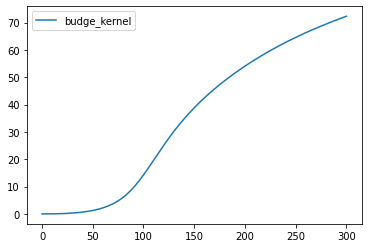

In [66]:
test_df.plot(y="budge_kernel")

### No pruning, training dynamics of a neural network for lr 0.1, mse loss, fc_cla_reg

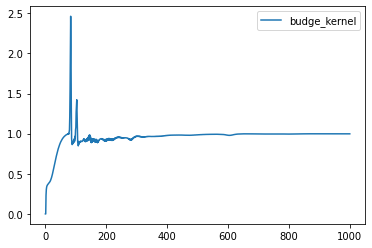

In [137]:
test_df.plot(y="budge_kernel")

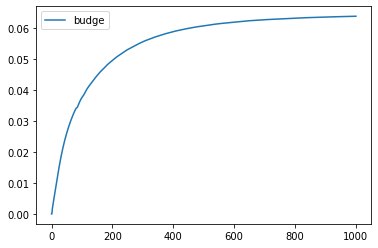

In [138]:
test_df.plot(y="budge")

# Pruning

In [14]:
def plot_and_save(col, width_metrics, width_list, pruner, title):
    plt.clf()
    fig, ax = plt.subplots()
    
    for m in width_list:
        res = width_metrics[m]
        res.plot(y=col, ax=ax, label="{} {}".format(pruner, m))
    fig.suptitle(col, fontsize=20)
    plt.xlabel('epoch', fontsize=18)
    plt.ylabel(col, fontsize=16)
    plt.savefig(title + " " + col)

In [62]:
def prune_train_loop(model_type, pruner, compression, prune_epochs, train_epochs, depth, width):
    args["optimizer"] = "momentum"
    args["compression"] = compression
    args["pruner"] = pruner
    args["model-type"] = model_type 
    args["prune_epochs"] = prune_epochs
    args["post_epochs"] = train_epochs
    args["depth"] = depth
    args["width"] = width
    
    post_result = prune_only(args)
    
    return post_result

In [90]:
prune_train_loop("fc_cla", "synflow", 1.0, 0, 10, 4, 10)

Pruning only
Loading mnist dataset.
Creating default-fc model.
Classification: Depth 4, Width 10, Scale 1


0it [00:00, ?it/s]
0it [00:00, ?it/s]

Pruning with synflow for 0 epochs.
Sparsity: 0.1
ERROR: 8140.0 prunable parameters remaining, expected 814.0
Parameter Sparsity: 8180/8180 (1.0000)
FLOP Sparsity: 8180/8180 (1.0000)



 10%|█         | 1/10 [00:02<00:26,  2.97s/it]

Epoch: 0 - metrics [2.1585089893341065, 1.8456954341888427, 42.36, 0]


 20%|██        | 2/10 [00:05<00:23,  2.96s/it]

Epoch: 1 - metrics [1.4339815561930338, 1.04956379404068, 67.03, 0.33472058]


 30%|███       | 3/10 [00:08<00:20,  2.97s/it]

Epoch: 2 - metrics [0.8861891474723816, 0.7347940007209778, 77.57, 0.5103023]


 40%|████      | 4/10 [00:11<00:17,  2.97s/it]

Epoch: 3 - metrics [0.6824489474932353, 0.5953148818016052, 81.86, 0.60772246]


 50%|█████     | 5/10 [00:14<00:14,  2.96s/it]

Epoch: 4 - metrics [0.5660224428653717, 0.5109249069690704, 84.67, 0.67552996]


 60%|██████    | 6/10 [00:17<00:11,  2.97s/it]

Epoch: 5 - metrics [0.49359833286603294, 0.4551978671550751, 86.44, 0.72842675]


 70%|███████   | 7/10 [00:20<00:08,  2.96s/it]

Epoch: 6 - metrics [0.44763276245594025, 0.4182689126014709, 87.43, 0.77102226]


 80%|████████  | 8/10 [00:23<00:05,  2.96s/it]

Epoch: 7 - metrics [0.4172444159348806, 0.40164906432628633, 88.03, 0.80560786]


 90%|█████████ | 9/10 [00:26<00:02,  2.96s/it]

Epoch: 8 - metrics [0.39479653935432435, 0.3743536623954773, 88.9, 0.8347225]


100%|██████████| 10/10 [00:29<00:00,  2.97s/it]

Epoch: 9 - metrics [0.3775202609062195, 0.35877442486286165, 89.42, 0.8603287]


,train_loss,test_loss,top1_accuracy,budge
0,NaN,2.322247,9.59,0.000000
1,2.158509,1.845695,42.36,0.000000
2,1.433982,1.049564,67.03,0.334721
3,0.886189,0.734794,77.57,0.510302
4,0.682449,0.595315,81.86,0.607722
5,0.566022,0.510925,84.67,0.675530
6,0.493598,0.455198,86.44,0.728427
7,0.447633,0.418269,87.43,0.771022
8,0.417244,0.401649,88.03,0.805608
9,0.394797,0.374354,88.90,0.834723


In [12]:
def pruner_multiple_widths_plot_loop(model_type, pruner, compression, prune_epochs, 
                                     train_epochs, depth, width_list, col_list, title=""):
    metrics = {}
    for width in width_list:
        res = prune_train_loop(model_type, pruner, compression, prune_epochs, train_epochs, depth, width)
        metrics[width] = res
    
    for metric_col in col_list:
        plot_and_save(metric_col, metrics, width_list, pruner, title)

Pruning only
Loading mnist dataset.
Creating default-fc model.
Classification: Depth 4, Width 10, Scale 1


0it [00:00, ?it/s]
  0%|          | 0/10 [00:00<?, ?it/s]

Pruning with synflow for 10 epochs.
Sparsity: 0.1


100%|██████████| 10/10 [00:01<00:00,  9.47it/s]

Parameter Sparsity: 853/8180 (0.1043)
FLOP Sparsity: 853/8180 (0.1043)



  2%|▏         | 1/50 [00:02<02:14,  2.74s/it]

Epoch: 0 - metrics [2.304030364735921, 2.285051507949829, 10.78, 0]


  4%|▍         | 2/50 [00:05<02:11,  2.73s/it]

Epoch: 1 - metrics [2.2446963227589927, 2.1858201694488524, 25.23, 0.14714335]


  6%|▌         | 3/50 [00:08<02:09,  2.75s/it]

Epoch: 2 - metrics [2.054203852844238, 1.9221399044036864, 27.43, 0.37682867]


  8%|▊         | 4/50 [00:10<02:06,  2.74s/it]

Epoch: 3 - metrics [1.78654009736379, 1.652192977142334, 45.35, 0.58018017]


 10%|█         | 5/50 [00:13<02:03,  2.74s/it]

Epoch: 4 - metrics [1.471872098350525, 1.3015370475769044, 55.87, 0.80423886]


 12%|█▏        | 6/50 [00:16<02:00,  2.73s/it]

Epoch: 5 - metrics [1.1920638600667317, 1.1029700645446778, 62.77, 0.9572433]


 14%|█▍        | 7/50 [00:19<01:56,  2.72s/it]

Epoch: 6 - metrics [1.0409370908737183, 0.9896877256393433, 66.57, 1.0550354]


 16%|█▌        | 8/50 [00:21<01:54,  2.73s/it]

Epoch: 7 - metrics [0.9566186644236246, 0.935399283027649, 68.0, 1.1170282]


 18%|█▊        | 9/50 [00:24<01:51,  2.72s/it]

Epoch: 8 - metrics [0.9117170198440552, 0.8990497014045715, 69.48, 1.1612935]


 20%|██        | 10/50 [00:27<01:48,  2.72s/it]

Epoch: 9 - metrics [0.8804283938090006, 0.8709450511932373, 70.57, 1.1980582]


 22%|██▏       | 11/50 [00:29<01:45,  2.71s/it]

Epoch: 10 - metrics [0.8537876244544983, 0.8434731324195862, 71.53, 1.2310246]


 24%|██▍       | 12/50 [00:32<01:43,  2.73s/it]

Epoch: 11 - metrics [0.8287067267100017, 0.8173308742523193, 73.01, 1.2605702]


 26%|██▌       | 13/50 [00:35<01:41,  2.75s/it]

Epoch: 12 - metrics [0.8057871351242065, 0.7949219667434693, 74.1, 1.2871462]


 28%|██▊       | 14/50 [00:38<01:38,  2.73s/it]

Epoch: 13 - metrics [0.7860124198913574, 0.774644366645813, 75.12, 1.3100501]


 30%|███       | 15/50 [00:40<01:35,  2.72s/it]

Epoch: 14 - metrics [0.7692551883061727, 0.7601749862670898, 75.65, 1.3307728]


 32%|███▏      | 16/50 [00:43<01:32,  2.71s/it]

Epoch: 15 - metrics [0.7551970480283101, 0.7470041358470917, 75.94, 1.3488829]


 34%|███▍      | 17/50 [00:46<01:29,  2.72s/it]

Epoch: 16 - metrics [0.7427445639610291, 0.736696205997467, 75.99, 1.366294]


 36%|███▌      | 18/50 [00:49<01:26,  2.71s/it]

Epoch: 17 - metrics [0.7321609926541647, 0.7260687895774841, 76.59, 1.3830532]


 38%|███▊      | 19/50 [00:51<01:23,  2.70s/it]

Epoch: 18 - metrics [0.7230636234601339, 0.7176553290843963, 77.04, 1.3991109]


 40%|████      | 20/50 [00:54<01:21,  2.73s/it]

Epoch: 19 - metrics [0.7142816329638163, 0.7118707097053528, 77.24, 1.4131298]


 42%|████▏     | 21/50 [00:57<01:19,  2.74s/it]

Epoch: 20 - metrics [0.7061205697059632, 0.7088935825347901, 77.26, 1.4279184]


 44%|████▍     | 22/50 [00:59<01:16,  2.73s/it]

Epoch: 21 - metrics [0.6987702703475952, 0.6967451745986939, 77.67, 1.4420141]


 46%|████▌     | 23/50 [01:02<01:13,  2.73s/it]

Epoch: 22 - metrics [0.6916528372446696, 0.6912939462661744, 77.95, 1.4555563]


 48%|████▊     | 24/50 [01:05<01:10,  2.73s/it]

Epoch: 23 - metrics [0.6856895389874776, 0.681822986459732, 78.54, 1.4691058]


 50%|█████     | 25/50 [01:08<01:08,  2.72s/it]

Epoch: 24 - metrics [0.6789735306104024, 0.6785372828483581, 78.72, 1.4822192]


 52%|█████▏    | 26/50 [01:10<01:05,  2.73s/it]

Epoch: 25 - metrics [0.6730534113248189, 0.6723120210647583, 78.97, 1.4943802]


 54%|█████▍    | 27/50 [01:13<01:02,  2.72s/it]

Epoch: 26 - metrics [0.6667624820550283, 0.6675637928962708, 79.12, 1.5078359]


 56%|█████▌    | 28/50 [01:16<01:00,  2.73s/it]

Epoch: 27 - metrics [0.6615410444577535, 0.6581732262611389, 79.73, 1.5204309]


 58%|█████▊    | 29/50 [01:19<00:57,  2.72s/it]

Epoch: 28 - metrics [0.6566443226496379, 0.6542593254566192, 79.9, 1.5330287]


 60%|██████    | 30/50 [01:21<00:54,  2.72s/it]

Epoch: 29 - metrics [0.6511921552975972, 0.647376397562027, 80.32, 1.5451483]


 62%|██████▏   | 31/50 [01:24<00:51,  2.72s/it]

Epoch: 30 - metrics [0.6467581704775492, 0.6420170928955078, 80.42, 1.5577708]


 64%|██████▍   | 32/50 [01:27<00:49,  2.72s/it]

Epoch: 31 - metrics [0.64212888824145, 0.6351064761161804, 80.62, 1.5693568]


 66%|██████▌   | 33/50 [01:29<00:46,  2.73s/it]

Epoch: 32 - metrics [0.6376926368395488, 0.6311189496994019, 80.8, 1.5811393]


 68%|██████▊   | 34/50 [01:32<00:43,  2.72s/it]

Epoch: 33 - metrics [0.633143261273702, 0.6256621458053588, 80.91, 1.5933232]


 70%|███████   | 35/50 [01:35<00:40,  2.72s/it]

Epoch: 34 - metrics [0.6290968288262685, 0.6202332312583924, 80.88, 1.6051093]


 72%|███████▏  | 36/50 [01:38<00:37,  2.71s/it]

Epoch: 35 - metrics [0.6250120609601338, 0.6195345659255982, 81.13, 1.6168411]


 74%|███████▍  | 37/50 [01:40<00:35,  2.70s/it]

Epoch: 36 - metrics [0.6207831773122152, 0.6115469902515411, 81.48, 1.6284356]


 76%|███████▌  | 38/50 [01:43<00:32,  2.69s/it]

Epoch: 37 - metrics [0.6169446943600972, 0.6054682092666626, 81.47, 1.6399988]


 78%|███████▊  | 39/50 [01:46<00:29,  2.71s/it]

Epoch: 38 - metrics [0.6133130717595419, 0.6052133134365082, 81.43, 1.6510854]


 80%|████████  | 40/50 [01:48<00:27,  2.70s/it]

Epoch: 39 - metrics [0.6096331733544668, 0.5982621786117553, 81.68, 1.6630179]


 82%|████████▏ | 41/50 [01:51<00:24,  2.70s/it]

Epoch: 40 - metrics [0.605346597290039, 0.5931749866008759, 81.8, 1.6745545]


 84%|████████▍ | 42/50 [01:54<00:21,  2.69s/it]

Epoch: 41 - metrics [0.6019748524347941, 0.5953509449958801, 81.71, 1.6860076]


 86%|████████▌ | 43/50 [01:56<00:18,  2.70s/it]

Epoch: 42 - metrics [0.5987734400431315, 0.5872393918514252, 81.92, 1.6976374]


 88%|████████▊ | 44/50 [01:59<00:16,  2.74s/it]

Epoch: 43 - metrics [0.5956221865653992, 0.5868460214614868, 82.06, 1.7081643]


 90%|█████████ | 45/50 [02:02<00:13,  2.73s/it]

Epoch: 44 - metrics [0.5922754446983337, 0.5816953313350678, 82.02, 1.7199014]


 92%|█████████▏| 46/50 [02:05<00:10,  2.72s/it]

Epoch: 45 - metrics [0.5891567783673605, 0.5833390940904617, 81.78, 1.7305996]


 94%|█████████▍| 47/50 [02:07<00:08,  2.71s/it]

Epoch: 46 - metrics [0.5859970500628153, 0.5754512376308442, 82.37, 1.7409351]


 96%|█████████▌| 48/50 [02:10<00:05,  2.74s/it]

Epoch: 47 - metrics [0.583040448363622, 0.569383424282074, 82.43, 1.751819]


 98%|█████████▊| 49/50 [02:13<00:02,  2.74s/it]

Epoch: 48 - metrics [0.5802042078653972, 0.5676086427211762, 82.6, 1.7626332]


100%|██████████| 50/50 [02:16<00:00,  2.72s/it]

Epoch: 49 - metrics [0.5776117407162984, 0.5659362597942352, 82.67, 1.773419]
Pruning only
Loading mnist dataset.
Creating default-fc model.
Classification: Depth 4, Width 100, Scale 1



0it [00:00, ?it/s]
  0%|          | 0/10 [00:00<?, ?it/s]

Pruning with synflow for 10 epochs.
Sparsity: 0.1


100%|██████████| 10/10 [00:01<00:00,  9.21it/s]

Parameter Sparsity: 10250/99710 (0.1028)
FLOP Sparsity: 10250/99710 (0.1028)



  2%|▏         | 1/50 [00:02<02:13,  2.72s/it]

Epoch: 0 - metrics [2.3021715237935383, 2.298246794128418, 11.35, 0]


  4%|▍         | 2/50 [00:05<02:12,  2.77s/it]

Epoch: 1 - metrics [2.2952072093963625, 2.2905802082061766, 11.35, 0.02066952]


  6%|▌         | 3/50 [00:08<02:09,  2.76s/it]

Epoch: 2 - metrics [2.2855427600860594, 2.2772500595092775, 13.02, 0.04706887]


  8%|▊         | 4/50 [00:11<02:07,  2.76s/it]

Epoch: 3 - metrics [2.265047477722168, 2.244817074584961, 24.93, 0.08721172]


 10%|█         | 5/50 [00:13<02:03,  2.75s/it]

Epoch: 4 - metrics [2.20574428024292, 2.137241431427002, 28.87, 0.15936959]


 12%|█▏        | 6/50 [00:16<02:00,  2.73s/it]

Epoch: 5 - metrics [2.0086117200215656, 1.8492182445526124, 31.03, 0.278079]


 14%|█▍        | 7/50 [00:19<01:57,  2.74s/it]

Epoch: 6 - metrics [1.692454730161031, 1.483139048576355, 54.99, 0.39664185]


 16%|█▌        | 8/50 [00:21<01:54,  2.73s/it]

Epoch: 7 - metrics [1.2707648040135702, 1.014609178829193, 70.15, 0.52422684]


 18%|█▊        | 9/50 [00:24<01:52,  2.74s/it]

Epoch: 8 - metrics [0.8925823109944662, 0.7433461135864258, 78.15, 0.6122012]


 20%|██        | 10/50 [00:27<01:49,  2.73s/it]

Epoch: 9 - metrics [0.7111974533081055, 0.6288059032440185, 81.1, 0.6632009]


 22%|██▏       | 11/50 [00:30<01:46,  2.74s/it]

Epoch: 10 - metrics [0.6239998789787292, 0.5673547102928161, 82.94, 0.6970877]


 24%|██▍       | 12/50 [00:32<01:44,  2.74s/it]

Epoch: 11 - metrics [0.5726548412958781, 0.5272322364807129, 84.05, 0.7217541]


 26%|██▌       | 13/50 [00:35<01:40,  2.73s/it]

Epoch: 12 - metrics [0.5359584620475769, 0.4970721630096436, 85.34, 0.7423348]


 28%|██▊       | 14/50 [00:38<01:39,  2.75s/it]

Epoch: 13 - metrics [0.506297468105952, 0.47294039254188536, 86.07, 0.7608356]


 30%|███       | 15/50 [00:41<01:35,  2.73s/it]

Epoch: 14 - metrics [0.48058881686528526, 0.45139312858581543, 86.64, 0.7781652]


 32%|███▏      | 16/50 [00:43<01:32,  2.73s/it]

Epoch: 15 - metrics [0.4582004606246948, 0.4317266471862793, 87.29, 0.7944691]


 34%|███▍      | 17/50 [00:46<01:29,  2.72s/it]

Epoch: 16 - metrics [0.43840001454353333, 0.41541789922714234, 87.74, 0.81000066]


 36%|███▌      | 18/50 [00:49<01:27,  2.72s/it]

Epoch: 17 - metrics [0.4205510969877243, 0.40182763662338256, 88.23, 0.8249609]


 38%|███▊      | 19/50 [00:52<01:25,  2.74s/it]

Epoch: 18 - metrics [0.4046675726890564, 0.385244747543335, 88.81, 0.8391011]


 40%|████      | 20/50 [00:54<01:22,  2.73s/it]

Epoch: 19 - metrics [0.39044336827596027, 0.3682948064804077, 89.4, 0.85221523]


 42%|████▏     | 21/50 [00:57<01:18,  2.72s/it]

Epoch: 20 - metrics [0.3775882661819458, 0.35676917552947995, 89.59, 0.86503124]


 44%|████▍     | 22/50 [01:00<01:16,  2.73s/it]

Epoch: 21 - metrics [0.3659985261917114, 0.3476788474559784, 89.9, 0.87712526]


 46%|████▌     | 23/50 [01:02<01:13,  2.73s/it]

Epoch: 22 - metrics [0.3555922883192698, 0.34216662302017214, 89.94, 0.8885361]


 48%|████▊     | 24/50 [01:05<01:11,  2.74s/it]

Epoch: 23 - metrics [0.34561620045502983, 0.3291717810630798, 90.22, 0.8996302]


 50%|█████     | 25/50 [01:08<01:08,  2.75s/it]

Epoch: 24 - metrics [0.3368905488570531, 0.3198251215457916, 90.49, 0.9100659]


 52%|█████▏    | 26/50 [01:11<01:05,  2.73s/it]

Epoch: 25 - metrics [0.32842832663853966, 0.3131133051395416, 90.72, 0.9202902]


 54%|█████▍    | 27/50 [01:13<01:02,  2.73s/it]

Epoch: 26 - metrics [0.32092301270167034, 0.30518895454406736, 90.94, 0.93006146]


 56%|█████▌    | 28/50 [01:16<00:59,  2.72s/it]

Epoch: 27 - metrics [0.3137135490099589, 0.29814346361160277, 91.08, 0.93934155]


 58%|█████▊    | 29/50 [01:19<00:57,  2.73s/it]

Epoch: 28 - metrics [0.3068218992630641, 0.2954862019538879, 91.13, 0.9484434]


 60%|██████    | 30/50 [01:22<00:54,  2.72s/it]

Epoch: 29 - metrics [0.30050537235736846, 0.2885316014766693, 91.18, 0.95712084]


 62%|██████▏   | 31/50 [01:24<00:51,  2.72s/it]

Epoch: 30 - metrics [0.29457390066782635, 0.28129396772384646, 91.34, 0.9657334]


 64%|██████▍   | 32/50 [01:27<00:49,  2.72s/it]

Epoch: 31 - metrics [0.28904413202603657, 0.27680317273139954, 91.46, 0.9739947]


 66%|██████▌   | 33/50 [01:30<00:46,  2.73s/it]

Epoch: 32 - metrics [0.283673543938001, 0.2726286192893982, 91.66, 0.98171335]


 68%|██████▊   | 34/50 [01:33<00:43,  2.74s/it]

Epoch: 33 - metrics [0.2787704904953639, 0.2672515491485596, 91.72, 0.9893296]


 70%|███████   | 35/50 [01:35<00:41,  2.74s/it]

Epoch: 34 - metrics [0.27403943350315096, 0.2633237288951874, 91.77, 0.9969095]


 72%|███████▏  | 36/50 [01:38<00:38,  2.73s/it]

Epoch: 35 - metrics [0.26952703659534455, 0.2591694534301758, 91.89, 1.0041876]


 74%|███████▍  | 37/50 [01:41<00:35,  2.72s/it]

Epoch: 36 - metrics [0.26517551939487455, 0.2566973865509033, 92.04, 1.011384]


 76%|███████▌  | 38/50 [01:43<00:32,  2.73s/it]

Epoch: 37 - metrics [0.26098855936527254, 0.25158034386634825, 92.3, 1.0183033]


 78%|███████▊  | 39/50 [01:46<00:30,  2.73s/it]

Epoch: 38 - metrics [0.2572198947548866, 0.24838571333885193, 92.55, 1.0249034]


 80%|████████  | 40/50 [01:49<00:27,  2.75s/it]

Epoch: 39 - metrics [0.2534097295284271, 0.24662723512649537, 92.49, 1.031501]


 82%|████████▏ | 41/50 [01:52<00:24,  2.74s/it]

Epoch: 40 - metrics [0.25023043823242186, 0.24183310465812682, 92.65, 1.0377964]


 84%|████████▍ | 42/50 [01:54<00:21,  2.74s/it]

Epoch: 41 - metrics [0.246708707733949, 0.24066670837402343, 92.61, 1.043926]


 86%|████████▌ | 43/50 [01:57<00:19,  2.73s/it]

Epoch: 42 - metrics [0.2436605190674464, 0.23768519043922423, 92.69, 1.0498887]


 88%|████████▊ | 44/50 [02:00<00:16,  2.74s/it]

Epoch: 43 - metrics [0.24050634820461272, 0.23508989434242247, 92.82, 1.0557013]


 90%|█████████ | 45/50 [02:03<00:13,  2.75s/it]

Epoch: 44 - metrics [0.23757121670246123, 0.23077231969833373, 92.96, 1.0614222]


 92%|█████████▏| 46/50 [02:05<00:10,  2.75s/it]

Epoch: 45 - metrics [0.23511007662614186, 0.22894937467575074, 93.04, 1.0670046]


 94%|█████████▍| 47/50 [02:08<00:08,  2.75s/it]

Epoch: 46 - metrics [0.23220855519771577, 0.2292658395767212, 92.95, 1.0724479]


 96%|█████████▌| 48/50 [02:11<00:05,  2.73s/it]

Epoch: 47 - metrics [0.2297193822145462, 0.22461332640647888, 93.21, 1.0778137]


 98%|█████████▊| 49/50 [02:14<00:02,  2.76s/it]

Epoch: 48 - metrics [0.2273929749329885, 0.22270611963272094, 93.22, 1.0829403]


100%|██████████| 50/50 [02:16<00:00,  2.74s/it]

Epoch: 49 - metrics [0.224915911924839, 0.2219835286140442, 93.12, 1.0881191]
Pruning only
Loading mnist dataset.
Creating default-fc model.
Classification: Depth 4, Width 1000, Scale 1



0it [00:00, ?it/s]
  0%|          | 0/10 [00:00<?, ?it/s]

Pruning with synflow for 10 epochs.
Sparsity: 0.1


100%|██████████| 10/10 [00:01<00:00,  8.07it/s]

Parameter Sparsity: 282410/2797010 (0.1010)
FLOP Sparsity: 282410/2797010 (0.1010)



  2%|▏         | 1/50 [00:02<02:13,  2.72s/it]

Epoch: 0 - metrics [2.298046372731527, 2.291727461242676, 21.28, 0]


  4%|▍         | 2/50 [00:05<02:11,  2.73s/it]

Epoch: 1 - metrics [2.284289962132772, 2.2740245140075683, 30.81, 0.013176002]


  6%|▌         | 3/50 [00:08<02:09,  2.76s/it]

Epoch: 2 - metrics [2.2583322416941325, 2.2339141956329347, 45.19, 0.032542653]


  8%|▊         | 4/50 [00:11<02:07,  2.77s/it]

Epoch: 3 - metrics [2.182750354639689, 2.09443688583374, 47.59, 0.067818016]


 10%|█         | 5/50 [00:13<02:04,  2.78s/it]

Epoch: 4 - metrics [1.8957898111979166, 1.6092684848785401, 57.45, 0.13349245]


 12%|█▏        | 6/50 [00:16<02:01,  2.76s/it]

Epoch: 5 - metrics [1.306436847368876, 1.0254730522155762, 73.57, 0.20308247]


 14%|█▍        | 7/50 [00:19<01:57,  2.74s/it]

Epoch: 6 - metrics [0.8812540218353272, 0.7406454152107239, 79.79, 0.246115]


 16%|█▌        | 8/50 [00:22<01:55,  2.74s/it]

Epoch: 7 - metrics [0.6771216510136923, 0.5974087889671326, 83.0, 0.2732472]


 18%|█▊        | 9/50 [00:24<01:52,  2.75s/it]

Epoch: 8 - metrics [0.564196287727356, 0.5093190668582916, 85.48, 0.2921283]


 20%|██        | 10/50 [00:27<01:50,  2.76s/it]

Epoch: 9 - metrics [0.4926270165125529, 0.44996041593551633, 86.84, 0.30631968]


 22%|██▏       | 11/50 [00:30<01:47,  2.76s/it]

Epoch: 10 - metrics [0.4444982096195221, 0.4126881811618805, 87.95, 0.31759757]


 24%|██▍       | 12/50 [00:33<01:45,  2.76s/it]

Epoch: 11 - metrics [0.41029975876808167, 0.3829409737586975, 88.79, 0.32670698]


 26%|██▌       | 13/50 [00:35<01:42,  2.77s/it]

Epoch: 12 - metrics [0.3849438325881958, 0.3626049425125122, 89.36, 0.33429876]


 28%|██▊       | 14/50 [00:38<01:39,  2.76s/it]

Epoch: 13 - metrics [0.36555089203516644, 0.3487900284290314, 89.9, 0.34091938]


 30%|███       | 15/50 [00:41<01:36,  2.76s/it]

Epoch: 14 - metrics [0.34958412454922994, 0.33165731525421144, 90.39, 0.3468906]


 32%|███▏      | 16/50 [00:44<01:33,  2.76s/it]

Epoch: 15 - metrics [0.3362952359120051, 0.319578381729126, 90.75, 0.35230213]


 34%|███▍      | 17/50 [00:46<01:31,  2.76s/it]

Epoch: 16 - metrics [0.3244743547598521, 0.31027668161392213, 90.99, 0.3573552]


 36%|███▌      | 18/50 [00:49<01:28,  2.77s/it]

Epoch: 17 - metrics [0.31394692198435464, 0.29998470830917356, 91.38, 0.36208934]


 38%|███▊      | 19/50 [00:52<01:25,  2.76s/it]

Epoch: 18 - metrics [0.30413770719369254, 0.2910300660610199, 91.55, 0.36672792]


 40%|████      | 20/50 [00:55<01:22,  2.77s/it]

Epoch: 19 - metrics [0.2948811053276062, 0.28383687710762023, 91.78, 0.3713131]


 42%|████▏     | 21/50 [00:57<01:19,  2.76s/it]

Epoch: 20 - metrics [0.28622109135786694, 0.27588002462387085, 91.99, 0.37576547]


 44%|████▍     | 22/50 [01:00<01:17,  2.75s/it]

Epoch: 21 - metrics [0.27765318637688957, 0.2681956283569336, 92.23, 0.38020507]


 46%|████▌     | 23/50 [01:03<01:14,  2.76s/it]

Epoch: 22 - metrics [0.26964318001270293, 0.26263714766502383, 92.47, 0.3846231]


 48%|████▊     | 24/50 [01:06<01:11,  2.74s/it]

Epoch: 23 - metrics [0.26160850768884025, 0.2535388979911804, 92.52, 0.38904092]


 50%|█████     | 25/50 [01:08<01:08,  2.73s/it]

Epoch: 24 - metrics [0.2540327013492584, 0.24686119723320007, 92.75, 0.39340594]


 52%|█████▏    | 26/50 [01:11<01:05,  2.74s/it]

Epoch: 25 - metrics [0.24660081049601237, 0.23950686311721803, 93.12, 0.3977451]


 54%|█████▍    | 27/50 [01:14<01:02,  2.73s/it]

Epoch: 26 - metrics [0.2395533001422882, 0.23394590516090394, 93.15, 0.4020446]


 56%|█████▌    | 28/50 [01:17<01:00,  2.77s/it]

Epoch: 27 - metrics [0.23274448938369752, 0.22695139951705934, 93.35, 0.4062587]


 58%|█████▊    | 29/50 [01:19<00:57,  2.76s/it]

Epoch: 28 - metrics [0.22625394122600556, 0.22152242789268495, 93.63, 0.41051626]


 60%|██████    | 30/50 [01:22<00:55,  2.76s/it]

Epoch: 29 - metrics [0.21987967741489411, 0.21587236833572387, 93.69, 0.4147154]


 62%|██████▏   | 31/50 [01:25<00:52,  2.75s/it]

Epoch: 30 - metrics [0.21367786670128505, 0.2122055380821228, 93.76, 0.41887686]


 64%|██████▍   | 32/50 [01:28<00:49,  2.75s/it]

Epoch: 31 - metrics [0.20789721606175104, 0.20690716276168825, 94.01, 0.42299944]


 66%|██████▌   | 33/50 [01:31<00:47,  2.77s/it]

Epoch: 32 - metrics [0.20222656519412993, 0.20167544174194335, 94.11, 0.42702946]


 68%|██████▊   | 34/50 [01:33<00:44,  2.76s/it]

Epoch: 33 - metrics [0.19697003270785013, 0.19458745155334473, 94.33, 0.43102562]


 70%|███████   | 35/50 [01:36<00:41,  2.77s/it]

Epoch: 34 - metrics [0.19174086449543634, 0.1913538803577423, 94.41, 0.43495467]


 72%|███████▏  | 36/50 [01:39<00:38,  2.78s/it]

Epoch: 35 - metrics [0.18675422270298003, 0.18640184965133666, 94.55, 0.43885008]


 74%|███████▍  | 37/50 [01:42<00:36,  2.78s/it]

Epoch: 36 - metrics [0.18200286868015925, 0.18172825918197633, 94.59, 0.44267002]


 76%|███████▌  | 38/50 [01:44<00:33,  2.78s/it]

Epoch: 37 - metrics [0.1776292311390241, 0.17838789386749268, 94.67, 0.44638243]


 78%|███████▊  | 39/50 [01:47<00:30,  2.76s/it]

Epoch: 38 - metrics [0.1731752983848254, 0.17424484429359435, 94.82, 0.45005828]


 80%|████████  | 40/50 [01:50<00:27,  2.74s/it]

Epoch: 39 - metrics [0.168970119480292, 0.1721173002719879, 94.78, 0.45368454]


 82%|████████▏ | 41/50 [01:53<00:24,  2.74s/it]

Epoch: 40 - metrics [0.16510383174419402, 0.1673734496116638, 95.02, 0.45723358]


 84%|████████▍ | 42/50 [01:55<00:22,  2.75s/it]

Epoch: 41 - metrics [0.16105458865563074, 0.1638915521621704, 95.07, 0.46074164]


 86%|████████▌ | 43/50 [01:58<00:19,  2.76s/it]

Epoch: 42 - metrics [0.1573741865237554, 0.16143319535255432, 95.14, 0.46418518]


 88%|████████▊ | 44/50 [02:01<00:16,  2.76s/it]

Epoch: 43 - metrics [0.15394941124518713, 0.15808938970565795, 95.29, 0.46755874]


 90%|█████████ | 45/50 [02:04<00:13,  2.75s/it]

Epoch: 44 - metrics [0.1505071656982104, 0.15621426553726198, 95.3, 0.47086585]


 92%|█████████▏| 46/50 [02:06<00:11,  2.75s/it]

Epoch: 45 - metrics [0.1473450468579928, 0.1532071575641632, 95.48, 0.47410378]


 94%|█████████▍| 47/50 [02:09<00:08,  2.75s/it]

Epoch: 46 - metrics [0.1440902021487554, 0.14925181074142457, 95.5, 0.47733232]


 96%|█████████▌| 48/50 [02:12<00:05,  2.78s/it]

Epoch: 47 - metrics [0.14120676681995392, 0.14720522332191469, 95.56, 0.4804913]


 98%|█████████▊| 49/50 [02:15<00:02,  2.77s/it]

Epoch: 48 - metrics [0.13823722883462905, 0.14548112382888795, 95.69, 0.4836122]


100%|██████████| 50/50 [02:17<00:00,  2.76s/it]

Epoch: 49 - metrics [0.1352464977343877, 0.1434213750362396, 95.77, 0.48669535]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

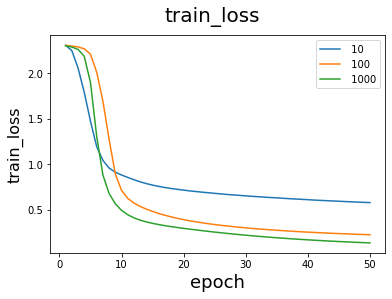

In [37]:
pruner_multiple_widths_plot_loop("fc_cla", "synflow", 1.0, 10, 50, 4, [10, 100, 1000], ["budge", "train_loss"])

Pruning only
Loading mnist dataset.
Creating default-fc model.
Classification: Depth 4, Width 10, Scale 1
Regression: Depth 4, Width 10, Scale 1
Regression: Depth 4, Width 10, Scale 1
Using MSE Loss


0it [00:00, ?it/s]
0it [00:00, ?it/s]

Pruning with synflow for 0 epochs.
Sparsity: 0.1
ERROR: 8050.0 prunable parameters remaining, expected 805.0
Parameter Sparsity: 8081/8081 (1.0000)
FLOP Sparsity: 8081/8081 (1.0000)



  0%|          | 0/50 [00:00<?, ?it/s]/home/udit/anaconda3/envs/synflow-py3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/udit/anaconda3/envs/synflow-py3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  2%|▏         | 1/50 [00:02<02:12,  2.70s/it]

Epoch: 0 - metrics [8.73537456665039, 8.357600820922851, 0.0, 0]


  4%|▍         | 2/50 [00:05<02:10,  2.71s/it]

Epoch: 1 - metrics [8.413016287740072, 8.308623318481445, 0.0, 0.048330322]


  6%|▌         | 3/50 [00:08<02:07,  2.72s/it]

Epoch: 2 - metrics [8.397183764139811, 8.493478820800782, 0.0, 0.0822768]


  8%|▊         | 4/50 [00:10<02:06,  2.74s/it]

Epoch: 3 - metrics [8.38264977645874, 8.439541572570802, 0.0, 0.10810445]


 10%|█         | 5/50 [00:13<02:02,  2.73s/it]

Epoch: 4 - metrics [8.388000073242187, 8.305189984130859, 0.0, 0.1320685]


 12%|█▏        | 6/50 [00:16<01:59,  2.73s/it]

Epoch: 5 - metrics [8.385107356770833, 8.440311656188966, 0.0, 0.15575002]


 14%|█▍        | 7/50 [00:19<01:57,  2.73s/it]

Epoch: 6 - metrics [8.377281107584636, 8.301407299041749, 0.0, 0.17460062]


 16%|█▌        | 8/50 [00:21<01:54,  2.73s/it]

Epoch: 7 - metrics [8.378872279866536, 8.359741033935547, 0.0, 0.19502862]


 18%|█▊        | 9/50 [00:24<01:51,  2.72s/it]

Epoch: 8 - metrics [8.37590813700358, 8.302642112731933, 0.0, 0.21476232]


 20%|██        | 10/50 [00:27<01:49,  2.73s/it]

Epoch: 9 - metrics [8.370633542378744, 8.253628035736083, 0.0, 0.23152857]


 22%|██▏       | 11/50 [00:29<01:45,  2.71s/it]

Epoch: 10 - metrics [8.370234169514974, 8.236764444732666, 0.0, 0.24819182]


 24%|██▍       | 12/50 [00:32<01:42,  2.71s/it]

Epoch: 11 - metrics [8.364656799316407, 8.234492432403565, 0.0, 0.26385197]


 26%|██▌       | 13/50 [00:35<01:40,  2.71s/it]

Epoch: 12 - metrics [8.367122969055176, 8.359063923645019, 0.0, 0.2808281]


 28%|██▊       | 14/50 [00:38<01:37,  2.72s/it]

Epoch: 13 - metrics [8.36387634379069, 8.272499809265137, 0.0, 0.29497305]


 30%|███       | 15/50 [00:40<01:35,  2.73s/it]

Epoch: 14 - metrics [8.362814437357585, 8.23658225250244, 0.0, 0.30945987]


 32%|███▏      | 16/50 [00:43<01:32,  2.71s/it]

Epoch: 15 - metrics [8.359867751057942, 8.224806021881104, 0.0, 0.32448402]


 34%|███▍      | 17/50 [00:46<01:30,  2.74s/it]

Epoch: 16 - metrics [8.359553558858236, 8.214510221862794, 0.0, 0.3383498]


 36%|███▌      | 18/50 [00:49<01:27,  2.74s/it]

Epoch: 17 - metrics [8.360444462076822, 8.22829076461792, 0.0, 0.352463]


 38%|███▊      | 19/50 [00:51<01:24,  2.73s/it]

Epoch: 18 - metrics [8.358957120259603, 8.259329963684083, 0.0, 0.36390886]


 40%|████      | 20/50 [00:54<01:21,  2.72s/it]

Epoch: 19 - metrics [8.355911489359539, 8.23102152633667, 0.0, 0.3761125]


 42%|████▏     | 21/50 [00:57<01:18,  2.72s/it]

Epoch: 20 - metrics [8.358307372792561, 8.242162060546875, 0.0, 0.38848597]


 44%|████▍     | 22/50 [00:59<01:15,  2.71s/it]

Epoch: 21 - metrics [8.356503170267741, 8.224493708801269, 0.0, 0.39851326]


 46%|████▌     | 23/50 [01:02<01:13,  2.71s/it]

Epoch: 22 - metrics [8.35438803583781, 8.24472901763916, 0.0, 0.4073474]


 48%|████▊     | 24/50 [01:05<01:10,  2.71s/it]

Epoch: 23 - metrics [8.355319180806477, 8.248888304138184, 0.0, 0.41586927]


 50%|█████     | 25/50 [01:08<01:08,  2.73s/it]

Epoch: 24 - metrics [8.353551559448242, 8.250962509155274, 0.0, 0.42426252]


 52%|█████▏    | 26/50 [01:10<01:05,  2.72s/it]

Epoch: 25 - metrics [8.354829177347819, 8.281727645874023, 0.0, 0.42980647]


 54%|█████▍    | 27/50 [01:13<01:02,  2.70s/it]

Epoch: 26 - metrics [8.35251225535075, 8.260239503479005, 0.0, 0.4388928]


 56%|█████▌    | 28/50 [01:16<00:59,  2.69s/it]

Epoch: 27 - metrics [8.352180729166667, 8.267100981140137, 0.0, 0.44358832]


 58%|█████▊    | 29/50 [01:18<00:56,  2.70s/it]

Epoch: 28 - metrics [8.350700203959146, 8.259317884063721, 0.0, 0.4498218]


 60%|██████    | 30/50 [01:21<00:54,  2.71s/it]

Epoch: 29 - metrics [8.351205347188314, 8.268248742675782, 0.0, 0.45452505]


 62%|██████▏   | 31/50 [01:24<00:51,  2.70s/it]

Epoch: 30 - metrics [8.352396919250488, 8.2462130569458, 0.0, 0.46167207]


 64%|██████▍   | 32/50 [01:26<00:48,  2.70s/it]

Epoch: 31 - metrics [8.351732136535645, 8.248541752624512, 0.0, 0.46522275]


 66%|██████▌   | 33/50 [01:29<00:46,  2.71s/it]

Epoch: 32 - metrics [8.351061248270671, 8.308764143371581, 0.0, 0.4639367]


 68%|██████▊   | 34/50 [01:32<00:43,  2.71s/it]

Epoch: 33 - metrics [8.351659816996257, 8.2500986328125, 0.0, 0.47290224]


 70%|███████   | 35/50 [01:35<00:40,  2.71s/it]

Epoch: 34 - metrics [8.350370469665528, 8.26026707611084, 0.0, 0.47947878]


 72%|███████▏  | 36/50 [01:37<00:38,  2.72s/it]

Epoch: 35 - metrics [8.351251315307618, 8.256256680297852, 0.0, 0.4796123]


 74%|███████▍  | 37/50 [01:40<00:35,  2.74s/it]

Epoch: 36 - metrics [8.35008737894694, 8.250877957153321, 0.0, 0.48802236]


 76%|███████▌  | 38/50 [01:43<00:32,  2.73s/it]

Epoch: 37 - metrics [8.35128288523356, 8.25116753768921, 0.0, 0.49029747]


 78%|███████▊  | 39/50 [01:46<00:29,  2.72s/it]

Epoch: 38 - metrics [8.350931180826823, 8.257208139038086, 0.0, 0.4892201]


 80%|████████  | 40/50 [01:48<00:27,  2.72s/it]

Epoch: 39 - metrics [8.350427969360352, 8.240525723266602, 0.0, 0.49788368]


 82%|████████▏ | 41/50 [01:51<00:24,  2.71s/it]

Epoch: 40 - metrics [8.351450563049317, 8.236777325439453, 0.0, 0.49626058]


 84%|████████▍ | 42/50 [01:54<00:21,  2.72s/it]

Epoch: 41 - metrics [8.35075730717977, 8.254643927001952, 0.0, 0.49822208]


 86%|████████▌ | 43/50 [01:56<00:19,  2.72s/it]

Epoch: 42 - metrics [8.349967678324381, 8.246835035705566, 0.0, 0.5021332]


 88%|████████▊ | 44/50 [01:59<00:16,  2.71s/it]

Epoch: 43 - metrics [8.350458731587727, 8.243607670593262, 0.0, 0.50873184]


 90%|█████████ | 45/50 [02:02<00:13,  2.73s/it]

Epoch: 44 - metrics [8.34949741160075, 8.249130654907226, 0.0, 0.5075035]


 92%|█████████▏| 46/50 [02:05<00:10,  2.73s/it]

Epoch: 45 - metrics [8.347616893513997, 8.26567254638672, 0.0, 0.50510526]


 94%|█████████▍| 47/50 [02:07<00:08,  2.71s/it]

Epoch: 46 - metrics [8.350958137512206, 8.244293154144287, 0.0, 0.51062334]


 96%|█████████▌| 48/50 [02:10<00:05,  2.72s/it]

Epoch: 47 - metrics [8.349700815327962, 8.23653016357422, 0.0, 0.51711047]


 98%|█████████▊| 49/50 [02:13<00:02,  2.73s/it]

Epoch: 48 - metrics [8.351108242034913, 8.233996626281739, 0.0, 0.5179744]


100%|██████████| 50/50 [02:15<00:00,  2.72s/it]

Epoch: 49 - metrics [8.349893167877198, 8.254997730255127, 0.0, 0.5162673]
Pruning only
Loading mnist dataset.
Creating default-fc model.
Classification: Depth 4, Width 100, Scale 1
Regression: Depth 4, Width 100, Scale 1
Regression: Depth 4, Width 100, Scale 1
Using MSE Loss



0it [00:00, ?it/s]
0it [00:00, ?it/s]

Pruning with synflow for 0 epochs.
Sparsity: 0.1
ERROR: 98500.0 prunable parameters remaining, expected 9850.0
Parameter Sparsity: 98801/98801 (1.0000)
FLOP Sparsity: 98801/98801 (1.0000)



  2%|▏         | 1/50 [00:02<02:13,  2.72s/it]

Epoch: 0 - metrics [8.77329327392578, 8.680685684204102, 0.0, 0]


  4%|▍         | 2/50 [00:05<02:10,  2.72s/it]

Epoch: 1 - metrics [8.424176733398438, 8.335454524993896, 0.0, 0.021077676]


  6%|▌         | 3/50 [00:08<02:07,  2.72s/it]

Epoch: 2 - metrics [8.4193163327535, 8.527028300476074, 0.0, 0.033637132]


  8%|▊         | 4/50 [00:10<02:05,  2.72s/it]

Epoch: 3 - metrics [8.40563513844808, 8.203256733703613, 0.0, 0.04332892]


 10%|█         | 5/50 [00:13<02:03,  2.74s/it]

Epoch: 4 - metrics [8.40460033976237, 8.268297196960448, 0.0, 0.05300376]


 12%|█▏        | 6/50 [00:16<02:00,  2.74s/it]

Epoch: 5 - metrics [8.402818135579427, 8.178686298370362, 0.0, 0.062040817]


 14%|█▍        | 7/50 [00:19<01:56,  2.72s/it]

Epoch: 6 - metrics [8.396589207967123, 8.32978691253662, 0.0, 0.07043369]


 16%|█▌        | 8/50 [00:21<01:53,  2.71s/it]

Epoch: 7 - metrics [8.390990038553873, 8.218930042266846, 0.0, 0.07808307]


 18%|█▊        | 9/50 [00:24<01:51,  2.73s/it]

Epoch: 8 - metrics [8.384301051330567, 8.266568237304687, 0.0, 0.08580366]


 20%|██        | 10/50 [00:27<01:48,  2.72s/it]

Epoch: 9 - metrics [8.38093975982666, 8.229905683898926, 0.0, 0.09228566]


 22%|██▏       | 11/50 [00:29<01:46,  2.73s/it]

Epoch: 10 - metrics [8.381097533162436, 8.273420893859864, 0.0, 0.098598495]


 24%|██▍       | 12/50 [00:32<01:43,  2.73s/it]

Epoch: 11 - metrics [8.379442630767823, 8.313532571411132, 0.0, 0.10581901]


 26%|██▌       | 13/50 [00:35<01:40,  2.72s/it]

Epoch: 12 - metrics [8.377625472513834, 8.267380502319336, 0.0, 0.11104034]


 28%|██▊       | 14/50 [00:38<01:37,  2.72s/it]

Epoch: 13 - metrics [8.380801600646972, 8.302873582458496, 0.0, 0.11826864]


 30%|███       | 15/50 [00:40<01:34,  2.70s/it]

Epoch: 14 - metrics [8.373237401835123, 8.286565184783935, 0.0, 0.12364173]


 32%|███▏      | 16/50 [00:43<01:31,  2.70s/it]

Epoch: 15 - metrics [8.369705055236816, 8.234404449462891, 0.0, 0.1286185]


 34%|███▍      | 17/50 [00:46<01:29,  2.71s/it]

Epoch: 16 - metrics [8.3685089747111, 8.200820905303955, 0.0, 0.13453455]


 36%|███▌      | 18/50 [00:48<01:27,  2.72s/it]

Epoch: 17 - metrics [8.368299864705403, 8.18491913986206, 0.0, 0.13967626]


 38%|███▊      | 19/50 [00:51<01:24,  2.72s/it]

Epoch: 18 - metrics [8.366431095377605, 8.180162114715577, 0.0, 0.1449893]


 40%|████      | 20/50 [00:54<01:21,  2.70s/it]

Epoch: 19 - metrics [8.36402241007487, 8.21532456970215, 0.0, 0.15012483]


 42%|████▏     | 21/50 [00:57<01:18,  2.71s/it]

Epoch: 20 - metrics [8.364662897237142, 8.546786572265624, 0.0, 0.15651727]


 44%|████▍     | 22/50 [00:59<01:16,  2.73s/it]

Epoch: 21 - metrics [8.364837818400066, 8.248415185546875, 0.0, 0.16093545]


 46%|████▌     | 23/50 [01:02<01:13,  2.73s/it]

Epoch: 22 - metrics [8.361172104390462, 8.199485997009278, 0.0, 0.16501185]


 48%|████▊     | 24/50 [01:05<01:11,  2.73s/it]

Epoch: 23 - metrics [8.360227391052247, 8.20646233291626, 0.0, 0.1696441]


 50%|█████     | 25/50 [01:08<01:08,  2.73s/it]

Epoch: 24 - metrics [8.357745815022787, 8.288863374328614, 0.0, 0.17314498]


 52%|█████▏    | 26/50 [01:10<01:05,  2.72s/it]

Epoch: 25 - metrics [8.35435176595052, 8.302924039459228, 0.0, 0.17716506]


 54%|█████▍    | 27/50 [01:13<01:02,  2.72s/it]

Epoch: 26 - metrics [8.356237186686197, 8.227325299072266, 0.0, 0.18186046]


 56%|█████▌    | 28/50 [01:16<01:00,  2.74s/it]

Epoch: 27 - metrics [8.358011986796061, 8.167055281066894, 0.0, 0.18663977]


 58%|█████▊    | 29/50 [01:18<00:57,  2.73s/it]

Epoch: 28 - metrics [8.356205902608236, 8.217476702880859, 0.0, 0.18999134]


 60%|██████    | 30/50 [01:21<00:54,  2.74s/it]

Epoch: 29 - metrics [8.356969950866699, 8.16718784866333, 0.0, 0.19412838]


 62%|██████▏   | 31/50 [01:24<00:51,  2.73s/it]

Epoch: 30 - metrics [8.356626514180501, 8.201593601989746, 0.0, 0.19704576]


 64%|██████▍   | 32/50 [01:27<00:48,  2.72s/it]

Epoch: 31 - metrics [8.352839110819499, 8.222796444702148, 0.0, 0.20039652]


 66%|██████▌   | 33/50 [01:29<00:46,  2.72s/it]

Epoch: 32 - metrics [8.352911536661784, 8.203364834594726, 0.0, 0.20366319]


 68%|██████▊   | 34/50 [01:32<00:43,  2.70s/it]

Epoch: 33 - metrics [8.352900527445476, 8.20158023223877, 0.0, 0.20612492]


 70%|███████   | 35/50 [01:35<00:40,  2.72s/it]

Epoch: 34 - metrics [8.352331500752767, 8.190945904541016, 0.0, 0.21010078]


 72%|███████▏  | 36/50 [01:38<00:38,  2.73s/it]

Epoch: 35 - metrics [8.351535471089681, 8.195285552215577, 0.0, 0.21106306]


 74%|███████▍  | 37/50 [01:40<00:35,  2.74s/it]

Epoch: 36 - metrics [8.351276569112143, 8.2218115234375, 0.0, 0.21268152]


 76%|███████▌  | 38/50 [01:43<00:32,  2.75s/it]

Epoch: 37 - metrics [8.350950336710612, 8.214958905029297, 0.0, 0.21471342]


 78%|███████▊  | 39/50 [01:46<00:30,  2.75s/it]

Epoch: 38 - metrics [8.350366320292155, 8.208656741333007, 0.0, 0.21832155]


 80%|████████  | 40/50 [01:49<00:27,  2.74s/it]

Epoch: 39 - metrics [8.349695558166504, 8.227984712982177, 0.0, 0.21852857]


 82%|████████▏ | 41/50 [01:51<00:24,  2.74s/it]

Epoch: 40 - metrics [8.351203180440267, 8.221461367034912, 0.0, 0.22047547]


 84%|████████▍ | 42/50 [01:54<00:21,  2.72s/it]

Epoch: 41 - metrics [8.350940445454915, 8.22066550140381, 0.0, 0.22376709]


 86%|████████▌ | 43/50 [01:57<00:19,  2.73s/it]

Epoch: 42 - metrics [8.351149886830648, 8.22739294281006, 0.0, 0.22299069]


 88%|████████▊ | 44/50 [01:59<00:16,  2.72s/it]

Epoch: 43 - metrics [8.349883209228516, 8.216965084075929, 0.0, 0.2237851]


 90%|█████████ | 45/50 [02:02<00:13,  2.73s/it]

Epoch: 44 - metrics [8.349924113464356, 8.256743031311036, 0.0, 0.2236726]


 92%|█████████▏| 46/50 [02:05<00:10,  2.72s/it]

Epoch: 45 - metrics [8.349797780354818, 8.229432469177246, 0.0, 0.22648072]


 94%|█████████▍| 47/50 [02:08<00:08,  2.73s/it]

Epoch: 46 - metrics [8.350039948527018, 8.209682038879395, 0.0, 0.22802158]


 96%|█████████▌| 48/50 [02:10<00:05,  2.73s/it]

Epoch: 47 - metrics [8.350683399454752, 8.216782043457032, 0.0, 0.22923796]


 98%|█████████▊| 49/50 [02:13<00:02,  2.73s/it]

Epoch: 48 - metrics [8.350230432891845, 8.234982720947265, 0.0, 0.22820407]


100%|██████████| 50/50 [02:16<00:00,  2.73s/it]

Epoch: 49 - metrics [8.350656979878744, 8.213573720550537, 0.0, 0.23056848]
Pruning only
Loading mnist dataset.
Creating default-fc model.
Classification: Depth 4, Width 1000, Scale 1
Regression: Depth 4, Width 1000, Scale 1
Regression: Depth 4, Width 1000, Scale 1
Using MSE Loss



0it [00:00, ?it/s]
0it [00:00, ?it/s]

Pruning with synflow for 0 epochs.
Sparsity: 0.1
ERROR: 2785000.0 prunable parameters remaining, expected 278500.0
Parameter Sparsity: 2788001/2788001 (1.0000)
FLOP Sparsity: 2788001/2788001 (1.0000)



  2%|▏         | 1/50 [00:02<02:14,  2.75s/it]

Epoch: 0 - metrics [8.571567587534586, 8.409853910827637, 0.0, 0]


  4%|▍         | 2/50 [00:05<02:12,  2.77s/it]

Epoch: 1 - metrics [8.406377491251627, 8.62583992767334, 0.0, 0.005132513]


  6%|▌         | 3/50 [00:08<02:09,  2.76s/it]

Epoch: 2 - metrics [8.40856339009603, 8.103871282958984, 0.0, 0.008867683]


  8%|▊         | 4/50 [00:11<02:06,  2.75s/it]

Epoch: 3 - metrics [8.39798657430013, 8.23466099243164, 0.0, 0.011786127]


 10%|█         | 5/50 [00:13<02:03,  2.74s/it]

Epoch: 4 - metrics [8.395904463704428, 8.213145626068115, 0.0, 0.014576236]


 12%|█▏        | 6/50 [00:16<02:01,  2.76s/it]

Epoch: 5 - metrics [8.382811168924967, 8.14911165008545, 0.0, 0.01695734]


 14%|█▍        | 7/50 [00:19<01:58,  2.76s/it]

Epoch: 6 - metrics [8.389012953186036, 8.244990425109863, 0.0, 0.019292502]


 16%|█▌        | 8/50 [00:22<01:55,  2.75s/it]

Epoch: 7 - metrics [8.395798489379883, 8.202087423706054, 0.0, 0.021821933]


 18%|█▊        | 9/50 [00:24<01:52,  2.75s/it]

Epoch: 8 - metrics [8.386049180094401, 8.319644215393067, 0.0, 0.023883272]


 20%|██        | 10/50 [00:27<01:50,  2.76s/it]

Epoch: 9 - metrics [8.381026626078288, 8.175634413146973, 0.0, 0.025993207]


 22%|██▏       | 11/50 [00:30<01:47,  2.76s/it]

Epoch: 10 - metrics [8.380667173512776, 8.160478520965576, 0.0, 0.028133886]


 24%|██▍       | 12/50 [00:33<01:44,  2.75s/it]

Epoch: 11 - metrics [8.379715170796713, 8.150292550659179, 0.0, 0.029989036]


 26%|██▌       | 13/50 [00:35<01:41,  2.74s/it]

Epoch: 12 - metrics [8.376023613993327, 8.12627154159546, 0.0, 0.032001425]


 28%|██▊       | 14/50 [00:38<01:38,  2.74s/it]

Epoch: 13 - metrics [8.372716438293457, 8.257804133605957, 0.0, 0.033499733]


 30%|███       | 15/50 [00:41<01:36,  2.75s/it]

Epoch: 14 - metrics [8.370829685719809, 8.20832299041748, 0.0, 0.03539144]


 32%|███▏      | 16/50 [00:44<01:33,  2.76s/it]

Epoch: 15 - metrics [8.376528157552084, 8.14241990814209, 0.0, 0.037113637]


 34%|███▍      | 17/50 [00:46<01:30,  2.75s/it]

Epoch: 16 - metrics [8.37153229675293, 8.158533743286133, 0.0, 0.03879325]


 36%|███▌      | 18/50 [00:49<01:28,  2.77s/it]

Epoch: 17 - metrics [8.37016811726888, 8.213699684143066, 0.0, 0.04046513]


 38%|███▊      | 19/50 [00:52<01:26,  2.79s/it]

Epoch: 18 - metrics [8.365845200093588, 8.170915940093995, 0.0, 0.042051226]


 40%|████      | 20/50 [00:55<01:23,  2.78s/it]

Epoch: 19 - metrics [8.366769703420003, 8.196137532043457, 0.0, 0.043740887]


 42%|████▏     | 21/50 [00:57<01:20,  2.77s/it]

Epoch: 20 - metrics [8.366383302052816, 8.241388822937012, 0.0, 0.04485094]


 44%|████▍     | 22/50 [01:00<01:17,  2.76s/it]

Epoch: 21 - metrics [8.369525449117024, 8.210182890319825, 0.0, 0.046317585]


 46%|████▌     | 23/50 [01:03<01:14,  2.76s/it]

Epoch: 22 - metrics [8.366473221333822, 8.13723606185913, 0.0, 0.047873132]


 48%|████▊     | 24/50 [01:06<01:11,  2.76s/it]

Epoch: 23 - metrics [8.36217468922933, 8.222277603149415, 0.0, 0.04912452]


 50%|█████     | 25/50 [01:08<01:08,  2.76s/it]

Epoch: 24 - metrics [8.363760146077475, 8.149082365417481, 0.0, 0.050538067]


 52%|█████▏    | 26/50 [01:11<01:06,  2.76s/it]

Epoch: 25 - metrics [8.363287108357747, 8.147725580596925, 0.0, 0.05178717]


 54%|█████▍    | 27/50 [01:14<01:03,  2.77s/it]

Epoch: 26 - metrics [8.360782434590657, 8.213998059082032, 0.0, 0.052923296]


 56%|█████▌    | 28/50 [01:17<01:00,  2.75s/it]

Epoch: 27 - metrics [8.359766751098633, 8.155097010803223, 0.0, 0.054344602]


 58%|█████▊    | 29/50 [01:19<00:57,  2.76s/it]

Epoch: 28 - metrics [8.359227096048992, 8.20364401626587, 0.0, 0.0552636]


 60%|██████    | 30/50 [01:22<00:55,  2.76s/it]

Epoch: 29 - metrics [8.358718022664387, 8.147395962524413, 0.0, 0.056434263]


 62%|██████▏   | 31/50 [01:25<00:52,  2.76s/it]

Epoch: 30 - metrics [8.356927571105958, 8.185406436920166, 0.0, 0.057586305]


 64%|██████▍   | 32/50 [01:28<00:49,  2.76s/it]

Epoch: 31 - metrics [8.35698587290446, 8.156526107788086, 0.0, 0.058522686]


 66%|██████▌   | 33/50 [01:31<00:47,  2.78s/it]

Epoch: 32 - metrics [8.35633947652181, 8.167564790344239, 0.0, 0.05943684]


 68%|██████▊   | 34/50 [01:33<00:44,  2.79s/it]

Epoch: 33 - metrics [8.356818721516927, 8.164388925933839, 0.0, 0.06051488]


 70%|███████   | 35/50 [01:36<00:41,  2.79s/it]

Epoch: 34 - metrics [8.357983710225422, 8.217116328430176, 0.0, 0.061310645]


 72%|███████▏  | 36/50 [01:39<00:38,  2.77s/it]

Epoch: 35 - metrics [8.35676553141276, 8.182792893218995, 0.0, 0.062319897]


 74%|███████▍  | 37/50 [01:42<00:35,  2.75s/it]

Epoch: 36 - metrics [8.352611149342854, 8.173891574096679, 0.0, 0.06327119]


 76%|███████▌  | 38/50 [01:44<00:32,  2.74s/it]

Epoch: 37 - metrics [8.355440222167969, 8.167539058685303, 0.0, 0.06397544]


 78%|███████▊  | 39/50 [01:47<00:30,  2.74s/it]

Epoch: 38 - metrics [8.355213798777262, 8.199365719604492, 0.0, 0.06466606]


 80%|████████  | 40/50 [01:50<00:27,  2.75s/it]

Epoch: 39 - metrics [8.35519066060384, 8.170091752624511, 0.0, 0.06551225]


 82%|████████▏ | 41/50 [01:53<00:24,  2.75s/it]

Epoch: 40 - metrics [8.35463363087972, 8.175841395568847, 0.0, 0.066432856]


 84%|████████▍ | 42/50 [01:55<00:22,  2.75s/it]

Epoch: 41 - metrics [8.353861390686035, 8.187974631500245, 0.0, 0.06711376]


 86%|████████▌ | 43/50 [01:58<00:19,  2.74s/it]

Epoch: 42 - metrics [8.35216203842163, 8.201000260925293, 0.0, 0.06765056]


 88%|████████▊ | 44/50 [02:01<00:16,  2.75s/it]

Epoch: 43 - metrics [8.353784940592448, 8.180379972839356, 0.0, 0.06879027]


 90%|█████████ | 45/50 [02:04<00:13,  2.75s/it]

Epoch: 44 - metrics [8.353712570699056, 8.189328286743164, 0.0, 0.06907336]


 92%|█████████▏| 46/50 [02:06<00:10,  2.74s/it]

Epoch: 45 - metrics [8.35250880686442, 8.175598371887206, 0.0, 0.06982146]


 94%|█████████▍| 47/50 [02:09<00:08,  2.73s/it]

Epoch: 46 - metrics [8.351789321390788, 8.165200440979003, 0.0, 0.070372604]


 96%|█████████▌| 48/50 [02:12<00:05,  2.75s/it]

Epoch: 47 - metrics [8.353061860656739, 8.19772407913208, 0.0, 0.07107674]


 98%|█████████▊| 49/50 [02:15<00:02,  2.76s/it]

Epoch: 48 - metrics [8.35240901743571, 8.190702159118652, 0.0, 0.07175838]


100%|██████████| 50/50 [02:17<00:00,  2.76s/it]

Epoch: 49 - metrics [8.352818524169923, 8.190481436157226, 0.0, 0.072111554]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

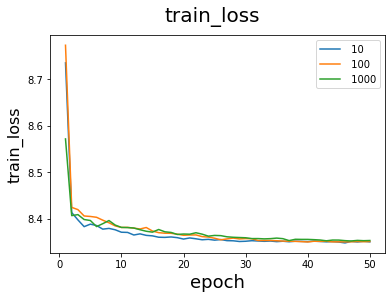

In [38]:
pruner_multiple_widths_plot_loop("fc_reg", "synflow", 1.0, 0, 50, 4, [10, 100, 1000], ["budge", "train_loss"])

In [56]:
pruner_multiple_widths_plot_loop("fc_cla", "grasp", 1.0, 1, 5, 4, [10, 100, 1000], ["budge", "train_loss"])

Pruning only
Loading mnist dataset.
Creating default-fc model.
Classification: Depth 4, Width 10, Scale 1


0it [00:00, ?it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

Pruning with grasp for 1 epochs.
Sparsity: 0.1


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

Parameter Sparsity: 853/8180 (0.1043)
FLOP Sparsity: 853/8180 (0.1043)



 20%|██        | 1/5 [00:02<00:10,  2.70s/it]

Epoch: 0 - metrics [2.320346055094401, 2.315988744354248, 9.58, 0]


 40%|████      | 2/5 [00:05<00:08,  2.72s/it]

Epoch: 1 - metrics [2.311439694086711, 2.3091481830596923, 9.58, 0.034671023]


 60%|██████    | 3/5 [00:08<00:05,  2.72s/it]

Epoch: 2 - metrics [2.306498273976644, 2.3052578651428224, 9.58, 0.06054002]


 60%|██████    | 3/5 [00:10<00:07,  3.61s/it]


KeyboardInterrupt: 

# All pruners, per pruner $X$ multiple width

Starting pruner:  synflow
Starting model_type:  fc_cla
Pruning only
Loading mnist dataset.
Creating default-fc model.
Classification: Depth 6, Width 10, Scale 1


0it [00:00, ?it/s]
0it [00:00, ?it/s]

Pruning with synflow for 0 epochs.
Sparsity: 0.1
ERROR: 8340.0 prunable parameters remaining, expected 834.0
Parameter Sparsity: 8400/8400 (1.0000)
FLOP Sparsity: 8400/8400 (1.0000)



  1%|          | 1/100 [00:03<05:56,  3.60s/it]

Epoch: 0 - metrics [2.3017067810058593, 2.297776853179932, 22.14, 0]


  2%|▏         | 2/100 [00:07<05:50,  3.57s/it]

Epoch: 1 - metrics [2.2939064000447593, 2.2888458854675293, 20.91, 0.032509543]


  3%|▎         | 3/100 [00:10<05:42,  3.53s/it]

Epoch: 2 - metrics [2.2818979749043784, 2.2708305950164793, 24.82, 0.076921865]


  4%|▍         | 4/100 [00:14<05:37,  3.51s/it]

Epoch: 3 - metrics [2.253537978108724, 2.2230616382598876, 23.91, 0.14649108]


  5%|▌         | 5/100 [00:17<05:31,  3.49s/it]

Epoch: 4 - metrics [2.159036085764567, 2.064622866821289, 26.0, 0.27245343]


  6%|▌         | 6/100 [00:20<05:25,  3.46s/it]

Epoch: 5 - metrics [1.9640790207544963, 1.824605115890503, 31.6, 0.4137655]


  7%|▋         | 7/100 [00:24<05:23,  3.48s/it]

Epoch: 6 - metrics [1.593871497408549, 1.2949646812438964, 53.29, 0.61002946]


  8%|▊         | 8/100 [00:27<05:22,  3.51s/it]

Epoch: 7 - metrics [1.057758970228831, 0.8615864661216736, 74.08, 0.7595451]


  9%|▉         | 9/100 [00:31<05:17,  3.48s/it]

Epoch: 8 - metrics [0.7934724024772644, 0.7246165416717529, 79.29, 0.8271591]


 10%|█         | 10/100 [00:34<05:11,  3.47s/it]

Epoch: 9 - metrics [0.692794844341278, 0.6456957306861878, 82.3, 0.87366515]


 11%|█         | 11/100 [00:38<05:06,  3.45s/it]

Epoch: 10 - metrics [0.6256005881627401, 0.610808629989624, 83.93, 0.9148096]


 12%|█▏        | 12/100 [00:41<05:03,  3.45s/it]

Epoch: 11 - metrics [0.5762450102170309, 0.574645668387413, 83.6, 0.95100653]


 13%|█▎        | 13/100 [00:45<05:01,  3.46s/it]

Epoch: 12 - metrics [0.5363241018136342, 0.5223633894443512, 86.28, 0.9848342]


 14%|█▍        | 14/100 [00:48<04:56,  3.44s/it]

Epoch: 13 - metrics [0.5047997839609782, 0.5085397755622864, 86.69, 1.0133374]


 15%|█▌        | 15/100 [00:51<04:52,  3.44s/it]

Epoch: 14 - metrics [0.47917764558792114, 0.4908619824409485, 86.85, 1.0406435]


 16%|█▌        | 16/100 [00:55<04:50,  3.46s/it]

Epoch: 15 - metrics [0.458969411722819, 0.46173623218536375, 88.14, 1.0644375]


 17%|█▋        | 17/100 [00:58<04:47,  3.46s/it]

Epoch: 16 - metrics [0.44078388290405274, 0.4485224048614502, 88.51, 1.0839922]


 18%|█▊        | 18/100 [01:02<04:43,  3.45s/it]

Epoch: 17 - metrics [0.4270435435771942, 0.4329409460544586, 88.88, 1.1028608]


 19%|█▉        | 19/100 [01:05<04:41,  3.47s/it]

Epoch: 18 - metrics [0.41549068403244016, 0.4214050455093384, 89.34, 1.1196253]


 20%|██        | 20/100 [01:09<04:37,  3.47s/it]

Epoch: 19 - metrics [0.40404953093528745, 0.4255102837562561, 89.14, 1.135678]


 21%|██        | 21/100 [01:12<04:32,  3.45s/it]

Epoch: 20 - metrics [0.3951640261332194, 0.4109677049160004, 89.39, 1.1489644]


 22%|██▏       | 22/100 [01:16<04:30,  3.47s/it]

Epoch: 21 - metrics [0.38634993414878843, 0.4068531237125397, 89.66, 1.1631385]


 23%|██▎       | 23/100 [01:19<04:25,  3.45s/it]

Epoch: 22 - metrics [0.37885676662127177, 0.3945665166378021, 90.1, 1.175922]


 24%|██▍       | 24/100 [01:23<04:20,  3.43s/it]

Epoch: 23 - metrics [0.371419394659996, 0.3976943278312683, 89.96, 1.1891302]


 25%|██▌       | 25/100 [01:26<04:17,  3.43s/it]

Epoch: 24 - metrics [0.3643485647122065, 0.3918407832622528, 89.69, 1.2013797]


 26%|██▌       | 26/100 [01:29<04:14,  3.44s/it]

Epoch: 25 - metrics [0.3583891501744588, 0.3985467487812042, 89.32, 1.2127017]


 27%|██▋       | 27/100 [01:33<04:10,  3.43s/it]

Epoch: 26 - metrics [0.3525906806866328, 0.37572851643562316, 90.46, 1.2230935]


 28%|██▊       | 28/100 [01:36<04:06,  3.42s/it]

Epoch: 27 - metrics [0.34726090723673503, 0.3791745970726013, 90.15, 1.2338624]


 29%|██▉       | 29/100 [01:40<04:03,  3.43s/it]

Epoch: 28 - metrics [0.3418547121365865, 0.3828562695980072, 89.99, 1.2448734]


 30%|███       | 30/100 [01:43<03:59,  3.42s/it]

Epoch: 29 - metrics [0.33651831450462344, 0.3848479989051819, 90.26, 1.2549734]


 31%|███       | 31/100 [01:47<03:57,  3.44s/it]

Epoch: 30 - metrics [0.3316736789703369, 0.36662507557868956, 90.41, 1.264881]


 32%|███▏      | 32/100 [01:50<03:54,  3.45s/it]

Epoch: 31 - metrics [0.3269963994979858, 0.3675561203479767, 90.19, 1.2746074]


 33%|███▎      | 33/100 [01:54<03:51,  3.45s/it]

Epoch: 32 - metrics [0.3217312085866928, 0.3522640302658081, 90.8, 1.2837903]


 34%|███▍      | 34/100 [01:57<03:46,  3.43s/it]

Epoch: 33 - metrics [0.3169928759654363, 0.34696646327972414, 91.01, 1.2933979]


 35%|███▌      | 35/100 [02:00<03:42,  3.42s/it]

Epoch: 34 - metrics [0.31257298742930095, 0.3513730750083923, 90.65, 1.3028333]


 36%|███▌      | 36/100 [02:04<03:38,  3.42s/it]

Epoch: 35 - metrics [0.30666065266132353, 0.34161790409088133, 90.91, 1.3115913]


 37%|███▋      | 37/100 [02:07<03:34,  3.41s/it]

Epoch: 36 - metrics [0.3033084829568863, 0.348143173122406, 90.64, 1.3202273]


 38%|███▊      | 38/100 [02:11<03:30,  3.40s/it]

Epoch: 37 - metrics [0.29755985608100893, 0.3417337773323059, 91.11, 1.3281839]


 39%|███▉      | 39/100 [02:14<03:28,  3.42s/it]

Epoch: 38 - metrics [0.29352878811359406, 0.35576564874649047, 90.27, 1.3356647]


 40%|████      | 40/100 [02:17<03:25,  3.42s/it]

Epoch: 39 - metrics [0.289463795820872, 0.3520061819553375, 90.68, 1.3430208]


 41%|████      | 41/100 [02:21<03:21,  3.41s/it]

Epoch: 40 - metrics [0.2851968015988668, 0.32559075012207034, 91.33, 1.3507915]


 42%|████▏     | 42/100 [02:24<03:18,  3.42s/it]

Epoch: 41 - metrics [0.2806455857475599, 0.3262718364238739, 91.46, 1.3580217]


 43%|████▎     | 43/100 [02:28<03:13,  3.40s/it]

Epoch: 42 - metrics [0.27640454730590186, 0.32023421659469603, 91.52, 1.3638853]


 44%|████▍     | 44/100 [02:31<03:09,  3.38s/it]

Epoch: 43 - metrics [0.2716777739604314, 0.3230836609840393, 91.28, 1.3704444]


 45%|████▌     | 45/100 [02:34<03:07,  3.41s/it]

Epoch: 44 - metrics [0.2693752631266912, 0.3127069896697998, 91.54, 1.3760664]


 46%|████▌     | 46/100 [02:38<03:05,  3.43s/it]

Epoch: 45 - metrics [0.26426343038082123, 0.3112461606502533, 91.58, 1.3817077]


 47%|████▋     | 47/100 [02:41<03:01,  3.42s/it]

Epoch: 46 - metrics [0.2611132285396258, 0.30996169362068177, 91.59, 1.387783]


 48%|████▊     | 48/100 [02:45<02:59,  3.44s/it]

Epoch: 47 - metrics [0.25733962534268695, 0.3051019730091095, 91.63, 1.3927741]


 49%|████▉     | 49/100 [02:48<02:55,  3.45s/it]

Epoch: 48 - metrics [0.2540049715042114, 0.30707424535751343, 91.6, 1.3982627]


 50%|█████     | 50/100 [02:52<02:50,  3.42s/it]

Epoch: 49 - metrics [0.251237414654096, 0.3015277186870575, 91.65, 1.4035776]


 51%|█████     | 51/100 [02:55<02:47,  3.42s/it]

Epoch: 50 - metrics [0.24909375627438227, 0.31632902765274046, 91.18, 1.4083989]


 52%|█████▏    | 52/100 [02:58<02:45,  3.44s/it]

Epoch: 51 - metrics [0.24616522976954777, 0.29498693504333495, 91.75, 1.4135642]


 53%|█████▎    | 53/100 [03:02<02:42,  3.45s/it]

Epoch: 52 - metrics [0.24452351135810216, 0.2939466938018799, 91.91, 1.4181497]


 54%|█████▍    | 54/100 [03:05<02:38,  3.44s/it]

Epoch: 53 - metrics [0.241578379992644, 0.31306098866462706, 91.71, 1.4227234]


 55%|█████▌    | 55/100 [03:09<02:34,  3.44s/it]

Epoch: 54 - metrics [0.23921466599305471, 0.3015998032093048, 91.77, 1.4275069]


 56%|█████▌    | 56/100 [03:12<02:31,  3.45s/it]

Epoch: 55 - metrics [0.23804792163769403, 0.2989077394008636, 91.8, 1.4316543]


 57%|█████▋    | 57/100 [03:16<02:28,  3.45s/it]

Epoch: 56 - metrics [0.23628297918637595, 0.29412507209777833, 91.84, 1.436072]


 58%|█████▊    | 58/100 [03:19<02:24,  3.44s/it]

Epoch: 57 - metrics [0.23404590630928676, 0.3122364865779877, 91.09, 1.4409761]


 59%|█████▉    | 59/100 [03:23<02:20,  3.42s/it]

Epoch: 58 - metrics [0.2331380179365476, 0.2906362615585327, 92.05, 1.4451067]


 60%|██████    | 60/100 [03:26<02:16,  3.41s/it]

Epoch: 59 - metrics [0.23073238968054455, 0.28608544535636904, 92.16, 1.4498386]


 61%|██████    | 61/100 [03:29<02:14,  3.45s/it]

Epoch: 60 - metrics [0.23024339447816214, 0.28139854316711427, 92.16, 1.4541491]


 62%|██████▏   | 62/100 [03:33<02:10,  3.44s/it]

Epoch: 61 - metrics [0.22820585283438366, 0.2831889024734497, 92.13, 1.4589301]


 63%|██████▎   | 63/100 [03:36<02:06,  3.42s/it]

Epoch: 62 - metrics [0.22619579248428345, 0.2815761779308319, 92.2, 1.4630301]


 64%|██████▍   | 64/100 [03:40<02:03,  3.43s/it]

Epoch: 63 - metrics [0.22472477760712306, 0.2931127035617828, 91.85, 1.4668221]


 65%|██████▌   | 65/100 [03:43<02:00,  3.43s/it]

Epoch: 64 - metrics [0.2230332232872645, 0.2804992335319519, 92.08, 1.4711956]


 66%|██████▌   | 66/100 [03:47<01:56,  3.44s/it]

Epoch: 65 - metrics [0.22177278524239857, 0.27964446721076963, 92.16, 1.475558]


 67%|██████▋   | 67/100 [03:50<01:53,  3.45s/it]

Epoch: 66 - metrics [0.22082549290657044, 0.2785201003074646, 92.11, 1.4799306]


 68%|██████▊   | 68/100 [03:54<01:50,  3.46s/it]

Epoch: 67 - metrics [0.21936739176511766, 0.27962707591056823, 92.1, 1.4842997]


 69%|██████▉   | 69/100 [03:57<01:46,  3.43s/it]

Epoch: 68 - metrics [0.2174953010002772, 0.27762644572257994, 92.09, 1.4876492]


 70%|███████   | 70/100 [04:00<01:43,  3.43s/it]

Epoch: 69 - metrics [0.21663629290660222, 0.2890382490158081, 91.86, 1.4927396]


 71%|███████   | 71/100 [04:04<01:39,  3.44s/it]

Epoch: 70 - metrics [0.21563580576181413, 0.2761862590789795, 92.16, 1.4972273]


 72%|███████▏  | 72/100 [04:07<01:35,  3.42s/it]

Epoch: 71 - metrics [0.21427861644029617, 0.2746432936191559, 92.25, 1.5015558]


 73%|███████▎  | 73/100 [04:11<01:31,  3.40s/it]

Epoch: 72 - metrics [0.21360989171266556, 0.2801396761894226, 92.18, 1.5051916]


 74%|███████▍  | 74/100 [04:14<01:28,  3.39s/it]

Epoch: 73 - metrics [0.21131988914807637, 0.2753366638660431, 92.39, 1.5095105]


 75%|███████▌  | 75/100 [04:17<01:25,  3.41s/it]

Epoch: 74 - metrics [0.21090887883901596, 0.2836755340576172, 91.8, 1.5139476]


 76%|███████▌  | 76/100 [04:21<01:21,  3.40s/it]

Epoch: 75 - metrics [0.2104073886315028, 0.2734956260681152, 92.29, 1.5177398]


 77%|███████▋  | 77/100 [04:24<01:18,  3.41s/it]

Epoch: 76 - metrics [0.20778956914345423, 0.27250923819541933, 92.48, 1.5225017]


 78%|███████▊  | 78/100 [04:28<01:15,  3.42s/it]

Epoch: 77 - metrics [0.2075505192240079, 0.279292386341095, 92.14, 1.5264072]


 79%|███████▉  | 79/100 [04:31<01:11,  3.43s/it]

Epoch: 78 - metrics [0.20678711444934209, 0.27197744307518007, 92.37, 1.5297718]


 80%|████████  | 80/100 [04:34<01:08,  3.44s/it]

Epoch: 79 - metrics [0.20576524787346523, 0.2750331175804138, 92.4, 1.5342551]


 81%|████████  | 81/100 [04:38<01:05,  3.43s/it]

Epoch: 80 - metrics [0.20448453757762908, 0.27790469789505007, 92.2, 1.5382977]


 82%|████████▏ | 82/100 [04:41<01:02,  3.45s/it]

Epoch: 81 - metrics [0.20354862957398095, 0.33961696190834045, 90.53, 1.5421021]


 83%|████████▎ | 83/100 [04:45<00:58,  3.46s/it]

Epoch: 82 - metrics [0.20325222251017888, 0.2658132127761841, 92.32, 1.5454649]


 84%|████████▍ | 84/100 [04:48<00:55,  3.46s/it]

Epoch: 83 - metrics [0.20258606371879578, 0.2655891867637634, 92.46, 1.5494382]


 85%|████████▌ | 85/100 [04:52<00:51,  3.46s/it]

Epoch: 84 - metrics [0.20090640006462732, 0.27827557735443115, 91.98, 1.5536247]


 86%|████████▌ | 86/100 [04:55<00:48,  3.44s/it]

Epoch: 85 - metrics [0.2000943101088206, 0.2680310896396637, 92.32, 1.5575435]


 87%|████████▋ | 87/100 [04:59<00:44,  3.44s/it]

Epoch: 86 - metrics [0.1993691774924596, 0.27726477994918824, 92.26, 1.561103]


 88%|████████▊ | 88/100 [05:02<00:41,  3.45s/it]

Epoch: 87 - metrics [0.19806961136261622, 0.26875174326896667, 92.26, 1.5648572]


 89%|████████▉ | 89/100 [05:05<00:37,  3.43s/it]

Epoch: 88 - metrics [0.19698199119567872, 0.27045779852867124, 92.42, 1.5681986]


 90%|█████████ | 90/100 [05:09<00:34,  3.46s/it]

Epoch: 89 - metrics [0.1959099373459816, 0.275116779088974, 92.15, 1.5726476]


 91%|█████████ | 91/100 [05:13<00:31,  3.47s/it]

Epoch: 90 - metrics [0.19586146976153057, 0.2699769425392151, 92.24, 1.5758009]


 92%|█████████▏| 92/100 [05:16<00:27,  3.46s/it]

Epoch: 91 - metrics [0.19466401430765787, 0.26846979970932006, 92.17, 1.5793042]


 93%|█████████▎| 93/100 [05:19<00:24,  3.44s/it]

Epoch: 92 - metrics [0.19389418461720148, 0.2671396767616272, 92.54, 1.5831298]


 94%|█████████▍| 94/100 [05:23<00:20,  3.43s/it]

Epoch: 93 - metrics [0.19349963653882343, 0.26261257257461545, 92.58, 1.5865401]


 95%|█████████▌| 95/100 [05:26<00:17,  3.41s/it]

Epoch: 94 - metrics [0.19318931272029877, 0.26580285692214967, 92.47, 1.5902971]


 96%|█████████▌| 96/100 [05:30<00:13,  3.41s/it]

Epoch: 95 - metrics [0.19229640687704086, 0.2637931408405304, 92.48, 1.5931994]


 97%|█████████▋| 97/100 [05:33<00:10,  3.41s/it]

Epoch: 96 - metrics [0.19228614970445632, 0.2651478917121887, 92.48, 1.5967848]


 98%|█████████▊| 98/100 [05:37<00:06,  3.46s/it]

Epoch: 97 - metrics [0.1908491836587588, 0.2580583010673523, 92.62, 1.6002073]


 99%|█████████▉| 99/100 [05:40<00:03,  3.46s/it]

Epoch: 98 - metrics [0.19014098759492237, 0.26076641387939453, 92.69, 1.603531]


100%|██████████| 100/100 [05:43<00:00,  3.44s/it]

Epoch: 99 - metrics [0.18909619578520456, 0.25771137528419497, 92.56, 1.6072819]
Pruning only
Loading mnist dataset.
Creating default-fc model.
Classification: Depth 6, Width 100, Scale 1



0it [00:00, ?it/s]
0it [00:00, ?it/s]

Pruning with synflow for 0 epochs.
Sparsity: 0.1
ERROR: 119400.0 prunable parameters remaining, expected 11940.0
Parameter Sparsity: 119910/119910 (1.0000)
FLOP Sparsity: 119910/119910 (1.0000)



  1%|          | 1/100 [00:03<05:33,  3.37s/it]

Epoch: 0 - metrics [2.3038633628845213, 2.3006246635437013, 10.32, 0]


  2%|▏         | 2/100 [00:06<05:31,  3.39s/it]

Epoch: 1 - metrics [2.2980267101287843, 2.294396504211426, 17.65, 0.0099169435]


  3%|▎         | 3/100 [00:10<05:35,  3.46s/it]

Epoch: 2 - metrics [2.289459164428711, 2.281428923034668, 20.25, 0.023388654]


  4%|▍         | 4/100 [00:13<05:33,  3.48s/it]

Epoch: 3 - metrics [2.2658625244140627, 2.2361369514465332, 21.85, 0.047074787]


  5%|▌         | 5/100 [00:17<05:29,  3.47s/it]

Epoch: 4 - metrics [2.1252185757954916, 1.9370450021743775, 36.28, 0.10775124]


  6%|▌         | 6/100 [00:20<05:24,  3.46s/it]

Epoch: 5 - metrics [1.592535364151001, 1.1397714525222777, 65.2, 0.19744731]


  7%|▋         | 7/100 [00:24<05:20,  3.45s/it]

Epoch: 6 - metrics [0.850855929629008, 0.6400415214538574, 80.62, 0.25228578]


  8%|▊         | 8/100 [00:27<05:17,  3.45s/it]

Epoch: 7 - metrics [0.5689781838575999, 0.48037243337631225, 86.06, 0.27791086]


  9%|▉         | 9/100 [00:31<05:13,  3.44s/it]

Epoch: 8 - metrics [0.4501595334211985, 0.3979006518363953, 88.36, 0.29521525]


 10%|█         | 10/100 [00:34<05:10,  3.45s/it]

Epoch: 9 - metrics [0.3831529876470566, 0.3463171000480652, 90.08, 0.30946448]


 11%|█         | 11/100 [00:37<05:05,  3.43s/it]

Epoch: 10 - metrics [0.3354308436632156, 0.3075456735610962, 91.03, 0.32188955]


 12%|█▏        | 12/100 [00:41<05:00,  3.42s/it]

Epoch: 11 - metrics [0.29778479544321695, 0.28073166794776916, 92.04, 0.3334336]


 13%|█▎        | 13/100 [00:44<04:56,  3.40s/it]

Epoch: 12 - metrics [0.26688414940834043, 0.24990494589805604, 92.86, 0.34415397]


 14%|█▍        | 14/100 [00:48<04:54,  3.42s/it]

Epoch: 13 - metrics [0.24156561082204184, 0.22940978093147277, 93.42, 0.35397643]


 15%|█▌        | 15/100 [00:51<04:51,  3.42s/it]

Epoch: 14 - metrics [0.22148019140164057, 0.2125647602081299, 93.9, 0.36286864]


 16%|█▌        | 16/100 [00:55<04:47,  3.43s/it]

Epoch: 15 - metrics [0.20321897437175115, 0.19588474617004395, 94.21, 0.37129545]


 17%|█▋        | 17/100 [00:58<04:42,  3.41s/it]

Epoch: 16 - metrics [0.18817659617265065, 0.1914934663295746, 94.53, 0.3790015]


 18%|█▊        | 18/100 [01:01<04:40,  3.42s/it]

Epoch: 17 - metrics [0.17577987626393637, 0.17985075597763062, 94.76, 0.38592604]


 19%|█▉        | 19/100 [01:05<04:37,  3.43s/it]

Epoch: 18 - metrics [0.16507520401875178, 0.16838505759239197, 95.04, 0.3927404]


 20%|██        | 20/100 [01:08<04:33,  3.42s/it]

Epoch: 19 - metrics [0.15532247315645217, 0.1651348120689392, 95.07, 0.39879194]


 21%|██        | 21/100 [01:12<04:30,  3.43s/it]

Epoch: 20 - metrics [0.14700884246428808, 0.15616010026931762, 95.41, 0.40447187]


 22%|██▏       | 22/100 [01:15<04:27,  3.43s/it]

Epoch: 21 - metrics [0.13918594680627186, 0.15223567175865174, 95.51, 0.41004652]


 23%|██▎       | 23/100 [01:19<04:23,  3.43s/it]

Epoch: 22 - metrics [0.13227147443294526, 0.14901812705993653, 95.5, 0.41534382]


 24%|██▍       | 24/100 [01:22<04:20,  3.43s/it]

Epoch: 23 - metrics [0.12608473747571308, 0.13902888116836548, 95.81, 0.42041433]


 25%|██▌       | 25/100 [01:25<04:16,  3.42s/it]

Epoch: 24 - metrics [0.11986103052298228, 0.14142497882843016, 95.91, 0.42536193]


 26%|██▌       | 26/100 [01:29<04:13,  3.43s/it]

Epoch: 25 - metrics [0.11470711413621902, 0.13613795957565308, 95.99, 0.4299664]


 27%|██▋       | 27/100 [01:32<04:10,  3.43s/it]

Epoch: 26 - metrics [0.10914818007151286, 0.13389481019973754, 95.92, 0.43456888]


 28%|██▊       | 28/100 [01:36<04:06,  3.42s/it]

Epoch: 27 - metrics [0.10459597253799438, 0.13119084734916686, 96.09, 0.4390664]


 29%|██▉       | 29/100 [01:39<04:03,  3.43s/it]

Epoch: 28 - metrics [0.10017618285020193, 0.12712891006469726, 96.15, 0.4435287]


 30%|███       | 30/100 [01:43<04:00,  3.44s/it]

Epoch: 29 - metrics [0.09579149537086487, 0.13040263962745666, 96.07, 0.44787744]


 31%|███       | 31/100 [01:46<03:56,  3.43s/it]

Epoch: 30 - metrics [0.0917091204682986, 0.12230865759849548, 96.38, 0.45206347]


 32%|███▏      | 32/100 [01:49<03:53,  3.43s/it]

Epoch: 31 - metrics [0.08803443380594253, 0.12298869395256043, 96.47, 0.45613837]


 33%|███▎      | 33/100 [01:53<03:49,  3.42s/it]

Epoch: 32 - metrics [0.08468931562900543, 0.12025507817268372, 96.43, 0.4599729]


 34%|███▍      | 34/100 [01:56<03:45,  3.42s/it]

Epoch: 33 - metrics [0.08111141659816107, 0.11998743448257446, 96.32, 0.46392274]


 35%|███▌      | 35/100 [02:00<03:43,  3.44s/it]

Epoch: 34 - metrics [0.07790682572921118, 0.11916358890533447, 96.49, 0.4677177]


 36%|███▌      | 36/100 [02:03<03:38,  3.42s/it]

Epoch: 35 - metrics [0.07531420520941416, 0.11547181539535523, 96.58, 0.47139683]


 37%|███▋      | 37/100 [02:06<03:35,  3.42s/it]

Epoch: 36 - metrics [0.07202735953728358, 0.11469245929718018, 96.63, 0.47507414]


 38%|███▊      | 38/100 [02:10<03:33,  3.44s/it]

Epoch: 37 - metrics [0.06898788301547368, 0.11586755557060242, 96.6, 0.47870696]


 39%|███▉      | 39/100 [02:13<03:30,  3.46s/it]

Epoch: 38 - metrics [0.06642148149808248, 0.11293515739440918, 96.57, 0.48219252]


 40%|████      | 40/100 [02:17<03:27,  3.46s/it]

Epoch: 39 - metrics [0.06372890097300211, 0.11163092908859253, 96.76, 0.48570135]


 41%|████      | 41/100 [02:20<03:23,  3.46s/it]

Epoch: 40 - metrics [0.06146989748080572, 0.10973716974258423, 96.78, 0.48903582]


 42%|████▏     | 42/100 [02:24<03:19,  3.44s/it]

Epoch: 41 - metrics [0.05867594978809357, 0.11650713710784912, 96.59, 0.49242726]


 43%|████▎     | 43/100 [02:27<03:16,  3.44s/it]

Epoch: 42 - metrics [0.05678647829095523, 0.11857364640235901, 96.57, 0.4957354]


 44%|████▍     | 44/100 [02:31<03:13,  3.46s/it]

Epoch: 43 - metrics [0.05479150012731552, 0.10668416490554809, 96.91, 0.49896586]


 45%|████▌     | 45/100 [02:34<03:09,  3.44s/it]

Epoch: 44 - metrics [0.05196429930130641, 0.10907422609329223, 96.82, 0.5022963]


 46%|████▌     | 46/100 [02:38<03:07,  3.47s/it]

Epoch: 45 - metrics [0.050069597534338636, 0.11035216536521912, 96.88, 0.5055503]


 47%|████▋     | 47/100 [02:41<03:03,  3.46s/it]

Epoch: 46 - metrics [0.048418973910808565, 0.10610819501876831, 96.89, 0.5086439]


 48%|████▊     | 48/100 [02:45<03:01,  3.48s/it]

Epoch: 47 - metrics [0.04653927913506826, 0.11093350248336792, 96.83, 0.51176643]


 49%|████▉     | 49/100 [02:48<02:57,  3.48s/it]

Epoch: 48 - metrics [0.04455535490115484, 0.10967301669120788, 96.9, 0.51479954]


 50%|█████     | 50/100 [02:52<02:53,  3.48s/it]

Epoch: 49 - metrics [0.04251055314540863, 0.10869179368019104, 97.0, 0.51787835]


 51%|█████     | 51/100 [02:55<02:49,  3.46s/it]

Epoch: 50 - metrics [0.041153713111082714, 0.10720026431083679, 96.95, 0.5208665]


 52%|█████▏    | 52/100 [02:58<02:45,  3.45s/it]

Epoch: 51 - metrics [0.0395122014482816, 0.11401774816513062, 96.87, 0.52375495]


 53%|█████▎    | 53/100 [03:02<02:41,  3.44s/it]

Epoch: 52 - metrics [0.03776984289089839, 0.10885369386672973, 97.0, 0.5266709]


 54%|█████▍    | 54/100 [03:05<02:38,  3.44s/it]

Epoch: 53 - metrics [0.03612771703402201, 0.10844958024024963, 96.94, 0.5295421]


 55%|█████▌    | 55/100 [03:09<02:37,  3.50s/it]

Epoch: 54 - metrics [0.034699008901913964, 0.11201113166809082, 96.79, 0.5324151]


 56%|█████▌    | 56/100 [03:12<02:32,  3.47s/it]

Epoch: 55 - metrics [0.03306785686810811, 0.10924078364372253, 97.07, 0.53522944]


 57%|█████▋    | 57/100 [03:16<02:29,  3.47s/it]

Epoch: 56 - metrics [0.03174501386086146, 0.11210500168800354, 96.93, 0.5379315]


 58%|█████▊    | 58/100 [03:19<02:25,  3.46s/it]

Epoch: 57 - metrics [0.030163641742865243, 0.10794465298652649, 96.94, 0.5407485]


 59%|█████▉    | 59/100 [03:23<02:21,  3.45s/it]

Epoch: 58 - metrics [0.02907397753794988, 0.10958406958580016, 97.17, 0.543421]


 60%|██████    | 60/100 [03:26<02:16,  3.42s/it]

Epoch: 59 - metrics [0.027633311355113984, 0.11686771726608276, 96.91, 0.54603815]


 61%|██████    | 61/100 [03:29<02:13,  3.43s/it]

Epoch: 60 - metrics [0.026365974922974905, 0.1148642149925232, 96.89, 0.54871917]


 62%|██████▏   | 62/100 [03:33<02:10,  3.45s/it]

Epoch: 61 - metrics [0.02547710866133372, 0.1107921353340149, 97.0, 0.5513063]


 63%|██████▎   | 63/100 [03:36<02:07,  3.45s/it]

Epoch: 62 - metrics [0.024145281386375426, 0.11047644605636597, 97.06, 0.55385834]


 64%|██████▍   | 64/100 [03:40<02:04,  3.47s/it]

Epoch: 63 - metrics [0.022874979774157207, 0.11631037411689758, 96.88, 0.55646056]


 65%|██████▌   | 65/100 [03:43<02:01,  3.47s/it]

Epoch: 64 - metrics [0.021941748603185016, 0.12273343982696533, 96.74, 0.5589335]


 66%|██████▌   | 66/100 [03:47<01:57,  3.46s/it]

Epoch: 65 - metrics [0.021068025930722555, 0.12116367921829224, 97.01, 0.56142163]


 67%|██████▋   | 67/100 [03:50<01:54,  3.48s/it]

Epoch: 66 - metrics [0.019949703971544903, 0.11788483724594116, 97.06, 0.5637749]


 68%|██████▊   | 68/100 [03:54<01:51,  3.48s/it]

Epoch: 67 - metrics [0.018678415060043335, 0.11646610126495362, 97.06, 0.56619555]


 69%|██████▉   | 69/100 [03:57<01:48,  3.50s/it]

Epoch: 68 - metrics [0.017823788857460023, 0.12035392847061158, 96.92, 0.56850654]


 70%|███████   | 70/100 [04:01<01:43,  3.45s/it]

Epoch: 69 - metrics [0.016718548679351807, 0.12705934195518492, 96.85, 0.57083327]


 71%|███████   | 71/100 [04:04<01:39,  3.44s/it]

Epoch: 70 - metrics [0.016259272782007853, 0.11715071516036987, 96.98, 0.57308316]


 72%|███████▏  | 72/100 [04:07<01:35,  3.41s/it]

Epoch: 71 - metrics [0.01538788872162501, 0.12180559995174407, 96.91, 0.5752597]


 73%|███████▎  | 73/100 [04:11<01:32,  3.43s/it]

Epoch: 72 - metrics [0.014732957235972087, 0.12034882893562317, 97.01, 0.5774095]


 74%|███████▍  | 74/100 [04:14<01:28,  3.41s/it]

Epoch: 73 - metrics [0.013691299017270406, 0.1231022453546524, 96.97, 0.5795689]


 75%|███████▌  | 75/100 [04:18<01:25,  3.43s/it]

Epoch: 74 - metrics [0.012924017067750294, 0.12362657537460327, 96.93, 0.581665]


 76%|███████▌  | 76/100 [04:21<01:22,  3.44s/it]

Epoch: 75 - metrics [0.012268183064460755, 0.1249550865650177, 96.97, 0.5836746]


 77%|███████▋  | 77/100 [04:25<01:19,  3.44s/it]

Epoch: 76 - metrics [0.011833265137672425, 0.12725267572402954, 96.87, 0.58564484]


 78%|███████▊  | 78/100 [04:28<01:16,  3.46s/it]

Epoch: 77 - metrics [0.011019057575861612, 0.1266112964630127, 97.02, 0.58762544]


 79%|███████▉  | 79/100 [04:32<01:12,  3.44s/it]

Epoch: 78 - metrics [0.010526008288065592, 0.12584320816993713, 97.01, 0.58950907]


 80%|████████  | 80/100 [04:35<01:09,  3.46s/it]

Epoch: 79 - metrics [0.009847591106096903, 0.12794871916770936, 97.07, 0.59137344]


 81%|████████  | 81/100 [04:38<01:05,  3.44s/it]

Epoch: 80 - metrics [0.009484139939149221, 0.13809059677124025, 96.89, 0.5931958]


 82%|████████▏ | 82/100 [04:42<01:02,  3.46s/it]

Epoch: 81 - metrics [0.008970466311772665, 0.12943110270500183, 97.03, 0.5950014]


 83%|████████▎ | 83/100 [04:47<01:04,  3.80s/it]

Epoch: 82 - metrics [0.008212593996524811, 0.13370402841567994, 96.87, 0.5967297]


 84%|████████▍ | 84/100 [04:52<01:07,  4.22s/it]

Epoch: 83 - metrics [0.0077556930343310035, 0.13248909330368042, 97.06, 0.5984424]


 85%|████████▌ | 85/100 [04:57<01:06,  4.44s/it]

Epoch: 84 - metrics [0.007247975126902262, 0.13260278282165527, 97.13, 0.60010266]


 86%|████████▌ | 86/100 [05:00<00:58,  4.16s/it]

Epoch: 85 - metrics [0.007012032214800516, 0.13476812167167665, 96.87, 0.60172856]


 87%|████████▋ | 87/100 [05:04<00:50,  3.92s/it]

Epoch: 86 - metrics [0.006687522248427073, 0.13458700160980225, 96.95, 0.60329133]


 88%|████████▊ | 88/100 [05:07<00:45,  3.77s/it]

Epoch: 87 - metrics [0.00616533689101537, 0.1357476113319397, 96.95, 0.6048201]


 89%|████████▉ | 89/100 [05:10<00:40,  3.65s/it]

Epoch: 88 - metrics [0.005803723820050557, 0.13717207155227662, 97.01, 0.60632366]


 90%|█████████ | 90/100 [05:14<00:35,  3.59s/it]

Epoch: 89 - metrics [0.005546298980712891, 0.13829348487854004, 97.04, 0.60776764]


 91%|█████████ | 91/100 [05:17<00:31,  3.54s/it]

Epoch: 90 - metrics [0.005183631904919942, 0.20912150840759278, 95.45, 0.6091518]


 92%|█████████▏| 92/100 [05:21<00:28,  3.52s/it]

Epoch: 91 - metrics [0.005078401974836985, 0.14045839557647705, 96.89, 0.6105475]


 93%|█████████▎| 93/100 [05:24<00:24,  3.49s/it]

Epoch: 92 - metrics [0.004659446247418721, 0.14090475387573242, 96.91, 0.6118849]


 94%|█████████▍| 94/100 [05:28<00:20,  3.49s/it]

Epoch: 93 - metrics [0.004386892493565877, 0.14167030296325683, 97.02, 0.61317873]


 95%|█████████▌| 95/100 [05:31<00:17,  3.47s/it]

Epoch: 94 - metrics [0.0041226471900939945, 0.14300233640670776, 97.04, 0.6144373]


 96%|█████████▌| 96/100 [05:34<00:13,  3.45s/it]

Epoch: 95 - metrics [0.004019911114374796, 0.14405618844032286, 96.91, 0.615653]


 97%|█████████▋| 97/100 [05:38<00:10,  3.43s/it]

Epoch: 96 - metrics [0.0037630667050679526, 0.1444279860496521, 96.97, 0.61683613]


 98%|█████████▊| 98/100 [05:41<00:06,  3.42s/it]

Epoch: 97 - metrics [0.0035565237760543825, 0.14541517400741577, 96.9, 0.61798507]


 99%|█████████▉| 99/100 [05:45<00:03,  3.43s/it]

Epoch: 98 - metrics [0.0033471051534016928, 0.14488642873764038, 96.97, 0.6191018]


100%|██████████| 100/100 [05:48<00:00,  3.49s/it]

Epoch: 99 - metrics [0.0032287362098693847, 0.1455960301876068, 97.0, 0.62018406]
Pruning only
Loading mnist dataset.
Creating default-fc model.
Classification: Depth 6, Width 1000, Scale 1



0it [00:00, ?it/s]
0it [00:00, ?it/s]

Pruning with synflow for 0 epochs.
Sparsity: 0.1
ERROR: 4794000.0 prunable parameters remaining, expected 479400.0
Parameter Sparsity: 4799010/4799010 (1.0000)
FLOP Sparsity: 4799010/4799010 (1.0000)



  1%|          | 1/100 [00:03<06:16,  3.81s/it]

Epoch: 0 - metrics [2.296083767827352, 2.287920092010498, 36.6, 0]


  2%|▏         | 2/100 [00:07<06:16,  3.84s/it]

Epoch: 1 - metrics [2.2743170187632242, 2.249584563064575, 55.67, 0.0076830424]


  3%|▎         | 3/100 [00:11<06:14,  3.86s/it]

Epoch: 2 - metrics [2.1477196207046507, 1.8649003570556641, 57.54, 0.029828805]


  4%|▍         | 4/100 [00:15<06:12,  3.88s/it]

Epoch: 3 - metrics [1.1256029642740886, 0.686468640613556, 78.39, 0.06800147]


  5%|▌         | 5/100 [00:19<06:08,  3.88s/it]

Epoch: 4 - metrics [0.5660130237261455, 0.4675965133190155, 86.22, 0.07904343]


  6%|▌         | 6/100 [00:23<06:05,  3.88s/it]

Epoch: 5 - metrics [0.4291284977912903, 0.37716410856246946, 88.98, 0.085420765]


  7%|▋         | 7/100 [00:27<06:04,  3.92s/it]

Epoch: 6 - metrics [0.3552807162443797, 0.32246109228134157, 90.43, 0.09001749]


  8%|▊         | 8/100 [00:31<05:58,  3.90s/it]

Epoch: 7 - metrics [0.3097598160505295, 0.28146362376213074, 91.82, 0.0937657]


  9%|▉         | 9/100 [00:35<05:54,  3.90s/it]

Epoch: 8 - metrics [0.2761337516307831, 0.2584253806114197, 92.46, 0.09717061]


 10%|█         | 10/100 [00:38<05:50,  3.89s/it]

Epoch: 9 - metrics [0.24911732257207234, 0.229613814163208, 93.33, 0.10037876]


 11%|█         | 11/100 [00:42<05:45,  3.89s/it]

Epoch: 10 - metrics [0.22480225399335224, 0.2135043076515198, 93.95, 0.10349495]


 12%|█▏        | 12/100 [00:46<05:40,  3.87s/it]

Epoch: 11 - metrics [0.20345900721549987, 0.20337114219665528, 94.21, 0.10656354]


 13%|█▎        | 13/100 [00:50<05:36,  3.87s/it]

Epoch: 12 - metrics [0.18511351795991263, 0.1827033710002899, 94.69, 0.10953341]


 14%|█▍        | 14/100 [00:54<05:34,  3.89s/it]

Epoch: 13 - metrics [0.1689980657339096, 0.16690449290275575, 94.96, 0.1123121]


 15%|█▌        | 15/100 [00:58<05:30,  3.88s/it]

Epoch: 14 - metrics [0.15502265702883403, 0.15177481904029846, 95.52, 0.11495875]


 16%|█▌        | 16/100 [01:02<05:26,  3.89s/it]

Epoch: 15 - metrics [0.14255471615393955, 0.14715445318222045, 95.8, 0.117414184]


 17%|█▋        | 17/100 [01:06<05:22,  3.89s/it]

Epoch: 16 - metrics [0.13249626932938893, 0.1377964108467102, 95.99, 0.119693376]


 18%|█▊        | 18/100 [01:10<05:20,  3.90s/it]

Epoch: 17 - metrics [0.12327092570861181, 0.12881257309913635, 96.14, 0.12188762]


 19%|█▉        | 19/100 [01:14<05:19,  3.95s/it]

Epoch: 18 - metrics [0.11473549131552378, 0.1281419258594513, 96.21, 0.12395367]


 20%|██        | 20/100 [01:17<05:13,  3.92s/it]

Epoch: 19 - metrics [0.10743524282375971, 0.12506845893859864, 96.33, 0.12591454]


 21%|██        | 21/100 [01:21<05:08,  3.91s/it]

Epoch: 20 - metrics [0.10054892470041911, 0.11217886505126953, 96.61, 0.12783143]


 22%|██▏       | 22/100 [01:25<05:05,  3.91s/it]

Epoch: 21 - metrics [0.09411392082373302, 0.11550479707717895, 96.62, 0.12961411]


 23%|██▎       | 23/100 [01:29<05:00,  3.90s/it]

Epoch: 22 - metrics [0.08839061686992646, 0.10791284809112549, 96.76, 0.1313598]


 24%|██▍       | 24/100 [01:33<04:55,  3.89s/it]

Epoch: 23 - metrics [0.08292114913860957, 0.1050252646446228, 96.91, 0.13308008]


 25%|██▌       | 25/100 [01:37<04:50,  3.88s/it]

Epoch: 24 - metrics [0.07786230433384578, 0.103050599193573, 96.83, 0.13470463]


 26%|██▌       | 26/100 [01:41<04:46,  3.87s/it]

Epoch: 25 - metrics [0.07336470803419749, 0.09691619639396667, 97.15, 0.13630818]


 27%|██▋       | 27/100 [01:45<04:40,  3.85s/it]

Epoch: 26 - metrics [0.06875154379606246, 0.09671483564376832, 97.04, 0.13789247]


 28%|██▊       | 28/100 [01:48<04:38,  3.86s/it]

Epoch: 27 - metrics [0.06425763656695684, 0.09853885445594787, 97.03, 0.13943726]


 29%|██▉       | 29/100 [01:52<04:36,  3.89s/it]

Epoch: 28 - metrics [0.06052758932113647, 0.09378256988525391, 97.2, 0.14089756]


 30%|███       | 30/100 [01:56<04:31,  3.87s/it]

Epoch: 29 - metrics [0.05685170849164327, 0.09292959265708924, 97.29, 0.14233938]


 31%|███       | 31/100 [02:00<04:25,  3.85s/it]

Epoch: 30 - metrics [0.05328725523948669, 0.09226226196289063, 97.21, 0.14375481]


 32%|███▏      | 32/100 [02:04<04:21,  3.84s/it]

Epoch: 31 - metrics [0.04987185871601105, 0.08811387062072754, 97.38, 0.14514218]


 33%|███▎      | 33/100 [02:08<04:17,  3.84s/it]

Epoch: 32 - metrics [0.04668763640721639, 0.08980304551124572, 97.34, 0.14647977]


 34%|███▍      | 34/100 [02:11<04:12,  3.83s/it]

Epoch: 33 - metrics [0.04368089104890823, 0.08785744528770446, 97.43, 0.14779796]


 35%|███▌      | 35/100 [02:15<04:08,  3.82s/it]

Epoch: 34 - metrics [0.04114274123509725, 0.08533474454879761, 97.41, 0.14907318]


 36%|███▌      | 36/100 [02:19<04:04,  3.81s/it]

Epoch: 35 - metrics [0.03823262278238932, 0.083629350233078, 97.56, 0.15032479]


 37%|███▋      | 37/100 [02:23<04:00,  3.82s/it]

Epoch: 36 - metrics [0.03552772615949313, 0.08652945251464844, 97.3, 0.15155841]


 38%|███▊      | 38/100 [02:27<03:58,  3.85s/it]

Epoch: 37 - metrics [0.03351798708041509, 0.08419442234039307, 97.4, 0.15274246]


 39%|███▉      | 39/100 [02:31<03:55,  3.86s/it]

Epoch: 38 - metrics [0.03113153703212738, 0.0827065881729126, 97.57, 0.15391283]


 40%|████      | 40/100 [02:35<03:52,  3.88s/it]

Epoch: 39 - metrics [0.028784711098670958, 0.08984083533287049, 97.28, 0.15505488]


 41%|████      | 41/100 [02:39<03:50,  3.91s/it]

Epoch: 40 - metrics [0.027061045920848847, 0.08414132089614867, 97.63, 0.156165]


 42%|████▏     | 42/100 [02:43<03:47,  3.92s/it]

Epoch: 41 - metrics [0.02525503271818161, 0.08331791958808898, 97.48, 0.15723342]


 43%|████▎     | 43/100 [02:47<03:44,  3.93s/it]

Epoch: 42 - metrics [0.023316333762804668, 0.08097796652317048, 97.65, 0.15827878]


 44%|████▍     | 44/100 [02:51<03:41,  3.95s/it]

Epoch: 43 - metrics [0.021830715890725452, 0.08236928701400757, 97.62, 0.15929252]


 45%|████▌     | 45/100 [02:54<03:36,  3.94s/it]

Epoch: 44 - metrics [0.020054098335901896, 0.08088099660873413, 97.66, 0.16028146]


 46%|████▌     | 46/100 [02:58<03:32,  3.93s/it]

Epoch: 45 - metrics [0.018476557687918345, 0.08448454241752625, 97.63, 0.16124806]


 47%|████▋     | 47/100 [03:02<03:28,  3.94s/it]

Epoch: 46 - metrics [0.017262684007485707, 0.08193298707008362, 97.69, 0.16217673]


 48%|████▊     | 48/100 [03:06<03:22,  3.90s/it]

Epoch: 47 - metrics [0.016025306681791942, 0.08282185258865356, 97.68, 0.16308106]


 49%|████▉     | 49/100 [03:10<03:19,  3.92s/it]

Epoch: 48 - metrics [0.014928478837013245, 0.08155959215164185, 97.72, 0.16395469]


 50%|█████     | 50/100 [03:14<03:13,  3.87s/it]

Epoch: 49 - metrics [0.013762395652135214, 0.08516684746742248, 97.61, 0.16479519]


 51%|█████     | 51/100 [03:18<03:09,  3.86s/it]

Epoch: 50 - metrics [0.012671491571267447, 0.08228675227165222, 97.72, 0.16560568]


 52%|█████▏    | 52/100 [03:22<03:05,  3.87s/it]

Epoch: 51 - metrics [0.011799535850683848, 0.08603941373825073, 97.66, 0.16639057]


 53%|█████▎    | 53/100 [03:25<03:02,  3.87s/it]

Epoch: 52 - metrics [0.01089487914244334, 0.08449912619590759, 97.58, 0.16714166]


 54%|█████▍    | 54/100 [03:29<02:58,  3.89s/it]

Epoch: 53 - metrics [0.010194334622224173, 0.0841894898891449, 97.71, 0.16786706]


 55%|█████▌    | 55/100 [03:33<02:54,  3.88s/it]

Epoch: 54 - metrics [0.00949359888235728, 0.08388890891075135, 97.76, 0.16858073]


 56%|█████▌    | 56/100 [03:37<02:50,  3.88s/it]

Epoch: 55 - metrics [0.008660878574848175, 0.08540406370162965, 97.73, 0.16925955]


 57%|█████▋    | 57/100 [03:41<02:47,  3.89s/it]

Epoch: 56 - metrics [0.008121436488628387, 0.08732329320907593, 97.74, 0.16991384]


 58%|█████▊    | 58/100 [03:45<02:43,  3.90s/it]

Epoch: 57 - metrics [0.007612504053115845, 0.08663923687934875, 97.7, 0.17054373]


 59%|█████▉    | 59/100 [03:49<02:38,  3.86s/it]

Epoch: 58 - metrics [0.00705126283566157, 0.08643910450935363, 97.67, 0.17114936]


 60%|██████    | 60/100 [03:53<02:34,  3.87s/it]

Epoch: 59 - metrics [0.006555470351378123, 0.08542648887634277, 97.69, 0.17172755]


 61%|██████    | 61/100 [03:56<02:31,  3.88s/it]

Epoch: 60 - metrics [0.006189819979667664, 0.08826728482246399, 97.71, 0.17228524]


 62%|██████▏   | 62/100 [04:01<02:28,  3.92s/it]

Epoch: 61 - metrics [0.0057387020587921144, 0.09310813617706298, 97.55, 0.17282431]


 63%|██████▎   | 63/100 [04:04<02:23,  3.89s/it]

Epoch: 62 - metrics [0.005400533489386241, 0.08771857624053955, 97.79, 0.17334296]


 64%|██████▍   | 64/100 [04:08<02:19,  3.88s/it]

Epoch: 63 - metrics [0.004939661995569865, 0.08900687294006347, 97.67, 0.17384669]


 65%|██████▌   | 65/100 [04:12<02:15,  3.86s/it]

Epoch: 64 - metrics [0.004746934386094411, 0.08856332144737243, 97.76, 0.17432879]


 66%|██████▌   | 66/100 [04:16<02:11,  3.87s/it]

Epoch: 65 - metrics [0.0044376373529434205, 0.09133181109428405, 97.69, 0.17479387]


 67%|██████▋   | 67/100 [04:20<02:08,  3.88s/it]

Epoch: 66 - metrics [0.00417705907424291, 0.09110376038551331, 97.75, 0.17524448]


 68%|██████▊   | 68/100 [04:24<02:04,  3.88s/it]

Epoch: 67 - metrics [0.0039139659643173215, 0.09090116195678712, 97.68, 0.17567849]


 69%|██████▉   | 69/100 [04:27<01:59,  3.86s/it]

Epoch: 68 - metrics [0.003692973303794861, 0.09165071692466736, 97.68, 0.17609575]


 70%|███████   | 70/100 [04:31<01:56,  3.87s/it]

Epoch: 69 - metrics [0.00343209179242452, 0.09205701317787171, 97.68, 0.17649569]


 71%|███████   | 71/100 [04:35<01:52,  3.87s/it]

Epoch: 70 - metrics [0.003277690052986145, 0.09234929504394532, 97.72, 0.17689389]


 72%|███████▏  | 72/100 [04:39<01:48,  3.89s/it]

Epoch: 71 - metrics [0.003121256216367086, 0.09500969290733337, 97.66, 0.17727256]


 73%|███████▎  | 73/100 [04:43<01:44,  3.89s/it]

Epoch: 72 - metrics [0.0029609429756800336, 0.09432515840530395, 97.67, 0.17763959]


 74%|███████▍  | 74/100 [04:47<01:40,  3.88s/it]

Epoch: 73 - metrics [0.002770836075146993, 0.09431362562179565, 97.7, 0.17799252]


 75%|███████▌  | 75/100 [04:51<01:36,  3.85s/it]

Epoch: 74 - metrics [0.00261793479124705, 0.0936171772480011, 97.76, 0.17833245]


 76%|███████▌  | 76/100 [04:55<01:32,  3.86s/it]

Epoch: 75 - metrics [0.0024799759785334267, 0.09373884239196777, 97.81, 0.17865941]


 77%|███████▋  | 77/100 [04:59<01:29,  3.89s/it]

Epoch: 76 - metrics [0.002417202631632487, 0.09545901455879212, 97.77, 0.17898187]


 78%|███████▊  | 78/100 [05:02<01:25,  3.90s/it]

Epoch: 77 - metrics [0.002288813424110413, 0.0955118730545044, 97.77, 0.17928962]


 79%|███████▉  | 79/100 [05:06<01:21,  3.89s/it]

Epoch: 78 - metrics [0.002188875969250997, 0.09538199224472046, 97.79, 0.17958957]


 80%|████████  | 80/100 [05:10<01:17,  3.87s/it]

Epoch: 79 - metrics [0.0020917343457539875, 0.09627047500610351, 97.74, 0.17987695]


 81%|████████  | 81/100 [05:14<01:13,  3.86s/it]

Epoch: 80 - metrics [0.0020142488956451416, 0.09612512998580933, 97.78, 0.18016008]


 82%|████████▏ | 82/100 [05:18<01:09,  3.87s/it]

Epoch: 81 - metrics [0.0019301522413889566, 0.09700245437622071, 97.77, 0.18043236]


 83%|████████▎ | 83/100 [05:22<01:06,  3.89s/it]

Epoch: 82 - metrics [0.0018557196140289306, 0.09707591876983643, 97.78, 0.18069823]


 84%|████████▍ | 84/100 [05:26<01:01,  3.87s/it]

Epoch: 83 - metrics [0.0017800312836964926, 0.09765835347175598, 97.77, 0.18095541]


 85%|████████▌ | 85/100 [05:30<00:58,  3.87s/it]

Epoch: 84 - metrics [0.001710516047477722, 0.0984527093887329, 97.74, 0.18120536]


 86%|████████▌ | 86/100 [05:33<00:54,  3.88s/it]

Epoch: 85 - metrics [0.0016488127549489338, 0.09756712894439697, 97.84, 0.18144791]


 87%|████████▋ | 87/100 [05:37<00:50,  3.88s/it]

Epoch: 86 - metrics [0.0016015247424443562, 0.09853544368743897, 97.77, 0.18168585]


 88%|████████▊ | 88/100 [05:41<00:46,  3.88s/it]

Epoch: 87 - metrics [0.0015448153018951416, 0.0985097059726715, 97.77, 0.18191764]


 89%|████████▉ | 89/100 [05:45<00:42,  3.87s/it]

Epoch: 88 - metrics [0.001488147775332133, 0.09942535896301269, 97.74, 0.18214166]


 90%|█████████ | 90/100 [05:49<00:38,  3.86s/it]

Epoch: 89 - metrics [0.0014462652762730916, 0.09899868211746216, 97.77, 0.18236133]


 91%|█████████ | 91/100 [05:53<00:34,  3.87s/it]

Epoch: 90 - metrics [0.0013904298464457194, 0.09923294944763184, 97.79, 0.18257502]


 92%|█████████▏| 92/100 [05:57<00:30,  3.86s/it]

Epoch: 91 - metrics [0.0013532153447469075, 0.10132989583015442, 97.75, 0.18278414]


 93%|█████████▎| 93/100 [06:00<00:27,  3.87s/it]

Epoch: 92 - metrics [0.001306600300470988, 0.10010959486961364, 97.76, 0.18298692]


 94%|█████████▍| 94/100 [06:04<00:23,  3.90s/it]

Epoch: 93 - metrics [0.0012664108276367189, 0.10026624369621277, 97.8, 0.18318641]


 95%|█████████▌| 95/100 [06:08<00:19,  3.89s/it]

Epoch: 94 - metrics [0.001229669221242269, 0.10097489109039307, 97.78, 0.1833803]


 96%|█████████▌| 96/100 [06:12<00:15,  3.90s/it]

Epoch: 95 - metrics [0.0012015032291412353, 0.10070980887413025, 97.79, 0.18357053]


 97%|█████████▋| 97/100 [06:16<00:11,  3.89s/it]

Epoch: 96 - metrics [0.001167137304941813, 0.10174826493263245, 97.77, 0.18375725]


 98%|█████████▊| 98/100 [06:20<00:07,  3.94s/it]

Epoch: 97 - metrics [0.0011280630191167196, 0.1015660940170288, 97.82, 0.18393861]


 99%|█████████▉| 99/100 [06:24<00:03,  3.93s/it]

Epoch: 98 - metrics [0.0011007445096969605, 0.10190273184776306, 97.78, 0.18411659]


100%|██████████| 100/100 [06:28<00:00,  3.89s/it]

Epoch: 99 - metrics [0.0010714031060536703, 0.10189524025917053, 97.77, 0.184291]


Starting pruner:  synflow
Starting model_type:  fc_cla
Pruning only
Loading mnist dataset.
Creating default-fc model.
Classification: Depth 6, Width 10, Scale 1


0it [00:00, ?it/s]
  0%|          | 0/10 [00:00<?, ?it/s]

Pruning with synflow for 10 epochs.
Sparsity: 0.1


100%|██████████| 10/10 [00:01<00:00,  8.42it/s]

Parameter Sparsity: 893/8400 (0.1063)
FLOP Sparsity: 893/8400 (0.1063)



  1%|          | 1/100 [00:03<05:45,  3.49s/it]

Epoch: 0 - metrics [2.303622484588623, 2.3021518764495847, 15.88, 0]


  2%|▏         | 2/100 [00:06<05:41,  3.48s/it]

Epoch: 1 - metrics [2.301056275685628, 2.2999399780273437, 11.54, 0.01779459]


  3%|▎         | 3/100 [00:10<05:35,  3.45s/it]

Epoch: 2 - metrics [2.2990246878306073, 2.297765057373047, 12.31, 0.034720536]


  4%|▍         | 4/100 [00:13<05:31,  3.46s/it]

Epoch: 3 - metrics [2.296638146209717, 2.294798551940918, 17.31, 0.053756412]


  5%|▌         | 5/100 [00:17<05:26,  3.44s/it]

Epoch: 4 - metrics [2.293017357126872, 2.290022162628174, 19.83, 0.07725084]


  6%|▌         | 6/100 [00:20<05:24,  3.46s/it]

Epoch: 5 - metrics [2.2870538387298582, 2.2820814197540282, 20.42, 0.107342884]


  7%|▋         | 7/100 [00:24<05:20,  3.45s/it]

Epoch: 6 - metrics [2.2764369864145917, 2.2666526458740233, 20.31, 0.14921887]


  8%|▊         | 8/100 [00:27<05:15,  3.43s/it]

Epoch: 7 - metrics [2.252950280125936, 2.2295017601013183, 20.25, 0.215763]


  9%|▉         | 9/100 [00:30<05:13,  3.44s/it]

Epoch: 8 - metrics [2.1939317624409993, 2.13962119178772, 20.4, 0.3199189]


 10%|█         | 10/100 [00:34<05:10,  3.44s/it]

Epoch: 9 - metrics [2.0981443112691243, 2.0468438213348388, 21.05, 0.41529843]


 11%|█         | 11/100 [00:37<05:06,  3.45s/it]

Epoch: 10 - metrics [2.0208644469579062, 1.9832638275146484, 21.65, 0.4867333]


 12%|█▏        | 12/100 [00:41<05:03,  3.45s/it]

Epoch: 11 - metrics [1.9600909893671672, 1.9228327451705933, 23.44, 0.54964244]


 13%|█▎        | 13/100 [00:44<04:58,  3.44s/it]

Epoch: 12 - metrics [1.8947381285985312, 1.8548504671096802, 26.24, 0.62050694]


 14%|█▍        | 14/100 [00:48<04:53,  3.41s/it]

Epoch: 13 - metrics [1.826178373336792, 1.788207391166687, 28.19, 0.69402844]


 15%|█▌        | 15/100 [00:51<04:49,  3.40s/it]

Epoch: 14 - metrics [1.7586077042897543, 1.7207342842102051, 31.32, 0.76870155]


 16%|█▌        | 16/100 [00:54<04:44,  3.39s/it]

Epoch: 15 - metrics [1.6879086660385132, 1.6505800846099854, 32.65, 0.8458475]


 17%|█▋        | 17/100 [00:58<04:41,  3.39s/it]

Epoch: 16 - metrics [1.6173541273752847, 1.586462639427185, 32.22, 0.9164643]


 18%|█▊        | 18/100 [01:01<04:38,  3.40s/it]

Epoch: 17 - metrics [1.5652967595418295, 1.5498569595336915, 33.9, 0.96877444]


 19%|█▉        | 19/100 [01:05<04:35,  3.40s/it]

Epoch: 18 - metrics [1.533797793451945, 1.5246130378723144, 34.91, 1.0027567]


 20%|██        | 20/100 [01:08<04:34,  3.44s/it]

Epoch: 19 - metrics [1.5124823925018311, 1.5064957817077638, 35.15, 1.027289]


 21%|██        | 21/100 [01:12<04:31,  3.44s/it]

Epoch: 20 - metrics [1.4929968015670776, 1.4872227260589599, 36.88, 1.048252]


 22%|██▏       | 22/100 [01:15<04:30,  3.47s/it]

Epoch: 21 - metrics [1.4707621879577637, 1.459146720123291, 42.0, 1.0701878]


 23%|██▎       | 23/100 [01:19<04:27,  3.48s/it]

Epoch: 22 - metrics [1.4383569778442382, 1.4200131914138794, 48.05, 1.0988824]


 24%|██▍       | 24/100 [01:22<04:24,  3.48s/it]

Epoch: 23 - metrics [1.390616548792521, 1.364974024581909, 50.04, 1.136729]


 25%|██▌       | 25/100 [01:25<04:19,  3.46s/it]

Epoch: 24 - metrics [1.3383756944020588, 1.3273837701797486, 51.34, 1.1759394]


 26%|██▌       | 26/100 [01:29<04:15,  3.46s/it]

Epoch: 25 - metrics [1.2905526358286539, 1.2721995433807374, 54.94, 1.2148999]


 27%|██▋       | 27/100 [01:32<04:11,  3.45s/it]

Epoch: 26 - metrics [1.2458529588063558, 1.2233634756088256, 55.72, 1.2488924]


 28%|██▊       | 28/100 [01:36<04:09,  3.47s/it]

Epoch: 27 - metrics [1.2034466338475545, 1.1914888357162476, 57.95, 1.2801675]


 29%|██▉       | 29/100 [01:39<04:04,  3.45s/it]

Epoch: 28 - metrics [1.1677729403177897, 1.1584462760925294, 59.92, 1.3055136]


 30%|███       | 30/100 [01:43<04:02,  3.46s/it]

Epoch: 29 - metrics [1.1375882692972819, 1.1241961109161378, 61.25, 1.3277634]


 31%|███       | 31/100 [01:46<04:00,  3.48s/it]

Epoch: 30 - metrics [1.1122567091623943, 1.1103614868164062, 61.07, 1.3466338]


 32%|███▏      | 32/100 [01:50<03:56,  3.48s/it]

Epoch: 31 - metrics [1.0885978733698527, 1.0768209080696105, 61.96, 1.3623958]


 33%|███▎      | 33/100 [01:53<03:50,  3.45s/it]

Epoch: 32 - metrics [1.068688769753774, 1.0553366334915162, 62.86, 1.3744802]


 34%|███▍      | 34/100 [01:57<03:49,  3.48s/it]

Epoch: 33 - metrics [1.0496300762812296, 1.0370950383186341, 64.53, 1.384351]


 35%|███▌      | 35/100 [02:00<03:46,  3.48s/it]

Epoch: 34 - metrics [1.0342104031244914, 1.0353307065963746, 64.68, 1.393253]


 36%|███▌      | 36/100 [02:04<03:42,  3.47s/it]

Epoch: 35 - metrics [1.0202866863250732, 1.016896797847748, 65.39, 1.401733]


 37%|███▋      | 37/100 [02:07<03:38,  3.47s/it]

Epoch: 36 - metrics [1.007694858233134, 1.0028114418029785, 65.11, 1.409288]


 38%|███▊      | 38/100 [02:10<03:33,  3.45s/it]

Epoch: 37 - metrics [0.9976180713653564, 0.994866180896759, 66.72, 1.4176167]


 39%|███▉      | 39/100 [02:14<03:30,  3.45s/it]

Epoch: 38 - metrics [0.9884753689448039, 0.9897867000579834, 67.69, 1.4240141]


 40%|████      | 40/100 [02:17<03:26,  3.44s/it]

Epoch: 39 - metrics [0.9797127995491027, 0.9797849408149719, 67.21, 1.4326146]


 41%|████      | 41/100 [02:21<03:23,  3.45s/it]

Epoch: 40 - metrics [0.9717748043696086, 0.9683656873703003, 67.5, 1.4411141]


 42%|████▏     | 42/100 [02:24<03:18,  3.43s/it]

Epoch: 41 - metrics [0.9633399744351705, 0.9621020519256592, 68.05, 1.4493456]


 43%|████▎     | 43/100 [02:28<03:16,  3.45s/it]

Epoch: 42 - metrics [0.9546435571670532, 0.9597897403717041, 68.1, 1.4573028]


 44%|████▍     | 44/100 [02:31<03:12,  3.44s/it]

Epoch: 43 - metrics [0.9453960557301839, 0.9346857477188111, 69.11, 1.4674712]


 45%|████▌     | 45/100 [02:35<03:09,  3.45s/it]

Epoch: 44 - metrics [0.9357645150502523, 0.9281855821609497, 69.39, 1.4769486]


 46%|████▌     | 46/100 [02:38<03:05,  3.44s/it]

Epoch: 45 - metrics [0.9251714951197306, 0.917139263343811, 69.76, 1.487726]


 47%|████▋     | 47/100 [02:41<03:02,  3.45s/it]

Epoch: 46 - metrics [0.914324967066447, 0.9084191343307495, 70.16, 1.4986161]


 48%|████▊     | 48/100 [02:45<02:58,  3.44s/it]

Epoch: 47 - metrics [0.9027743843078613, 0.889917880821228, 70.59, 1.508264]


 49%|████▉     | 49/100 [02:48<02:55,  3.43s/it]

Epoch: 48 - metrics [0.8914060676574707, 0.8851840500831604, 70.56, 1.5178736]


 50%|█████     | 50/100 [02:52<02:51,  3.42s/it]

Epoch: 49 - metrics [0.8801359752019247, 0.8685604241371154, 71.22, 1.5267515]


 51%|█████     | 51/100 [02:55<02:47,  3.43s/it]

Epoch: 50 - metrics [0.8671118375142416, 0.8638093795776367, 71.39, 1.5354108]


 52%|█████▏    | 52/100 [02:59<02:45,  3.45s/it]

Epoch: 51 - metrics [0.8531337964375814, 0.8422600942611694, 71.83, 1.5431092]


 53%|█████▎    | 53/100 [03:02<02:43,  3.47s/it]

Epoch: 52 - metrics [0.8405475950876872, 0.8308412462234497, 72.14, 1.5511807]


 54%|█████▍    | 54/100 [03:06<02:39,  3.47s/it]

Epoch: 53 - metrics [0.82986978820165, 0.8257199216842651, 72.87, 1.5565077]


 55%|█████▌    | 55/100 [03:09<02:35,  3.47s/it]

Epoch: 54 - metrics [0.8196974357287089, 0.8037326480865479, 73.05, 1.5635582]


 56%|█████▌    | 56/100 [03:13<02:32,  3.46s/it]

Epoch: 55 - metrics [0.8107150386810302, 0.7922778856277466, 73.25, 1.5688516]


 57%|█████▋    | 57/100 [03:16<02:29,  3.48s/it]

Epoch: 56 - metrics [0.8025647625605266, 0.7930728733062744, 73.6, 1.5753362]


 58%|█████▊    | 58/100 [03:20<02:26,  3.48s/it]

Epoch: 57 - metrics [0.7951452484766642, 0.783815668106079, 74.07, 1.5803592]


 59%|█████▉    | 59/100 [03:23<02:21,  3.44s/it]

Epoch: 58 - metrics [0.7878578356424968, 0.7967911125183106, 72.99, 1.5857866]


 60%|██████    | 60/100 [03:26<02:18,  3.47s/it]

Epoch: 59 - metrics [0.780806320254008, 0.7677372195243836, 74.47, 1.5910034]


 61%|██████    | 61/100 [03:30<02:15,  3.47s/it]

Epoch: 60 - metrics [0.7751025645256042, 0.767516714668274, 74.53, 1.5947783]


 62%|██████▏   | 62/100 [03:33<02:11,  3.46s/it]

Epoch: 61 - metrics [0.7691088070551554, 0.7585284753799438, 74.65, 1.5987396]


 63%|██████▎   | 63/100 [03:37<02:07,  3.45s/it]

Epoch: 62 - metrics [0.764764931901296, 0.7700338714599609, 74.5, 1.6028248]


 64%|██████▍   | 64/100 [03:40<02:04,  3.45s/it]

Epoch: 63 - metrics [0.7606535606702168, 0.7599397071838379, 74.54, 1.6052974]


 65%|██████▌   | 65/100 [03:44<02:01,  3.48s/it]

Epoch: 64 - metrics [0.7570637678782145, 0.740006556892395, 75.55, 1.6082815]


 66%|██████▌   | 66/100 [03:47<01:58,  3.47s/it]

Epoch: 65 - metrics [0.7533752724647522, 0.7713791974067687, 74.57, 1.610463]


 67%|██████▋   | 67/100 [03:51<01:53,  3.45s/it]

Epoch: 66 - metrics [0.7496801918029785, 0.7330911338806152, 75.89, 1.6132886]


 68%|██████▊   | 68/100 [03:54<01:50,  3.44s/it]

Epoch: 67 - metrics [0.7474636456807454, 0.7281701438903808, 76.29, 1.6155686]


 69%|██████▉   | 69/100 [03:58<01:46,  3.45s/it]

Epoch: 68 - metrics [0.7439296801567078, 0.7302573205947877, 75.94, 1.6182232]


 70%|███████   | 70/100 [04:01<01:43,  3.44s/it]

Epoch: 69 - metrics [0.7406867685953776, 0.7249345857143402, 76.38, 1.6217096]


 71%|███████   | 71/100 [04:04<01:39,  3.43s/it]

Epoch: 70 - metrics [0.7375819401741028, 0.724109415435791, 75.98, 1.6247228]


 72%|███████▏  | 72/100 [04:08<01:36,  3.44s/it]

Epoch: 71 - metrics [0.7355257018725078, 0.717298243522644, 76.55, 1.6275249]


 73%|███████▎  | 73/100 [04:11<01:32,  3.43s/it]

Epoch: 72 - metrics [0.7329731221199036, 0.7131123886108398, 76.68, 1.6302259]


 74%|███████▍  | 74/100 [04:15<01:29,  3.44s/it]

Epoch: 73 - metrics [0.7296068513552347, 0.7210012671470643, 76.36, 1.6344583]


 75%|███████▌  | 75/100 [04:18<01:25,  3.42s/it]

Epoch: 74 - metrics [0.727393739414215, 0.708121939945221, 76.73, 1.6371131]


 76%|███████▌  | 76/100 [04:21<01:21,  3.41s/it]

Epoch: 75 - metrics [0.7251722908973693, 0.7148303323268891, 76.46, 1.6404024]


 77%|███████▋  | 77/100 [04:25<01:18,  3.41s/it]

Epoch: 76 - metrics [0.7223914210001627, 0.703759881401062, 76.91, 1.6448414]


 78%|███████▊  | 78/100 [04:28<01:15,  3.44s/it]

Epoch: 77 - metrics [0.7197921422958374, 0.6998966971874238, 76.99, 1.6484864]


 79%|███████▉  | 79/100 [04:32<01:12,  3.45s/it]

Epoch: 78 - metrics [0.718210178120931, 0.6985158084869385, 77.06, 1.6525685]


 80%|████████  | 80/100 [04:35<01:08,  3.43s/it]

Epoch: 79 - metrics [0.7157147245089213, 0.7043752399921417, 76.94, 1.656502]


 81%|████████  | 81/100 [04:39<01:05,  3.44s/it]

Epoch: 80 - metrics [0.7137254122098287, 0.6964024255752563, 77.07, 1.6609145]


 82%|████████▏ | 82/100 [04:42<01:01,  3.42s/it]

Epoch: 81 - metrics [0.7113292337735494, 0.6935402282238007, 77.06, 1.6653162]


 83%|████████▎ | 83/100 [04:46<00:58,  3.44s/it]

Epoch: 82 - metrics [0.7094168926556905, 0.6926657153606415, 77.1, 1.6692293]


 84%|████████▍ | 84/100 [04:49<00:54,  3.43s/it]

Epoch: 83 - metrics [0.7075658261299134, 0.7048411099433899, 76.77, 1.6726264]


 85%|████████▌ | 85/100 [04:52<00:51,  3.44s/it]

Epoch: 84 - metrics [0.7060165467898051, 0.6840802022457123, 77.52, 1.6768245]


 86%|████████▌ | 86/100 [04:56<00:48,  3.43s/it]

Epoch: 85 - metrics [0.7036340618769328, 0.6913087785720825, 77.55, 1.6808084]


 87%|████████▋ | 87/100 [04:59<00:44,  3.41s/it]

Epoch: 86 - metrics [0.7025182735443115, 0.6838123368263245, 77.48, 1.6855521]


 88%|████████▊ | 88/100 [05:03<00:41,  3.43s/it]

Epoch: 87 - metrics [0.7010024137020111, 0.6796883367538452, 77.72, 1.688697]


 89%|████████▉ | 89/100 [05:06<00:37,  3.42s/it]

Epoch: 88 - metrics [0.6993613894462586, 0.6809930297851563, 77.6, 1.692488]


 90%|█████████ | 90/100 [05:10<00:34,  3.48s/it]

Epoch: 89 - metrics [0.6985215374310811, 0.685887117433548, 77.63, 1.6966809]


 91%|█████████ | 91/100 [05:13<00:31,  3.48s/it]

Epoch: 90 - metrics [0.697117985312144, 0.6779821496963501, 77.78, 1.7001061]


 92%|█████████▏| 92/100 [05:17<00:28,  3.52s/it]

Epoch: 91 - metrics [0.6959962641398112, 0.6775980194091797, 77.76, 1.7038534]


 93%|█████████▎| 93/100 [05:20<00:24,  3.49s/it]

Epoch: 92 - metrics [0.6950785042126973, 0.680059295463562, 77.73, 1.7077826]


 94%|█████████▍| 94/100 [05:24<00:20,  3.49s/it]

Epoch: 93 - metrics [0.6936726655960083, 0.673608460187912, 78.1, 1.710572]


 95%|█████████▌| 95/100 [05:27<00:17,  3.48s/it]

Epoch: 94 - metrics [0.6933595959981282, 0.6703834161281585, 78.06, 1.7138656]


 96%|█████████▌| 96/100 [05:31<00:13,  3.47s/it]

Epoch: 95 - metrics [0.6918404974301656, 0.6712320116996765, 78.08, 1.7170503]


 97%|█████████▋| 97/100 [05:34<00:10,  3.46s/it]

Epoch: 96 - metrics [0.6915089095751444, 0.6721020980834961, 78.27, 1.7200247]


 98%|█████████▊| 98/100 [05:37<00:06,  3.46s/it]

Epoch: 97 - metrics [0.690245670413971, 0.6688966689109802, 78.16, 1.7236216]


 99%|█████████▉| 99/100 [05:41<00:03,  3.44s/it]

Epoch: 98 - metrics [0.6901290282408397, 0.67072223944664, 77.88, 1.7256092]


100%|██████████| 100/100 [05:44<00:00,  3.45s/it]

Epoch: 99 - metrics [0.6895098013877868, 0.667342432641983, 78.35, 1.7289433]
Pruning only
Loading mnist dataset.
Creating default-fc model.
Classification: Depth 6, Width 100, Scale 1



0it [00:00, ?it/s]
  0%|          | 0/10 [00:00<?, ?it/s]

Pruning with synflow for 10 epochs.
Sparsity: 0.1


100%|██████████| 10/10 [00:01<00:00,  8.24it/s]

Parameter Sparsity: 12450/119910 (0.1038)
FLOP Sparsity: 12450/119910 (0.1038)



  1%|          | 1/100 [00:03<05:39,  3.43s/it]

Epoch: 0 - metrics [2.305021271133423, 2.3034970306396483, 10.32, 0]


  2%|▏         | 2/100 [00:06<05:34,  3.41s/it]

Epoch: 1 - metrics [2.3028773498535156, 2.3020423015594482, 10.28, 0.0071873125]


  3%|▎         | 3/100 [00:10<05:30,  3.41s/it]

Epoch: 2 - metrics [2.3018235239664713, 2.3013142105102538, 10.28, 0.012320405]


  4%|▍         | 4/100 [00:13<05:28,  3.42s/it]

Epoch: 3 - metrics [2.301291859181722, 2.3009461181640627, 11.35, 0.01590485]


  5%|▌         | 5/100 [00:17<05:23,  3.41s/it]

Epoch: 4 - metrics [2.301012942377726, 2.3007363697052003, 11.35, 0.018558264]


  6%|▌         | 6/100 [00:20<05:22,  3.43s/it]

Epoch: 5 - metrics [2.3008388542175293, 2.300603444671631, 11.35, 0.020523867]


  7%|▋         | 7/100 [00:23<05:19,  3.43s/it]

Epoch: 6 - metrics [2.300706709543864, 2.3004725887298583, 11.35, 0.02216957]


  8%|▊         | 8/100 [00:27<05:15,  3.43s/it]

Epoch: 7 - metrics [2.300590679804484, 2.3003712131500245, 11.35, 0.023502965]


  9%|▉         | 9/100 [00:30<05:16,  3.48s/it]

Epoch: 8 - metrics [2.3004924956003823, 2.300272939682007, 11.35, 0.024781976]


 10%|█         | 10/100 [00:34<05:10,  3.45s/it]

Epoch: 9 - metrics [2.3003875920613606, 2.300162040710449, 11.35, 0.026038304]


 11%|█         | 11/100 [00:37<05:08,  3.47s/it]

Epoch: 10 - metrics [2.300274736404419, 2.300037228012085, 11.35, 0.027291333]


 12%|█▏        | 12/100 [00:41<05:04,  3.46s/it]

Epoch: 11 - metrics [2.300147143300374, 2.2998968242645264, 11.35, 0.028704917]


 13%|█▎        | 13/100 [00:44<05:04,  3.50s/it]

Epoch: 12 - metrics [2.30000150718689, 2.299740139770508, 11.35, 0.030267052]


 14%|█▍        | 14/100 [00:48<04:59,  3.49s/it]

Epoch: 13 - metrics [2.299834516398112, 2.2995591735839844, 11.35, 0.032047536]


 15%|█▌        | 15/100 [00:51<04:58,  3.51s/it]

Epoch: 14 - metrics [2.2996398220062257, 2.2993504497528074, 11.35, 0.033984236]


 16%|█▌        | 16/100 [00:55<04:52,  3.48s/it]

Epoch: 15 - metrics [2.2994139212290445, 2.2991021377563476, 11.35, 0.03616914]


 17%|█▋        | 17/100 [00:58<04:48,  3.47s/it]

Epoch: 16 - metrics [2.299143495178223, 2.298800923538208, 11.35, 0.038578223]


 18%|█▊        | 18/100 [01:02<04:46,  3.49s/it]

Epoch: 17 - metrics [2.298817871348063, 2.2984331748962403, 11.35, 0.041420225]


 19%|█▉        | 19/100 [01:05<04:40,  3.47s/it]

Epoch: 18 - metrics [2.298416687520345, 2.297981410217285, 11.35, 0.044633795]


 20%|██        | 20/100 [01:09<04:38,  3.48s/it]

Epoch: 19 - metrics [2.2979123128255208, 2.2974042636871337, 11.35, 0.048331954]


 21%|██        | 21/100 [01:12<04:33,  3.46s/it]

Epoch: 20 - metrics [2.297263725153605, 2.2966545246124266, 11.35, 0.052657086]


 22%|██▏       | 22/100 [01:16<04:30,  3.47s/it]

Epoch: 21 - metrics [2.2964056723276776, 2.2956410812377928, 11.35, 0.057792798]


 23%|██▎       | 23/100 [01:19<04:25,  3.45s/it]

Epoch: 22 - metrics [2.295221487681071, 2.294209190750122, 11.35, 0.063934445]


 24%|██▍       | 24/100 [01:23<04:23,  3.47s/it]

Epoch: 23 - metrics [2.2935085213979085, 2.292065852355957, 11.35, 0.07149732]


 25%|██▌       | 25/100 [01:26<04:20,  3.48s/it]

Epoch: 24 - metrics [2.2907935742696126, 2.288428219604492, 11.35, 0.08120725]


 26%|██▌       | 26/100 [01:30<04:18,  3.49s/it]

Epoch: 25 - metrics [2.286092760594686, 2.282205379486084, 13.06, 0.094096266]


 27%|██▋       | 27/100 [01:33<04:12,  3.46s/it]

Epoch: 26 - metrics [2.277728802363078, 2.2704619735717775, 18.52, 0.11190877]


 28%|██▊       | 28/100 [01:37<04:11,  3.49s/it]

Epoch: 27 - metrics [2.260302628072103, 2.2440999465942384, 22.12, 0.13857983]


 29%|██▉       | 29/100 [01:40<04:08,  3.50s/it]

Epoch: 28 - metrics [2.2164845597585043, 2.1713568141937256, 21.67, 0.183209]


 30%|███       | 30/100 [01:43<04:03,  3.48s/it]

Epoch: 29 - metrics [2.089736993217468, 1.9853188940048219, 21.27, 0.25574243]


 31%|███       | 31/100 [01:47<03:59,  3.47s/it]

Epoch: 30 - metrics [1.9155893703460694, 1.8540294385910034, 22.64, 0.3114426]


 32%|███▏      | 32/100 [01:50<03:55,  3.46s/it]

Epoch: 31 - metrics [1.8178452297846477, 1.7810972608566285, 25.76, 0.34754342]


 33%|███▎      | 33/100 [01:54<03:52,  3.47s/it]

Epoch: 32 - metrics [1.7495624956766764, 1.7152039482116699, 30.63, 0.37967905]


 34%|███▍      | 34/100 [01:57<03:48,  3.46s/it]

Epoch: 33 - metrics [1.6696531476974488, 1.6038815412521363, 41.56, 0.41494113]


 35%|███▌      | 35/100 [02:01<03:44,  3.45s/it]

Epoch: 34 - metrics [1.4986379931132, 1.37356639213562, 49.52, 0.4623224]


 36%|███▌      | 36/100 [02:04<03:40,  3.44s/it]

Epoch: 35 - metrics [1.26602667983373, 1.1393497844696046, 60.69, 0.5076746]


 37%|███▋      | 37/100 [02:08<03:36,  3.44s/it]

Epoch: 36 - metrics [1.0896811229070027, 1.0116194291114806, 66.15, 0.5370249]


 38%|███▊      | 38/100 [02:11<03:33,  3.45s/it]

Epoch: 37 - metrics [1.0030398718516031, 0.9526240793228149, 68.98, 0.5554766]


 39%|███▉      | 39/100 [02:15<03:31,  3.47s/it]

Epoch: 38 - metrics [0.954070069471995, 0.9127235279083252, 70.64, 0.5690392]


 40%|████      | 40/100 [02:18<03:29,  3.49s/it]

Epoch: 39 - metrics [0.919519984404246, 0.8852479795455933, 72.2, 0.5806353]


 41%|████      | 41/100 [02:22<03:24,  3.46s/it]

Epoch: 40 - metrics [0.8911129330952963, 0.8688596828460693, 72.43, 0.59174323]


 42%|████▏     | 42/100 [02:25<03:21,  3.47s/it]

Epoch: 41 - metrics [0.8648542194684347, 0.8364563967704773, 73.91, 0.60277444]


 43%|████▎     | 43/100 [02:28<03:17,  3.47s/it]

Epoch: 42 - metrics [0.840138516998291, 0.8173021941184998, 74.87, 0.61409634]


 44%|████▍     | 44/100 [02:32<03:14,  3.47s/it]

Epoch: 43 - metrics [0.8161032388687134, 0.7915276176452637, 75.84, 0.6262901]


 45%|████▌     | 45/100 [02:35<03:11,  3.47s/it]

Epoch: 44 - metrics [0.7925731092453003, 0.7730001543045044, 76.75, 0.6378099]


 46%|████▌     | 46/100 [02:39<03:07,  3.47s/it]

Epoch: 45 - metrics [0.769895840994517, 0.7496641892433167, 77.39, 0.6498841]


 47%|████▋     | 47/100 [02:42<03:02,  3.44s/it]

Epoch: 46 - metrics [0.7477438398361206, 0.727268027305603, 78.14, 0.6617233]


 48%|████▊     | 48/100 [02:46<02:59,  3.45s/it]

Epoch: 47 - metrics [0.7272091944694519, 0.7076881341934204, 78.83, 0.67375785]


 49%|████▉     | 49/100 [02:49<02:55,  3.44s/it]

Epoch: 48 - metrics [0.7060466785113017, 0.6907418653488159, 79.6, 0.6853556]


 50%|█████     | 50/100 [02:53<02:52,  3.44s/it]

Epoch: 49 - metrics [0.684837000433604, 0.665362608909607, 80.33, 0.69756633]


 51%|█████     | 51/100 [02:56<02:48,  3.44s/it]

Epoch: 50 - metrics [0.6616355234146118, 0.6402943483352661, 81.1, 0.70932966]


 52%|█████▏    | 52/100 [02:59<02:44,  3.43s/it]

Epoch: 51 - metrics [0.6371664374351501, 0.6179273595809937, 81.57, 0.72253156]


 53%|█████▎    | 53/100 [03:03<02:41,  3.44s/it]

Epoch: 52 - metrics [0.6092763072331746, 0.5846004749298096, 82.62, 0.73589593]


 54%|█████▍    | 54/100 [03:06<02:37,  3.43s/it]

Epoch: 53 - metrics [0.5758695635477702, 0.557041241645813, 83.79, 0.7502099]


 55%|█████▌    | 55/100 [03:10<02:34,  3.44s/it]

Epoch: 54 - metrics [0.5412847700119019, 0.5199189960479736, 85.01, 0.76441634]


 56%|█████▌    | 56/100 [03:13<02:34,  3.51s/it]

Epoch: 55 - metrics [0.5111164762814839, 0.49354355907440184, 85.7, 0.77728975]


 57%|█████▋    | 57/100 [03:17<02:30,  3.51s/it]

Epoch: 56 - metrics [0.4871948521455129, 0.4703573007583618, 86.36, 0.7888651]


 58%|█████▊    | 58/100 [03:20<02:26,  3.48s/it]

Epoch: 57 - metrics [0.46818205774625143, 0.4547058073043823, 86.8, 0.7984957]


 59%|█████▉    | 59/100 [03:24<02:21,  3.44s/it]

Epoch: 58 - metrics [0.45155432998339334, 0.43964686841964723, 87.31, 0.80787635]


 60%|██████    | 60/100 [03:27<02:17,  3.44s/it]

Epoch: 59 - metrics [0.43692288579940797, 0.4274702578544617, 87.7, 0.8165544]


 61%|██████    | 61/100 [03:31<02:14,  3.45s/it]

Epoch: 60 - metrics [0.42247679993311565, 0.4115470627784729, 88.16, 0.8245535]


 62%|██████▏   | 62/100 [03:34<02:11,  3.46s/it]

Epoch: 61 - metrics [0.41062916088898976, 0.4039059373855591, 88.37, 0.83239967]


 63%|██████▎   | 63/100 [03:38<02:08,  3.49s/it]

Epoch: 62 - metrics [0.398970699652036, 0.38996003818511965, 88.83, 0.8397804]


 64%|██████▍   | 64/100 [03:41<02:04,  3.47s/it]

Epoch: 63 - metrics [0.3887534717400869, 0.3827445771217346, 89.0, 0.84656256]


 65%|██████▌   | 65/100 [03:45<02:01,  3.47s/it]

Epoch: 64 - metrics [0.3785006354570389, 0.374432293009758, 89.35, 0.8536022]


 66%|██████▌   | 66/100 [03:48<01:57,  3.46s/it]

Epoch: 65 - metrics [0.3696253335396449, 0.3695341732740402, 89.31, 0.8599459]


 67%|██████▋   | 67/100 [03:52<01:54,  3.48s/it]

Epoch: 66 - metrics [0.36137886340618136, 0.3670603065252304, 89.28, 0.8659585]


 68%|██████▊   | 68/100 [03:55<01:51,  3.47s/it]

Epoch: 67 - metrics [0.35423054626782735, 0.3579598012447357, 89.68, 0.8717313]


 69%|██████▉   | 69/100 [03:58<01:47,  3.47s/it]

Epoch: 68 - metrics [0.34732178276379905, 0.3460878695487976, 89.88, 0.87747914]


 70%|███████   | 70/100 [04:02<01:43,  3.44s/it]

Epoch: 69 - metrics [0.34081893546581266, 0.3429757264614105, 89.95, 0.8828065]


 71%|███████   | 71/100 [04:05<01:40,  3.45s/it]

Epoch: 70 - metrics [0.33499655488332114, 0.33921618676185605, 90.24, 0.8877914]


 72%|███████▏  | 72/100 [04:09<01:37,  3.47s/it]

Epoch: 71 - metrics [0.32917498694260916, 0.3482313633918762, 90.02, 0.8927919]


 73%|███████▎  | 73/100 [04:12<01:33,  3.47s/it]

Epoch: 72 - metrics [0.3245572545369466, 0.3301320306777954, 90.15, 0.8976654]


 74%|███████▍  | 74/100 [04:16<01:29,  3.45s/it]

Epoch: 73 - metrics [0.31975272766749063, 0.32406787242889407, 90.7, 0.90216064]


 75%|███████▌  | 75/100 [04:19<01:26,  3.45s/it]

Epoch: 74 - metrics [0.316007324663798, 0.3218432906627655, 90.69, 0.9064694]


 76%|███████▌  | 76/100 [04:23<01:22,  3.44s/it]

Epoch: 75 - metrics [0.3114130062500636, 0.319982607460022, 90.55, 0.9106406]


 77%|███████▋  | 77/100 [04:26<01:18,  3.43s/it]

Epoch: 76 - metrics [0.3076376871347427, 0.3142981095790863, 90.69, 0.9143966]


 78%|███████▊  | 78/100 [04:29<01:15,  3.44s/it]

Epoch: 77 - metrics [0.3040819176197052, 0.3121504959583282, 90.79, 0.9184209]


 79%|███████▉  | 79/100 [04:33<01:12,  3.46s/it]

Epoch: 78 - metrics [0.3002036542495092, 0.31772909502983093, 90.67, 0.9223971]


 80%|████████  | 80/100 [04:36<01:09,  3.45s/it]

Epoch: 79 - metrics [0.29684712047576906, 0.31034746174812317, 90.75, 0.9263148]


 81%|████████  | 81/100 [04:40<01:05,  3.44s/it]

Epoch: 80 - metrics [0.2936992051680883, 0.3067167371273041, 90.89, 0.9301632]


 82%|████████▏ | 82/100 [04:43<01:02,  3.46s/it]

Epoch: 81 - metrics [0.29071097568670906, 0.31091457214355467, 90.6, 0.9337552]


 83%|████████▎ | 83/100 [04:47<00:59,  3.47s/it]

Epoch: 82 - metrics [0.28780066968599954, 0.3046747253894806, 90.97, 0.9370767]


 84%|████████▍ | 84/100 [04:50<00:55,  3.46s/it]

Epoch: 83 - metrics [0.28481835765043895, 0.2975460161685944, 91.09, 0.94083464]


 85%|████████▌ | 85/100 [04:54<00:51,  3.45s/it]

Epoch: 84 - metrics [0.2817913912137349, 0.2957026622772217, 91.11, 0.94421476]


 86%|████████▌ | 86/100 [04:57<00:48,  3.47s/it]

Epoch: 85 - metrics [0.2788293158531189, 0.294336231470108, 91.17, 0.94785416]


 87%|████████▋ | 87/100 [05:01<00:44,  3.45s/it]

Epoch: 86 - metrics [0.2760729928175608, 0.2944911051750183, 91.2, 0.9511027]


 88%|████████▊ | 88/100 [05:04<00:41,  3.46s/it]

Epoch: 87 - metrics [0.273268795633316, 0.289089036655426, 91.43, 0.95486385]


 89%|████████▉ | 89/100 [05:07<00:37,  3.45s/it]

Epoch: 88 - metrics [0.27058770786126457, 0.28638392701148985, 91.44, 0.9581218]


 90%|█████████ | 90/100 [05:11<00:34,  3.45s/it]

Epoch: 89 - metrics [0.267523908940951, 0.2859907322406769, 91.41, 0.9613534]


 91%|█████████ | 91/100 [05:14<00:31,  3.48s/it]

Epoch: 90 - metrics [0.2648402721643448, 0.2802626224040985, 91.53, 0.9647806]


 92%|█████████▏| 92/100 [05:18<00:28,  3.52s/it]

Epoch: 91 - metrics [0.2620536460081736, 0.27820347881317137, 91.76, 0.96819925]


 93%|█████████▎| 93/100 [05:22<00:24,  3.52s/it]

Epoch: 92 - metrics [0.2592676379919052, 0.2778220290184021, 91.56, 0.97155154]


 94%|█████████▍| 94/100 [05:25<00:20,  3.49s/it]

Epoch: 93 - metrics [0.25621899054050445, 0.27349534387588503, 91.73, 0.97475564]


 95%|█████████▌| 95/100 [05:28<00:17,  3.49s/it]

Epoch: 94 - metrics [0.25317396113872526, 0.2763100082397461, 91.81, 0.97797465]


 96%|█████████▌| 96/100 [05:32<00:14,  3.51s/it]

Epoch: 95 - metrics [0.25068608019351957, 0.26698339762687684, 91.96, 0.9814894]


 97%|█████████▋| 97/100 [05:36<00:10,  3.51s/it]

Epoch: 96 - metrics [0.24757179640134175, 0.26283192262649535, 92.09, 0.9848421]


 98%|█████████▊| 98/100 [05:39<00:07,  3.51s/it]

Epoch: 97 - metrics [0.2448856852531433, 0.2606693093776703, 92.07, 0.9880639]


 99%|█████████▉| 99/100 [05:43<00:03,  3.54s/it]

Epoch: 98 - metrics [0.24229182728131612, 0.2603354621887207, 91.98, 0.99154174]


100%|██████████| 100/100 [05:46<00:00,  3.47s/it]

Epoch: 99 - metrics [0.239714524380366, 0.25653285942077636, 92.11, 0.99447495]
Pruning only
Loading mnist dataset.
Creating default-fc model.
Classification: Depth 6, Width 1000, Scale 1



0it [00:00, ?it/s]
  0%|          | 0/10 [00:00<?, ?it/s]

Pruning with synflow for 10 epochs.
Sparsity: 0.1


100%|██████████| 10/10 [00:01<00:00,  6.80it/s]

Parameter Sparsity: 484410/4799010 (0.1009)
FLOP Sparsity: 484410/4799010 (0.1009)



  1%|          | 1/100 [00:03<06:23,  3.87s/it]

Epoch: 0 - metrics [2.3021493827819826, 2.301511976623535, 11.35, 0]


  2%|▏         | 2/100 [00:07<06:18,  3.86s/it]

Epoch: 1 - metrics [2.301525157546997, 2.301100813293457, 11.35, 0.0016236993]


  3%|▎         | 3/100 [00:11<06:17,  3.89s/it]

Epoch: 2 - metrics [2.301200604629517, 2.300872915649414, 11.35, 0.0028311205]


  4%|▍         | 4/100 [00:15<06:14,  3.91s/it]

Epoch: 3 - metrics [2.3010015593210857, 2.3007220317840575, 11.35, 0.0037876212]


  5%|▌         | 5/100 [00:19<06:10,  3.90s/it]

Epoch: 4 - metrics [2.3008678798675537, 2.300615431213379, 11.35, 0.0045662317]


  6%|▌         | 6/100 [00:23<06:06,  3.90s/it]

Epoch: 5 - metrics [2.3007628494262695, 2.3005188346862795, 11.35, 0.005256643]


  7%|▋         | 7/100 [00:27<06:01,  3.89s/it]

Epoch: 6 - metrics [2.3006693848927817, 2.3004315174102783, 11.35, 0.0058953487]


  8%|▊         | 8/100 [00:31<06:01,  3.93s/it]

Epoch: 7 - metrics [2.3005802700042723, 2.3003479026794436, 11.35, 0.0064942474]


  9%|▉         | 9/100 [00:35<05:55,  3.91s/it]

Epoch: 8 - metrics [2.300487378311157, 2.300249417114258, 11.35, 0.007112546]


 10%|█         | 10/100 [00:39<05:51,  3.91s/it]

Epoch: 9 - metrics [2.30039053179423, 2.300150355529785, 11.35, 0.007764631]


 11%|█         | 11/100 [00:43<05:49,  3.93s/it]

Epoch: 10 - metrics [2.300289201482137, 2.3000445755004884, 11.35, 0.00841759]


 12%|█▏        | 12/100 [00:46<05:42,  3.89s/it]

Epoch: 11 - metrics [2.300180579630534, 2.2999265060424805, 11.35, 0.009103436]


 13%|█▎        | 13/100 [00:50<05:39,  3.90s/it]

Epoch: 12 - metrics [2.3000597155253093, 2.2997958984375, 11.35, 0.009850527]


 14%|█▍        | 14/100 [00:54<05:34,  3.89s/it]

Epoch: 13 - metrics [2.2999285404205323, 2.2996569999694825, 11.35, 0.01065028]


 15%|█▌        | 15/100 [00:58<05:31,  3.89s/it]

Epoch: 14 - metrics [2.299783050409953, 2.2995014389038086, 11.35, 0.0115068]


 16%|█▌        | 16/100 [01:02<05:27,  3.90s/it]

Epoch: 15 - metrics [2.2996222628275556, 2.299333095550537, 11.35, 0.012402721]


 17%|█▋        | 17/100 [01:06<05:23,  3.90s/it]

Epoch: 16 - metrics [2.299443789545695, 2.29913175239563, 11.35, 0.013365589]


 18%|█▊        | 18/100 [01:10<05:18,  3.88s/it]

Epoch: 17 - metrics [2.2992373441060385, 2.298914849090576, 11.35, 0.014399667]


 19%|█▉        | 19/100 [01:14<05:13,  3.87s/it]

Epoch: 18 - metrics [2.299008324432373, 2.2986605335235595, 11.35, 0.01551745]


 20%|██        | 20/100 [01:17<05:09,  3.87s/it]

Epoch: 19 - metrics [2.2987471636454266, 2.2983691551208496, 11.35, 0.01671504]


 21%|██        | 21/100 [01:21<05:05,  3.87s/it]

Epoch: 20 - metrics [2.2984439514160155, 2.298036765289307, 11.35, 0.01801127]


 22%|██▏       | 22/100 [01:25<05:02,  3.88s/it]

Epoch: 21 - metrics [2.2980911427815753, 2.2976402950286867, 11.35, 0.019423803]


 23%|██▎       | 23/100 [01:29<05:00,  3.90s/it]

Epoch: 22 - metrics [2.2976697162628175, 2.2971727416992187, 11.35, 0.020971378]


 24%|██▍       | 24/100 [01:33<04:55,  3.88s/it]

Epoch: 23 - metrics [2.297167189025879, 2.29660408706665, 11.35, 0.022668988]


 25%|██▌       | 25/100 [01:37<04:49,  3.87s/it]

Epoch: 24 - metrics [2.2965514757792156, 2.295911502838135, 11.35, 0.024553005]


 26%|██▌       | 26/100 [01:41<04:47,  3.88s/it]

Epoch: 25 - metrics [2.295802056121826, 2.2950565898895263, 11.35, 0.02665035]


 27%|██▋       | 27/100 [01:45<04:45,  3.91s/it]

Epoch: 26 - metrics [2.294863308588664, 2.2939662490844728, 11.35, 0.029014982]


 28%|██▊       | 28/100 [01:48<04:39,  3.88s/it]

Epoch: 27 - metrics [2.293662079111735, 2.2925768924713137, 11.35, 0.03169961]


 29%|██▉       | 29/100 [01:52<04:33,  3.85s/it]

Epoch: 28 - metrics [2.292098630777995, 2.2907350105285644, 11.35, 0.03479584]


 30%|███       | 30/100 [01:56<04:32,  3.89s/it]

Epoch: 29 - metrics [2.2899838872273763, 2.288207485961914, 11.35, 0.03842306]


 31%|███       | 31/100 [02:00<04:26,  3.87s/it]

Epoch: 30 - metrics [2.287012364959717, 2.284563302612305, 11.36, 0.04276545]


 32%|███▏      | 32/100 [02:04<04:23,  3.88s/it]

Epoch: 31 - metrics [2.282590493774414, 2.278989761734009, 13.79, 0.04811971]


 33%|███▎      | 33/100 [02:08<04:18,  3.85s/it]

Epoch: 32 - metrics [2.2756177052815754, 2.269993779373169, 20.74, 0.05491375]


 34%|███▍      | 34/100 [02:12<04:13,  3.84s/it]

Epoch: 33 - metrics [2.263907269668579, 2.2542745647430418, 27.29, 0.06386493]


 35%|███▌      | 35/100 [02:16<04:11,  3.88s/it]

Epoch: 34 - metrics [2.2421097062428794, 2.2233468318939207, 32.23, 0.07637794]


 36%|███▌      | 36/100 [02:19<04:08,  3.88s/it]

Epoch: 35 - metrics [2.195416938018799, 2.15199026222229, 34.52, 0.09528558]


 37%|███▋      | 37/100 [02:23<04:03,  3.87s/it]

Epoch: 36 - metrics [2.0732793039957684, 1.9494249938964843, 36.9, 0.1270496]


 38%|███▊      | 38/100 [02:27<04:00,  3.87s/it]

Epoch: 37 - metrics [1.7554612808863321, 1.536248332977295, 41.03, 0.1720653]


 39%|███▉      | 39/100 [02:31<03:58,  3.91s/it]

Epoch: 38 - metrics [1.3980535141626993, 1.2763033061981202, 51.88, 0.20575035]


 40%|████      | 40/100 [02:35<03:54,  3.91s/it]

Epoch: 39 - metrics [1.2106646918614705, 1.13307689743042, 59.37, 0.22642784]


 41%|████      | 41/100 [02:39<03:51,  3.92s/it]

Epoch: 40 - metrics [1.078564354610443, 1.0051598649978637, 65.64, 0.24215953]


 42%|████▏     | 42/100 [02:43<03:47,  3.92s/it]

Epoch: 41 - metrics [0.9630264685312907, 0.8978230246543885, 70.97, 0.2555116]


 43%|████▎     | 43/100 [02:47<03:41,  3.89s/it]

Epoch: 42 - metrics [0.8656596274058024, 0.799576938533783, 75.81, 0.26735964]


 44%|████▍     | 44/100 [02:51<03:36,  3.87s/it]

Epoch: 43 - metrics [0.7581177568435669, 0.6825266465187073, 80.34, 0.2795554]


 45%|████▌     | 45/100 [02:54<03:31,  3.84s/it]

Epoch: 44 - metrics [0.6410154291470845, 0.5805474983215332, 83.36, 0.29110867]


 46%|████▌     | 46/100 [02:58<03:28,  3.86s/it]

Epoch: 45 - metrics [0.5612560095469157, 0.5188060583114624, 85.08, 0.30075502]


 47%|████▋     | 47/100 [03:02<03:25,  3.87s/it]

Epoch: 46 - metrics [0.5096074784596761, 0.4787129891872406, 86.23, 0.30857173]


 48%|████▊     | 48/100 [03:06<03:21,  3.87s/it]

Epoch: 47 - metrics [0.4694497076193492, 0.4453704786300659, 87.57, 0.3158484]


 49%|████▉     | 49/100 [03:10<03:17,  3.87s/it]

Epoch: 48 - metrics [0.43480335927009583, 0.413093488740921, 88.57, 0.32265437]


 50%|█████     | 50/100 [03:14<03:13,  3.87s/it]

Epoch: 49 - metrics [0.40464790461858113, 0.38917224020957947, 89.17, 0.32916525]


 51%|█████     | 51/100 [03:18<03:09,  3.86s/it]

Epoch: 50 - metrics [0.37830838261445365, 0.3599327123165131, 90.13, 0.33525333]


 52%|█████▏    | 52/100 [03:22<03:07,  3.90s/it]

Epoch: 51 - metrics [0.35478068308830263, 0.34533823642730715, 90.42, 0.34113902]


 53%|█████▎    | 53/100 [03:25<03:02,  3.88s/it]

Epoch: 52 - metrics [0.33391330684820814, 0.3272345244407654, 91.14, 0.3466492]


 54%|█████▍    | 54/100 [03:30<03:02,  3.97s/it]

Epoch: 53 - metrics [0.3157381384452184, 0.3131230349063873, 91.43, 0.3517545]


 55%|█████▌    | 55/100 [03:34<02:58,  3.96s/it]

Epoch: 54 - metrics [0.29941712946891785, 0.29716942253112794, 92.05, 0.35672227]


 56%|█████▌    | 56/100 [03:37<02:54,  3.97s/it]

Epoch: 55 - metrics [0.2851763485749563, 0.2883841949939728, 92.26, 0.3613526]


 57%|█████▋    | 57/100 [03:41<02:50,  3.95s/it]

Epoch: 56 - metrics [0.27157687911987305, 0.2732106713294983, 92.74, 0.3656439]


 58%|█████▊    | 58/100 [03:45<02:44,  3.93s/it]

Epoch: 57 - metrics [0.26010535219510394, 0.2678927237510681, 92.89, 0.3697386]


 59%|█████▉    | 59/100 [03:49<02:41,  3.93s/it]

Epoch: 58 - metrics [0.24859949611822765, 0.25584473094940186, 93.04, 0.37372366]


 60%|██████    | 60/100 [03:53<02:36,  3.91s/it]

Epoch: 59 - metrics [0.23841006433963777, 0.24698230595588683, 93.34, 0.37756935]


 61%|██████    | 61/100 [03:57<02:31,  3.88s/it]

Epoch: 60 - metrics [0.2282108293135961, 0.2506682281494141, 93.25, 0.38126177]


 62%|██████▏   | 62/100 [04:01<02:26,  3.86s/it]

Epoch: 61 - metrics [0.21888178106943768, 0.23491347618103028, 93.64, 0.3849431]


 63%|██████▎   | 63/100 [04:05<02:23,  3.87s/it]

Epoch: 62 - metrics [0.21031420859098435, 0.22534055752754212, 93.68, 0.38841832]


 64%|██████▍   | 64/100 [04:08<02:19,  3.88s/it]

Epoch: 63 - metrics [0.20254545361598333, 0.21878666396141053, 93.91, 0.39172396]


 65%|██████▌   | 65/100 [04:12<02:15,  3.87s/it]

Epoch: 64 - metrics [0.1944215529680252, 0.21934958724975587, 94.05, 0.39499706]


 66%|██████▌   | 66/100 [04:16<02:11,  3.88s/it]

Epoch: 65 - metrics [0.18756593537330626, 0.20878151674270629, 94.27, 0.3981601]


 67%|██████▋   | 67/100 [04:20<02:07,  3.87s/it]

Epoch: 66 - metrics [0.1804412438750267, 0.2086699975013733, 94.27, 0.40127122]


 68%|██████▊   | 68/100 [04:24<02:03,  3.87s/it]

Epoch: 67 - metrics [0.17428846598466238, 0.20129010739326478, 94.52, 0.4042922]


 69%|██████▉   | 69/100 [04:28<01:59,  3.86s/it]

Epoch: 68 - metrics [0.16815973660945893, 0.1955564754009247, 94.57, 0.40724763]


 70%|███████   | 70/100 [04:32<01:55,  3.85s/it]

Epoch: 69 - metrics [0.16245016285181046, 0.19092005019187927, 94.75, 0.41015017]


 71%|███████   | 71/100 [04:36<01:52,  3.87s/it]

Epoch: 70 - metrics [0.15672930821577707, 0.18798414363861085, 94.86, 0.41299084]


 72%|███████▏  | 72/100 [04:39<01:48,  3.89s/it]

Epoch: 71 - metrics [0.1513134465932846, 0.18648719425201415, 94.86, 0.41576442]


 73%|███████▎  | 73/100 [04:43<01:45,  3.89s/it]

Epoch: 72 - metrics [0.14625920873483023, 0.18318304800987242, 94.93, 0.4184356]


 74%|███████▍  | 74/100 [04:47<01:40,  3.87s/it]

Epoch: 73 - metrics [0.14146076792081197, 0.17904321122169495, 95.07, 0.42111588]


 75%|███████▌  | 75/100 [04:51<01:36,  3.87s/it]

Epoch: 74 - metrics [0.1372811437169711, 0.18759910154342652, 94.76, 0.42371097]


 76%|███████▌  | 76/100 [04:55<01:33,  3.90s/it]

Epoch: 75 - metrics [0.13278048799832662, 0.17390898356437684, 95.16, 0.4262859]


 77%|███████▋  | 77/100 [04:59<01:30,  3.92s/it]

Epoch: 76 - metrics [0.12863768026034036, 0.17236987228393555, 95.15, 0.42878768]


 78%|███████▊  | 78/100 [05:03<01:25,  3.89s/it]

Epoch: 77 - metrics [0.12467784037987391, 0.17367277445793153, 95.14, 0.43122983]


 79%|███████▉  | 79/100 [05:07<01:22,  3.92s/it]

Epoch: 78 - metrics [0.1209683519244194, 0.16773703503608703, 95.32, 0.43361396]


 80%|████████  | 80/100 [05:11<01:17,  3.90s/it]

Epoch: 79 - metrics [0.11683836305936178, 0.16834572715759277, 95.34, 0.4360288]


 81%|████████  | 81/100 [05:15<01:13,  3.89s/it]

Epoch: 80 - metrics [0.11334431921243668, 0.16389134731292723, 95.45, 0.43843725]


 82%|████████▏ | 82/100 [05:18<01:09,  3.88s/it]

Epoch: 81 - metrics [0.11000391466617584, 0.16264978337287903, 95.4, 0.4407675]


 83%|████████▎ | 83/100 [05:22<01:06,  3.91s/it]

Epoch: 82 - metrics [0.10690778665939966, 0.16462825140953063, 95.47, 0.44305304]


 84%|████████▍ | 84/100 [05:26<01:02,  3.89s/it]

Epoch: 83 - metrics [0.10354686333735784, 0.16040174283981323, 95.32, 0.44528493]


 85%|████████▌ | 85/100 [05:30<00:58,  3.88s/it]

Epoch: 84 - metrics [0.10074690328439077, 0.15689220886230468, 95.62, 0.4475243]


 86%|████████▌ | 86/100 [05:34<00:54,  3.88s/it]

Epoch: 85 - metrics [0.09741838004986444, 0.15650023694038392, 95.62, 0.44974014]


 87%|████████▋ | 87/100 [05:38<00:50,  3.89s/it]

Epoch: 86 - metrics [0.09465884159406027, 0.15977275700569152, 95.52, 0.45194083]


 88%|████████▊ | 88/100 [05:42<00:46,  3.87s/it]

Epoch: 87 - metrics [0.09162004398504893, 0.15921573328971864, 95.58, 0.4540852]


 89%|████████▉ | 89/100 [05:46<00:42,  3.86s/it]

Epoch: 88 - metrics [0.0888009245634079, 0.15576126680374144, 95.8, 0.45622814]


 90%|█████████ | 90/100 [05:49<00:38,  3.88s/it]

Epoch: 89 - metrics [0.08642820006608963, 0.1505689453125, 95.84, 0.45833257]


 91%|█████████ | 91/100 [05:53<00:35,  3.89s/it]

Epoch: 90 - metrics [0.08354607855478922, 0.1549316286087036, 95.61, 0.46044976]


 92%|█████████▏| 92/100 [05:57<00:31,  3.90s/it]

Epoch: 91 - metrics [0.08128433157602946, 0.15708203434944154, 95.67, 0.46251774]


 93%|█████████▎| 93/100 [06:01<00:27,  3.91s/it]

Epoch: 92 - metrics [0.0786146694858869, 0.14693096222877502, 95.96, 0.46458036]


 94%|█████████▍| 94/100 [06:05<00:23,  3.88s/it]

Epoch: 93 - metrics [0.0757907074213028, 0.14816901865005494, 95.95, 0.46665996]


 95%|█████████▌| 95/100 [06:09<00:19,  3.91s/it]

Epoch: 94 - metrics [0.07376072634855906, 0.15024130759239196, 95.83, 0.46871227]


 96%|█████████▌| 96/100 [06:13<00:15,  3.93s/it]

Epoch: 95 - metrics [0.07139716935952505, 0.1494394301891327, 95.84, 0.47071198]


 97%|█████████▋| 97/100 [06:17<00:11,  3.88s/it]

Epoch: 96 - metrics [0.0691563130180041, 0.1486219041824341, 95.92, 0.4727267]


 98%|█████████▊| 98/100 [06:21<00:07,  3.90s/it]

Epoch: 97 - metrics [0.06705570193529128, 0.1478984908103943, 96.03, 0.47471356]


 99%|█████████▉| 99/100 [06:25<00:03,  3.88s/it]

Epoch: 98 - metrics [0.06507311835289001, 0.14363704633712768, 96.14, 0.47663182]


100%|██████████| 100/100 [06:28<00:00,  3.89s/it]

Epoch: 99 - metrics [0.06265299278497696, 0.14949750165939332, 96.0, 0.47859487]


Starting pruner:  synflow
Starting model_type:  fc_cla
Pruning only
Loading mnist dataset.
Creating default-fc model.
Classification: Depth 6, Width 10, Scale 1


0it [00:00, ?it/s]
  0%|          | 0/10 [00:00<?, ?it/s]

Pruning with snip for 10 epochs.
Sparsity: 0.1


100%|██████████| 10/10 [00:01<00:00,  8.54it/s]

Parameter Sparsity: 894/8400 (0.1064)
FLOP Sparsity: 894/8400 (0.1064)



  1%|          | 1/100 [00:03<05:40,  3.44s/it]

Epoch: 0 - metrics [2.303523174158732, 2.301983911514282, 10.8, 0]


  2%|▏         | 2/100 [00:06<05:38,  3.46s/it]

Epoch: 1 - metrics [2.3010668593088788, 2.2999621089935305, 11.35, 0.022449452]


  3%|▎         | 3/100 [00:10<05:33,  3.44s/it]

Epoch: 2 - metrics [2.2993834356943768, 2.298303105163574, 11.35, 0.042058274]


  4%|▍         | 4/100 [00:13<05:31,  3.45s/it]

Epoch: 3 - metrics [2.2978111703236896, 2.2965769973754884, 11.35, 0.061499268]


  5%|▌         | 5/100 [00:17<05:26,  3.44s/it]

Epoch: 4 - metrics [2.296069859568278, 2.294615320587158, 11.35, 0.081607476]


  6%|▌         | 6/100 [00:20<05:23,  3.44s/it]

Epoch: 5 - metrics [2.2939189586639404, 2.2920544746398925, 11.35, 0.10415952]


  7%|▋         | 7/100 [00:24<05:21,  3.46s/it]

Epoch: 6 - metrics [2.290916275660197, 2.288267900085449, 14.63, 0.13153085]


  8%|▊         | 8/100 [00:27<05:18,  3.47s/it]

Epoch: 7 - metrics [2.2860565149943035, 2.2817043418884277, 18.64, 0.16802095]


  9%|▉         | 9/100 [00:31<05:12,  3.43s/it]

Epoch: 8 - metrics [2.2766755560557046, 2.2681942226409912, 20.08, 0.22106624]


 10%|█         | 10/100 [00:34<05:09,  3.43s/it]

Epoch: 9 - metrics [2.2575210662841796, 2.240421999359131, 21.8, 0.29637825]


 11%|█         | 11/100 [00:37<05:06,  3.44s/it]

Epoch: 10 - metrics [2.2138268519083657, 2.172030297088623, 24.79, 0.41449153]


 12%|█▏        | 12/100 [00:41<05:03,  3.44s/it]

Epoch: 11 - metrics [2.1154645402272543, 2.040108335876465, 28.23, 0.5745387]


 13%|█▎        | 13/100 [00:44<04:58,  3.43s/it]

Epoch: 12 - metrics [1.9683779357910156, 1.876075358581543, 23.07, 0.73919153]


 14%|█▍        | 14/100 [00:48<04:55,  3.43s/it]

Epoch: 13 - metrics [1.8052791622797648, 1.7206212827682494, 30.4, 0.8856546]


 15%|█▌        | 15/100 [00:51<04:52,  3.44s/it]

Epoch: 14 - metrics [1.6552696999867758, 1.5809647468566894, 39.49, 1.0206605]


 16%|█▌        | 16/100 [00:55<04:47,  3.43s/it]

Epoch: 15 - metrics [1.5204676942189534, 1.4568410545349122, 48.0, 1.1466159]


 17%|█▋        | 17/100 [00:58<04:48,  3.47s/it]

Epoch: 16 - metrics [1.4076156746546427, 1.3579182426452636, 51.27, 1.257953]


 18%|█▊        | 18/100 [01:02<04:45,  3.48s/it]

Epoch: 17 - metrics [1.3205423747380574, 1.2810799840927125, 54.26, 1.3537155]


 19%|█▉        | 19/100 [01:05<04:40,  3.47s/it]

Epoch: 18 - metrics [1.2540227318445842, 1.2181029007911681, 58.0, 1.4351797]


 20%|██        | 20/100 [01:08<04:35,  3.44s/it]

Epoch: 19 - metrics [1.197367481358846, 1.1613049842834473, 60.9, 1.5092244]


 21%|██        | 21/100 [01:12<04:32,  3.45s/it]

Epoch: 20 - metrics [1.1391568703333537, 1.102403686618805, 64.0, 1.5814142]


 22%|██▏       | 22/100 [01:15<04:27,  3.43s/it]

Epoch: 21 - metrics [1.079652850405375, 1.0457360619544982, 64.86, 1.6521511]


 23%|██▎       | 23/100 [01:19<04:23,  3.42s/it]

Epoch: 22 - metrics [1.0253375128746032, 0.9927034882545471, 66.07, 1.7144741]


 24%|██▍       | 24/100 [01:22<04:21,  3.44s/it]

Epoch: 23 - metrics [0.9792115801493326, 0.9498219278335571, 69.57, 1.7686605]


 25%|██▌       | 25/100 [01:26<04:19,  3.46s/it]

Epoch: 24 - metrics [0.938846295229594, 0.9101948532104492, 71.34, 1.8169836]


 26%|██▌       | 26/100 [01:29<04:15,  3.45s/it]

Epoch: 25 - metrics [0.9034073082288107, 0.8828698957443237, 72.89, 1.8625307]


 27%|██▋       | 27/100 [01:33<04:11,  3.44s/it]

Epoch: 26 - metrics [0.873161241277059, 0.8544723865509033, 73.27, 1.8993998]


 28%|██▊       | 28/100 [01:36<04:09,  3.47s/it]

Epoch: 27 - metrics [0.8471082653045654, 0.8297116941452026, 74.98, 1.9335374]


 29%|██▉       | 29/100 [01:40<04:06,  3.47s/it]

Epoch: 28 - metrics [0.8252239752133688, 0.8121958494186401, 75.47, 1.9638343]


 30%|███       | 30/100 [01:43<04:02,  3.46s/it]

Epoch: 29 - metrics [0.8078098726590475, 0.8028211591720581, 76.17, 1.9901506]


 31%|███       | 31/100 [01:46<03:58,  3.45s/it]

Epoch: 30 - metrics [0.7937894823074341, 0.7896588718414307, 76.33, 2.0119314]


 32%|███▏      | 32/100 [01:50<03:56,  3.47s/it]

Epoch: 31 - metrics [0.7815363025347392, 0.7799704442977905, 76.78, 2.0323842]


 33%|███▎      | 33/100 [01:54<03:55,  3.51s/it]

Epoch: 32 - metrics [0.7687382807731629, 0.7673284165382386, 76.99, 2.0501664]


 34%|███▍      | 34/100 [01:57<03:51,  3.51s/it]

Epoch: 33 - metrics [0.7554510451316834, 0.7546065078735351, 77.36, 2.0658123]


 35%|███▌      | 35/100 [02:00<03:47,  3.50s/it]

Epoch: 34 - metrics [0.7414297607421875, 0.7395539888381958, 77.73, 2.08123]


 36%|███▌      | 36/100 [02:04<03:42,  3.47s/it]

Epoch: 35 - metrics [0.7265780204772949, 0.7217724649429321, 78.66, 2.094568]


 37%|███▋      | 37/100 [02:08<03:41,  3.51s/it]

Epoch: 36 - metrics [0.7122167116800944, 0.7110018957138061, 78.95, 2.1071794]


 38%|███▊      | 38/100 [02:11<03:36,  3.50s/it]

Epoch: 37 - metrics [0.6992967624346416, 0.6942659072875976, 79.45, 2.119889]


 39%|███▉      | 39/100 [02:14<03:32,  3.48s/it]

Epoch: 38 - metrics [0.6872294267336527, 0.6862429235458374, 79.75, 2.1309903]


 40%|████      | 40/100 [02:18<03:26,  3.44s/it]

Epoch: 39 - metrics [0.6773516695340475, 0.681776630783081, 80.16, 2.1408288]


 41%|████      | 41/100 [02:21<03:22,  3.43s/it]

Epoch: 40 - metrics [0.6683345130602518, 0.6706115588188172, 80.27, 2.1506758]


 42%|████▏     | 42/100 [02:25<03:20,  3.46s/it]

Epoch: 41 - metrics [0.6604732138156891, 0.6590936460494995, 80.45, 2.1597257]


 43%|████▎     | 43/100 [02:28<03:16,  3.45s/it]

Epoch: 42 - metrics [0.652579410012563, 0.6531126537322998, 80.63, 2.168526]


 44%|████▍     | 44/100 [02:32<03:12,  3.44s/it]

Epoch: 43 - metrics [0.6456304693857828, 0.6383237439155579, 80.68, 2.1770365]


 45%|████▌     | 45/100 [02:35<03:11,  3.48s/it]

Epoch: 44 - metrics [0.6395408530871073, 0.635856623840332, 80.92, 2.186536]


 46%|████▌     | 46/100 [02:39<03:07,  3.48s/it]

Epoch: 45 - metrics [0.6339598960240682, 0.6350442775726318, 80.77, 2.1944823]


 47%|████▋     | 47/100 [02:42<03:05,  3.49s/it]

Epoch: 46 - metrics [0.6277178098678589, 0.6312130465507507, 80.85, 2.2033699]


 48%|████▊     | 48/100 [02:46<03:03,  3.53s/it]

Epoch: 47 - metrics [0.6240032404263814, 0.6245356328964233, 80.79, 2.2115684]


 49%|████▉     | 49/100 [02:49<02:59,  3.52s/it]

Epoch: 48 - metrics [0.619424797296524, 0.6178654777526855, 81.21, 2.2190228]


 50%|█████     | 50/100 [02:53<02:56,  3.52s/it]

Epoch: 49 - metrics [0.6156875429153442, 0.629379323387146, 80.85, 2.227322]


 51%|█████     | 51/100 [02:56<02:51,  3.50s/it]

Epoch: 50 - metrics [0.6114362161795298, 0.6136270692825317, 81.41, 2.235231]


 52%|█████▏    | 52/100 [03:00<02:48,  3.51s/it]

Epoch: 51 - metrics [0.6089154175281525, 0.6152859560012818, 81.46, 2.2417805]


 53%|█████▎    | 53/100 [03:03<02:44,  3.49s/it]

Epoch: 52 - metrics [0.6060089026451111, 0.6165503607749939, 81.48, 2.2492442]


 54%|█████▍    | 54/100 [03:07<02:40,  3.49s/it]

Epoch: 53 - metrics [0.6034707327842712, 0.6032792022705078, 81.54, 2.2542658]


 55%|█████▌    | 55/100 [03:10<02:35,  3.46s/it]

Epoch: 54 - metrics [0.6002849766095479, 0.6056330188751221, 81.79, 2.2614968]


 56%|█████▌    | 56/100 [03:13<02:31,  3.45s/it]

Epoch: 55 - metrics [0.5974101495742797, 0.6016138357162476, 82.07, 2.267556]


 57%|█████▋    | 57/100 [03:17<02:29,  3.47s/it]

Epoch: 56 - metrics [0.5949132608413696, 0.5949504577636718, 81.86, 2.2763007]


 58%|█████▊    | 58/100 [03:20<02:25,  3.46s/it]

Epoch: 57 - metrics [0.5924529538313548, 0.5934717697143554, 82.04, 2.282458]


 59%|█████▉    | 59/100 [03:24<02:22,  3.47s/it]

Epoch: 58 - metrics [0.5904955122947693, 0.5884160419464112, 82.51, 2.2884955]


 60%|██████    | 60/100 [03:27<02:18,  3.47s/it]

Epoch: 59 - metrics [0.5890035102367401, 0.5848262886047363, 82.42, 2.294903]


 61%|██████    | 61/100 [03:31<02:14,  3.45s/it]

Epoch: 60 - metrics [0.586830471388499, 0.5870742738723755, 82.21, 2.3006582]


 62%|██████▏   | 62/100 [03:34<02:10,  3.43s/it]

Epoch: 61 - metrics [0.5851321545124054, 0.5794978818893433, 82.24, 2.3066573]


 63%|██████▎   | 63/100 [03:38<02:06,  3.42s/it]

Epoch: 62 - metrics [0.5839103879610698, 0.585749175453186, 82.51, 2.312975]


 64%|██████▍   | 64/100 [03:41<02:05,  3.47s/it]

Epoch: 63 - metrics [0.5820504140218099, 0.5957902032852173, 81.85, 2.3185043]


 65%|██████▌   | 65/100 [03:45<02:01,  3.47s/it]

Epoch: 64 - metrics [0.5806109632492066, 0.5749751177787781, 82.57, 2.3244126]


 66%|██████▌   | 66/100 [03:48<01:58,  3.48s/it]

Epoch: 65 - metrics [0.5785481675783793, 0.5912240232467652, 82.15, 2.3297954]


 67%|██████▋   | 67/100 [03:52<01:54,  3.46s/it]

Epoch: 66 - metrics [0.5769306043306986, 0.5736600646018982, 82.44, 2.3351438]


 68%|██████▊   | 68/100 [03:55<01:50,  3.46s/it]

Epoch: 67 - metrics [0.576132759698232, 0.5769460245132446, 82.57, 2.34122]


 69%|██████▉   | 69/100 [03:58<01:47,  3.46s/it]

Epoch: 68 - metrics [0.5742248796145121, 0.5705939166069031, 82.5, 2.3477485]


 70%|███████   | 70/100 [04:02<01:43,  3.45s/it]

Epoch: 69 - metrics [0.5733992538134257, 0.5688494759559631, 82.56, 2.3527808]


 71%|███████   | 71/100 [04:05<01:40,  3.47s/it]

Epoch: 70 - metrics [0.5719454674084982, 0.566998733139038, 82.77, 2.3584588]


 72%|███████▏  | 72/100 [04:09<01:37,  3.47s/it]

Epoch: 71 - metrics [0.5704543161869049, 0.5742792716026306, 82.58, 2.3641493]


 73%|███████▎  | 73/100 [04:12<01:34,  3.50s/it]

Epoch: 72 - metrics [0.5700360891342163, 0.5683044977188111, 82.88, 2.3689423]


 74%|███████▍  | 74/100 [04:16<01:30,  3.49s/it]

Epoch: 73 - metrics [0.5687916947364807, 0.5766021147727967, 82.3, 2.374048]


 75%|███████▌  | 75/100 [04:19<01:26,  3.46s/it]

Epoch: 74 - metrics [0.5677604283968608, 0.5675083087444306, 82.58, 2.3800998]


 76%|███████▌  | 76/100 [04:23<01:23,  3.47s/it]

Epoch: 75 - metrics [0.5661591331005097, 0.557982410812378, 83.0, 2.3848615]


 77%|███████▋  | 77/100 [04:26<01:19,  3.45s/it]

Epoch: 76 - metrics [0.5641585107326508, 0.565160010433197, 82.87, 2.39109]


 78%|███████▊  | 78/100 [04:30<01:16,  3.46s/it]

Epoch: 77 - metrics [0.5630496037483216, 0.5576841461181641, 82.99, 2.3958564]


 79%|███████▉  | 79/100 [04:33<01:12,  3.46s/it]

Epoch: 78 - metrics [0.5612784590244293, 0.5631632149219513, 83.07, 2.4015794]


 80%|████████  | 80/100 [04:37<01:09,  3.47s/it]

Epoch: 79 - metrics [0.559774967956543, 0.5571710635185242, 83.23, 2.4060328]


 81%|████████  | 81/100 [04:40<01:05,  3.46s/it]

Epoch: 80 - metrics [0.5593271551132202, 0.5541808156967163, 83.1, 2.4122143]


 82%|████████▏ | 82/100 [04:43<01:01,  3.44s/it]

Epoch: 81 - metrics [0.5573674806594848, 0.5557039568901062, 82.9, 2.416724]


 83%|████████▎ | 83/100 [04:47<00:58,  3.44s/it]

Epoch: 82 - metrics [0.5552218645731608, 0.5567381223678589, 82.87, 2.423173]


 84%|████████▍ | 84/100 [04:50<00:55,  3.44s/it]

Epoch: 83 - metrics [0.5549052318731944, 0.5605259965896606, 83.04, 2.4284103]


 85%|████████▌ | 85/100 [04:54<00:51,  3.44s/it]

Epoch: 84 - metrics [0.551710296090444, 0.5562066982269287, 83.14, 2.434323]


 86%|████████▌ | 86/100 [04:57<00:48,  3.49s/it]

Epoch: 85 - metrics [0.5500779059092203, 0.5466675540924072, 83.01, 2.4391797]


 87%|████████▋ | 87/100 [05:01<00:45,  3.48s/it]

Epoch: 86 - metrics [0.5483548997720082, 0.5526456455230713, 82.99, 2.445071]


 88%|████████▊ | 88/100 [05:04<00:41,  3.49s/it]

Epoch: 87 - metrics [0.545906441783905, 0.5437528944015503, 83.54, 2.4507465]


 89%|████████▉ | 89/100 [05:08<00:38,  3.49s/it]

Epoch: 88 - metrics [0.5438356233755748, 0.5477937215805053, 82.79, 2.4557698]


 90%|█████████ | 90/100 [05:11<00:35,  3.51s/it]

Epoch: 89 - metrics [0.541442901579539, 0.5522248258590698, 83.08, 2.4602485]


 91%|█████████ | 91/100 [05:15<00:31,  3.50s/it]

Epoch: 90 - metrics [0.5389159101486206, 0.5407059503555298, 83.46, 2.463891]


 92%|█████████▏| 92/100 [05:18<00:28,  3.52s/it]

Epoch: 91 - metrics [0.5369040709336599, 0.5314353614807129, 83.5, 2.4677525]


 93%|█████████▎| 93/100 [05:22<00:24,  3.50s/it]

Epoch: 92 - metrics [0.5342103630542755, 0.5300517799377441, 83.39, 2.4722524]


 94%|█████████▍| 94/100 [05:26<00:21,  3.52s/it]

Epoch: 93 - metrics [0.5323657599767049, 0.5266055528640747, 83.3, 2.475229]


 95%|█████████▌| 95/100 [05:29<00:17,  3.52s/it]

Epoch: 94 - metrics [0.5301561374028524, 0.5260771300315857, 83.65, 2.4786787]


 96%|█████████▌| 96/100 [05:32<00:13,  3.49s/it]

Epoch: 95 - metrics [0.5277372793833415, 0.5359496160030365, 83.16, 2.4825432]


 97%|█████████▋| 97/100 [05:36<00:10,  3.46s/it]

Epoch: 96 - metrics [0.5271920680681864, 0.5372662270545959, 83.25, 2.4854894]


 98%|█████████▊| 98/100 [05:39<00:06,  3.45s/it]

Epoch: 97 - metrics [0.5243840792973836, 0.5153602737426758, 83.91, 2.488604]


 99%|█████████▉| 99/100 [05:43<00:03,  3.45s/it]

Epoch: 98 - metrics [0.5223148301760355, 0.518046773147583, 83.55, 2.4916458]


100%|██████████| 100/100 [05:46<00:00,  3.47s/it]

Epoch: 99 - metrics [0.5205399871667226, 0.5199718314170837, 83.78, 2.494541]
Pruning only
Loading mnist dataset.
Creating default-fc model.
Classification: Depth 6, Width 100, Scale 1



0it [00:00, ?it/s]
  0%|          | 0/10 [00:00<?, ?it/s]

Pruning with snip for 10 epochs.
Sparsity: 0.1


100%|██████████| 10/10 [00:01<00:00,  8.31it/s]

Parameter Sparsity: 12450/119910 (0.1038)
FLOP Sparsity: 12450/119910 (0.1038)



  1%|          | 1/100 [00:03<05:44,  3.48s/it]

Epoch: 0 - metrics [2.305456990559896, 2.3037468242645263, 10.32, 0]


  2%|▏         | 2/100 [00:07<05:42,  3.49s/it]

Epoch: 1 - metrics [2.3030956560770672, 2.302165411376953, 10.31, 0.010957816]


  3%|▎         | 3/100 [00:10<05:39,  3.50s/it]

Epoch: 2 - metrics [2.3019272490183513, 2.3013539024353027, 14.39, 0.018859226]


  4%|▍         | 4/100 [00:13<05:34,  3.49s/it]

Epoch: 3 - metrics [2.301304316584269, 2.3008994216918945, 11.35, 0.024558993]


  5%|▌         | 5/100 [00:17<05:29,  3.47s/it]

Epoch: 4 - metrics [2.3009344806671144, 2.300607084274292, 11.35, 0.028983971]


  6%|▌         | 6/100 [00:20<05:26,  3.48s/it]

Epoch: 5 - metrics [2.3006783276875815, 2.3003875186920166, 11.35, 0.032511957]


  7%|▋         | 7/100 [00:24<05:23,  3.48s/it]

Epoch: 6 - metrics [2.30046088180542, 2.300173142623901, 11.35, 0.035706278]


  8%|▊         | 8/100 [00:27<05:20,  3.49s/it]

Epoch: 7 - metrics [2.3002430296579996, 2.2999444286346438, 11.35, 0.038694277]


  9%|▉         | 9/100 [00:31<05:13,  3.45s/it]

Epoch: 8 - metrics [2.300004658126831, 2.2996830841064453, 11.35, 0.041885313]


 10%|█         | 10/100 [00:34<05:14,  3.50s/it]

Epoch: 9 - metrics [2.2997212865193686, 2.2993620765686034, 11.35, 0.045365002]


 11%|█         | 11/100 [00:38<05:10,  3.49s/it]

Epoch: 10 - metrics [2.2993770901997883, 2.2989611766815186, 11.35, 0.049259406]


 12%|█▏        | 12/100 [00:41<05:05,  3.48s/it]

Epoch: 11 - metrics [2.2989394854227703, 2.298444719696045, 11.35, 0.053860374]


 13%|█▎        | 13/100 [00:45<05:03,  3.48s/it]

Epoch: 12 - metrics [2.2983664984385173, 2.2977601448059084, 11.35, 0.05934387]


 14%|█▍        | 14/100 [00:48<05:00,  3.50s/it]

Epoch: 13 - metrics [2.297585401662191, 2.2968034843444824, 11.35, 0.06605741]


 15%|█▌        | 15/100 [00:52<04:56,  3.49s/it]

Epoch: 14 - metrics [2.296448402786255, 2.295323765563965, 11.35, 0.07441295]


 16%|█▌        | 16/100 [00:55<04:54,  3.51s/it]

Epoch: 15 - metrics [2.2946541235605875, 2.293014037704468, 11.35, 0.085244894]


 17%|█▋        | 17/100 [00:59<04:51,  3.51s/it]

Epoch: 16 - metrics [2.2917142578125, 2.289033036804199, 11.35, 0.099664085]


 18%|█▊        | 18/100 [01:02<04:46,  3.50s/it]

Epoch: 17 - metrics [2.2862739634195965, 2.281180487060547, 11.35, 0.12014514]


 19%|█▉        | 19/100 [01:06<04:41,  3.47s/it]

Epoch: 18 - metrics [2.2745343185424804, 2.2627286697387694, 17.17, 0.1514965]


 20%|██        | 20/100 [01:09<04:36,  3.46s/it]

Epoch: 19 - metrics [2.241583487065633, 2.2023901588439943, 18.64, 0.2089828]


 21%|██        | 21/100 [01:13<04:36,  3.50s/it]

Epoch: 20 - metrics [2.126856336847941, 2.0259496271133424, 19.44, 0.3091812]


 22%|██▏       | 22/100 [01:16<04:32,  3.50s/it]

Epoch: 21 - metrics [1.9734782466888428, 1.9153998390197753, 20.64, 0.38153633]


 23%|██▎       | 23/100 [01:20<04:31,  3.52s/it]

Epoch: 22 - metrics [1.8878065881729127, 1.8484406614303588, 21.94, 0.4322261]


 24%|██▍       | 24/100 [01:23<04:27,  3.53s/it]

Epoch: 23 - metrics [1.8267445480982463, 1.7921239219665528, 26.94, 0.47690356]


 25%|██▌       | 25/100 [01:27<04:23,  3.51s/it]

Epoch: 24 - metrics [1.7653214502970378, 1.722965559196472, 30.39, 0.5229481]


 26%|██▌       | 26/100 [01:30<04:21,  3.53s/it]

Epoch: 25 - metrics [1.679275751431783, 1.6243636249542237, 33.15, 0.575254]


 27%|██▋       | 27/100 [01:34<04:15,  3.51s/it]

Epoch: 26 - metrics [1.568516927464803, 1.5007342205047607, 38.51, 0.62516844]


 28%|██▊       | 28/100 [01:37<04:11,  3.49s/it]

Epoch: 27 - metrics [1.4349425216039022, 1.3600379898071289, 45.81, 0.67800397]


 29%|██▉       | 29/100 [01:41<04:07,  3.49s/it]

Epoch: 28 - metrics [1.297645614306132, 1.229180275630951, 56.96, 0.7332077]


 30%|███       | 30/100 [01:44<04:04,  3.49s/it]

Epoch: 29 - metrics [1.1542134787241618, 1.0757964031219482, 62.82, 0.7919268]


 31%|███       | 31/100 [01:48<04:02,  3.51s/it]

Epoch: 30 - metrics [0.9901051698048909, 0.9208988097190857, 67.97, 0.8460628]


 32%|███▏      | 32/100 [01:51<03:58,  3.50s/it]

Epoch: 31 - metrics [0.8583140599568685, 0.8107338979721069, 71.66, 0.8874212]


 33%|███▎      | 33/100 [01:55<03:54,  3.51s/it]

Epoch: 32 - metrics [0.7666088810284932, 0.730330723953247, 75.38, 0.92006606]


 34%|███▍      | 34/100 [01:58<03:49,  3.48s/it]

Epoch: 33 - metrics [0.7021177990277608, 0.677077961730957, 77.35, 0.946466]


 35%|███▌      | 35/100 [02:02<03:45,  3.47s/it]

Epoch: 34 - metrics [0.6566993614355723, 0.6404521766662598, 78.51, 0.9688193]


 36%|███▌      | 36/100 [02:05<03:42,  3.47s/it]

Epoch: 35 - metrics [0.6223411236445109, 0.6106707558631898, 79.44, 0.9882025]


 37%|███▋      | 37/100 [02:09<03:37,  3.46s/it]

Epoch: 36 - metrics [0.5951739508628845, 0.5843306558609008, 80.17, 1.0052327]


 38%|███▊      | 38/100 [02:12<03:35,  3.48s/it]

Epoch: 37 - metrics [0.5724322854518891, 0.5738445108890533, 80.8, 1.0209906]


 39%|███▉      | 39/100 [02:16<03:33,  3.50s/it]

Epoch: 38 - metrics [0.5534267456213633, 0.5492532407283783, 81.71, 1.035902]


 40%|████      | 40/100 [02:19<03:29,  3.50s/it]

Epoch: 39 - metrics [0.5352278550306956, 0.5381916340351105, 82.42, 1.0506344]


 41%|████      | 41/100 [02:23<03:28,  3.53s/it]

Epoch: 40 - metrics [0.5191231765111287, 0.5167495118141174, 83.24, 1.0643747]


 42%|████▏     | 42/100 [02:26<03:23,  3.52s/it]

Epoch: 41 - metrics [0.5034803713003795, 0.5084752457618713, 83.54, 1.0783554]


 43%|████▎     | 43/100 [02:30<03:19,  3.50s/it]

Epoch: 42 - metrics [0.4888639004548391, 0.49193787560462954, 84.72, 1.092265]


 44%|████▍     | 44/100 [02:33<03:14,  3.47s/it]

Epoch: 43 - metrics [0.4728772207101186, 0.4747963444709778, 85.05, 1.1068039]


 45%|████▌     | 45/100 [02:37<03:10,  3.46s/it]

Epoch: 44 - metrics [0.45876388033231097, 0.45443861198425295, 86.14, 1.1210142]


 46%|████▌     | 46/100 [02:40<03:06,  3.45s/it]

Epoch: 45 - metrics [0.442907093000412, 0.44700343163013456, 86.4, 1.1356063]


 47%|████▋     | 47/100 [02:44<03:05,  3.49s/it]

Epoch: 46 - metrics [0.4286142554442088, 0.43283106994628906, 86.94, 1.1496408]


 48%|████▊     | 48/100 [02:47<03:01,  3.50s/it]

Epoch: 47 - metrics [0.4135820518811544, 0.41565034947395324, 87.67, 1.1637039]


 49%|████▉     | 49/100 [02:50<02:56,  3.47s/it]

Epoch: 48 - metrics [0.3979532064437866, 0.4041708827018738, 87.78, 1.177991]


 50%|█████     | 50/100 [02:54<02:52,  3.45s/it]

Epoch: 49 - metrics [0.38146741563479103, 0.3907727455854416, 88.6, 1.1921654]


 51%|█████     | 51/100 [02:57<02:49,  3.47s/it]

Epoch: 50 - metrics [0.36541663331985474, 0.38593137967586516, 88.73, 1.2054493]


 52%|█████▏    | 52/100 [03:01<02:47,  3.48s/it]

Epoch: 51 - metrics [0.349748420826594, 0.3546298131942749, 89.96, 1.2175286]


 53%|█████▎    | 53/100 [03:04<02:44,  3.50s/it]

Epoch: 52 - metrics [0.3356773800611496, 0.3424251772403717, 90.28, 1.2287045]


 54%|█████▍    | 54/100 [03:08<02:41,  3.50s/it]

Epoch: 53 - metrics [0.3233156426827113, 0.33099003138542177, 90.17, 1.2385539]


 55%|█████▌    | 55/100 [03:12<02:38,  3.52s/it]

Epoch: 54 - metrics [0.31320291535059613, 0.32208525993824005, 90.97, 1.2473544]


 56%|█████▌    | 56/100 [03:15<02:34,  3.50s/it]

Epoch: 55 - metrics [0.30454931236108146, 0.3175247250080109, 91.05, 1.255582]


 57%|█████▋    | 57/100 [03:18<02:29,  3.47s/it]

Epoch: 56 - metrics [0.2969134106318156, 0.3109754538536072, 90.75, 1.2635777]


 58%|█████▊    | 58/100 [03:22<02:25,  3.47s/it]

Epoch: 57 - metrics [0.28991429040431976, 0.3066920349359512, 91.34, 1.2706001]


 59%|█████▉    | 59/100 [03:25<02:21,  3.44s/it]

Epoch: 58 - metrics [0.2839554685195287, 0.3117593865394592, 91.19, 1.2780216]


 60%|██████    | 60/100 [03:29<02:18,  3.46s/it]

Epoch: 59 - metrics [0.2788737719376882, 0.29300974612236025, 91.62, 1.2845197]


 61%|██████    | 61/100 [03:32<02:15,  3.48s/it]

Epoch: 60 - metrics [0.2732707097530365, 0.28963061485290525, 91.5, 1.2911031]


 62%|██████▏   | 62/100 [03:36<02:11,  3.47s/it]

Epoch: 61 - metrics [0.2689072500427564, 0.28492676610946654, 91.9, 1.2976419]


 63%|██████▎   | 63/100 [03:39<02:08,  3.48s/it]

Epoch: 62 - metrics [0.26429009945392606, 0.2765161084651947, 92.08, 1.3043886]


 64%|██████▍   | 64/100 [03:43<02:05,  3.49s/it]

Epoch: 63 - metrics [0.26049817547400794, 0.27960530166625974, 91.91, 1.3105237]


 65%|██████▌   | 65/100 [03:46<02:03,  3.53s/it]

Epoch: 64 - metrics [0.25563651425043743, 0.2799537029743195, 92.1, 1.3171995]


 66%|██████▌   | 66/100 [03:50<01:58,  3.48s/it]

Epoch: 65 - metrics [0.252615704925855, 0.27179696674346926, 92.34, 1.323215]


 67%|██████▋   | 67/100 [03:53<01:54,  3.47s/it]

Epoch: 66 - metrics [0.2489213298002879, 0.2920800847530365, 91.61, 1.3293808]


 68%|██████▊   | 68/100 [03:57<01:51,  3.47s/it]

Epoch: 67 - metrics [0.24558381355603537, 0.2734231061935425, 91.85, 1.3353181]


 69%|██████▉   | 69/100 [04:00<01:47,  3.46s/it]

Epoch: 68 - metrics [0.24241703163385392, 0.27480455203056336, 92.1, 1.3417727]


 70%|███████   | 70/100 [04:04<01:44,  3.47s/it]

Epoch: 69 - metrics [0.23932998406887054, 0.2612567061424255, 92.32, 1.3477247]


 71%|███████   | 71/100 [04:07<01:40,  3.48s/it]

Epoch: 70 - metrics [0.23611951838334402, 0.2710442050933838, 92.19, 1.3536146]


 72%|███████▏  | 72/100 [04:10<01:36,  3.45s/it]

Epoch: 71 - metrics [0.23331715838511785, 0.287364776802063, 91.26, 1.3594552]


 73%|███████▎  | 73/100 [04:14<01:32,  3.44s/it]

Epoch: 72 - metrics [0.23006430471340816, 0.25617229137420655, 92.57, 1.3656229]


 74%|███████▍  | 74/100 [04:17<01:29,  3.45s/it]

Epoch: 73 - metrics [0.2274776119629542, 0.27231313457489015, 92.46, 1.3711517]


 75%|███████▌  | 75/100 [04:21<01:26,  3.47s/it]

Epoch: 74 - metrics [0.225787000977993, 0.2553455660820007, 92.45, 1.3769213]


 76%|███████▌  | 76/100 [04:24<01:22,  3.46s/it]

Epoch: 75 - metrics [0.22182625126838684, 0.26463203358650206, 92.24, 1.3828503]


 77%|███████▋  | 77/100 [04:28<01:19,  3.45s/it]

Epoch: 76 - metrics [0.21962093917528788, 0.2482389621257782, 92.82, 1.3879642]


 78%|███████▊  | 78/100 [04:31<01:16,  3.46s/it]

Epoch: 77 - metrics [0.21692705520391464, 0.24623811049461364, 92.9, 1.3935642]


 79%|███████▉  | 79/100 [04:35<01:12,  3.45s/it]

Epoch: 78 - metrics [0.2149385415037473, 0.2489029362678528, 92.81, 1.3991318]


 80%|████████  | 80/100 [04:38<01:08,  3.45s/it]

Epoch: 79 - metrics [0.21201832506259283, 0.2542560324192047, 92.76, 1.404521]


 81%|████████  | 81/100 [04:42<01:05,  3.44s/it]

Epoch: 80 - metrics [0.21018014717499414, 0.250586735200882, 92.73, 1.4098891]


 82%|████████▏ | 82/100 [04:45<01:01,  3.42s/it]

Epoch: 81 - metrics [0.2075472690463066, 0.25586233654022217, 92.33, 1.4152843]


 83%|████████▎ | 83/100 [04:48<00:58,  3.43s/it]

Epoch: 82 - metrics [0.20583799539407094, 0.24180394387245177, 93.06, 1.4203397]


 84%|████████▍ | 84/100 [04:52<00:55,  3.44s/it]

Epoch: 83 - metrics [0.20320622894366583, 0.24117534213066102, 93.06, 1.4259278]


 85%|████████▌ | 85/100 [04:55<00:52,  3.51s/it]

Epoch: 84 - metrics [0.2014639111359914, 0.2506096782684326, 92.71, 1.4310607]


 86%|████████▌ | 86/100 [04:59<00:49,  3.53s/it]

Epoch: 85 - metrics [0.19940712414185205, 0.24481871104240419, 92.97, 1.4361374]


 87%|████████▋ | 87/100 [05:03<00:46,  3.56s/it]

Epoch: 86 - metrics [0.19702402681112288, 0.23763155322074891, 93.11, 1.4413816]


 88%|████████▊ | 88/100 [05:06<00:42,  3.55s/it]

Epoch: 87 - metrics [0.1950343509833018, 0.2309435420036316, 93.41, 1.4464194]


 89%|████████▉ | 89/100 [05:10<00:38,  3.54s/it]

Epoch: 88 - metrics [0.19346400320132573, 0.2620579025745392, 92.27, 1.4513625]


 90%|█████████ | 90/100 [05:13<00:35,  3.54s/it]

Epoch: 89 - metrics [0.1910166823387146, 0.23449605774879456, 93.11, 1.4563098]


 91%|█████████ | 91/100 [05:17<00:31,  3.52s/it]

Epoch: 90 - metrics [0.18919987483819325, 0.2528342683315277, 92.7, 1.461225]


 92%|█████████▏| 92/100 [05:20<00:28,  3.53s/it]

Epoch: 91 - metrics [0.18749047662814458, 0.23471479344367982, 93.4, 1.466227]


 93%|█████████▎| 93/100 [05:24<00:24,  3.54s/it]

Epoch: 92 - metrics [0.18559263869524, 0.24968660655021668, 92.76, 1.4710401]


 94%|█████████▍| 94/100 [05:27<00:20,  3.49s/it]

Epoch: 93 - metrics [0.18373819105227787, 0.24094251556396484, 93.07, 1.475602]


 95%|█████████▌| 95/100 [05:31<00:17,  3.49s/it]

Epoch: 94 - metrics [0.18167543063958486, 0.23529634099006652, 93.45, 1.4803526]


 96%|█████████▌| 96/100 [05:34<00:13,  3.46s/it]

Epoch: 95 - metrics [0.18002996608416238, 0.22633306531906128, 93.48, 1.4850013]


 97%|█████████▋| 97/100 [05:38<00:10,  3.45s/it]

Epoch: 96 - metrics [0.17839411972761154, 0.224477712059021, 93.65, 1.4895968]


 98%|█████████▊| 98/100 [05:41<00:06,  3.45s/it]

Epoch: 97 - metrics [0.1760083161274592, 0.22676368598937988, 93.45, 1.4940349]


 99%|█████████▉| 99/100 [05:44<00:03,  3.46s/it]

Epoch: 98 - metrics [0.1743851136167844, 0.2304701186656952, 93.3, 1.4987924]


100%|██████████| 100/100 [05:48<00:00,  3.49s/it]

Epoch: 99 - metrics [0.17320677415132524, 0.22217073717117308, 93.87, 1.5031031]
Pruning only
Loading mnist dataset.
Creating default-fc model.
Classification: Depth 6, Width 1000, Scale 1



0it [00:00, ?it/s]
  0%|          | 0/10 [00:00<?, ?it/s]

Pruning with snip for 10 epochs.
Sparsity: 0.1


100%|██████████| 10/10 [00:01<00:00,  6.84it/s]

Parameter Sparsity: 484410/4799010 (0.1009)
FLOP Sparsity: 484410/4799010 (0.1009)



  1%|          | 1/100 [00:03<06:19,  3.83s/it]

Epoch: 0 - metrics [2.3021655071258547, 2.301425611114502, 11.35, 0]


  2%|▏         | 2/100 [00:07<06:15,  3.83s/it]

Epoch: 1 - metrics [2.301359524154663, 2.3008164054870606, 11.35, 0.002305769]


  3%|▎         | 3/100 [00:11<06:13,  3.85s/it]

Epoch: 2 - metrics [2.3008354811350507, 2.300368779754639, 11.35, 0.004254538]


  4%|▍         | 4/100 [00:15<06:09,  3.85s/it]

Epoch: 3 - metrics [2.3004190153757733, 2.2999811447143554, 11.35, 0.0060233762]


  5%|▌         | 5/100 [00:19<06:05,  3.85s/it]

Epoch: 4 - metrics [2.3000423940022787, 2.299603479385376, 11.35, 0.007714574]


  6%|▌         | 6/100 [00:23<06:05,  3.88s/it]

Epoch: 5 - metrics [2.299658037694295, 2.2991994274139405, 11.35, 0.009422939]


  7%|▋         | 7/100 [00:27<06:01,  3.89s/it]

Epoch: 6 - metrics [2.299245716349284, 2.2987510681152346, 11.35, 0.011204199]


  8%|▊         | 8/100 [00:31<05:57,  3.89s/it]

Epoch: 7 - metrics [2.298773946126302, 2.2982297004699705, 11.35, 0.013102238]


  9%|▉         | 9/100 [00:34<05:52,  3.88s/it]

Epoch: 8 - metrics [2.2982124113718667, 2.2975899326324463, 11.35, 0.01519741]


 10%|█         | 10/100 [00:38<05:52,  3.91s/it]

Epoch: 9 - metrics [2.297519133504232, 2.2967860500335693, 11.35, 0.01755789]


 11%|█         | 11/100 [00:42<05:48,  3.92s/it]

Epoch: 10 - metrics [2.2966292985280354, 2.2957367794036867, 11.35, 0.02023392]


 12%|█▏        | 12/100 [00:46<05:45,  3.93s/it]

Epoch: 11 - metrics [2.295441935857137, 2.2943047203063966, 11.35, 0.023370752]


 13%|█▎        | 13/100 [00:50<05:43,  3.95s/it]

Epoch: 12 - metrics [2.2937745777130125, 2.2922388500213624, 11.35, 0.027128387]


 14%|█▍        | 14/100 [00:54<05:39,  3.94s/it]

Epoch: 13 - metrics [2.291283686319987, 2.2890514030456544, 11.6, 0.03180104]


 15%|█▌        | 15/100 [00:58<05:34,  3.93s/it]

Epoch: 14 - metrics [2.287237793604533, 2.2836252796173095, 14.95, 0.037880387]


 16%|█▌        | 16/100 [01:02<05:28,  3.91s/it]

Epoch: 15 - metrics [2.279822960535685, 2.2730000732421876, 18.92, 0.046358027]


 17%|█▋        | 17/100 [01:06<05:24,  3.90s/it]

Epoch: 16 - metrics [2.2633792395273846, 2.2466343364715575, 20.51, 0.059577066]


 18%|█▊        | 18/100 [01:10<05:20,  3.91s/it]

Epoch: 17 - metrics [2.2137473489125568, 2.15730763130188, 21.15, 0.08393383]


 19%|█▉        | 19/100 [01:14<05:16,  3.91s/it]

Epoch: 18 - metrics [2.079360759862264, 2.002293011665344, 22.25, 0.1160986]


 20%|██        | 20/100 [01:18<05:11,  3.89s/it]

Epoch: 19 - metrics [1.9512461441040039, 1.9034190740585326, 25.3, 0.13978511]


 21%|██        | 21/100 [01:21<05:09,  3.92s/it]

Epoch: 20 - metrics [1.8531422000249227, 1.7971590595245361, 29.16, 0.16248366]


 22%|██▏       | 22/100 [01:25<05:05,  3.92s/it]

Epoch: 21 - metrics [1.7229248345057169, 1.6419369297027588, 44.95, 0.19024903]


 23%|██▎       | 23/100 [01:29<05:02,  3.93s/it]

Epoch: 22 - metrics [1.555813927268982, 1.4665513423919678, 50.89, 0.21804166]


 24%|██▍       | 24/100 [01:33<05:01,  3.97s/it]

Epoch: 23 - metrics [1.3615983922958375, 1.2455031595230102, 58.28, 0.24484147]


 25%|██▌       | 25/100 [01:37<04:55,  3.94s/it]

Epoch: 24 - metrics [1.134442518456777, 1.0198862678527831, 65.55, 0.27007332]


 26%|██▌       | 26/100 [01:41<04:49,  3.91s/it]

Epoch: 25 - metrics [0.9587094262123108, 0.8861139883995056, 71.78, 0.28828022]


 27%|██▋       | 27/100 [01:45<04:45,  3.92s/it]

Epoch: 26 - metrics [0.8437501179695129, 0.7871690209388733, 75.69, 0.30283627]


 28%|██▊       | 28/100 [01:49<04:43,  3.93s/it]

Epoch: 27 - metrics [0.7543296491622925, 0.7146643616199494, 78.32, 0.31593257]


 29%|██▉       | 29/100 [01:53<04:38,  3.92s/it]

Epoch: 28 - metrics [0.6807477692604065, 0.6462446988105774, 80.16, 0.3276273]


 30%|███       | 30/100 [01:57<04:32,  3.90s/it]

Epoch: 29 - metrics [0.6242515925248464, 0.5904870798110962, 82.49, 0.338248]


 31%|███       | 31/100 [02:01<04:29,  3.91s/it]

Epoch: 30 - metrics [0.5773130795796713, 0.5493473217487336, 84.09, 0.3478619]


 32%|███▏      | 32/100 [02:05<04:24,  3.89s/it]

Epoch: 31 - metrics [0.5380516143639883, 0.5123805747509003, 85.37, 0.3569666]


 33%|███▎      | 33/100 [02:08<04:20,  3.89s/it]

Epoch: 32 - metrics [0.500318116760254, 0.4840008635520935, 86.41, 0.36569574]


 34%|███▍      | 34/100 [02:12<04:16,  3.89s/it]

Epoch: 33 - metrics [0.4638695420106252, 0.4513243106365204, 87.4, 0.3744799]


 35%|███▌      | 35/100 [02:16<04:13,  3.90s/it]

Epoch: 34 - metrics [0.4284653572479884, 0.4307872782230377, 87.57, 0.38332662]


 36%|███▌      | 36/100 [02:20<04:10,  3.91s/it]

Epoch: 35 - metrics [0.39365816286404925, 0.3841474296092987, 89.29, 0.39166567]


 37%|███▋      | 37/100 [02:24<04:06,  3.92s/it]

Epoch: 36 - metrics [0.3603754959265391, 0.3609101944923401, 89.95, 0.40010595]


 38%|███▊      | 38/100 [02:28<04:02,  3.91s/it]

Epoch: 37 - metrics [0.3286053665796916, 0.328452037525177, 90.74, 0.40802613]


 39%|███▉      | 39/100 [02:32<03:59,  3.93s/it]

Epoch: 38 - metrics [0.30023281757036846, 0.3073259655952454, 91.35, 0.41545597]


 40%|████      | 40/100 [02:36<03:54,  3.91s/it]

Epoch: 39 - metrics [0.27553513635794324, 0.28534036722183226, 92.13, 0.4223155]


 41%|████      | 41/100 [02:40<03:50,  3.91s/it]

Epoch: 40 - metrics [0.2541104978720347, 0.28138162546157836, 92.22, 0.42843565]


 42%|████▏     | 42/100 [02:44<03:46,  3.90s/it]

Epoch: 41 - metrics [0.23656743896007537, 0.2539739221572876, 92.91, 0.4341013]


 43%|████▎     | 43/100 [02:48<03:41,  3.89s/it]

Epoch: 42 - metrics [0.22121874333222707, 0.25996524209976196, 92.88, 0.43932062]


 44%|████▍     | 44/100 [02:51<03:36,  3.87s/it]

Epoch: 43 - metrics [0.20837850922743478, 0.23412381067276, 93.58, 0.44407615]


 45%|████▌     | 45/100 [02:55<03:34,  3.89s/it]

Epoch: 44 - metrics [0.19672076097329458, 0.2259480089187622, 93.85, 0.44854358]


 46%|████▌     | 46/100 [02:59<03:30,  3.91s/it]

Epoch: 45 - metrics [0.18610415652592976, 0.21818652234077454, 94.13, 0.45287672]


 47%|████▋     | 47/100 [03:03<03:28,  3.93s/it]

Epoch: 46 - metrics [0.17695713286399842, 0.23973856716156006, 93.41, 0.45679557]


 48%|████▊     | 48/100 [03:07<03:23,  3.92s/it]

Epoch: 47 - metrics [0.1696027426759402, 0.22586148471832276, 93.92, 0.46062246]


 49%|████▉     | 49/100 [03:11<03:20,  3.94s/it]

Epoch: 48 - metrics [0.16149654687245688, 0.20717978801727294, 94.46, 0.46420756]


 50%|█████     | 50/100 [03:15<03:18,  3.96s/it]

Epoch: 49 - metrics [0.15401727981964747, 0.2013482177734375, 94.62, 0.467878]


 51%|█████     | 51/100 [03:19<03:12,  3.94s/it]

Epoch: 50 - metrics [0.14856381129423776, 0.20167546801567077, 94.74, 0.47133672]


 52%|█████▏    | 52/100 [03:23<03:08,  3.92s/it]

Epoch: 51 - metrics [0.14208975805838903, 0.20073137588500978, 94.57, 0.4746496]


 53%|█████▎    | 53/100 [03:27<03:04,  3.94s/it]

Epoch: 52 - metrics [0.13656519558827082, 0.21375752067565917, 94.07, 0.47796556]


 54%|█████▍    | 54/100 [03:31<03:00,  3.92s/it]

Epoch: 53 - metrics [0.1317878369530042, 0.20373781666755678, 94.59, 0.48113072]


 55%|█████▌    | 55/100 [03:35<02:55,  3.89s/it]

Epoch: 54 - metrics [0.1268004197994868, 0.19125217499732972, 94.87, 0.48426148]


 56%|█████▌    | 56/100 [03:38<02:51,  3.89s/it]

Epoch: 55 - metrics [0.12186137136618297, 0.19351652984619142, 94.8, 0.48733482]


 57%|█████▋    | 57/100 [03:42<02:48,  3.91s/it]

Epoch: 56 - metrics [0.11718830193281174, 0.1925316086769104, 94.96, 0.4903586]


 58%|█████▊    | 58/100 [03:46<02:43,  3.90s/it]

Epoch: 57 - metrics [0.11306687578757604, 0.18891472063064574, 95.03, 0.49334306]


 59%|█████▉    | 59/100 [03:50<02:39,  3.90s/it]

Epoch: 58 - metrics [0.10965800416866939, 0.19639117555618285, 94.99, 0.4962302]


 60%|██████    | 60/100 [03:54<02:35,  3.90s/it]

Epoch: 59 - metrics [0.10543899912436804, 0.1948046133518219, 94.87, 0.49912366]


 61%|██████    | 61/100 [03:58<02:32,  3.90s/it]

Epoch: 60 - metrics [0.10124361757834753, 0.1948023545742035, 94.97, 0.50203276]


 62%|██████▏   | 62/100 [04:02<02:28,  3.92s/it]

Epoch: 61 - metrics [0.09704097338517507, 0.1917995894432068, 95.01, 0.50490856]


 63%|██████▎   | 63/100 [04:06<02:25,  3.92s/it]

Epoch: 62 - metrics [0.09376569702625275, 0.18276060585975648, 95.38, 0.50771314]


 64%|██████▍   | 64/100 [04:10<02:21,  3.92s/it]

Epoch: 63 - metrics [0.09093221446275711, 0.18479957523345947, 95.19, 0.51050305]


 65%|██████▌   | 65/100 [04:14<02:18,  3.95s/it]

Epoch: 64 - metrics [0.08751456331411997, 0.1917970308303833, 95.25, 0.51320535]


 66%|██████▌   | 66/100 [04:18<02:13,  3.94s/it]

Epoch: 65 - metrics [0.08394475402434667, 0.1932227801799774, 95.15, 0.51596177]


 67%|██████▋   | 67/100 [04:22<02:08,  3.91s/it]

Epoch: 66 - metrics [0.08185330888430277, 0.1850455650806427, 95.33, 0.5186141]


 68%|██████▊   | 68/100 [04:26<02:05,  3.94s/it]

Epoch: 67 - metrics [0.07790280294418335, 0.19635348834991456, 95.12, 0.52133024]


 69%|██████▉   | 69/100 [04:29<02:01,  3.93s/it]

Epoch: 68 - metrics [0.07539783273140589, 0.18711338262557983, 95.39, 0.5239579]


 70%|███████   | 70/100 [04:33<01:57,  3.92s/it]

Epoch: 69 - metrics [0.07266599389314651, 0.1843437858581543, 95.55, 0.5265622]


 71%|███████   | 71/100 [04:37<01:53,  3.91s/it]

Epoch: 70 - metrics [0.06867247779766719, 0.2143115008354187, 94.75, 0.5292368]


 72%|███████▏  | 72/100 [04:41<01:48,  3.89s/it]

Epoch: 71 - metrics [0.06649434875249863, 0.19830299673080445, 95.17, 0.53187186]


 73%|███████▎  | 73/100 [04:45<01:44,  3.88s/it]

Epoch: 72 - metrics [0.06485613439083099, 0.1903437907218933, 95.54, 0.5343402]


 74%|███████▍  | 74/100 [04:49<01:40,  3.88s/it]

Epoch: 73 - metrics [0.061592960433165235, 0.2031457814693451, 95.19, 0.53685504]


 75%|███████▌  | 75/100 [04:53<01:37,  3.88s/it]

Epoch: 74 - metrics [0.059598094407717385, 0.19638702912330627, 95.34, 0.5393112]


 76%|███████▌  | 76/100 [04:57<01:33,  3.89s/it]

Epoch: 75 - metrics [0.05634788923660914, 0.19208795404434204, 95.67, 0.5417744]


 77%|███████▋  | 77/100 [05:00<01:29,  3.88s/it]

Epoch: 76 - metrics [0.05465398488839467, 0.19485240955352784, 95.32, 0.54423577]


 78%|███████▊  | 78/100 [05:04<01:25,  3.88s/it]

Epoch: 77 - metrics [0.05248459725777308, 0.20279386982917785, 95.27, 0.546613]


 79%|███████▉  | 79/100 [05:08<01:21,  3.89s/it]

Epoch: 78 - metrics [0.05063547483285268, 0.1984270847797394, 95.45, 0.54895896]


 80%|████████  | 80/100 [05:12<01:18,  3.94s/it]

Epoch: 79 - metrics [0.04788271159331004, 0.19547651414871217, 95.55, 0.55129737]


 81%|████████  | 81/100 [05:16<01:15,  3.97s/it]

Epoch: 80 - metrics [0.04678683451414108, 0.20130535159111024, 95.53, 0.5536254]


 82%|████████▏ | 82/100 [05:20<01:11,  3.98s/it]

Epoch: 81 - metrics [0.043956139536698656, 0.21473585467338563, 95.1, 0.5559515]


 83%|████████▎ | 83/100 [05:24<01:07,  3.96s/it]

Epoch: 82 - metrics [0.04252150793075562, 0.2077215898990631, 95.22, 0.5582213]


 84%|████████▍ | 84/100 [05:28<01:03,  3.94s/it]

Epoch: 83 - metrics [0.04019702657461166, 0.20357042951583862, 95.51, 0.5604571]


 85%|████████▌ | 85/100 [05:32<00:58,  3.92s/it]

Epoch: 84 - metrics [0.038838623321056365, 0.20747459592819215, 95.47, 0.5626566]


 86%|████████▌ | 86/100 [05:36<00:55,  3.93s/it]

Epoch: 85 - metrics [0.03711746268669764, 0.21615085606575013, 95.19, 0.5648711]


 87%|████████▋ | 87/100 [05:40<00:51,  3.94s/it]

Epoch: 86 - metrics [0.035204610629876454, 0.2072316556930542, 95.5, 0.56702346]


 88%|████████▊ | 88/100 [05:44<00:46,  3.90s/it]

Epoch: 87 - metrics [0.034305102252960205, 0.21320969400405884, 95.34, 0.5691083]


 89%|████████▉ | 89/100 [05:48<00:43,  3.91s/it]

Epoch: 88 - metrics [0.03195422930717468, 0.21434836616516112, 95.33, 0.57120264]


 90%|█████████ | 90/100 [05:52<00:39,  3.90s/it]

Epoch: 89 - metrics [0.030475734905401865, 0.24942821102142335, 94.66, 0.57326823]


 91%|█████████ | 91/100 [05:56<00:35,  3.95s/it]

Epoch: 90 - metrics [0.030018543899059294, 0.27794179401397706, 94.21, 0.57524824]


 92%|█████████▏| 92/100 [06:00<00:31,  3.93s/it]

Epoch: 91 - metrics [0.029108188478151956, 0.22162861642837525, 95.54, 0.5772249]


 93%|█████████▎| 93/100 [06:03<00:27,  3.93s/it]

Epoch: 92 - metrics [0.027210658983389535, 0.22391568374633788, 95.3, 0.5791595]


 94%|█████████▍| 94/100 [06:07<00:23,  3.94s/it]

Epoch: 93 - metrics [0.025221720202763875, 0.2262036533355713, 95.3, 0.5810509]


 95%|█████████▌| 95/100 [06:11<00:19,  3.91s/it]

Epoch: 94 - metrics [0.02504002392689387, 0.24574242677688599, 94.96, 0.5828923]


 96%|█████████▌| 96/100 [06:15<00:15,  3.92s/it]

Epoch: 95 - metrics [0.02339039973417918, 0.2264222804069519, 95.36, 0.58472884]


 97%|█████████▋| 97/100 [06:19<00:11,  3.93s/it]

Epoch: 96 - metrics [0.022304707129796347, 0.22950670509338378, 95.53, 0.586518]


 98%|█████████▊| 98/100 [06:23<00:07,  3.90s/it]

Epoch: 97 - metrics [0.021547198049227397, 0.2559443462371826, 94.97, 0.5882745]


 99%|█████████▉| 99/100 [06:27<00:03,  3.91s/it]

Epoch: 98 - metrics [0.020000374682744345, 0.23761598958969116, 95.48, 0.5899781]


100%|██████████| 100/100 [06:31<00:00,  3.91s/it]

Epoch: 99 - metrics [0.01852109911441803, 0.24039808320999145, 95.4, 0.59164405]


Starting pruner:  snip
Starting model_type:  fc_cla
Pruning only
Loading mnist dataset.
Creating default-fc model.
Classification: Depth 6, Width 10, Scale 1


0it [00:00, ?it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

Pruning with grasp for 1 epochs.
Sparsity: 0.1


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

Parameter Sparsity: 893/8400 (0.1063)
FLOP Sparsity: 893/8400 (0.1063)



  1%|          | 1/100 [00:03<05:42,  3.46s/it]

Epoch: 0 - metrics [2.304520709101359, 2.3042422290802, 11.35, 0]


  2%|▏         | 2/100 [00:07<05:42,  3.49s/it]

Epoch: 1 - metrics [2.302984182484945, 2.3029258666992187, 11.35, 0.011733993]


  3%|▎         | 3/100 [00:10<05:36,  3.47s/it]

Epoch: 2 - metrics [2.302153762690226, 2.3021625087738036, 11.35, 0.020461889]


  4%|▍         | 4/100 [00:13<05:34,  3.49s/it]

Epoch: 3 - metrics [2.301706675974528, 2.3017250034332277, 11.35, 0.026797691]


  5%|▌         | 5/100 [00:17<05:30,  3.48s/it]

Epoch: 4 - metrics [2.301465746307373, 2.3014644706726073, 11.35, 0.03143597]


  6%|▌         | 6/100 [00:20<05:26,  3.47s/it]

Epoch: 5 - metrics [2.3013353492736814, 2.3013080039978027, 11.35, 0.034850966]


  7%|▋         | 7/100 [00:24<05:23,  3.48s/it]

Epoch: 6 - metrics [2.3012642391204836, 2.301208137893677, 11.35, 0.037416387]


  8%|▊         | 8/100 [00:27<05:21,  3.50s/it]

Epoch: 7 - metrics [2.301226067860921, 2.3011476627349854, 11.35, 0.039233435]


  9%|▉         | 9/100 [00:31<05:18,  3.50s/it]

Epoch: 8 - metrics [2.3012063320159912, 2.301112250518799, 11.35, 0.040481962]


 10%|█         | 10/100 [00:34<05:12,  3.47s/it]

Epoch: 9 - metrics [2.3011950735727944, 2.301086279296875, 11.35, 0.041422755]


 11%|█         | 11/100 [00:38<05:11,  3.50s/it]

Epoch: 10 - metrics [2.3011892379760743, 2.301066261291504, 11.35, 0.04219945]


 12%|█▏        | 12/100 [00:41<05:06,  3.48s/it]

Epoch: 11 - metrics [2.301185401662191, 2.3010517322540283, 11.35, 0.042855278]


 13%|█▎        | 13/100 [00:45<05:01,  3.47s/it]

Epoch: 12 - metrics [2.3011827084859213, 2.301038052368164, 11.35, 0.043276075]


 14%|█▍        | 14/100 [00:48<05:01,  3.51s/it]

Epoch: 13 - metrics [2.30118138516744, 2.3010299865722654, 11.35, 0.04366033]


 15%|█▌        | 15/100 [00:52<04:58,  3.51s/it]

Epoch: 14 - metrics [2.3011818897247314, 2.301029608154297, 11.35, 0.043791834]


 16%|█▌        | 16/100 [00:55<04:53,  3.50s/it]

Epoch: 15 - metrics [2.301181551361084, 2.3010290645599367, 11.35, 0.04395576]


 17%|█▋        | 17/100 [00:59<04:49,  3.49s/it]

Epoch: 16 - metrics [2.3011810214996338, 2.3010246349334715, 11.35, 0.04410829]


 18%|█▊        | 18/100 [01:02<04:45,  3.48s/it]

Epoch: 17 - metrics [2.3011808616638185, 2.3010214237213136, 11.35, 0.044206228]


 19%|█▉        | 19/100 [01:06<04:43,  3.50s/it]

Epoch: 18 - metrics [2.3011813433329262, 2.30102031288147, 11.35, 0.04422501]


 20%|██        | 20/100 [01:09<04:42,  3.53s/it]

Epoch: 19 - metrics [2.301180439122518, 2.3010189960479734, 11.35, 0.044258103]


 21%|██        | 21/100 [01:13<04:44,  3.61s/it]

Epoch: 20 - metrics [2.3011815592447915, 2.3010181365966798, 11.35, 0.044320624]


 22%|██▏       | 22/100 [01:17<04:38,  3.56s/it]

Epoch: 21 - metrics [2.30117941309611, 2.3010208435058592, 11.35, 0.04424696]


 23%|██▎       | 23/100 [01:20<04:31,  3.53s/it]

Epoch: 22 - metrics [2.301181743621826, 2.301020566558838, 11.35, 0.044173963]


 24%|██▍       | 24/100 [01:24<04:25,  3.50s/it]

Epoch: 23 - metrics [2.3011801756540935, 2.3010220333099367, 11.35, 0.044192184]


 25%|██▌       | 25/100 [01:27<04:20,  3.48s/it]

Epoch: 24 - metrics [2.301180067698161, 2.301022483062744, 11.35, 0.04418097]


 26%|██▌       | 26/100 [01:30<04:17,  3.48s/it]

Epoch: 25 - metrics [2.3011811986287434, 2.301021728515625, 11.35, 0.04413987]


 27%|██▋       | 27/100 [01:34<04:12,  3.46s/it]

Epoch: 26 - metrics [2.301180780792236, 2.3010201290130614, 11.35, 0.044173528]


 28%|██▊       | 28/100 [01:37<04:10,  3.47s/it]

Epoch: 27 - metrics [2.301179745610555, 2.301019969177246, 11.35, 0.044159736]


 29%|██▉       | 29/100 [01:41<04:05,  3.46s/it]

Epoch: 28 - metrics [2.301180757013957, 2.3010197067260743, 11.35, 0.04421936]


 30%|███       | 30/100 [01:44<04:01,  3.45s/it]

Epoch: 29 - metrics [2.3011806758880615, 2.3010175914764406, 11.35, 0.044293024]


 31%|███       | 31/100 [01:48<04:01,  3.50s/it]

Epoch: 30 - metrics [2.301179990641276, 2.3010166049957275, 11.35, 0.04428121]


 32%|███▏      | 32/100 [01:51<03:56,  3.48s/it]

Epoch: 31 - metrics [2.3011805160522463, 2.3010156005859375, 11.35, 0.04430843]


 33%|███▎      | 33/100 [01:55<03:53,  3.49s/it]

Epoch: 32 - metrics [2.3011800543467205, 2.3010149971008302, 11.35, 0.044344533]


 34%|███▍      | 34/100 [01:58<03:51,  3.51s/it]

Epoch: 33 - metrics [2.3011803736368814, 2.3010151260375977, 11.35, 0.044447716]


 35%|███▌      | 35/100 [02:02<03:46,  3.49s/it]

Epoch: 34 - metrics [2.3011809491475423, 2.3010173053741454, 11.35, 0.04435914]


 36%|███▌      | 36/100 [02:05<03:43,  3.49s/it]

Epoch: 35 - metrics [2.3011800459543865, 2.3010164699554445, 11.35, 0.04435722]


 37%|███▋      | 37/100 [02:09<03:39,  3.48s/it]

Epoch: 36 - metrics [2.301180013783773, 2.3010179958343504, 11.35, 0.044359215]


 38%|███▊      | 38/100 [02:12<03:35,  3.48s/it]

Epoch: 37 - metrics [2.30118058497111, 2.3010167407989504, 11.35, 0.044396203]


 39%|███▉      | 39/100 [02:16<03:32,  3.49s/it]

Epoch: 38 - metrics [2.3011799673716227, 2.3010171016693115, 11.35, 0.044337608]


 40%|████      | 40/100 [02:19<03:28,  3.48s/it]

Epoch: 39 - metrics [2.301180688349406, 2.3010163692474364, 11.35, 0.044340223]


 41%|████      | 41/100 [02:23<03:25,  3.48s/it]

Epoch: 40 - metrics [2.301180447514852, 2.301017735671997, 11.35, 0.0443571]


 42%|████▏     | 42/100 [02:26<03:22,  3.48s/it]

Epoch: 41 - metrics [2.30118012453715, 2.301016576385498, 11.35, 0.044476476]


 43%|████▎     | 43/100 [02:30<03:17,  3.47s/it]

Epoch: 42 - metrics [2.3011792355855305, 2.301017259979248, 11.35, 0.04442787]


 44%|████▍     | 44/100 [02:33<03:14,  3.47s/it]

Epoch: 43 - metrics [2.301179904047648, 2.3010143089294433, 11.35, 0.044494156]


 45%|████▌     | 45/100 [02:37<03:10,  3.47s/it]

Epoch: 44 - metrics [2.3011795225779217, 2.3010180389404296, 11.35, 0.044420496]


 46%|████▌     | 46/100 [02:40<03:06,  3.45s/it]

Epoch: 45 - metrics [2.3011802738189697, 2.30101608543396, 11.35, 0.044464167]


 47%|████▋     | 47/100 [02:43<03:02,  3.45s/it]

Epoch: 46 - metrics [2.3011807178497317, 2.3010148334503175, 11.35, 0.044466224]


 48%|████▊     | 48/100 [02:47<02:59,  3.46s/it]

Epoch: 47 - metrics [2.301179561106364, 2.3010146686553954, 11.35, 0.04456863]


 49%|████▉     | 49/100 [02:50<02:57,  3.48s/it]

Epoch: 48 - metrics [2.301179676437378, 2.301014238357544, 11.35, 0.044542797]


 50%|█████     | 50/100 [02:54<02:55,  3.51s/it]

Epoch: 49 - metrics [2.3011815156300863, 2.3010158332824706, 11.35, 0.044488013]


 51%|█████     | 51/100 [02:57<02:50,  3.47s/it]

Epoch: 50 - metrics [2.301179939142863, 2.3010176403045652, 11.35, 0.04444094]


 52%|█████▏    | 52/100 [03:01<02:48,  3.50s/it]

Epoch: 51 - metrics [2.3011803731282554, 2.3010162029266357, 11.35, 0.044468146]


 53%|█████▎    | 53/100 [03:04<02:43,  3.47s/it]

Epoch: 52 - metrics [2.3011798051198324, 2.3010152450561523, 11.35, 0.044464424]


 54%|█████▍    | 54/100 [03:08<02:39,  3.48s/it]

Epoch: 53 - metrics [2.3011795082092283, 2.3010157764434815, 11.35, 0.044475183]


 55%|█████▌    | 55/100 [03:11<02:38,  3.52s/it]

Epoch: 54 - metrics [2.3011805360158286, 2.301016056060791, 11.35, 0.04449283]


 56%|█████▌    | 56/100 [03:15<02:34,  3.50s/it]

Epoch: 55 - metrics [2.3011794233957925, 2.301013435745239, 11.35, 0.044584952]


 57%|█████▋    | 57/100 [03:18<02:30,  3.49s/it]

Epoch: 56 - metrics [2.3011794569651287, 2.3010162479400633, 11.35, 0.044398025]


 58%|█████▊    | 58/100 [03:22<02:26,  3.48s/it]

Epoch: 57 - metrics [2.3011802675882977, 2.301014144897461, 11.35, 0.04450859]


 59%|█████▉    | 59/100 [03:25<02:23,  3.50s/it]

Epoch: 58 - metrics [2.301179921213786, 2.3010158447265625, 11.35, 0.04446546]


 60%|██████    | 60/100 [03:29<02:18,  3.47s/it]

Epoch: 59 - metrics [2.3011791286468504, 2.301019720458984, 11.35, 0.04433505]


 61%|██████    | 61/100 [03:32<02:16,  3.49s/it]

Epoch: 60 - metrics [2.3011796454111737, 2.3010190177917482, 11.35, 0.044336405]


 62%|██████▏   | 62/100 [03:36<02:12,  3.49s/it]

Epoch: 61 - metrics [2.301179995218913, 2.3010173961639406, 11.35, 0.04443273]


 63%|██████▎   | 63/100 [03:39<02:08,  3.47s/it]

Epoch: 62 - metrics [2.30117981783549, 2.3010190826416017, 11.35, 0.044445258]


 64%|██████▍   | 64/100 [03:43<02:05,  3.48s/it]

Epoch: 63 - metrics [2.3011787742614747, 2.3010201946258544, 11.35, 0.044514798]


 65%|██████▌   | 65/100 [03:46<02:01,  3.46s/it]

Epoch: 64 - metrics [2.3011802276611326, 2.3010219898223876, 11.35, 0.04445846]


 66%|██████▌   | 66/100 [03:50<01:57,  3.47s/it]

Epoch: 65 - metrics [2.3011789534250897, 2.3010173164367678, 11.35, 0.04457567]


 67%|██████▋   | 67/100 [03:53<01:54,  3.46s/it]

Epoch: 66 - metrics [2.301179586791992, 2.3010215274810792, 11.35, 0.044607203]


 68%|██████▊   | 68/100 [03:57<01:51,  3.48s/it]

Epoch: 67 - metrics [2.301179815800985, 2.301017827606201, 11.35, 0.044638414]


 69%|██████▉   | 69/100 [04:00<01:46,  3.45s/it]

Epoch: 68 - metrics [2.3011807366689045, 2.301018191146851, 11.35, 0.04453278]


 70%|███████   | 70/100 [04:03<01:43,  3.44s/it]

Epoch: 69 - metrics [2.30117994817098, 2.3010162670135497, 11.35, 0.044606283]


 71%|███████   | 71/100 [04:07<01:39,  3.44s/it]

Epoch: 70 - metrics [2.3011805728912353, 2.3010188270568848, 11.35, 0.0445587]


 72%|███████▏  | 72/100 [04:10<01:36,  3.45s/it]

Epoch: 71 - metrics [2.3011790673573813, 2.301014635848999, 11.35, 0.04454146]


 73%|███████▎  | 73/100 [04:14<01:33,  3.45s/it]

Epoch: 72 - metrics [2.3011797433217365, 2.3010164413452148, 11.35, 0.0445007]


 74%|███████▍  | 74/100 [04:17<01:29,  3.45s/it]

Epoch: 73 - metrics [2.301178418858846, 2.3010150283813475, 11.35, 0.04448013]


 75%|███████▌  | 75/100 [04:21<01:26,  3.47s/it]

Epoch: 74 - metrics [2.3011797256469726, 2.3010148574829103, 11.35, 0.044612948]


 76%|███████▌  | 76/100 [04:24<01:23,  3.48s/it]

Epoch: 75 - metrics [2.3011797368367515, 2.3010135444641113, 11.35, 0.044624083]


 77%|███████▋  | 77/100 [04:28<01:19,  3.46s/it]

Epoch: 76 - metrics [2.3011789797465005, 2.3010125106811525, 11.35, 0.04472218]


 78%|███████▊  | 78/100 [04:31<01:16,  3.49s/it]

Epoch: 77 - metrics [2.301179463450114, 2.3010161003112795, 11.35, 0.04449259]


 79%|███████▉  | 79/100 [04:35<01:12,  3.47s/it]

Epoch: 78 - metrics [2.3011784465789793, 2.301015204620361, 11.35, 0.044507876]


 80%|████████  | 80/100 [04:38<01:09,  3.47s/it]

Epoch: 79 - metrics [2.3011798203786213, 2.3010146366119386, 11.35, 0.044580925]


 81%|████████  | 81/100 [04:42<01:05,  3.47s/it]

Epoch: 80 - metrics [2.3011790372212726, 2.3010168720245363, 11.35, 0.044572923]


 82%|████████▏ | 82/100 [04:45<01:02,  3.47s/it]

Epoch: 81 - metrics [2.301178443527222, 2.3010142433166503, 11.35, 0.04460148]


 83%|████████▎ | 83/100 [04:49<00:59,  3.50s/it]

Epoch: 82 - metrics [2.30118027750651, 2.3010145107269286, 11.35, 0.044634283]


 84%|████████▍ | 84/100 [04:52<00:55,  3.48s/it]

Epoch: 83 - metrics [2.301179351425171, 2.3010160961151125, 11.35, 0.04455098]


 85%|████████▌ | 85/100 [04:56<00:52,  3.49s/it]

Epoch: 84 - metrics [2.301179730351766, 2.301017374420166, 11.35, 0.044506773]


 86%|████████▌ | 86/100 [04:59<00:48,  3.47s/it]

Epoch: 85 - metrics [2.3011798316955567, 2.3010166175842284, 11.35, 0.04450539]


 87%|████████▋ | 87/100 [05:02<00:44,  3.46s/it]

Epoch: 86 - metrics [2.301179606882731, 2.3010160129547117, 11.35, 0.0446305]


 88%|████████▊ | 88/100 [05:06<00:41,  3.44s/it]

Epoch: 87 - metrics [2.3011770675659178, 2.3010154415130617, 11.35, 0.044568457]


 89%|████████▉ | 89/100 [05:09<00:38,  3.45s/it]

Epoch: 88 - metrics [2.301180117925008, 2.3010148944854736, 11.35, 0.04456253]


 90%|█████████ | 90/100 [05:13<00:34,  3.46s/it]

Epoch: 89 - metrics [2.301180114746094, 2.3010169258117674, 11.35, 0.044506665]


 91%|█████████ | 91/100 [05:16<00:31,  3.45s/it]

Epoch: 90 - metrics [2.3011794003804527, 2.3010161907196043, 11.35, 0.044511814]


 92%|█████████▏| 92/100 [05:20<00:27,  3.48s/it]

Epoch: 91 - metrics [2.3011792837778726, 2.301014416885376, 11.35, 0.044562973]


 93%|█████████▎| 93/100 [05:23<00:24,  3.46s/it]

Epoch: 92 - metrics [2.3011795447031655, 2.3010136589050294, 11.35, 0.044611964]


 94%|█████████▍| 94/100 [05:27<00:20,  3.46s/it]

Epoch: 93 - metrics [2.301180061340332, 2.301011962890625, 11.35, 0.044631746]


 95%|█████████▌| 95/100 [05:30<00:17,  3.46s/it]

Epoch: 94 - metrics [2.301179944864909, 2.3010141845703127, 11.35, 0.04457987]


 96%|█████████▌| 96/100 [05:34<00:13,  3.47s/it]

Epoch: 95 - metrics [2.301178822072347, 2.3010135456085203, 11.35, 0.044693705]


 97%|█████████▋| 97/100 [05:37<00:10,  3.46s/it]

Epoch: 96 - metrics [2.3011794372558594, 2.3010159160614014, 11.35, 0.044611454]


 98%|█████████▊| 98/100 [05:41<00:06,  3.48s/it]

Epoch: 97 - metrics [2.301179604212443, 2.301013273239136, 11.35, 0.044594433]


 99%|█████████▉| 99/100 [05:44<00:03,  3.48s/it]

Epoch: 98 - metrics [2.3011799640655517, 2.3010128009796142, 11.35, 0.044630323]


100%|██████████| 100/100 [05:48<00:00,  3.48s/it]

Epoch: 99 - metrics [2.301179415766398, 2.3010169361114503, 11.35, 0.044450257]
Pruning only
Loading mnist dataset.
Creating default-fc model.
Classification: Depth 6, Width 100, Scale 1



0it [00:00, ?it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

Pruning with grasp for 1 epochs.
Sparsity: 0.1


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

Parameter Sparsity: 12450/119910 (0.1038)
FLOP Sparsity: 12450/119910 (0.1038)



  1%|          | 1/100 [00:03<05:49,  3.53s/it]

Epoch: 0 - metrics [2.3045162138621014, 2.3034990501403807, 10.32, 0]


  2%|▏         | 2/100 [00:07<05:46,  3.53s/it]

Epoch: 1 - metrics [2.3030235106150307, 2.30238976020813, 10.32, 0.004259442]


  3%|▎         | 3/100 [00:10<05:42,  3.54s/it]

Epoch: 2 - metrics [2.302199352645874, 2.3017855785369874, 10.28, 0.007390577]


  4%|▍         | 4/100 [00:14<05:39,  3.54s/it]

Epoch: 3 - metrics [2.301746577835083, 2.3014558002471923, 11.35, 0.0096701905]


  5%|▌         | 5/100 [00:17<05:32,  3.50s/it]

Epoch: 4 - metrics [2.3014998251597087, 2.301268793106079, 11.35, 0.01139109]


  6%|▌         | 6/100 [00:21<05:28,  3.49s/it]

Epoch: 5 - metrics [2.301359534454346, 2.3011635555267334, 11.35, 0.012677949]


  7%|▋         | 7/100 [00:24<05:24,  3.49s/it]

Epoch: 6 - metrics [2.301282464981079, 2.301104418182373, 11.35, 0.013602667]


  8%|▊         | 8/100 [00:28<05:23,  3.51s/it]

Epoch: 7 - metrics [2.3012401281992596, 2.3010722171783446, 11.35, 0.014304187]


  9%|▉         | 9/100 [00:31<05:18,  3.50s/it]

Epoch: 8 - metrics [2.3012169675191245, 2.3010554637908935, 11.35, 0.014814296]


 10%|█         | 10/100 [00:35<05:16,  3.51s/it]

Epoch: 9 - metrics [2.3012014676411945, 2.301046778488159, 11.35, 0.01524344]


 11%|█         | 11/100 [00:38<05:12,  3.51s/it]

Epoch: 10 - metrics [2.301193923060099, 2.3010376026153563, 11.35, 0.015512053]


 12%|█▏        | 12/100 [00:42<05:12,  3.55s/it]

Epoch: 11 - metrics [2.301189790980021, 2.3010333972930908, 11.35, 0.015745368]


 13%|█▎        | 13/100 [00:45<05:07,  3.53s/it]

Epoch: 12 - metrics [2.3011854793548583, 2.30102766456604, 11.35, 0.015915398]


 14%|█▍        | 14/100 [00:49<05:04,  3.54s/it]

Epoch: 13 - metrics [2.3011818879445394, 2.30102170791626, 11.35, 0.016040511]


 15%|█▌        | 15/100 [00:52<05:02,  3.56s/it]

Epoch: 14 - metrics [2.3011800261179607, 2.3010210327148437, 11.35, 0.016113278]


 16%|█▌        | 16/100 [00:56<04:56,  3.53s/it]

Epoch: 15 - metrics [2.3011782985687255, 2.3010213493347167, 11.35, 0.01619023]


 17%|█▋        | 17/100 [00:59<04:55,  3.56s/it]

Epoch: 16 - metrics [2.3011765224456786, 2.301020464324951, 11.35, 0.016248975]


 18%|█▊        | 18/100 [01:03<04:48,  3.52s/it]

Epoch: 17 - metrics [2.3011740202585855, 2.3010167041778566, 11.35, 0.016377905]


 19%|█▉        | 19/100 [01:06<04:44,  3.51s/it]

Epoch: 18 - metrics [2.3011728527069093, 2.3010159717559815, 11.35, 0.016383255]


 20%|██        | 20/100 [01:10<04:39,  3.50s/it]

Epoch: 19 - metrics [2.3011711636861167, 2.301015121459961, 11.35, 0.016395707]


 21%|██        | 21/100 [01:13<04:37,  3.51s/it]

Epoch: 20 - metrics [2.301170142618815, 2.301014990615845, 11.35, 0.016437922]


 22%|██▏       | 22/100 [01:17<04:31,  3.48s/it]

Epoch: 21 - metrics [2.3011687474568685, 2.3010121620178223, 11.35, 0.016472928]


 23%|██▎       | 23/100 [01:20<04:29,  3.50s/it]

Epoch: 22 - metrics [2.301167386754354, 2.3010116722106932, 11.35, 0.016528312]


 24%|██▍       | 24/100 [01:24<04:29,  3.55s/it]

Epoch: 23 - metrics [2.3011649523417157, 2.3010110610961916, 11.35, 0.016620837]


 25%|██▌       | 25/100 [01:27<04:23,  3.51s/it]

Epoch: 24 - metrics [2.3011629819234214, 2.301005862426758, 11.35, 0.01667354]


 26%|██▌       | 26/100 [01:31<04:21,  3.53s/it]

Epoch: 25 - metrics [2.301162428410848, 2.301006309890747, 11.35, 0.016675616]


 27%|██▋       | 27/100 [01:34<04:13,  3.48s/it]

Epoch: 26 - metrics [2.3011613399505615, 2.3010045272827147, 11.35, 0.016733164]


 28%|██▊       | 28/100 [01:38<04:11,  3.49s/it]

Epoch: 27 - metrics [2.3011591112772622, 2.3010014892578123, 11.35, 0.016779745]


 29%|██▉       | 29/100 [01:41<04:08,  3.50s/it]

Epoch: 28 - metrics [2.3011577569325765, 2.3010014572143556, 11.35, 0.016823955]


 30%|███       | 30/100 [01:45<04:04,  3.49s/it]

Epoch: 29 - metrics [2.301156566619873, 2.3009965171813964, 11.35, 0.016880287]


 31%|███       | 31/100 [01:48<04:01,  3.50s/it]

Epoch: 30 - metrics [2.301154384994507, 2.3009927806854247, 11.35, 0.016924342]


 32%|███▏      | 32/100 [01:52<03:57,  3.49s/it]

Epoch: 31 - metrics [2.301152885691325, 2.3009917316436765, 11.35, 0.016948422]


 33%|███▎      | 33/100 [01:55<03:55,  3.52s/it]

Epoch: 32 - metrics [2.3011515726725262, 2.300985916519165, 11.35, 0.016988328]


 34%|███▍      | 34/100 [01:59<03:52,  3.52s/it]

Epoch: 33 - metrics [2.3011500968933105, 2.3009866786956787, 11.35, 0.01706912]


 35%|███▌      | 35/100 [02:03<03:51,  3.56s/it]

Epoch: 34 - metrics [2.301148455810547, 2.3009864143371583, 11.35, 0.017122053]


 36%|███▌      | 36/100 [02:06<03:45,  3.52s/it]

Epoch: 35 - metrics [2.3011467067718505, 2.3009841133117677, 11.35, 0.017168459]


 37%|███▋      | 37/100 [02:10<03:42,  3.53s/it]

Epoch: 36 - metrics [2.301145346069336, 2.300981880950928, 11.35, 0.017244508]


 38%|███▊      | 38/100 [02:13<03:38,  3.53s/it]

Epoch: 37 - metrics [2.301143088658651, 2.3009798065185545, 11.35, 0.017287496]


 39%|███▉      | 39/100 [02:17<03:36,  3.54s/it]

Epoch: 38 - metrics [2.3011417175292967, 2.3009780876159667, 11.35, 0.017326625]


 40%|████      | 40/100 [02:20<03:31,  3.53s/it]

Epoch: 39 - metrics [2.301139863459269, 2.3009734607696535, 11.35, 0.017390762]


 41%|████      | 41/100 [02:24<03:26,  3.50s/it]

Epoch: 40 - metrics [2.301138433202108, 2.300971998977661, 11.35, 0.017452858]


 42%|████▏     | 42/100 [02:27<03:22,  3.50s/it]

Epoch: 41 - metrics [2.3011361794789633, 2.3009732963562013, 11.35, 0.017516153]


 43%|████▎     | 43/100 [02:31<03:19,  3.49s/it]

Epoch: 42 - metrics [2.301134484354655, 2.300969665145874, 11.35, 0.017548123]


 44%|████▍     | 44/100 [02:34<03:15,  3.50s/it]

Epoch: 43 - metrics [2.3011331214904787, 2.3009700901031493, 11.35, 0.017623417]


 45%|████▌     | 45/100 [02:38<03:11,  3.49s/it]

Epoch: 44 - metrics [2.301130529658, 2.300971021270752, 11.35, 0.017736847]


 46%|████▌     | 46/100 [02:41<03:08,  3.49s/it]

Epoch: 45 - metrics [2.3011303892771404, 2.3009672828674317, 11.35, 0.017835332]


 47%|████▋     | 47/100 [02:45<03:04,  3.48s/it]

Epoch: 46 - metrics [2.301127875518799, 2.300966284942627, 11.35, 0.017896563]


 48%|████▊     | 48/100 [02:48<03:01,  3.50s/it]

Epoch: 47 - metrics [2.3011261596679686, 2.3009625114440917, 11.35, 0.017942999]


 49%|████▉     | 49/100 [02:52<02:57,  3.49s/it]

Epoch: 48 - metrics [2.301123613357544, 2.3009592456817627, 11.35, 0.0180043]


 50%|█████     | 50/100 [02:55<02:54,  3.48s/it]

Epoch: 49 - metrics [2.301122454579671, 2.3009557441711426, 11.35, 0.018073093]


 51%|█████     | 51/100 [02:59<02:51,  3.51s/it]

Epoch: 50 - metrics [2.301118693415324, 2.3009560653686525, 11.35, 0.018124772]


 52%|█████▏    | 52/100 [03:02<02:48,  3.50s/it]

Epoch: 51 - metrics [2.301117362721761, 2.300953385925293, 11.35, 0.018196553]


 53%|█████▎    | 53/100 [03:06<02:44,  3.50s/it]

Epoch: 52 - metrics [2.3011158999125163, 2.3009499786376955, 11.35, 0.018293079]


 54%|█████▍    | 54/100 [03:09<02:40,  3.49s/it]

Epoch: 53 - metrics [2.3011137570699054, 2.3009471057891844, 11.35, 0.018369127]


 55%|█████▌    | 55/100 [03:13<02:37,  3.50s/it]

Epoch: 54 - metrics [2.3011114636739096, 2.300946155548096, 11.35, 0.018464604]


 56%|█████▌    | 56/100 [03:16<02:34,  3.50s/it]

Epoch: 55 - metrics [2.3011089728037515, 2.3009442821502684, 11.35, 0.018557629]


 57%|█████▋    | 57/100 [03:20<02:30,  3.49s/it]

Epoch: 56 - metrics [2.3011065149943035, 2.300943703842163, 11.35, 0.018625492]


 58%|█████▊    | 58/100 [03:23<02:27,  3.51s/it]

Epoch: 57 - metrics [2.301104204559326, 2.3009408851623534, 11.35, 0.018733913]


 59%|█████▉    | 59/100 [03:27<02:23,  3.50s/it]

Epoch: 58 - metrics [2.301102480951945, 2.30094109916687, 11.35, 0.018827174]


 60%|██████    | 60/100 [03:30<02:19,  3.49s/it]

Epoch: 59 - metrics [2.3010993184407553, 2.3009396209716795, 11.35, 0.01893596]


 61%|██████    | 61/100 [03:34<02:16,  3.49s/it]

Epoch: 60 - metrics [2.301096542867025, 2.300934094619751, 11.35, 0.019057296]


 62%|██████▏   | 62/100 [03:37<02:12,  3.49s/it]

Epoch: 61 - metrics [2.3010938468933104, 2.3009317165374754, 11.35, 0.01916959]


 63%|██████▎   | 63/100 [03:41<02:09,  3.50s/it]

Epoch: 62 - metrics [2.3010911562601724, 2.3009293369293213, 11.35, 0.019252192]


 64%|██████▍   | 64/100 [03:44<02:06,  3.50s/it]

Epoch: 63 - metrics [2.3010886589050292, 2.3009266235351564, 11.35, 0.019351566]


 65%|██████▌   | 65/100 [03:48<02:02,  3.51s/it]

Epoch: 64 - metrics [2.3010853538513185, 2.3009245872497557, 11.35, 0.019475747]


 66%|██████▌   | 66/100 [03:51<01:59,  3.51s/it]

Epoch: 65 - metrics [2.3010823420206705, 2.300921691894531, 11.35, 0.019625086]


 67%|██████▋   | 67/100 [03:55<01:55,  3.50s/it]

Epoch: 66 - metrics [2.3010792112986245, 2.3009174854278562, 11.35, 0.019740947]


 68%|██████▊   | 68/100 [03:58<01:52,  3.53s/it]

Epoch: 67 - metrics [2.301075913874308, 2.3009144340515135, 11.35, 0.019870488]


 69%|██████▉   | 69/100 [04:02<01:49,  3.52s/it]

Epoch: 68 - metrics [2.301073067347209, 2.3009131439208983, 11.35, 0.019987877]


 70%|███████   | 70/100 [04:05<01:45,  3.50s/it]

Epoch: 69 - metrics [2.301069449742635, 2.300911240386963, 11.35, 0.020146081]


 71%|███████   | 71/100 [04:09<01:41,  3.52s/it]

Epoch: 70 - metrics [2.301066413497925, 2.3009077880859374, 11.35, 0.020251116]


 72%|███████▏  | 72/100 [04:12<01:38,  3.53s/it]

Epoch: 71 - metrics [2.301062799453735, 2.3009033351898194, 11.35, 0.020368874]


 73%|███████▎  | 73/100 [04:16<01:35,  3.53s/it]

Epoch: 72 - metrics [2.30105905901591, 2.3008973827362063, 11.35, 0.020483274]


 74%|███████▍  | 74/100 [04:19<01:31,  3.50s/it]

Epoch: 73 - metrics [2.301055528386434, 2.3008928730010987, 11.35, 0.020640315]


 75%|███████▌  | 75/100 [04:23<01:27,  3.49s/it]

Epoch: 74 - metrics [2.3010507312774657, 2.300886989212036, 11.35, 0.02078]


 76%|███████▌  | 76/100 [04:26<01:23,  3.50s/it]

Epoch: 75 - metrics [2.3010470947265627, 2.3008824031829835, 11.35, 0.02096045]


 77%|███████▋  | 77/100 [04:30<01:20,  3.50s/it]

Epoch: 76 - metrics [2.301042998504639, 2.3008771297454835, 11.35, 0.021125484]


 78%|███████▊  | 78/100 [04:33<01:16,  3.50s/it]

Epoch: 77 - metrics [2.301038376235962, 2.300871178817749, 11.35, 0.02128089]


 79%|███████▉  | 79/100 [04:37<01:13,  3.51s/it]

Epoch: 78 - metrics [2.3010343382517497, 2.3008700942993165, 11.35, 0.021432493]


 80%|████████  | 80/100 [04:40<01:10,  3.51s/it]

Epoch: 79 - metrics [2.3010291838328043, 2.3008667427062988, 11.35, 0.02159709]


 81%|████████  | 81/100 [04:44<01:06,  3.49s/it]

Epoch: 80 - metrics [2.301025131861369, 2.3008592945098876, 11.35, 0.021776002]


 82%|████████▏ | 82/100 [04:47<01:02,  3.49s/it]

Epoch: 81 - metrics [2.3010195936838787, 2.3008558132171633, 11.35, 0.021967307]


 83%|████████▎ | 83/100 [04:51<00:58,  3.46s/it]

Epoch: 82 - metrics [2.301014116414388, 2.3008473976135253, 11.35, 0.022132326]


 84%|████████▍ | 84/100 [04:54<00:55,  3.47s/it]

Epoch: 83 - metrics [2.3010075262705487, 2.30083846282959, 11.35, 0.022350483]


 85%|████████▌ | 85/100 [04:57<00:51,  3.46s/it]

Epoch: 84 - metrics [2.300999709701538, 2.3008343910217284, 11.35, 0.02255434]


 86%|████████▌ | 86/100 [05:01<00:48,  3.48s/it]

Epoch: 85 - metrics [2.3009942721048993, 2.3008286315917967, 11.35, 0.022739315]


 87%|████████▋ | 87/100 [05:04<00:45,  3.47s/it]

Epoch: 86 - metrics [2.300987713241577, 2.3008217903137207, 11.35, 0.022941766]


 88%|████████▊ | 88/100 [05:08<00:41,  3.47s/it]

Epoch: 87 - metrics [2.3009810874938963, 2.300814004898071, 11.35, 0.023152376]


 89%|████████▉ | 89/100 [05:11<00:38,  3.48s/it]

Epoch: 88 - metrics [2.300969442240397, 2.3008093852996825, 11.35, 0.02341118]


 90%|█████████ | 90/100 [05:15<00:34,  3.50s/it]

Epoch: 89 - metrics [2.3009628646850584, 2.300796480178833, 11.35, 0.023619251]


 91%|█████████ | 91/100 [05:18<00:31,  3.48s/it]

Epoch: 90 - metrics [2.3009555583953856, 2.3007843811035156, 11.35, 0.023854295]


 92%|█████████▏| 92/100 [05:22<00:27,  3.47s/it]

Epoch: 91 - metrics [2.3009470588684082, 2.30077935218811, 11.35, 0.024107264]


 93%|█████████▎| 93/100 [05:25<00:24,  3.51s/it]

Epoch: 92 - metrics [2.3009395170847573, 2.3007718879699706, 11.35, 0.02435526]


 94%|█████████▍| 94/100 [05:29<00:21,  3.51s/it]

Epoch: 93 - metrics [2.30092977142334, 2.3007600131988526, 11.35, 0.02460445]


 95%|█████████▌| 95/100 [05:32<00:17,  3.49s/it]

Epoch: 94 - metrics [2.300920334116618, 2.300752324676514, 11.35, 0.024892353]


 96%|█████████▌| 96/100 [05:36<00:13,  3.48s/it]

Epoch: 95 - metrics [2.300911874898275, 2.300742398452759, 11.35, 0.025175652]


 97%|█████████▋| 97/100 [05:39<00:10,  3.49s/it]

Epoch: 96 - metrics [2.3009008352915448, 2.3007282382965086, 11.35, 0.02547848]


 98%|█████████▊| 98/100 [05:43<00:06,  3.48s/it]

Epoch: 97 - metrics [2.300889330673218, 2.3007141372680664, 11.35, 0.025815528]


 99%|█████████▉| 99/100 [05:46<00:03,  3.46s/it]

Epoch: 98 - metrics [2.3008785586039227, 2.3007039131164553, 11.35, 0.02613986]


100%|██████████| 100/100 [05:50<00:00,  3.50s/it]

Epoch: 99 - metrics [2.3008654890696207, 2.3006936584472655, 11.35, 0.026442949]
Pruning only
Loading mnist dataset.
Creating default-fc model.
Classification: Depth 6, Width 1000, Scale 1



0it [00:00, ?it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

Pruning with grasp for 1 epochs.
Sparsity: 0.1


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

Parameter Sparsity: 484409/4799010 (0.1009)
FLOP Sparsity: 484409/4799010 (0.1009)



  1%|          | 1/100 [00:03<06:26,  3.90s/it]

Epoch: 0 - metrics [2.302135600280762, 2.3016361476898193, 11.35, 0]


  2%|▏         | 2/100 [00:08<06:29,  3.97s/it]

Epoch: 1 - metrics [2.3016781330108644, 2.3013198719024657, 11.35, 0.00074173964]


  3%|▎         | 3/100 [00:11<06:23,  3.95s/it]

Epoch: 2 - metrics [2.301418479156494, 2.3011292114257813, 11.35, 0.0013162853]


  4%|▍         | 4/100 [00:15<06:22,  3.98s/it]

Epoch: 3 - metrics [2.30126349067688, 2.301024624633789, 11.35, 0.0017488982]


  5%|▌         | 5/100 [00:19<06:14,  3.94s/it]

Epoch: 4 - metrics [2.301171368408203, 2.3009570281982423, 11.35, 0.0020913414]


  6%|▌         | 6/100 [00:23<06:10,  3.94s/it]

Epoch: 5 - metrics [2.3011132981618245, 2.3009152629852294, 11.35, 0.002362396]


  7%|▋         | 7/100 [00:27<06:07,  3.95s/it]

Epoch: 6 - metrics [2.3010710102081298, 2.3008815738677977, 11.35, 0.0025805528]


  8%|▊         | 8/100 [00:31<06:02,  3.94s/it]

Epoch: 7 - metrics [2.3010386680603028, 2.3008566577911376, 11.35, 0.0027735864]


  9%|▉         | 9/100 [00:35<05:57,  3.92s/it]

Epoch: 8 - metrics [2.3010127958933513, 2.300831689453125, 11.35, 0.002938497]


 10%|█         | 10/100 [00:39<05:47,  3.86s/it]

Epoch: 9 - metrics [2.3009871131896973, 2.3008041137695314, 11.35, 0.0030834682]


 11%|█         | 11/100 [00:43<05:44,  3.87s/it]

Epoch: 10 - metrics [2.300962266031901, 2.3007794914245605, 11.35, 0.0032314116]


 12%|█▏        | 12/100 [00:47<05:43,  3.91s/it]

Epoch: 11 - metrics [2.300937215423584, 2.300753422164917, 11.35, 0.0033779433]


 13%|█▎        | 13/100 [00:51<05:42,  3.94s/it]

Epoch: 12 - metrics [2.300910931777954, 2.300727084350586, 11.35, 0.0035098786]


 14%|█▍        | 14/100 [00:54<05:35,  3.90s/it]

Epoch: 13 - metrics [2.300884723409017, 2.300701505279541, 11.35, 0.0036487598]


 15%|█▌        | 15/100 [00:58<05:29,  3.87s/it]

Epoch: 14 - metrics [2.300856870396932, 2.3006744815826417, 11.35, 0.0037976622]


 16%|█▌        | 16/100 [01:02<05:21,  3.82s/it]

Epoch: 15 - metrics [2.3008270688374837, 2.30064316368103, 11.35, 0.0039546066]


 17%|█▋        | 17/100 [01:06<05:20,  3.86s/it]

Epoch: 16 - metrics [2.3007953198750815, 2.3006090560913086, 11.35, 0.0041254107]


 18%|█▊        | 18/100 [01:10<05:18,  3.88s/it]

Epoch: 17 - metrics [2.3007610041300457, 2.3005715072631836, 11.35, 0.0043108193]


 19%|█▉        | 19/100 [01:14<05:19,  3.94s/it]

Epoch: 18 - metrics [2.3007247011820473, 2.3005305095672606, 11.35, 0.004494278]


 20%|██        | 20/100 [01:18<05:16,  3.95s/it]

Epoch: 19 - metrics [2.30068164545695, 2.3004856472015383, 11.35, 0.004693874]


 21%|██        | 21/100 [01:22<05:10,  3.93s/it]

Epoch: 20 - metrics [2.300637805557251, 2.300437660598755, 11.35, 0.004905096]


 22%|██▏       | 22/100 [01:26<05:06,  3.94s/it]

Epoch: 21 - metrics [2.300589664586385, 2.3003865394592284, 11.35, 0.0051307734]


 23%|██▎       | 23/100 [01:30<05:03,  3.94s/it]

Epoch: 22 - metrics [2.3005339102427165, 2.300329093170166, 11.35, 0.0053692455]


 24%|██▍       | 24/100 [01:34<04:58,  3.93s/it]

Epoch: 23 - metrics [2.300471964263916, 2.3002581047058106, 11.35, 0.0056236307]


 25%|██▌       | 25/100 [01:38<04:56,  3.95s/it]

Epoch: 24 - metrics [2.3004062040964763, 2.3001892024993897, 11.35, 0.0058970544]


 26%|██▌       | 26/100 [01:41<04:50,  3.93s/it]

Epoch: 25 - metrics [2.3003330041249592, 2.30011236000061, 11.35, 0.0061905915]


 27%|██▋       | 27/100 [01:45<04:48,  3.95s/it]

Epoch: 26 - metrics [2.300250886027018, 2.300023628234863, 11.35, 0.006506107]


 28%|██▊       | 28/100 [01:49<04:45,  3.96s/it]

Epoch: 27 - metrics [2.3001612027486167, 2.299927208709717, 11.35, 0.006837426]


 29%|██▉       | 29/100 [01:53<04:41,  3.97s/it]

Epoch: 28 - metrics [2.300065475591024, 2.2998234958648682, 11.35, 0.007184519]


 30%|███       | 30/100 [01:57<04:35,  3.94s/it]

Epoch: 29 - metrics [2.2999590195973716, 2.299709931945801, 11.35, 0.0075488226]


 31%|███       | 31/100 [02:01<04:33,  3.96s/it]

Epoch: 30 - metrics [2.2998428806304934, 2.2995848194122313, 11.35, 0.0079394]


 32%|███▏      | 32/100 [02:05<04:27,  3.94s/it]

Epoch: 31 - metrics [2.2997142735799154, 2.299442845916748, 11.35, 0.008360212]


 33%|███▎      | 33/100 [02:09<04:24,  3.95s/it]

Epoch: 32 - metrics [2.2995710716247557, 2.2992887184143065, 11.35, 0.008807467]


 34%|███▍      | 34/100 [02:13<04:19,  3.93s/it]

Epoch: 33 - metrics [2.2994103216807047, 2.299116115188599, 11.35, 0.009279267]


 35%|███▌      | 35/100 [02:17<04:15,  3.93s/it]

Epoch: 34 - metrics [2.299229107793172, 2.29892039642334, 11.35, 0.009779801]


 36%|███▌      | 36/100 [02:21<04:09,  3.90s/it]

Epoch: 35 - metrics [2.299024350611369, 2.2986979301452637, 11.35, 0.010321264]


 37%|███▋      | 37/100 [02:25<04:06,  3.91s/it]

Epoch: 36 - metrics [2.2987936153411863, 2.2984475582122803, 11.35, 0.010892164]


 38%|███▊      | 38/100 [02:29<04:01,  3.90s/it]

Epoch: 37 - metrics [2.298533941268921, 2.298167306137085, 11.35, 0.0115103]


 39%|███▉      | 39/100 [02:33<03:57,  3.89s/it]

Epoch: 38 - metrics [2.2982406401316324, 2.297850407028198, 11.35, 0.012167705]


 40%|████      | 40/100 [02:36<03:53,  3.89s/it]

Epoch: 39 - metrics [2.2979088658650717, 2.2974903343200683, 11.35, 0.012874023]


 41%|████      | 41/100 [02:40<03:48,  3.87s/it]

Epoch: 40 - metrics [2.2975292081197103, 2.297072045516968, 11.35, 0.013629758]


 42%|████▏     | 42/100 [02:44<03:46,  3.90s/it]

Epoch: 41 - metrics [2.297091364034017, 2.296593812561035, 11.35, 0.01444546]


 43%|████▎     | 43/100 [02:48<03:45,  3.96s/it]

Epoch: 42 - metrics [2.2965869993845622, 2.296040244674683, 11.35, 0.015321917]


 44%|████▍     | 44/100 [02:52<03:41,  3.95s/it]

Epoch: 43 - metrics [2.2960008218129477, 2.295405330657959, 11.35, 0.016271828]


 45%|████▌     | 45/100 [02:56<03:37,  3.95s/it]

Epoch: 44 - metrics [2.295322945276896, 2.294672794342041, 11.35, 0.017294725]


 46%|████▌     | 46/100 [03:00<03:32,  3.94s/it]

Epoch: 45 - metrics [2.294535386276245, 2.293808094024658, 11.35, 0.018404564]


 47%|████▋     | 47/100 [03:04<03:28,  3.92s/it]

Epoch: 46 - metrics [2.293611020278931, 2.2927969394683836, 11.35, 0.019611584]


 48%|████▊     | 48/100 [03:08<03:24,  3.92s/it]

Epoch: 47 - metrics [2.292528759765625, 2.2916133003234864, 11.35, 0.02092083]


 49%|████▉     | 49/100 [03:12<03:18,  3.90s/it]

Epoch: 48 - metrics [2.2912481828053792, 2.290197978210449, 11.35, 0.022357754]


 50%|█████     | 50/100 [03:16<03:13,  3.87s/it]

Epoch: 49 - metrics [2.289723647181193, 2.288523803329468, 11.35, 0.023924505]


 51%|█████     | 51/100 [03:19<03:09,  3.86s/it]

Epoch: 50 - metrics [2.287894520696004, 2.286502806854248, 11.35, 0.025649399]


 52%|█████▏    | 52/100 [03:23<03:07,  3.90s/it]

Epoch: 51 - metrics [2.2856747765858967, 2.284035954284668, 16.94, 0.027555672]


 53%|█████▎    | 53/100 [03:27<03:04,  3.92s/it]

Epoch: 52 - metrics [2.2829534594217935, 2.2810191780090334, 17.86, 0.029666204]


 54%|█████▍    | 54/100 [03:31<03:01,  3.95s/it]

Epoch: 53 - metrics [2.2795991967519122, 2.277272130584717, 18.46, 0.032014795]


 55%|█████▌    | 55/100 [03:35<02:56,  3.93s/it]

Epoch: 54 - metrics [2.2754489199320473, 2.2726610370635987, 19.02, 0.03463092]


 56%|█████▌    | 56/100 [03:39<02:54,  3.96s/it]

Epoch: 55 - metrics [2.2702884315490723, 2.2669140895843505, 19.65, 0.03755089]


 57%|█████▋    | 57/100 [03:43<02:49,  3.95s/it]

Epoch: 56 - metrics [2.2638038261413573, 2.259607458114624, 20.0, 0.0408304]


 58%|█████▊    | 58/100 [03:47<02:45,  3.94s/it]

Epoch: 57 - metrics [2.2556173851013184, 2.250425138092041, 20.28, 0.044509187]


 59%|█████▉    | 59/100 [03:51<02:42,  3.97s/it]

Epoch: 58 - metrics [2.245297354888916, 2.238890990447998, 20.55, 0.04863693]


 60%|██████    | 60/100 [03:55<02:38,  3.97s/it]

Epoch: 59 - metrics [2.2322955960591635, 2.22433987159729, 20.92, 0.053258896]


 61%|██████    | 61/100 [03:59<02:34,  3.96s/it]

Epoch: 60 - metrics [2.215981608581543, 2.2061846378326417, 20.61, 0.058403343]


 62%|██████▏   | 62/100 [04:03<02:29,  3.94s/it]

Epoch: 61 - metrics [2.1955597792307535, 2.18335740776062, 20.72, 0.06410299]


 63%|██████▎   | 63/100 [04:07<02:25,  3.93s/it]

Epoch: 62 - metrics [2.169795431518555, 2.1543192577362063, 20.77, 0.0703884]


 64%|██████▍   | 64/100 [04:11<02:22,  3.95s/it]

Epoch: 63 - metrics [2.1362340468088785, 2.1153247188568116, 20.9, 0.07731027]


 65%|██████▌   | 65/100 [04:15<02:17,  3.93s/it]

Epoch: 64 - metrics [2.0904132263183595, 2.0623421489715574, 21.11, 0.08473328]


 66%|██████▌   | 66/100 [04:19<02:14,  3.94s/it]

Epoch: 65 - metrics [2.0343408501942952, 2.006536724090576, 21.67, 0.09162421]


 67%|██████▋   | 67/100 [04:23<02:08,  3.91s/it]

Epoch: 66 - metrics [1.983180695215861, 1.961321545600891, 22.89, 0.09735844]


 68%|██████▊   | 68/100 [04:26<02:03,  3.87s/it]

Epoch: 67 - metrics [1.9438775848388672, 1.9275474967956543, 23.37, 0.102120906]


 69%|██████▉   | 69/100 [04:30<02:00,  3.88s/it]

Epoch: 68 - metrics [1.9133366967519125, 1.8998883806228637, 23.96, 0.10628985]


 70%|███████   | 70/100 [04:34<01:56,  3.90s/it]

Epoch: 69 - metrics [1.886475878461202, 1.8737168098449708, 25.63, 0.110181205]


 71%|███████   | 71/100 [04:38<01:53,  3.90s/it]

Epoch: 70 - metrics [1.8595087985992431, 1.8455464710235596, 27.5, 0.11414107]


 72%|███████▏  | 72/100 [04:42<01:49,  3.92s/it]

Epoch: 71 - metrics [1.829756534767151, 1.8143115621566772, 30.05, 0.11845792]


 73%|███████▎  | 73/100 [04:46<01:45,  3.92s/it]

Epoch: 72 - metrics [1.7957853522618612, 1.7776147834777831, 31.03, 0.12316938]


 74%|███████▍  | 74/100 [04:50<01:42,  3.93s/it]

Epoch: 73 - metrics [1.7572082854588826, 1.7368351415634156, 35.06, 0.12833601]


 75%|███████▌  | 75/100 [04:54<01:38,  3.95s/it]

Epoch: 74 - metrics [1.7155827496210734, 1.694034143447876, 35.22, 0.13376221]


 76%|███████▌  | 76/100 [04:58<01:34,  3.94s/it]

Epoch: 75 - metrics [1.673174849573771, 1.651132960128784, 35.69, 0.13932703]


 77%|███████▋  | 77/100 [05:02<01:30,  3.93s/it]

Epoch: 76 - metrics [1.63057418162028, 1.607693161201477, 36.62, 0.1449874]


 78%|███████▊  | 78/100 [05:06<01:25,  3.91s/it]

Epoch: 77 - metrics [1.5881376181284586, 1.5644742359161377, 38.88, 0.15061674]


 79%|███████▉  | 79/100 [05:10<01:22,  3.93s/it]

Epoch: 78 - metrics [1.546393581453959, 1.5234528539657592, 39.88, 0.15630953]


 80%|████████  | 80/100 [05:14<01:18,  3.94s/it]

Epoch: 79 - metrics [1.5054298304239908, 1.4805954399108887, 41.69, 0.16192617]


 81%|████████  | 81/100 [05:17<01:13,  3.89s/it]

Epoch: 80 - metrics [1.4646722527821858, 1.4386682525634766, 44.08, 0.16751985]


 82%|████████▏ | 82/100 [05:21<01:09,  3.88s/it]

Epoch: 81 - metrics [1.4242334985733032, 1.3978960857391358, 47.75, 0.1731517]


 83%|████████▎ | 83/100 [05:25<01:05,  3.87s/it]

Epoch: 82 - metrics [1.383037356185913, 1.3568032741546632, 49.26, 0.17871824]


 84%|████████▍ | 84/100 [05:29<01:02,  3.89s/it]

Epoch: 83 - metrics [1.3404268756866455, 1.3121712617874146, 53.31, 0.1843136]


 85%|████████▌ | 85/100 [05:33<00:58,  3.89s/it]

Epoch: 84 - metrics [1.294161955833435, 1.2612599285125732, 57.03, 0.19004849]


 86%|████████▌ | 86/100 [05:37<00:54,  3.90s/it]

Epoch: 85 - metrics [1.2396556251525879, 1.2004997829437256, 60.36, 0.19602966]


 87%|████████▋ | 87/100 [05:41<00:50,  3.89s/it]

Epoch: 86 - metrics [1.1721268569310506, 1.127224330329895, 64.15, 0.20238493]


 88%|████████▊ | 88/100 [05:45<00:46,  3.88s/it]

Epoch: 87 - metrics [1.0934849992752076, 1.049007668018341, 68.69, 0.2089561]


 89%|████████▉ | 89/100 [05:48<00:42,  3.87s/it]

Epoch: 88 - metrics [1.018227743879954, 0.9715618929862976, 71.07, 0.2151476]


 90%|█████████ | 90/100 [05:52<00:39,  3.90s/it]

Epoch: 89 - metrics [0.9545479497273763, 0.9179565930366516, 72.39, 0.22087707]


 91%|█████████ | 91/100 [05:56<00:35,  3.94s/it]

Epoch: 90 - metrics [0.9023126829147339, 0.8682381109237671, 73.21, 0.22614232]


 92%|█████████▏| 92/100 [06:00<00:31,  3.92s/it]

Epoch: 91 - metrics [0.8560103807449341, 0.8221562537193299, 75.61, 0.2310231]


 93%|█████████▎| 93/100 [06:04<00:27,  3.91s/it]

Epoch: 92 - metrics [0.8137186295191446, 0.782868905210495, 76.75, 0.23565651]


 94%|█████████▍| 94/100 [06:08<00:23,  3.93s/it]

Epoch: 93 - metrics [0.7722828734397889, 0.7462007807731629, 78.0, 0.24007784]


 95%|█████████▌| 95/100 [06:12<00:19,  3.92s/it]

Epoch: 94 - metrics [0.7309369674046834, 0.699734984588623, 80.66, 0.24431486]


 96%|█████████▌| 96/100 [06:16<00:15,  3.91s/it]

Epoch: 95 - metrics [0.6898133287747701, 0.6670653625965118, 81.65, 0.2484683]


 97%|█████████▋| 97/100 [06:20<00:11,  3.88s/it]

Epoch: 96 - metrics [0.6512317291895549, 0.6270705096244812, 82.94, 0.25236583]


 98%|█████████▊| 98/100 [06:24<00:07,  3.90s/it]

Epoch: 97 - metrics [0.6150461331367493, 0.5944763419151307, 84.29, 0.25611743]


 99%|█████████▉| 99/100 [06:28<00:03,  3.91s/it]

Epoch: 98 - metrics [0.5820856209437052, 0.5638177448272705, 85.26, 0.25960723]


100%|██████████| 100/100 [06:32<00:00,  3.92s/it]

Epoch: 99 - metrics [0.5523388211886088, 0.5412171011447906, 86.16, 0.26290154]


Starting pruner:  grasp
Starting model_type:  fc_cla
Pruning only
Loading mnist dataset.
Creating default-fc model.
Classification: Depth 6, Width 10, Scale 1


0it [00:00, ?it/s]
100%|██████████| 10/10 [00:00<00:00, 1637.89it/s]

Pruning with rand for 10 epochs.
Sparsity: 0.1
Parameter Sparsity: 893/8400 (0.1063)
FLOP Sparsity: 893/8400 (0.1063)



  1%|          | 1/100 [00:03<05:51,  3.55s/it]

Epoch: 0 - metrics [2.303939255777995, 2.3037571632385254, 10.1, 0]


  2%|▏         | 2/100 [00:07<05:45,  3.52s/it]

Epoch: 1 - metrics [2.3027625040690105, 2.3027147872924805, 11.35, 0.039934933]


  3%|▎         | 3/100 [00:10<05:44,  3.55s/it]

Epoch: 2 - metrics [2.3020840447743733, 2.3020857288360594, 11.35, 0.070281796]


  4%|▍         | 4/100 [00:14<05:39,  3.53s/it]

Epoch: 3 - metrics [2.3016997745513916, 2.301705062866211, 11.35, 0.09277647]


  5%|▌         | 5/100 [00:17<05:35,  3.53s/it]

Epoch: 4 - metrics [2.301478396097819, 2.3014669353485107, 11.35, 0.1100666]


  6%|▌         | 6/100 [00:21<05:31,  3.53s/it]

Epoch: 5 - metrics [2.3013513830820718, 2.301319131088257, 11.35, 0.12302961]


  7%|▋         | 7/100 [00:24<05:29,  3.54s/it]

Epoch: 6 - metrics [2.301277862548828, 2.3012212451934815, 11.35, 0.13306162]


  8%|▊         | 8/100 [00:28<05:23,  3.51s/it]

Epoch: 7 - metrics [2.301234475326538, 2.301155827331543, 11.35, 0.14088117]


  9%|▉         | 9/100 [00:31<05:20,  3.53s/it]

Epoch: 8 - metrics [2.301211200586955, 2.3011173622131347, 11.35, 0.14616878]


 10%|█         | 10/100 [00:35<05:22,  3.58s/it]

Epoch: 9 - metrics [2.301197480646769, 2.301088096618652, 11.35, 0.15022205]


 11%|█         | 11/100 [00:38<05:16,  3.56s/it]

Epoch: 10 - metrics [2.301190324529012, 2.3010667266845704, 11.35, 0.15375967]


 12%|█▏        | 12/100 [00:42<05:12,  3.55s/it]

Epoch: 11 - metrics [2.301185251235962, 2.301053144836426, 11.35, 0.156318]


 13%|█▎        | 13/100 [00:46<05:08,  3.55s/it]

Epoch: 12 - metrics [2.3011823548634847, 2.3010453323364257, 11.35, 0.15804018]


 14%|█▍        | 14/100 [00:49<05:05,  3.55s/it]

Epoch: 13 - metrics [2.3011819822947186, 2.3010378372192384, 11.35, 0.15959808]


 15%|█▌        | 15/100 [00:53<05:00,  3.54s/it]

Epoch: 14 - metrics [2.301180564371745, 2.3010338245391844, 11.35, 0.16038218]


 16%|█▌        | 16/100 [00:56<04:57,  3.55s/it]

Epoch: 15 - metrics [2.301180630238851, 2.3010308086395264, 11.35, 0.16106775]


 17%|█▋        | 17/100 [01:00<04:54,  3.55s/it]

Epoch: 16 - metrics [2.301180184809367, 2.3010280921936035, 11.35, 0.16161285]


 18%|█▊        | 18/100 [01:03<04:50,  3.54s/it]

Epoch: 17 - metrics [2.3011797061920167, 2.3010247955322267, 11.35, 0.16190392]


 19%|█▉        | 19/100 [01:07<04:45,  3.53s/it]

Epoch: 18 - metrics [2.301179244232178, 2.301025625991821, 11.35, 0.1623042]


 20%|██        | 20/100 [01:10<04:42,  3.53s/it]

Epoch: 19 - metrics [2.3011796014149986, 2.301025040435791, 11.35, 0.1627867]


 21%|██        | 21/100 [01:14<04:40,  3.55s/it]

Epoch: 20 - metrics [2.30117939860026, 2.3010262660980225, 11.35, 0.16280289]


 22%|██▏       | 22/100 [01:17<04:36,  3.54s/it]

Epoch: 21 - metrics [2.301179529953003, 2.3010276988983156, 11.35, 0.16268599]


 23%|██▎       | 23/100 [01:21<04:32,  3.54s/it]

Epoch: 22 - metrics [2.3011793554941815, 2.30102568321228, 11.35, 0.16296665]


 24%|██▍       | 24/100 [01:24<04:29,  3.54s/it]

Epoch: 23 - metrics [2.3011798137664794, 2.3010229629516603, 11.35, 0.16365032]


 25%|██▌       | 25/100 [01:28<04:23,  3.51s/it]

Epoch: 24 - metrics [2.30117942237854, 2.3010223579406737, 11.35, 0.16387923]


 26%|██▌       | 26/100 [01:31<04:20,  3.52s/it]

Epoch: 25 - metrics [2.301180064137777, 2.301019633102417, 11.35, 0.16382232]


 27%|██▋       | 27/100 [01:35<04:17,  3.52s/it]

Epoch: 26 - metrics [2.301179117202759, 2.3010195140838623, 11.35, 0.16375373]


 28%|██▊       | 28/100 [01:39<04:15,  3.55s/it]

Epoch: 27 - metrics [2.3011798261006673, 2.301018630218506, 11.35, 0.16401924]


 29%|██▉       | 29/100 [01:42<04:10,  3.53s/it]

Epoch: 28 - metrics [2.301179630915324, 2.301019972991943, 11.35, 0.16364953]


 30%|███       | 30/100 [01:46<04:08,  3.55s/it]

Epoch: 29 - metrics [2.3011791062672935, 2.301017233657837, 11.35, 0.16403563]


 31%|███       | 31/100 [01:49<04:05,  3.56s/it]

Epoch: 30 - metrics [2.301180078760783, 2.3010186054229735, 11.35, 0.1639136]


 32%|███▏      | 32/100 [01:53<04:00,  3.54s/it]

Epoch: 31 - metrics [2.3011791388193767, 2.301017298126221, 11.35, 0.16360775]


 33%|███▎      | 33/100 [01:56<03:57,  3.54s/it]

Epoch: 32 - metrics [2.301178496805827, 2.3010180736541748, 11.35, 0.16367798]


 34%|███▍      | 34/100 [02:00<03:51,  3.52s/it]

Epoch: 33 - metrics [2.301179948425293, 2.3010177947998045, 11.35, 0.16365789]


 35%|███▌      | 35/100 [02:03<03:48,  3.52s/it]

Epoch: 34 - metrics [2.301180324045817, 2.3010187057495117, 11.35, 0.16351534]


 36%|███▌      | 36/100 [02:07<03:43,  3.50s/it]

Epoch: 35 - metrics [2.3011801639556886, 2.3010176109313965, 11.35, 0.16374153]


 37%|███▋      | 37/100 [02:10<03:41,  3.51s/it]

Epoch: 36 - metrics [2.3011783566792805, 2.3010175216674806, 11.35, 0.16388388]


 38%|███▊      | 38/100 [02:14<03:38,  3.53s/it]

Epoch: 37 - metrics [2.3011798123677574, 2.3010179077148436, 11.35, 0.16393368]


 39%|███▉      | 39/100 [02:17<03:37,  3.56s/it]

Epoch: 38 - metrics [2.3011792470296224, 2.3010167652130127, 11.35, 0.16416012]


 40%|████      | 40/100 [02:21<03:33,  3.57s/it]

Epoch: 39 - metrics [2.3011792652130127, 2.301017970275879, 11.35, 0.16391411]


 41%|████      | 41/100 [02:25<03:29,  3.56s/it]

Epoch: 40 - metrics [2.301179676691691, 2.301020506286621, 11.35, 0.16364668]


 42%|████▏     | 42/100 [02:28<03:24,  3.53s/it]

Epoch: 41 - metrics [2.3011795366923016, 2.3010209468841554, 11.35, 0.16389847]


 43%|████▎     | 43/100 [02:32<03:20,  3.52s/it]

Epoch: 42 - metrics [2.301179610188802, 2.301020257949829, 11.35, 0.16370703]


 44%|████▍     | 44/100 [02:35<03:18,  3.55s/it]

Epoch: 43 - metrics [2.3011796409606933, 2.3010200992584227, 11.35, 0.16375867]


 45%|████▌     | 45/100 [02:39<03:15,  3.56s/it]

Epoch: 44 - metrics [2.3011799191792806, 2.30101760635376, 11.35, 0.16408487]


 46%|████▌     | 46/100 [02:42<03:13,  3.58s/it]

Epoch: 45 - metrics [2.30117938563029, 2.3010185085296633, 11.35, 0.16415125]


 47%|████▋     | 47/100 [02:46<03:08,  3.55s/it]

Epoch: 46 - metrics [2.3011796696980795, 2.3010168479919435, 11.35, 0.16427879]


 48%|████▊     | 48/100 [02:49<03:04,  3.54s/it]

Epoch: 47 - metrics [2.3011806513468422, 2.301019228363037, 11.35, 0.16387893]


 49%|████▉     | 49/100 [02:53<03:01,  3.55s/it]

Epoch: 48 - metrics [2.301179967880249, 2.3010214572906493, 11.35, 0.16341737]


 50%|█████     | 50/100 [02:56<02:57,  3.54s/it]

Epoch: 49 - metrics [2.3011794537862142, 2.3010219844818116, 11.35, 0.1629175]


 51%|█████     | 51/100 [03:00<02:52,  3.52s/it]

Epoch: 50 - metrics [2.3011800371805826, 2.301019249725342, 11.35, 0.1630505]


 52%|█████▏    | 52/100 [03:03<02:48,  3.52s/it]

Epoch: 51 - metrics [2.3011794494628908, 2.301022511291504, 11.35, 0.16254014]


 53%|█████▎    | 53/100 [03:07<02:45,  3.52s/it]

Epoch: 52 - metrics [2.301179228591919, 2.301021167373657, 11.35, 0.16272901]


 54%|█████▍    | 54/100 [03:11<02:43,  3.57s/it]

Epoch: 53 - metrics [2.301180242538452, 2.3010211433410643, 11.35, 0.16282399]


 55%|█████▌    | 55/100 [03:14<02:41,  3.58s/it]

Epoch: 54 - metrics [2.3011793984731037, 2.3010199783325196, 11.35, 0.16325629]


 56%|█████▌    | 56/100 [03:18<02:37,  3.58s/it]

Epoch: 55 - metrics [2.301179467646281, 2.301021979522705, 11.35, 0.16318119]


 57%|█████▋    | 57/100 [03:21<02:31,  3.53s/it]

Epoch: 56 - metrics [2.3011800108591713, 2.3010200313568117, 11.35, 0.16345498]


 58%|█████▊    | 58/100 [03:25<02:28,  3.53s/it]

Epoch: 57 - metrics [2.3011789517720542, 2.301022645187378, 11.35, 0.16337776]


 59%|█████▉    | 59/100 [03:28<02:25,  3.55s/it]

Epoch: 58 - metrics [2.3011789623260497, 2.30102204246521, 11.35, 0.16338854]


 60%|██████    | 60/100 [03:32<02:21,  3.54s/it]

Epoch: 59 - metrics [2.301179974110921, 2.3010236434936524, 11.35, 0.16340616]


 61%|██████    | 61/100 [03:35<02:18,  3.54s/it]

Epoch: 60 - metrics [2.3011794204711915, 2.3010202476501465, 11.35, 0.16380522]


 62%|██████▏   | 62/100 [03:39<02:14,  3.53s/it]

Epoch: 61 - metrics [2.3011798854827883, 2.3010199752807616, 11.35, 0.16371928]


 63%|██████▎   | 63/100 [03:43<02:11,  3.55s/it]

Epoch: 62 - metrics [2.3011792022705078, 2.3010227046966554, 11.35, 0.1634789]


 64%|██████▍   | 64/100 [03:46<02:07,  3.55s/it]

Epoch: 63 - metrics [2.3011790762583413, 2.3010226722717286, 11.35, 0.16332233]


 65%|██████▌   | 65/100 [03:50<02:03,  3.54s/it]

Epoch: 64 - metrics [2.30117932027181, 2.3010216735839846, 11.35, 0.16395172]


 66%|██████▌   | 66/100 [03:53<02:00,  3.54s/it]

Epoch: 65 - metrics [2.3011795468648275, 2.3010205032348634, 11.35, 0.16396762]


 67%|██████▋   | 67/100 [03:57<01:55,  3.51s/it]

Epoch: 66 - metrics [2.30117909228007, 2.3010202548980714, 11.35, 0.16401365]


 68%|██████▊   | 68/100 [04:00<01:52,  3.52s/it]

Epoch: 67 - metrics [2.3011790592193604, 2.3010231555938723, 11.35, 0.16355807]


 69%|██████▉   | 69/100 [04:04<01:49,  3.55s/it]

Epoch: 68 - metrics [2.3011801851908364, 2.301020935058594, 11.35, 0.16375375]


 70%|███████   | 70/100 [04:07<01:45,  3.53s/it]

Epoch: 69 - metrics [2.3011791166941324, 2.301017859649658, 11.35, 0.16390385]


 71%|███████   | 71/100 [04:11<01:42,  3.53s/it]

Epoch: 70 - metrics [2.301179171117147, 2.3010171203613283, 11.35, 0.16408719]


 72%|███████▏  | 72/100 [04:14<01:39,  3.55s/it]

Epoch: 71 - metrics [2.301179359181722, 2.3010143466949464, 11.35, 0.16449249]


 73%|███████▎  | 73/100 [04:18<01:35,  3.52s/it]

Epoch: 72 - metrics [2.3011795230865477, 2.301016446685791, 11.35, 0.16452909]


 74%|███████▍  | 74/100 [04:21<01:31,  3.52s/it]

Epoch: 73 - metrics [2.301179340871175, 2.301016672897339, 11.35, 0.16427177]


 75%|███████▌  | 75/100 [04:25<01:28,  3.55s/it]

Epoch: 74 - metrics [2.301179041671753, 2.301015894317627, 11.35, 0.16432273]


 76%|███████▌  | 76/100 [04:28<01:24,  3.54s/it]

Epoch: 75 - metrics [2.301180406951904, 2.301014852523804, 11.35, 0.16458872]


 77%|███████▋  | 77/100 [04:32<01:20,  3.52s/it]

Epoch: 76 - metrics [2.301179979832967, 2.3010179489135743, 11.35, 0.16428433]


 78%|███████▊  | 78/100 [04:36<01:17,  3.54s/it]

Epoch: 77 - metrics [2.3011797100067137, 2.301018542098999, 11.35, 0.16420648]


 79%|███████▉  | 79/100 [04:39<01:13,  3.52s/it]

Epoch: 78 - metrics [2.301179237874349, 2.3010155654907227, 11.35, 0.16419268]


 80%|████████  | 80/100 [04:42<01:10,  3.50s/it]

Epoch: 79 - metrics [2.301179538345337, 2.3010179401397703, 11.35, 0.16386506]


 81%|████████  | 81/100 [04:46<01:06,  3.50s/it]

Epoch: 80 - metrics [2.3011792786916097, 2.3010176528930666, 11.35, 0.16401777]


 82%|████████▏ | 82/100 [04:50<01:03,  3.52s/it]

Epoch: 81 - metrics [2.3011796340942383, 2.3010181118011475, 11.35, 0.16378264]


 83%|████████▎ | 83/100 [04:53<01:00,  3.55s/it]

Epoch: 82 - metrics [2.3011795342763266, 2.301017267990112, 11.35, 0.1637182]


 84%|████████▍ | 84/100 [04:57<00:57,  3.59s/it]

Epoch: 83 - metrics [2.301179635747274, 2.301020429611206, 11.35, 0.1633929]


 85%|████████▌ | 85/100 [05:00<00:53,  3.57s/it]

Epoch: 84 - metrics [2.301179359181722, 2.3010200382232666, 11.35, 0.16367808]


 86%|████████▌ | 86/100 [05:04<00:49,  3.57s/it]

Epoch: 85 - metrics [2.3011795895894367, 2.3010179233551025, 11.35, 0.16354385]


 87%|████████▋ | 87/100 [05:07<00:46,  3.54s/it]

Epoch: 86 - metrics [2.301179677963257, 2.301018018722534, 11.35, 0.16386311]


 88%|████████▊ | 88/100 [05:11<00:42,  3.54s/it]

Epoch: 87 - metrics [2.3011791739145915, 2.3010175064086913, 11.35, 0.1638981]


 89%|████████▉ | 89/100 [05:14<00:38,  3.54s/it]

Epoch: 88 - metrics [2.3011799023946127, 2.3010174953460694, 11.35, 0.16379899]


 90%|█████████ | 90/100 [05:18<00:35,  3.53s/it]

Epoch: 89 - metrics [2.3011798740386964, 2.3010187641143798, 11.35, 0.16357717]


 91%|█████████ | 91/100 [05:21<00:31,  3.52s/it]

Epoch: 90 - metrics [2.301179864501953, 2.301019821548462, 11.35, 0.16333582]


 92%|█████████▏| 92/100 [05:25<00:28,  3.52s/it]

Epoch: 91 - metrics [2.301178894805908, 2.30102041015625, 11.35, 0.1634701]


 93%|█████████▎| 93/100 [05:29<00:24,  3.54s/it]

Epoch: 92 - metrics [2.3011788707733154, 2.3010225955963133, 11.35, 0.1631481]


 94%|█████████▍| 94/100 [05:32<00:21,  3.54s/it]

Epoch: 93 - metrics [2.301179621251424, 2.301022504043579, 11.35, 0.16334331]


 95%|█████████▌| 95/100 [05:36<00:17,  3.53s/it]

Epoch: 94 - metrics [2.30117960357666, 2.3010228439331053, 11.35, 0.1634319]


 96%|█████████▌| 96/100 [05:39<00:14,  3.51s/it]

Epoch: 95 - metrics [2.3011797532399494, 2.3010197982788085, 11.35, 0.16383147]


 97%|█████████▋| 97/100 [05:43<00:10,  3.50s/it]

Epoch: 96 - metrics [2.301179926554362, 2.3010188983917237, 11.35, 0.16359319]


 98%|█████████▊| 98/100 [05:46<00:07,  3.51s/it]

Epoch: 97 - metrics [2.3011798469543456, 2.3010211051940916, 11.35, 0.16355859]


 99%|█████████▉| 99/100 [05:50<00:03,  3.53s/it]

Epoch: 98 - metrics [2.3011790855407717, 2.3010205307006837, 11.35, 0.16368604]


100%|██████████| 100/100 [05:53<00:00,  3.54s/it]

Epoch: 99 - metrics [2.3011793853759768, 2.3010212448120115, 11.35, 0.16377941]
Pruning only
Loading mnist dataset.
Creating default-fc model.
Classification: Depth 6, Width 100, Scale 1



0it [00:00, ?it/s]
100%|██████████| 10/10 [00:00<00:00, 989.60it/s]

Pruning with rand for 10 epochs.
Sparsity: 0.1
Parameter Sparsity: 12450/119910 (0.1038)
FLOP Sparsity: 12450/119910 (0.1038)



  1%|          | 1/100 [00:03<05:56,  3.60s/it]

Epoch: 0 - metrics [2.304252965291341, 2.303352210235596, 10.32, 0]


  2%|▏         | 2/100 [00:07<05:55,  3.63s/it]

Epoch: 1 - metrics [2.302914753214518, 2.302342760848999, 10.32, 0.044761464]


  3%|▎         | 3/100 [00:10<05:53,  3.65s/it]

Epoch: 2 - metrics [2.302151147588094, 2.3017561122894286, 11.35, 0.07892737]


  4%|▍         | 4/100 [00:14<05:47,  3.62s/it]

Epoch: 3 - metrics [2.3017145584106444, 2.3014320476531984, 11.35, 0.104447715]


  5%|▌         | 5/100 [00:18<05:41,  3.59s/it]

Epoch: 4 - metrics [2.3014753358205158, 2.30125464553833, 11.35, 0.12321548]


  6%|▌         | 6/100 [00:21<05:37,  3.59s/it]

Epoch: 5 - metrics [2.3013429520924884, 2.3011516193389894, 11.35, 0.1373274]


  7%|▋         | 7/100 [00:25<05:32,  3.57s/it]

Epoch: 6 - metrics [2.3012696104685464, 2.3010956863403322, 11.35, 0.1473158]


  8%|▊         | 8/100 [00:28<05:28,  3.57s/it]

Epoch: 7 - metrics [2.301230581665039, 2.3010627922058107, 11.35, 0.15532811]


  9%|▉         | 9/100 [00:32<05:24,  3.57s/it]

Epoch: 8 - metrics [2.3012069028218587, 2.301045428085327, 11.35, 0.16092081]


 10%|█         | 10/100 [00:35<05:20,  3.56s/it]

Epoch: 9 - metrics [2.30119536819458, 2.301036964797974, 11.35, 0.16509111]


 11%|█         | 11/100 [00:39<05:18,  3.58s/it]

Epoch: 10 - metrics [2.3011877241770424, 2.3010305793762207, 11.35, 0.16843286]


 12%|█▏        | 12/100 [00:43<05:14,  3.57s/it]

Epoch: 11 - metrics [2.3011839088439943, 2.301025792694092, 11.35, 0.17074367]


 13%|█▎        | 13/100 [00:46<05:09,  3.55s/it]

Epoch: 12 - metrics [2.301183057530721, 2.301024592971802, 11.35, 0.1722416]


 14%|█▍        | 14/100 [00:50<05:08,  3.58s/it]

Epoch: 13 - metrics [2.301180974324544, 2.3010250804901125, 11.35, 0.17306821]


 15%|█▌        | 15/100 [00:53<05:04,  3.58s/it]

Epoch: 14 - metrics [2.301180423482259, 2.3010226875305175, 11.35, 0.17445077]


 16%|█▌        | 16/100 [00:57<05:00,  3.58s/it]

Epoch: 15 - metrics [2.3011798391977947, 2.3010184089660646, 11.35, 0.17524503]


 17%|█▋        | 17/100 [01:00<04:55,  3.56s/it]

Epoch: 16 - metrics [2.301179923248291, 2.301017476272583, 11.35, 0.17584734]


 18%|█▊        | 18/100 [01:04<04:53,  3.58s/it]

Epoch: 17 - metrics [2.3011794417063394, 2.30101990776062, 11.35, 0.17608766]


 19%|█▉        | 19/100 [01:08<04:50,  3.59s/it]

Epoch: 18 - metrics [2.30118006439209, 2.3010222225189207, 11.35, 0.17656031]


 20%|██        | 20/100 [01:11<04:46,  3.58s/it]

Epoch: 19 - metrics [2.301179424158732, 2.3010226638793947, 11.35, 0.17686191]


 21%|██        | 21/100 [01:15<04:42,  3.58s/it]

Epoch: 20 - metrics [2.301179751714071, 2.3010228073120116, 11.35, 0.177328]


 22%|██▏       | 22/100 [01:18<04:39,  3.58s/it]

Epoch: 21 - metrics [2.3011790022532144, 2.3010211448669433, 11.35, 0.17746072]


 23%|██▎       | 23/100 [01:22<04:34,  3.57s/it]

Epoch: 22 - metrics [2.3011795806884767, 2.3010166862487793, 11.35, 0.17751762]


 24%|██▍       | 24/100 [01:25<04:31,  3.57s/it]

Epoch: 23 - metrics [2.301179581451416, 2.301018553161621, 11.35, 0.17730191]


 25%|██▌       | 25/100 [01:29<04:28,  3.58s/it]

Epoch: 24 - metrics [2.3011797083536782, 2.3010171977996827, 11.35, 0.17752737]


 26%|██▌       | 26/100 [01:33<04:24,  3.57s/it]

Epoch: 25 - metrics [2.301179931640625, 2.30101658782959, 11.35, 0.17782556]


 27%|██▋       | 27/100 [01:36<04:18,  3.55s/it]

Epoch: 26 - metrics [2.3011795711517333, 2.301018495178223, 11.35, 0.17753577]


 28%|██▊       | 28/100 [01:40<04:14,  3.54s/it]

Epoch: 27 - metrics [2.3011794476826988, 2.301018974685669, 11.35, 0.17766115]


 29%|██▉       | 29/100 [01:43<04:10,  3.53s/it]

Epoch: 28 - metrics [2.3011790660858154, 2.301022274017334, 11.35, 0.17798406]


 30%|███       | 30/100 [01:47<04:08,  3.55s/it]

Epoch: 29 - metrics [2.301178855641683, 2.3010218490600587, 11.35, 0.17739554]


 31%|███       | 31/100 [01:50<04:05,  3.55s/it]

Epoch: 30 - metrics [2.3011793090820314, 2.3010227336883546, 11.35, 0.17717038]


 32%|███▏      | 32/100 [01:54<04:01,  3.55s/it]

Epoch: 31 - metrics [2.301179490661621, 2.3010197971343995, 11.35, 0.1773573]


 33%|███▎      | 33/100 [01:57<03:57,  3.54s/it]

Epoch: 32 - metrics [2.3011793455759686, 2.301019480895996, 11.35, 0.17725699]


 34%|███▍      | 34/100 [02:01<03:54,  3.55s/it]

Epoch: 33 - metrics [2.3011793722788494, 2.301019436645508, 11.35, 0.17709686]


 35%|███▌      | 35/100 [02:04<03:49,  3.53s/it]

Epoch: 34 - metrics [2.3011792115529377, 2.301022933959961, 11.35, 0.17701083]


 36%|███▌      | 36/100 [02:08<03:46,  3.54s/it]

Epoch: 35 - metrics [2.3011791727701825, 2.301021840286255, 11.35, 0.17747934]


 37%|███▋      | 37/100 [02:12<03:45,  3.58s/it]

Epoch: 36 - metrics [2.301179610443115, 2.30102031288147, 11.35, 0.177492]


 38%|███▊      | 38/100 [02:15<03:40,  3.56s/it]

Epoch: 37 - metrics [2.3011795857747397, 2.301018664932251, 11.35, 0.17742667]


 39%|███▉      | 39/100 [02:19<03:36,  3.56s/it]

Epoch: 38 - metrics [2.301180353927612, 2.301019063949585, 11.35, 0.17717312]


 40%|████      | 40/100 [02:22<03:33,  3.55s/it]

Epoch: 39 - metrics [2.3011796098073325, 2.301020291137695, 11.35, 0.176846]


 41%|████      | 41/100 [02:26<03:29,  3.55s/it]

Epoch: 40 - metrics [2.3011792644500733, 2.301021850967407, 11.35, 0.17690665]


 42%|████▏     | 42/100 [02:29<03:27,  3.58s/it]

Epoch: 41 - metrics [2.3011798566182455, 2.301019549179077, 11.35, 0.17692256]


 43%|████▎     | 43/100 [02:33<03:23,  3.57s/it]

Epoch: 42 - metrics [2.30117917582194, 2.30101955909729, 11.35, 0.17720918]


 44%|████▍     | 44/100 [02:37<03:19,  3.56s/it]

Epoch: 43 - metrics [2.301179821523031, 2.301019599533081, 11.35, 0.17681307]


 45%|████▌     | 45/100 [02:40<03:17,  3.59s/it]

Epoch: 44 - metrics [2.301179767481486, 2.3010237785339354, 11.35, 0.17700922]


 46%|████▌     | 46/100 [02:44<03:11,  3.54s/it]

Epoch: 45 - metrics [2.301179550298055, 2.3010222751617433, 11.35, 0.17743044]


 47%|████▋     | 47/100 [02:47<03:09,  3.58s/it]

Epoch: 46 - metrics [2.301178990809123, 2.3010250373840333, 11.35, 0.17743051]


 48%|████▊     | 48/100 [02:51<03:05,  3.56s/it]

Epoch: 47 - metrics [2.301178863398234, 2.301023151779175, 11.35, 0.17789398]


 49%|████▉     | 49/100 [02:54<03:02,  3.57s/it]

Epoch: 48 - metrics [2.301179537328084, 2.3010260005950927, 11.35, 0.1779392]


 50%|█████     | 50/100 [02:58<02:58,  3.57s/it]

Epoch: 49 - metrics [2.3011795532226564, 2.3010234680175783, 11.35, 0.17792596]


 51%|█████     | 51/100 [03:01<02:53,  3.55s/it]

Epoch: 50 - metrics [2.3011793908437093, 2.3010228618621826, 11.35, 0.17756689]


 52%|█████▏    | 52/100 [03:05<02:49,  3.54s/it]

Epoch: 51 - metrics [2.3011793263753257, 2.3010207595825194, 11.35, 0.17769481]


 53%|█████▎    | 53/100 [03:08<02:46,  3.54s/it]

Epoch: 52 - metrics [2.301179191462199, 2.3010207218170167, 11.35, 0.1778666]


 54%|█████▍    | 54/100 [03:12<02:42,  3.54s/it]

Epoch: 53 - metrics [2.3011797538757324, 2.3010195686340333, 11.35, 0.17728078]


 55%|█████▌    | 55/100 [03:16<02:39,  3.53s/it]

Epoch: 54 - metrics [2.3011780736287433, 2.3010167739868166, 11.35, 0.17753524]


 56%|█████▌    | 56/100 [03:19<02:37,  3.58s/it]

Epoch: 55 - metrics [2.3011796555836996, 2.3010187511444093, 11.35, 0.17763193]


 57%|█████▋    | 57/100 [03:23<02:33,  3.58s/it]

Epoch: 56 - metrics [2.301179322052002, 2.3010196441650392, 11.35, 0.17726995]


 58%|█████▊    | 58/100 [03:26<02:29,  3.55s/it]

Epoch: 57 - metrics [2.3011789872487385, 2.3010168029785154, 11.35, 0.1777996]


 59%|█████▉    | 59/100 [03:30<02:25,  3.55s/it]

Epoch: 58 - metrics [2.301179305013021, 2.301019594955444, 11.35, 0.17758553]


 60%|██████    | 60/100 [03:33<02:21,  3.54s/it]

Epoch: 59 - metrics [2.3011801591237386, 2.3010175994873046, 11.35, 0.17761642]


 61%|██████    | 61/100 [03:37<02:18,  3.55s/it]

Epoch: 60 - metrics [2.3011794081370036, 2.3010191246032714, 11.35, 0.1777928]


 62%|██████▏   | 62/100 [03:40<02:15,  3.55s/it]

Epoch: 61 - metrics [2.301179745992025, 2.301018101119995, 11.35, 0.17810246]


 63%|██████▎   | 63/100 [03:44<02:12,  3.57s/it]

Epoch: 62 - metrics [2.301180191421509, 2.3010181991577148, 11.35, 0.17808118]


 64%|██████▍   | 64/100 [03:48<02:08,  3.57s/it]

Epoch: 63 - metrics [2.301179499053955, 2.3010177368164064, 11.35, 0.17766951]


 65%|██████▌   | 65/100 [03:51<02:04,  3.56s/it]

Epoch: 64 - metrics [2.301179697672526, 2.301017725753784, 11.35, 0.17792022]


 66%|██████▌   | 66/100 [03:55<02:01,  3.56s/it]

Epoch: 65 - metrics [2.3011790714263918, 2.3010180477142335, 11.35, 0.1778549]


 67%|██████▋   | 67/100 [03:58<01:57,  3.56s/it]

Epoch: 66 - metrics [2.3011781360626222, 2.301018005371094, 11.35, 0.17804395]


 68%|██████▊   | 68/100 [04:02<01:54,  3.58s/it]

Epoch: 67 - metrics [2.301178587468465, 2.3010172702789307, 11.35, 0.1778525]


 69%|██████▉   | 69/100 [04:06<01:50,  3.58s/it]

Epoch: 68 - metrics [2.301178941345215, 2.3010153381347656, 11.35, 0.17836285]


 70%|███████   | 70/100 [04:09<01:47,  3.57s/it]

Epoch: 69 - metrics [2.301180138397217, 2.3010148220062256, 11.35, 0.17847154]


 71%|███████   | 71/100 [04:13<01:42,  3.55s/it]

Epoch: 70 - metrics [2.3011790354410806, 2.301019756317139, 11.35, 0.17826205]


 72%|███████▏  | 72/100 [04:16<01:39,  3.56s/it]

Epoch: 71 - metrics [2.3011800793965658, 2.3010203521728516, 11.35, 0.1780505]


 73%|███████▎  | 73/100 [04:20<01:36,  3.56s/it]

Epoch: 72 - metrics [2.3011798707326254, 2.301021137237549, 11.35, 0.17761447]


 74%|███████▍  | 74/100 [04:23<01:32,  3.56s/it]

Epoch: 73 - metrics [2.3011792415618895, 2.3010222267150877, 11.35, 0.17775044]


 75%|███████▌  | 75/100 [04:27<01:28,  3.55s/it]

Epoch: 74 - metrics [2.3011798277537028, 2.3010195152282713, 11.35, 0.17765634]


 76%|███████▌  | 76/100 [04:30<01:24,  3.53s/it]

Epoch: 75 - metrics [2.3011797771453857, 2.301020724105835, 11.35, 0.17771477]


 77%|███████▋  | 77/100 [04:34<01:21,  3.53s/it]

Epoch: 76 - metrics [2.301179196294149, 2.3010180763244628, 11.35, 0.17726971]


 78%|███████▊  | 78/100 [04:37<01:18,  3.55s/it]

Epoch: 77 - metrics [2.3011792289733886, 2.3010168895721437, 11.35, 0.17726833]


 79%|███████▉  | 79/100 [04:41<01:15,  3.59s/it]

Epoch: 78 - metrics [2.301179126485189, 2.3010162727355956, 11.35, 0.17746378]


 80%|████████  | 80/100 [04:45<01:11,  3.59s/it]

Epoch: 79 - metrics [2.301178679529826, 2.3010177024841307, 11.35, 0.17718962]


 81%|████████  | 81/100 [04:48<01:07,  3.56s/it]

Epoch: 80 - metrics [2.3011802295684816, 2.3010198959350587, 11.35, 0.17748685]


 82%|████████▏ | 82/100 [04:52<01:04,  3.56s/it]

Epoch: 81 - metrics [2.3011796382904053, 2.3010216033935547, 11.35, 0.1778157]


 83%|████████▎ | 83/100 [04:55<01:00,  3.54s/it]

Epoch: 82 - metrics [2.301179127120972, 2.3010222049713134, 11.35, 0.17777608]


 84%|████████▍ | 84/100 [04:59<00:56,  3.54s/it]

Epoch: 83 - metrics [2.3011802831013997, 2.301021481704712, 11.35, 0.1776676]


 85%|████████▌ | 85/100 [05:02<00:53,  3.56s/it]

Epoch: 84 - metrics [2.3011791137695314, 2.301020346069336, 11.35, 0.17803706]


 86%|████████▌ | 86/100 [05:06<00:49,  3.56s/it]

Epoch: 85 - metrics [2.301179341125488, 2.3010203517913816, 11.35, 0.17805849]


 87%|████████▋ | 87/100 [05:10<00:46,  3.56s/it]

Epoch: 86 - metrics [2.301179534403483, 2.301021272277832, 11.35, 0.17753446]


 88%|████████▊ | 88/100 [05:13<00:42,  3.53s/it]

Epoch: 87 - metrics [2.301180101394653, 2.3010233055114746, 11.35, 0.1772983]


 89%|████████▉ | 89/100 [05:17<00:38,  3.54s/it]

Epoch: 88 - metrics [2.301179539235433, 2.3010220264434813, 11.35, 0.17749226]


 90%|█████████ | 90/100 [05:20<00:35,  3.53s/it]

Epoch: 89 - metrics [2.3011799691518147, 2.3010212760925293, 11.35, 0.17766358]


 91%|█████████ | 91/100 [05:24<00:31,  3.53s/it]

Epoch: 90 - metrics [2.301180178197225, 2.301019654846191, 11.35, 0.17716461]


 92%|█████████▏| 92/100 [05:27<00:28,  3.52s/it]

Epoch: 91 - metrics [2.301179569753011, 2.301019364929199, 11.35, 0.17725728]


 93%|█████████▎| 93/100 [05:31<00:24,  3.51s/it]

Epoch: 92 - metrics [2.301178946177165, 2.3010187870025636, 11.35, 0.17773455]


 94%|█████████▍| 94/100 [05:34<00:21,  3.55s/it]

Epoch: 93 - metrics [2.301179404067993, 2.301019208908081, 11.35, 0.17773034]


 95%|█████████▌| 95/100 [05:38<00:17,  3.60s/it]

Epoch: 94 - metrics [2.301179428736369, 2.3010186965942383, 11.35, 0.17786066]


 96%|█████████▌| 96/100 [05:41<00:14,  3.59s/it]

Epoch: 95 - metrics [2.30117943204244, 2.301019038391113, 11.35, 0.17734645]


 97%|█████████▋| 97/100 [05:45<00:10,  3.57s/it]

Epoch: 96 - metrics [2.301179845937093, 2.3010170734405517, 11.35, 0.177362]


 98%|█████████▊| 98/100 [05:49<00:07,  3.57s/it]

Epoch: 97 - metrics [2.3011798227945963, 2.301019218444824, 11.35, 0.17759769]


 99%|█████████▉| 99/100 [05:52<00:03,  3.56s/it]

Epoch: 98 - metrics [2.301180043284098, 2.301020299911499, 11.35, 0.17739362]


100%|██████████| 100/100 [05:56<00:00,  3.56s/it]

Epoch: 99 - metrics [2.3011792542775473, 2.3010181674957275, 11.35, 0.17742933]
Pruning only
Loading mnist dataset.
Creating default-fc model.
Classification: Depth 6, Width 1000, Scale 1



0it [00:00, ?it/s]
 40%|████      | 4/10 [00:00<00:00, 38.17it/s]

Pruning with rand for 10 epochs.
Sparsity: 0.1


100%|██████████| 10/10 [00:00<00:00, 37.85it/s]

Parameter Sparsity: 484409/4799010 (0.1009)
FLOP Sparsity: 484409/4799010 (0.1009)



  1%|          | 1/100 [00:03<06:33,  3.98s/it]

Epoch: 0 - metrics [2.302146812057495, 2.301670655441284, 11.35, 0]


  2%|▏         | 2/100 [00:07<06:30,  3.98s/it]

Epoch: 1 - metrics [2.301723064168294, 2.3013705837249754, 11.35, 0.021899436]


  3%|▎         | 3/100 [00:11<06:26,  3.98s/it]

Epoch: 2 - metrics [2.301481562423706, 2.301203079986572, 11.35, 0.038363717]


  4%|▍         | 4/100 [00:15<06:22,  3.98s/it]

Epoch: 3 - metrics [2.3013469179789223, 2.3011135955810547, 11.35, 0.0506372]


  5%|▌         | 5/100 [00:19<06:16,  3.96s/it]

Epoch: 4 - metrics [2.3012724580128987, 2.301067737579346, 11.35, 0.059443176]


  6%|▌         | 6/100 [00:23<06:13,  3.97s/it]

Epoch: 5 - metrics [2.301232530848185, 2.301045947647095, 11.35, 0.06612558]


  7%|▋         | 7/100 [00:27<06:08,  3.96s/it]

Epoch: 6 - metrics [2.301208930460612, 2.3010323345184327, 11.35, 0.07131811]


  8%|▊         | 8/100 [00:31<06:04,  3.96s/it]

Epoch: 7 - metrics [2.3011958841959634, 2.3010239147186278, 11.35, 0.07523755]


  9%|▉         | 9/100 [00:35<06:01,  3.97s/it]

Epoch: 8 - metrics [2.3011887037913006, 2.301020905303955, 11.35, 0.07770368]


 10%|█         | 10/100 [00:39<05:57,  3.97s/it]

Epoch: 9 - metrics [2.3011850785573325, 2.3010178524017335, 11.35, 0.07981124]


 11%|█         | 11/100 [00:43<05:55,  4.00s/it]

Epoch: 10 - metrics [2.3011829772949217, 2.3010194915771485, 11.35, 0.08166214]


 12%|█▏        | 12/100 [00:47<05:52,  4.01s/it]

Epoch: 11 - metrics [2.3011810302734377, 2.3010179794311525, 11.35, 0.08321978]


 13%|█▎        | 13/100 [00:51<05:48,  4.00s/it]

Epoch: 12 - metrics [2.3011803670247395, 2.3010185832977297, 11.35, 0.08420097]


 14%|█▍        | 14/100 [00:55<05:43,  3.99s/it]

Epoch: 13 - metrics [2.301179802831014, 2.301019398498535, 11.35, 0.084933214]


 15%|█▌        | 15/100 [00:59<05:36,  3.96s/it]

Epoch: 14 - metrics [2.3011799437205, 2.301018592453003, 11.35, 0.08542073]


 16%|█▌        | 16/100 [01:03<05:29,  3.93s/it]

Epoch: 15 - metrics [2.301179982503255, 2.3010178260803222, 11.35, 0.08546818]


 17%|█▋        | 17/100 [01:07<05:28,  3.95s/it]

Epoch: 16 - metrics [2.3011797565460204, 2.301020094680786, 11.35, 0.08560846]


 18%|█▊        | 18/100 [01:11<05:23,  3.95s/it]

Epoch: 17 - metrics [2.30117985496521, 2.301022216796875, 11.35, 0.086060956]


 19%|█▉        | 19/100 [01:15<05:21,  3.96s/it]

Epoch: 18 - metrics [2.3011794592539467, 2.301020161437988, 11.35, 0.08577969]


 20%|██        | 20/100 [01:19<05:16,  3.96s/it]

Epoch: 19 - metrics [2.3011795333862306, 2.3010219722747802, 11.35, 0.08562195]


 21%|██        | 21/100 [01:23<05:13,  3.96s/it]

Epoch: 20 - metrics [2.301179496129354, 2.3010209300994875, 11.35, 0.08559965]


 22%|██▏       | 22/100 [01:27<05:09,  3.97s/it]

Epoch: 21 - metrics [2.3011793261210123, 2.3010196994781493, 11.35, 0.08586968]


 23%|██▎       | 23/100 [01:31<05:06,  3.98s/it]

Epoch: 22 - metrics [2.301179730351766, 2.3010195541381835, 11.35, 0.08649028]


 24%|██▍       | 24/100 [01:35<05:03,  4.00s/it]

Epoch: 23 - metrics [2.3011796468098957, 2.3010185398101806, 11.35, 0.08648925]


 25%|██▌       | 25/100 [01:39<05:00,  4.00s/it]

Epoch: 24 - metrics [2.301179476928711, 2.3010184909820555, 11.35, 0.086590804]


 26%|██▌       | 26/100 [01:43<04:56,  4.01s/it]

Epoch: 25 - metrics [2.301180110168457, 2.301020136642456, 11.35, 0.086385585]


 27%|██▋       | 27/100 [01:47<04:49,  3.97s/it]

Epoch: 26 - metrics [2.3011805875142417, 2.301021164703369, 11.35, 0.08670854]


 28%|██▊       | 28/100 [01:51<04:45,  3.97s/it]

Epoch: 27 - metrics [2.3011796193440754, 2.301019854736328, 11.35, 0.0864645]


 29%|██▉       | 29/100 [01:55<04:41,  3.97s/it]

Epoch: 28 - metrics [2.301179677073161, 2.301019528198242, 11.35, 0.0865399]


 30%|███       | 30/100 [01:59<04:38,  3.98s/it]

Epoch: 29 - metrics [2.3011795576731364, 2.3010177711486817, 11.35, 0.08654216]


 31%|███       | 31/100 [02:03<04:38,  4.04s/it]

Epoch: 30 - metrics [2.301179781468709, 2.3010194019317627, 11.35, 0.08671717]


 32%|███▏      | 32/100 [02:07<04:35,  4.05s/it]

Epoch: 31 - metrics [2.301180014038086, 2.3010205078125, 11.35, 0.086239815]


 33%|███▎      | 33/100 [02:11<04:33,  4.09s/it]

Epoch: 32 - metrics [2.301180238978068, 2.301019861602783, 11.35, 0.08609481]


 34%|███▍      | 34/100 [02:15<04:33,  4.15s/it]

Epoch: 33 - metrics [2.3011803983052572, 2.301021255493164, 11.35, 0.08592938]


 35%|███▌      | 35/100 [02:20<04:31,  4.18s/it]

Epoch: 34 - metrics [2.301179842376709, 2.3010189098358156, 11.35, 0.0860367]


 36%|███▌      | 36/100 [02:24<04:26,  4.16s/it]

Epoch: 35 - metrics [2.3011791206359864, 2.3010194259643555, 11.35, 0.08617561]


 37%|███▋      | 37/100 [02:28<04:19,  4.12s/it]

Epoch: 36 - metrics [2.3011790891011557, 2.301017437744141, 11.35, 0.085834235]


 38%|███▊      | 38/100 [02:32<04:12,  4.08s/it]

Epoch: 37 - metrics [2.301179907989502, 2.3010141437530516, 11.35, 0.085597195]


 39%|███▉      | 39/100 [02:36<04:07,  4.06s/it]

Epoch: 38 - metrics [2.3011793368021647, 2.3010135349273684, 11.35, 0.085815884]


 40%|████      | 40/100 [02:40<04:02,  4.05s/it]

Epoch: 39 - metrics [2.3011794881184895, 2.3010129386901856, 11.35, 0.08616278]


 41%|████      | 41/100 [02:44<03:59,  4.05s/it]

Epoch: 40 - metrics [2.301179977416992, 2.3010147716522216, 11.35, 0.086556904]


 42%|████▏     | 42/100 [02:48<03:54,  4.04s/it]

Epoch: 41 - metrics [2.3011793039957684, 2.301015211868286, 11.35, 0.0866497]


 43%|████▎     | 43/100 [02:52<03:50,  4.04s/it]

Epoch: 42 - metrics [2.301179778162638, 2.3010182529449463, 11.35, 0.086477555]


 44%|████▍     | 44/100 [02:56<03:44,  4.02s/it]

Epoch: 43 - metrics [2.3011804317474365, 2.301015618515015, 11.35, 0.08630575]


 45%|████▌     | 45/100 [03:00<03:39,  3.99s/it]

Epoch: 44 - metrics [2.3011800919850667, 2.3010152423858643, 11.35, 0.08629626]


 46%|████▌     | 46/100 [03:04<03:34,  3.98s/it]

Epoch: 45 - metrics [2.301179232152303, 2.3010182033538817, 11.35, 0.086268574]


 47%|████▋     | 47/100 [03:08<03:32,  4.02s/it]

Epoch: 46 - metrics [2.3011797245025636, 2.301018532562256, 11.35, 0.086412296]


 48%|████▊     | 48/100 [03:12<03:27,  4.00s/it]

Epoch: 47 - metrics [2.301179870605469, 2.3010160541534423, 11.35, 0.08606155]


 49%|████▉     | 49/100 [03:16<03:23,  4.00s/it]

Epoch: 48 - metrics [2.3011801054636636, 2.3010173370361326, 11.35, 0.08619383]


 50%|█████     | 50/100 [03:20<03:19,  3.99s/it]

Epoch: 49 - metrics [2.3011791628519696, 2.3010188011169435, 11.35, 0.08622709]


 51%|█████     | 51/100 [03:24<03:15,  4.00s/it]

Epoch: 50 - metrics [2.301179674657186, 2.3010219036102293, 11.35, 0.086441524]


 52%|█████▏    | 52/100 [03:28<03:12,  4.00s/it]

Epoch: 51 - metrics [2.301179680633545, 2.3010215934753417, 11.35, 0.08609652]


 53%|█████▎    | 53/100 [03:32<03:07,  3.98s/it]

Epoch: 52 - metrics [2.3011796031951905, 2.301020157241821, 11.35, 0.08622991]


 54%|█████▍    | 54/100 [03:36<03:03,  3.98s/it]

Epoch: 53 - metrics [2.301179652659098, 2.3010208587646486, 11.35, 0.08644658]


 55%|█████▌    | 55/100 [03:40<03:00,  4.02s/it]

Epoch: 54 - metrics [2.301180093002319, 2.301022947692871, 11.35, 0.08640495]


 56%|█████▌    | 56/100 [03:44<02:56,  4.02s/it]

Epoch: 55 - metrics [2.3011794766743976, 2.301022638320923, 11.35, 0.08636776]


 57%|█████▋    | 57/100 [03:48<02:52,  4.02s/it]

Epoch: 56 - metrics [2.3011792472839354, 2.3010264514923096, 11.35, 0.086600155]


 58%|█████▊    | 58/100 [03:52<02:48,  4.01s/it]

Epoch: 57 - metrics [2.3011799279530845, 2.3010220439910887, 11.35, 0.086770035]


 59%|█████▉    | 59/100 [03:56<02:43,  3.98s/it]

Epoch: 58 - metrics [2.3011797669728598, 2.301020156097412, 11.35, 0.08668844]


 60%|██████    | 60/100 [04:00<02:39,  3.98s/it]

Epoch: 59 - metrics [2.3011785668691, 2.301026169204712, 11.35, 0.08643132]


 61%|██████    | 61/100 [04:04<02:34,  3.97s/it]

Epoch: 60 - metrics [2.301179781850179, 2.301024119567871, 11.35, 0.08676727]


 62%|██████▏   | 62/100 [04:08<02:31,  3.98s/it]

Epoch: 61 - metrics [2.301179697799683, 2.301024203491211, 11.35, 0.086266436]


 63%|██████▎   | 63/100 [04:12<02:26,  3.96s/it]

Epoch: 62 - metrics [2.3011790161132812, 2.3010228519439697, 11.35, 0.08630448]


 64%|██████▍   | 64/100 [04:16<02:21,  3.94s/it]

Epoch: 63 - metrics [2.3011801873524984, 2.301022507095337, 11.35, 0.0862777]


 65%|██████▌   | 65/100 [04:20<02:18,  3.95s/it]

Epoch: 64 - metrics [2.301179779179891, 2.3010203590393066, 11.35, 0.08656441]


 66%|██████▌   | 66/100 [04:23<02:14,  3.95s/it]

Epoch: 65 - metrics [2.3011795144399008, 2.301021478271484, 11.35, 0.08648198]


 67%|██████▋   | 67/100 [04:28<02:11,  3.97s/it]

Epoch: 66 - metrics [2.3011799456278483, 2.301021583938599, 11.35, 0.08653001]


 68%|██████▊   | 68/100 [04:32<02:07,  3.99s/it]

Epoch: 67 - metrics [2.3011796684265136, 2.30102250289917, 11.35, 0.08677049]


 69%|██████▉   | 69/100 [04:36<02:03,  4.00s/it]

Epoch: 68 - metrics [2.3011802642822268, 2.301020421218872, 11.35, 0.08665437]


 70%|███████   | 70/100 [04:40<01:59,  3.98s/it]

Epoch: 69 - metrics [2.301179891204834, 2.3010203872680663, 11.35, 0.08678536]


 71%|███████   | 71/100 [04:44<01:55,  4.00s/it]

Epoch: 70 - metrics [2.3011795285542807, 2.3010229084014893, 11.35, 0.08677571]


 72%|███████▏  | 72/100 [04:48<01:51,  3.99s/it]

Epoch: 71 - metrics [2.3011794953664144, 2.3010231357574464, 11.35, 0.08656114]


 73%|███████▎  | 73/100 [04:52<01:47,  3.99s/it]

Epoch: 72 - metrics [2.301179647954305, 2.3010240840911864, 11.35, 0.08671428]


 74%|███████▍  | 74/100 [04:56<01:43,  4.00s/it]

Epoch: 73 - metrics [2.3011793921152752, 2.3010235382080078, 11.35, 0.0865673]


 75%|███████▌  | 75/100 [04:59<01:39,  3.96s/it]

Epoch: 74 - metrics [2.301179431406657, 2.3010191375732423, 11.35, 0.08604216]


 76%|███████▌  | 76/100 [05:03<01:34,  3.95s/it]

Epoch: 75 - metrics [2.30117910118103, 2.3010182544708253, 11.35, 0.08607778]


 77%|███████▋  | 77/100 [05:07<01:31,  3.96s/it]

Epoch: 76 - metrics [2.301179461288452, 2.301017890548706, 11.35, 0.08634385]


 78%|███████▊  | 78/100 [05:11<01:27,  3.99s/it]

Epoch: 77 - metrics [2.3011790911356607, 2.3010201419830323, 11.35, 0.086770795]


 79%|███████▉  | 79/100 [05:15<01:23,  4.00s/it]

Epoch: 78 - metrics [2.3011794321695964, 2.301018751525879, 11.35, 0.08611511]


 80%|████████  | 80/100 [05:19<01:20,  4.01s/it]

Epoch: 79 - metrics [2.3011792382558185, 2.3010177623748778, 11.35, 0.08658234]


 81%|████████  | 81/100 [05:23<01:15,  4.00s/it]

Epoch: 80 - metrics [2.301180030695597, 2.3010184268951415, 11.35, 0.08639213]


 82%|████████▏ | 82/100 [05:27<01:11,  3.98s/it]

Epoch: 81 - metrics [2.301179491297404, 2.301018874359131, 11.35, 0.08651658]


 83%|████████▎ | 83/100 [05:31<01:07,  3.99s/it]

Epoch: 82 - metrics [2.3011799279530845, 2.301023154449463, 11.35, 0.08645011]


 84%|████████▍ | 84/100 [05:35<01:03,  3.97s/it]

Epoch: 83 - metrics [2.3011802436828614, 2.3010228534698487, 11.35, 0.08655607]


 85%|████████▌ | 85/100 [05:39<00:59,  3.97s/it]

Epoch: 84 - metrics [2.3011793964385987, 2.301016479110718, 11.35, 0.086523324]


 86%|████████▌ | 86/100 [05:43<00:55,  3.98s/it]

Epoch: 85 - metrics [2.3011794105529786, 2.3010178104400634, 11.35, 0.086373776]


 87%|████████▋ | 87/100 [05:47<00:51,  3.98s/it]

Epoch: 86 - metrics [2.301180160522461, 2.3010179862976075, 11.35, 0.0863504]


 88%|████████▊ | 88/100 [05:51<00:47,  3.98s/it]

Epoch: 87 - metrics [2.3011789399464924, 2.301020249938965, 11.35, 0.08677948]


 89%|████████▉ | 89/100 [05:55<00:43,  3.96s/it]

Epoch: 88 - metrics [2.3011796403249103, 2.301017233276367, 11.35, 0.08674509]


 90%|█████████ | 90/100 [05:59<00:39,  3.95s/it]

Epoch: 89 - metrics [2.3011792616526288, 2.301018177032471, 11.35, 0.08650759]


 91%|█████████ | 91/100 [06:03<00:35,  3.96s/it]

Epoch: 90 - metrics [2.30117979927063, 2.3010194358825684, 11.35, 0.08637201]


 92%|█████████▏| 92/100 [06:07<00:31,  3.95s/it]

Epoch: 91 - metrics [2.3011796867370604, 2.301019295501709, 11.35, 0.086072974]


 93%|█████████▎| 93/100 [06:11<00:27,  3.97s/it]

Epoch: 92 - metrics [2.3011793308258057, 2.3010200721740723, 11.35, 0.085904896]


 94%|█████████▍| 94/100 [06:15<00:23,  3.97s/it]

Epoch: 93 - metrics [2.3011795049031574, 2.3010176723480225, 11.35, 0.08613671]


 95%|█████████▌| 95/100 [06:19<00:19,  3.95s/it]

Epoch: 94 - metrics [2.301179964574178, 2.301017177581787, 11.35, 0.0860995]


 96%|█████████▌| 96/100 [06:23<00:15,  3.94s/it]

Epoch: 95 - metrics [2.3011794141133626, 2.3010183002471924, 11.35, 0.08641586]


 97%|█████████▋| 97/100 [06:27<00:11,  3.92s/it]

Epoch: 96 - metrics [2.301179925028483, 2.301015727233887, 11.35, 0.0860864]


 98%|█████████▊| 98/100 [06:31<00:07,  3.95s/it]

Epoch: 97 - metrics [2.3011797271728516, 2.3010157505035402, 11.35, 0.08609246]


 99%|█████████▉| 99/100 [06:35<00:03,  3.96s/it]

Epoch: 98 - metrics [2.3011796367645263, 2.3010162128448486, 11.35, 0.08619846]


100%|██████████| 100/100 [06:39<00:00,  3.99s/it]

Epoch: 99 - metrics [2.3011797571818033, 2.3010173851013183, 11.35, 0.08670162]



/home/udit/anaconda3/envs/synflow-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

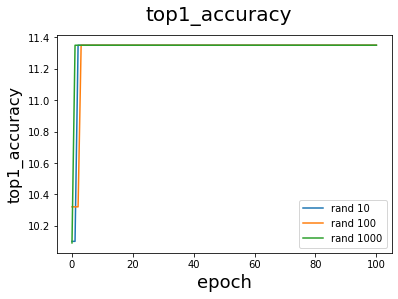

In [68]:
for pruner_type in ["none", "synflow", "snip", "grasp", "rand"]:
    print("Starting pruner: ", pruner)
    for model_type in ["fc_cla"]: #, "fc_reg"
        print("Starting model_type: ", model_type)
        compression = 1.0
        prune_epochs = 10
        title = model_type + " " + pruner_type
        if pruner_type == "none":
            pruner = "synflow"
            prune_epochs = 0
        elif pruner_type == "grasp":
            pruner = "grasp"
            prune_epochs = 1
        else:
            pruner = pruner_type
        train_epochs = 100
        depth = 6
        widths = [10, 100, 1000]
        metric_list = ["budge", "train_loss", "test_loss", "top1_accuracy"]
        
        pruner_multiple_widths_plot_loop(model_type, pruner, compression, 
                                         prune_epochs, train_epochs, depth, 
                                         widths, metric_list, title)
            

In [13]:
def pruner_multiple_pruners_single_width_plot_loop(model_type, pruner_list, compression, prune_epochs, 
                                     train_epochs, depth, width, col_list, title=""):
    metrics = {}
    for pruner in pruner_list:
        _prune_epochs = prune_epochs 
        _pruner = pruner
        if pruner == "none":
            _pruner = "synflow"
            _prune_epochs = 0
        elif pruner == "synflow":
            _pruner = "synflow"
            _prune_epochs = 10
        elif pruner == "snip":
            _pruner = "snip"
            _prune_epochs = 1
        elif pruner == "grasp":
            _pruner = "grasp"
            _prune_epochs = 1
        elif pruner == "rand":
            _pruner = "rand"
            _prune_epochs = 1
        res = prune_train_loop(model_type, _pruner, compression, _prune_epochs, train_epochs, depth, width)
        metrics[pruner] = res
    
    for metric_col in col_list:
        plot_and_save(metric_col, metrics, pruner_list, width, title)

In [86]:
pruner_multiple_pruners_single_width_plot_loop("fc_reg", ["none", "synflow", "snip", "grasp", "rand"], 1.0, 10, 200, 
                                               4, 1000, ["budge", "train_loss", "test_loss", "top1_accuracy"])

Pruning only
Loading mnist dataset.
Creating default-fc model.
Classification: Depth 4, Width 1000, Scale 1
Regression: Depth 4, Width 1000, Scale 1
Regression: Depth 4, Width 1000, Scale 1
Using MSE Loss


0it [00:00, ?it/s]
0it [00:00, ?it/s]

Pruning with synflow for 0 epochs.
Sparsity: 0.1
ERROR: 2785000.0 prunable parameters remaining, expected 278500.0
Parameter Sparsity: 2788001/2788001 (1.0000)
FLOP Sparsity: 2788001/2788001 (1.0000)



  0%|          | 0/200 [00:00<?, ?it/s]/home/udit/anaconda3/envs/synflow-py3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/udit/anaconda3/envs/synflow-py3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 1/200 [00:02<09:09,  2.76s/it]

Epoch: 0 - metrics [8.571567587534586, 8.409853910827637, 0.0, 0]


  1%|          | 2/200 [00:05<09:10,  2.78s/it]

Epoch: 1 - metrics [8.406377491251627, 8.62583992767334, 0.0, 0.005132513]


  2%|▏         | 3/200 [00:08<09:07,  2.78s/it]

Epoch: 2 - metrics [8.40856339009603, 8.103871282958984, 0.0, 0.008867683]


  2%|▏         | 4/200 [00:11<09:07,  2.80s/it]

Epoch: 3 - metrics [8.39798657430013, 8.23466099243164, 0.0, 0.011786127]


  2%|▎         | 5/200 [00:13<09:04,  2.79s/it]

Epoch: 4 - metrics [8.395904463704428, 8.213145626068115, 0.0, 0.014576236]


  3%|▎         | 6/200 [00:16<09:03,  2.80s/it]

Epoch: 5 - metrics [8.382811168924967, 8.14911165008545, 0.0, 0.01695734]


  4%|▎         | 7/200 [00:19<08:59,  2.80s/it]

Epoch: 6 - metrics [8.389012953186036, 8.244990425109863, 0.0, 0.019292502]


  4%|▍         | 8/200 [00:22<08:59,  2.81s/it]

Epoch: 7 - metrics [8.395798489379883, 8.202087423706054, 0.0, 0.021821933]


  4%|▍         | 9/200 [00:25<08:55,  2.80s/it]

Epoch: 8 - metrics [8.386049180094401, 8.319644215393067, 0.0, 0.023883272]


  5%|▌         | 10/200 [00:27<08:49,  2.79s/it]

Epoch: 9 - metrics [8.381026626078288, 8.175634413146973, 0.0, 0.025993207]


  6%|▌         | 11/200 [00:30<08:47,  2.79s/it]

Epoch: 10 - metrics [8.380667173512776, 8.160478520965576, 0.0, 0.028133886]


  6%|▌         | 12/200 [00:33<08:44,  2.79s/it]

Epoch: 11 - metrics [8.379715170796713, 8.150292550659179, 0.0, 0.029989036]


  6%|▋         | 13/200 [00:36<08:45,  2.81s/it]

Epoch: 12 - metrics [8.376023613993327, 8.12627154159546, 0.0, 0.032001425]


  7%|▋         | 14/200 [00:39<08:48,  2.84s/it]

Epoch: 13 - metrics [8.372716438293457, 8.257804133605957, 0.0, 0.033499733]


  8%|▊         | 15/200 [00:42<08:47,  2.85s/it]

Epoch: 14 - metrics [8.370829685719809, 8.20832299041748, 0.0, 0.03539144]


  8%|▊         | 16/200 [00:45<08:43,  2.84s/it]

Epoch: 15 - metrics [8.376528157552084, 8.14241990814209, 0.0, 0.037113637]


  8%|▊         | 17/200 [00:47<08:40,  2.84s/it]

Epoch: 16 - metrics [8.37153229675293, 8.158533743286133, 0.0, 0.03879325]


  9%|▉         | 18/200 [00:50<08:33,  2.82s/it]

Epoch: 17 - metrics [8.37016811726888, 8.213699684143066, 0.0, 0.04046513]


 10%|▉         | 19/200 [00:53<08:28,  2.81s/it]

Epoch: 18 - metrics [8.365845200093588, 8.170915940093995, 0.0, 0.042051226]


 10%|█         | 20/200 [00:56<08:24,  2.80s/it]

Epoch: 19 - metrics [8.366769703420003, 8.196137532043457, 0.0, 0.043740887]


 10%|█         | 21/200 [00:59<08:23,  2.81s/it]

Epoch: 20 - metrics [8.366383302052816, 8.241388822937012, 0.0, 0.04485094]


 11%|█         | 22/200 [01:01<08:18,  2.80s/it]

Epoch: 21 - metrics [8.369525449117024, 8.210182890319825, 0.0, 0.046317585]


 12%|█▏        | 23/200 [01:04<08:13,  2.79s/it]

Epoch: 22 - metrics [8.366473221333822, 8.13723606185913, 0.0, 0.047873132]


 12%|█▏        | 24/200 [01:07<08:11,  2.79s/it]

Epoch: 23 - metrics [8.36217468922933, 8.222277603149415, 0.0, 0.04912452]


 12%|█▎        | 25/200 [01:10<08:11,  2.81s/it]

Epoch: 24 - metrics [8.363760146077475, 8.149082365417481, 0.0, 0.050538067]


 13%|█▎        | 26/200 [01:13<08:11,  2.82s/it]

Epoch: 25 - metrics [8.363287108357747, 8.147725580596925, 0.0, 0.05178717]


 14%|█▎        | 27/200 [01:15<08:10,  2.83s/it]

Epoch: 26 - metrics [8.360782434590657, 8.213998059082032, 0.0, 0.052923296]


 14%|█▍        | 28/200 [01:18<08:03,  2.81s/it]

Epoch: 27 - metrics [8.359766751098633, 8.155097010803223, 0.0, 0.054344602]


 14%|█▍        | 29/200 [01:21<07:59,  2.81s/it]

Epoch: 28 - metrics [8.359227096048992, 8.20364401626587, 0.0, 0.0552636]


 15%|█▌        | 30/200 [01:24<07:56,  2.80s/it]

Epoch: 29 - metrics [8.358718022664387, 8.147395962524413, 0.0, 0.056434263]


 16%|█▌        | 31/200 [01:27<07:50,  2.79s/it]

Epoch: 30 - metrics [8.356927571105958, 8.185406436920166, 0.0, 0.057586305]


 16%|█▌        | 32/200 [01:29<07:48,  2.79s/it]

Epoch: 31 - metrics [8.35698587290446, 8.156526107788086, 0.0, 0.058522686]


 16%|█▋        | 33/200 [01:32<07:46,  2.80s/it]

Epoch: 32 - metrics [8.35633947652181, 8.167564790344239, 0.0, 0.05943684]


 17%|█▋        | 34/200 [01:35<07:46,  2.81s/it]

Epoch: 33 - metrics [8.356818721516927, 8.164388925933839, 0.0, 0.06051488]


 18%|█▊        | 35/200 [01:38<07:45,  2.82s/it]

Epoch: 34 - metrics [8.357983710225422, 8.217116328430176, 0.0, 0.061310645]


 18%|█▊        | 36/200 [01:41<07:43,  2.83s/it]

Epoch: 35 - metrics [8.35676553141276, 8.182792893218995, 0.0, 0.062319897]


 18%|█▊        | 37/200 [01:43<07:40,  2.83s/it]

Epoch: 36 - metrics [8.352611149342854, 8.173891574096679, 0.0, 0.06327119]


 19%|█▉        | 38/200 [01:46<07:36,  2.82s/it]

Epoch: 37 - metrics [8.355440222167969, 8.167539058685303, 0.0, 0.06397544]


 20%|█▉        | 39/200 [01:49<07:32,  2.81s/it]

Epoch: 38 - metrics [8.355213798777262, 8.199365719604492, 0.0, 0.06466606]


 20%|██        | 40/200 [01:52<07:27,  2.80s/it]

Epoch: 39 - metrics [8.35519066060384, 8.170091752624511, 0.0, 0.06551225]


 20%|██        | 41/200 [01:55<07:23,  2.79s/it]

Epoch: 40 - metrics [8.35463363087972, 8.175841395568847, 0.0, 0.066432856]


 21%|██        | 42/200 [01:57<07:22,  2.80s/it]

Epoch: 41 - metrics [8.353861390686035, 8.187974631500245, 0.0, 0.06711376]


 22%|██▏       | 43/200 [02:00<07:19,  2.80s/it]

Epoch: 42 - metrics [8.35216203842163, 8.201000260925293, 0.0, 0.06765056]


 22%|██▏       | 44/200 [02:03<07:15,  2.79s/it]

Epoch: 43 - metrics [8.353784940592448, 8.180379972839356, 0.0, 0.06879027]


 22%|██▎       | 45/200 [02:06<07:16,  2.82s/it]

Epoch: 44 - metrics [8.353712570699056, 8.189328286743164, 0.0, 0.06907336]


 23%|██▎       | 46/200 [02:09<07:12,  2.81s/it]

Epoch: 45 - metrics [8.35250880686442, 8.175598371887206, 0.0, 0.06982146]


 24%|██▎       | 47/200 [02:12<07:10,  2.82s/it]

Epoch: 46 - metrics [8.351789321390788, 8.165200440979003, 0.0, 0.070372604]


 24%|██▍       | 48/200 [02:14<07:08,  2.82s/it]

Epoch: 47 - metrics [8.353061860656739, 8.19772407913208, 0.0, 0.07107674]


 24%|██▍       | 49/200 [02:17<07:02,  2.80s/it]

Epoch: 48 - metrics [8.35240901743571, 8.190702159118652, 0.0, 0.07175838]


 25%|██▌       | 50/200 [02:20<07:01,  2.81s/it]

Epoch: 49 - metrics [8.352818524169923, 8.190481436157226, 0.0, 0.072111554]


 26%|██▌       | 51/200 [02:23<07:00,  2.82s/it]

Epoch: 50 - metrics [8.351740544891358, 8.179101084899902, 0.0, 0.07265646]


 26%|██▌       | 52/200 [02:26<06:55,  2.80s/it]

Epoch: 51 - metrics [8.351297393290201, 8.169713450622558, 0.0, 0.07331522]


 26%|██▋       | 53/200 [02:28<06:50,  2.79s/it]

Epoch: 52 - metrics [8.351719951375326, 8.177783683776855, 0.0, 0.07376854]


 27%|██▋       | 54/200 [02:31<06:49,  2.81s/it]

Epoch: 53 - metrics [8.351406026713054, 8.200138664245605, 0.0, 0.073966436]


 28%|██▊       | 55/200 [02:34<06:46,  2.81s/it]

Epoch: 54 - metrics [8.350067496744792, 8.188803128051758, 0.0, 0.07514345]


 28%|██▊       | 56/200 [02:37<06:47,  2.83s/it]

Epoch: 55 - metrics [8.351805700429281, 8.173647447967529, 0.0, 0.075484]


 28%|██▊       | 57/200 [02:40<06:45,  2.84s/it]

Epoch: 56 - metrics [8.350222918701173, 8.172251055145264, 0.0, 0.07598457]


 29%|██▉       | 58/200 [02:42<06:40,  2.82s/it]

Epoch: 57 - metrics [8.351309317016602, 8.173882414245606, 0.0, 0.07592239]


 30%|██▉       | 59/200 [02:45<06:37,  2.82s/it]

Epoch: 58 - metrics [8.351559047444661, 8.178100984191895, 0.0, 0.07614246]


 30%|███       | 60/200 [02:48<06:33,  2.81s/it]

Epoch: 59 - metrics [8.350653489685058, 8.170292337036132, 0.0, 0.07720109]


 30%|███       | 61/200 [02:51<06:29,  2.80s/it]

Epoch: 60 - metrics [8.350403707885743, 8.206794664764404, 0.0, 0.07684028]


 31%|███       | 62/200 [02:54<06:27,  2.81s/it]

Epoch: 61 - metrics [8.350890258789063, 8.198381811523438, 0.0, 0.07820011]


 32%|███▏      | 63/200 [02:56<06:22,  2.80s/it]

Epoch: 62 - metrics [8.349953527323406, 8.180575953674316, 0.0, 0.07783956]


 32%|███▏      | 64/200 [02:59<06:20,  2.80s/it]

Epoch: 63 - metrics [8.350417811075847, 8.164792790222167, 0.0, 0.07850639]


 32%|███▎      | 65/200 [03:02<06:17,  2.80s/it]

Epoch: 64 - metrics [8.350862380981445, 8.178728616333007, 0.0, 0.07903054]


 33%|███▎      | 66/200 [03:05<06:12,  2.78s/it]

Epoch: 65 - metrics [8.349818301900228, 8.188582612609864, 0.0, 0.07912815]


 34%|███▎      | 67/200 [03:08<06:09,  2.78s/it]

Epoch: 66 - metrics [8.350026687622071, 8.192086750793457, 0.0, 0.07946148]


 34%|███▍      | 68/200 [03:10<06:08,  2.79s/it]

Epoch: 67 - metrics [8.350273359680175, 8.179976837921142, 0.0, 0.07956478]


 34%|███▍      | 69/200 [03:13<06:04,  2.78s/it]

Epoch: 68 - metrics [8.34928784790039, 8.179744505310058, 0.0, 0.080078416]


 35%|███▌      | 70/200 [03:16<06:02,  2.79s/it]

Epoch: 69 - metrics [8.350343951416015, 8.201155459594727, 0.0, 0.07961137]


 36%|███▌      | 71/200 [03:19<06:01,  2.81s/it]

Epoch: 70 - metrics [8.351335729471842, 8.176173046875, 0.0, 0.08057358]


 36%|███▌      | 72/200 [03:22<05:58,  2.80s/it]

Epoch: 71 - metrics [8.350173202006022, 8.180479299926757, 0.0, 0.081192166]


 36%|███▋      | 73/200 [03:24<05:57,  2.81s/it]

Epoch: 72 - metrics [8.349113075764974, 8.165173692321778, 0.0, 0.08118262]


 37%|███▋      | 74/200 [03:27<05:54,  2.81s/it]

Epoch: 73 - metrics [8.34916280263265, 8.19710354309082, 0.0, 0.080813736]


 38%|███▊      | 75/200 [03:30<05:50,  2.81s/it]

Epoch: 74 - metrics [8.3497119237264, 8.166892832946777, 0.0, 0.08179609]


 38%|███▊      | 76/200 [03:33<05:47,  2.80s/it]

Epoch: 75 - metrics [8.349399317932129, 8.176393502044677, 0.0, 0.08209427]


 38%|███▊      | 77/200 [03:36<05:46,  2.82s/it]

Epoch: 76 - metrics [8.349882187398276, 8.180996497344971, 0.0, 0.08197883]


 39%|███▉      | 78/200 [03:38<05:42,  2.81s/it]

Epoch: 77 - metrics [8.350446574401856, 8.176340142059326, 0.0, 0.08233108]


 40%|███▉      | 79/200 [03:41<05:38,  2.80s/it]

Epoch: 78 - metrics [8.349833111826579, 8.172825200653076, 0.0, 0.082757406]


 40%|████      | 80/200 [03:44<05:34,  2.79s/it]

Epoch: 79 - metrics [8.350096788533529, 8.17034511871338, 0.0, 0.08317825]


 40%|████      | 81/200 [03:47<05:31,  2.78s/it]

Epoch: 80 - metrics [8.350273202514648, 8.180275382995605, 0.0, 0.083082184]


 41%|████      | 82/200 [03:50<05:33,  2.83s/it]

Epoch: 81 - metrics [8.34778643697103, 8.170754447937012, 0.0, 0.08361868]


 42%|████▏     | 83/200 [03:53<05:31,  2.84s/it]

Epoch: 82 - metrics [8.348476635742188, 8.187875119018555, 0.0, 0.083003104]


 42%|████▏     | 84/200 [03:55<05:27,  2.82s/it]

Epoch: 83 - metrics [8.349578446960448, 8.182943804931641, 0.0, 0.08374426]


 42%|████▎     | 85/200 [03:58<05:23,  2.81s/it]

Epoch: 84 - metrics [8.349697475941976, 8.189659484100341, 0.0, 0.084058866]


 43%|████▎     | 86/200 [04:01<05:20,  2.81s/it]

Epoch: 85 - metrics [8.35039192606608, 8.164283166503907, 0.0, 0.08460133]


 44%|████▎     | 87/200 [04:04<05:19,  2.83s/it]

Epoch: 86 - metrics [8.350450002543132, 8.17363621673584, 0.0, 0.084334336]


 44%|████▍     | 88/200 [04:07<05:16,  2.83s/it]

Epoch: 87 - metrics [8.348469474283855, 8.188465377807617, 0.0, 0.08405088]


 44%|████▍     | 89/200 [04:09<05:12,  2.82s/it]

Epoch: 88 - metrics [8.34917451502482, 8.171563356781006, 0.0, 0.08480027]


 45%|████▌     | 90/200 [04:12<05:10,  2.82s/it]

Epoch: 89 - metrics [8.349173174031575, 8.189670677947998, 0.0, 0.08445617]


 46%|████▌     | 91/200 [04:15<05:06,  2.82s/it]

Epoch: 90 - metrics [8.347176067097982, 8.17521035308838, 0.0, 0.08589824]


 46%|████▌     | 92/200 [04:18<05:03,  2.81s/it]

Epoch: 91 - metrics [8.349603682963053, 8.177931417083741, 0.0, 0.085218415]


 46%|████▋     | 93/200 [04:21<05:00,  2.80s/it]

Epoch: 92 - metrics [8.349000708516439, 8.170266535949708, 0.0, 0.08514775]


 47%|████▋     | 94/200 [04:24<04:58,  2.82s/it]

Epoch: 93 - metrics [8.348465608723957, 8.161049479675293, 0.0, 0.08536647]


 48%|████▊     | 95/200 [04:26<04:54,  2.81s/it]

Epoch: 94 - metrics [8.349575350952149, 8.172429245758057, 0.0, 0.08549471]


 48%|████▊     | 96/200 [04:29<04:53,  2.82s/it]

Epoch: 95 - metrics [8.347782978820801, 8.170973363494873, 0.0, 0.08587882]


 48%|████▊     | 97/200 [04:32<04:49,  2.81s/it]

Epoch: 96 - metrics [8.348534624226888, 8.174828373718261, 0.0, 0.08617631]


 49%|████▉     | 98/200 [04:35<04:47,  2.81s/it]

Epoch: 97 - metrics [8.349163793945312, 8.196533551025391, 0.0, 0.08535861]


 50%|████▉     | 99/200 [04:38<04:47,  2.84s/it]

Epoch: 98 - metrics [8.349269887288411, 8.181072882080079, 0.0, 0.08601328]


 50%|█████     | 100/200 [04:40<04:42,  2.83s/it]

Epoch: 99 - metrics [8.348641785176595, 8.207199530029296, 0.0, 0.085324466]


 50%|█████     | 101/200 [04:43<04:38,  2.81s/it]

Epoch: 100 - metrics [8.349884074401855, 8.205581336975097, 0.0, 0.08567395]


 51%|█████     | 102/200 [04:46<04:34,  2.80s/it]

Epoch: 101 - metrics [8.349351233673096, 8.180013423156739, 0.0, 0.08633841]


 52%|█████▏    | 103/200 [04:49<04:34,  2.83s/it]

Epoch: 102 - metrics [8.349693964131673, 8.18155247039795, 0.0, 0.086562596]


 52%|█████▏    | 104/200 [04:52<04:29,  2.81s/it]

Epoch: 103 - metrics [8.349021046447755, 8.187206964874267, 0.0, 0.08698168]


 52%|█████▎    | 105/200 [04:54<04:26,  2.80s/it]

Epoch: 104 - metrics [8.34847079518636, 8.17757241897583, 0.0, 0.08749273]


 53%|█████▎    | 106/200 [04:57<04:23,  2.80s/it]

Epoch: 105 - metrics [8.34966015777588, 8.180827764129639, 0.0, 0.087132335]


 54%|█████▎    | 107/200 [05:00<04:20,  2.80s/it]

Epoch: 106 - metrics [8.349493710835775, 8.179361621856689, 0.0, 0.08705417]


 54%|█████▍    | 108/200 [05:03<04:16,  2.79s/it]

Epoch: 107 - metrics [8.347782719421387, 8.190218452453614, 0.0, 0.08691251]


 55%|█████▍    | 109/200 [05:06<04:14,  2.80s/it]

Epoch: 108 - metrics [8.348547513580323, 8.187825672912597, 0.0, 0.08724249]


 55%|█████▌    | 110/200 [05:08<04:12,  2.81s/it]

Epoch: 109 - metrics [8.34931667989095, 8.171873042297364, 0.0, 0.08761763]


 56%|█████▌    | 111/200 [05:11<04:11,  2.83s/it]

Epoch: 110 - metrics [8.348227605692546, 8.17028313446045, 0.0, 0.08754164]


 56%|█████▌    | 112/200 [05:14<04:07,  2.81s/it]

Epoch: 111 - metrics [8.349203098551433, 8.175820040893555, 0.0, 0.08741395]


 56%|█████▋    | 113/200 [05:17<04:04,  2.81s/it]

Epoch: 112 - metrics [8.347847083536784, 8.180297340393066, 0.0, 0.08776987]


 57%|█████▋    | 114/200 [05:20<04:01,  2.81s/it]

Epoch: 113 - metrics [8.348471398417155, 8.183205228424072, 0.0, 0.08801688]


 57%|█████▊    | 115/200 [05:22<03:58,  2.80s/it]

Epoch: 114 - metrics [8.349585229237874, 8.177444348144531, 0.0, 0.08795173]


 58%|█████▊    | 116/200 [05:25<03:55,  2.80s/it]

Epoch: 115 - metrics [8.349045667266846, 8.17576597366333, 0.0, 0.088541836]


 58%|█████▊    | 117/200 [05:28<03:53,  2.81s/it]

Epoch: 116 - metrics [8.34899461517334, 8.199754579162597, 0.0, 0.08785464]


 59%|█████▉    | 118/200 [05:31<03:49,  2.80s/it]

Epoch: 117 - metrics [8.348286361948649, 8.180122037506104, 0.0, 0.0883646]


 60%|█████▉    | 119/200 [05:34<03:46,  2.80s/it]

Epoch: 118 - metrics [8.349188528442383, 8.182270318603516, 0.0, 0.08867424]


 60%|██████    | 120/200 [05:37<03:45,  2.81s/it]

Epoch: 119 - metrics [8.349016643778484, 8.185089065551757, 0.0, 0.08860026]


 60%|██████    | 121/200 [05:39<03:42,  2.81s/it]

Epoch: 120 - metrics [8.349148791503906, 8.182811143493652, 0.0, 0.0888406]


 61%|██████    | 122/200 [05:42<03:38,  2.80s/it]

Epoch: 121 - metrics [8.34938898264567, 8.189162814331056, 0.0, 0.08847294]


 62%|██████▏   | 123/200 [05:45<03:35,  2.79s/it]

Epoch: 122 - metrics [8.349202881368, 8.18107668762207, 0.0, 0.08925968]


 62%|██████▏   | 124/200 [05:48<03:31,  2.79s/it]

Epoch: 123 - metrics [8.348537543741863, 8.184467222595215, 0.0, 0.08920344]


 62%|██████▎   | 125/200 [05:50<03:29,  2.79s/it]

Epoch: 124 - metrics [8.348662892150879, 8.176304045104981, 0.0, 0.08948751]


 63%|██████▎   | 126/200 [05:53<03:26,  2.80s/it]

Epoch: 125 - metrics [8.349186892191568, 8.189020695495605, 0.0, 0.08855769]


 64%|██████▎   | 127/200 [05:56<03:23,  2.79s/it]

Epoch: 126 - metrics [8.348532158915202, 8.181776359558105, 0.0, 0.08907752]


 64%|██████▍   | 128/200 [05:59<03:20,  2.79s/it]

Epoch: 127 - metrics [8.349086694335938, 8.17416474685669, 0.0, 0.089322075]


 64%|██████▍   | 129/200 [06:02<03:18,  2.80s/it]

Epoch: 128 - metrics [8.347879912821451, 8.179493307495116, 0.0, 0.08940831]


 65%|██████▌   | 130/200 [06:04<03:16,  2.80s/it]

Epoch: 129 - metrics [8.347089581298828, 8.201661562347413, 0.0, 0.08870167]


 66%|██████▌   | 131/200 [06:07<03:13,  2.81s/it]

Epoch: 130 - metrics [8.349557172139486, 8.179877660369874, 0.0, 0.08978889]


 66%|██████▌   | 132/200 [06:10<03:11,  2.81s/it]

Epoch: 131 - metrics [8.348876373291017, 8.171955297851563, 0.0, 0.08969009]


 66%|██████▋   | 133/200 [06:13<03:09,  2.83s/it]

Epoch: 132 - metrics [8.349017343648274, 8.177786079406738, 0.0, 0.09009551]


 67%|██████▋   | 134/200 [06:16<03:06,  2.83s/it]

Epoch: 133 - metrics [8.34920813293457, 8.175896903991699, 0.0, 0.09022558]


 68%|██████▊   | 135/200 [06:19<03:02,  2.81s/it]

Epoch: 134 - metrics [8.348797323608398, 8.173675233459473, 0.0, 0.090021566]


 68%|██████▊   | 136/200 [06:22<03:02,  2.85s/it]

Epoch: 135 - metrics [8.348180148824056, 8.19029161529541, 0.0, 0.0892524]


 68%|██████▊   | 137/200 [06:24<02:59,  2.85s/it]

Epoch: 136 - metrics [8.348868199157716, 8.175598190307618, 0.0, 0.090086766]


 69%|██████▉   | 138/200 [06:27<02:57,  2.86s/it]

Epoch: 137 - metrics [8.348407743581136, 8.181085248565674, 0.0, 0.08975488]


 70%|██████▉   | 139/200 [06:30<02:53,  2.84s/it]

Epoch: 138 - metrics [8.348555794270833, 8.17668865661621, 0.0, 0.0904535]


 70%|███████   | 140/200 [06:33<02:52,  2.88s/it]

Epoch: 139 - metrics [8.34900477142334, 8.178504796600341, 0.0, 0.09059818]


 70%|███████   | 141/200 [06:36<02:49,  2.87s/it]

Epoch: 140 - metrics [8.348893139394125, 8.170541468811034, 0.0, 0.09026939]


 71%|███████   | 142/200 [06:39<02:46,  2.87s/it]

Epoch: 141 - metrics [8.349415632629395, 8.178677549743652, 0.0, 0.090166256]


 72%|███████▏  | 143/200 [06:42<02:41,  2.84s/it]

Epoch: 142 - metrics [8.346969489542643, 8.187699309539795, 0.0, 0.09018097]


 72%|███████▏  | 144/200 [06:44<02:38,  2.84s/it]

Epoch: 143 - metrics [8.34688011118571, 8.182451321411133, 0.0, 0.09037972]


 72%|███████▎  | 145/200 [06:47<02:36,  2.84s/it]

Epoch: 144 - metrics [8.348460510253906, 8.17590726699829, 0.0, 0.09040744]


 73%|███████▎  | 146/200 [06:50<02:32,  2.83s/it]

Epoch: 145 - metrics [8.347492253112794, 8.18095149459839, 0.0, 0.09071109]


 74%|███████▎  | 147/200 [06:53<02:28,  2.81s/it]

Epoch: 146 - metrics [8.348683871968587, 8.18097696609497, 0.0, 0.091299616]


 74%|███████▍  | 148/200 [06:56<02:25,  2.80s/it]

Epoch: 147 - metrics [8.348766770426431, 8.177388436889649, 0.0, 0.09087834]


 74%|███████▍  | 149/200 [06:58<02:22,  2.79s/it]

Epoch: 148 - metrics [8.349058022816976, 8.184030478668213, 0.0, 0.091406204]


 75%|███████▌  | 150/200 [07:01<02:20,  2.80s/it]

Epoch: 149 - metrics [8.34895901590983, 8.171245670318603, 0.0, 0.09119267]


 76%|███████▌  | 151/200 [07:04<02:17,  2.81s/it]

Epoch: 150 - metrics [8.348352249145508, 8.184712744903564, 0.0, 0.0905212]


 76%|███████▌  | 152/200 [07:07<02:13,  2.79s/it]

Epoch: 151 - metrics [8.349260330200195, 8.177520244598389, 0.0, 0.09169786]


 76%|███████▋  | 153/200 [07:09<02:11,  2.79s/it]

Epoch: 152 - metrics [8.348396751912436, 8.183211004638672, 0.0, 0.091468714]


 77%|███████▋  | 154/200 [07:12<02:09,  2.81s/it]

Epoch: 153 - metrics [8.348908775075277, 8.17184634399414, 0.0, 0.09135828]


 78%|███████▊  | 155/200 [07:15<02:06,  2.82s/it]

Epoch: 154 - metrics [8.347833808898926, 8.1839327545166, 0.0, 0.09108105]


 78%|███████▊  | 156/200 [07:18<02:03,  2.80s/it]

Epoch: 155 - metrics [8.349008389790853, 8.17900632019043, 0.0, 0.0917937]


 78%|███████▊  | 157/200 [07:21<02:00,  2.79s/it]

Epoch: 156 - metrics [8.34893805440267, 8.174991067504882, 0.0, 0.0916955]


 79%|███████▉  | 158/200 [07:24<01:57,  2.80s/it]

Epoch: 157 - metrics [8.349358167521158, 8.178473908233643, 0.0, 0.09156217]


 80%|███████▉  | 159/200 [07:26<01:55,  2.81s/it]

Epoch: 158 - metrics [8.349629002380372, 8.188377395629884, 0.0, 0.09109734]


 80%|████████  | 160/200 [07:29<01:52,  2.81s/it]

Epoch: 159 - metrics [8.348719188435872, 8.174163566589355, 0.0, 0.092026286]


 80%|████████  | 161/200 [07:32<01:49,  2.81s/it]

Epoch: 160 - metrics [8.348360717773437, 8.179388062286376, 0.0, 0.09210335]


 81%|████████  | 162/200 [07:35<01:46,  2.81s/it]

Epoch: 161 - metrics [8.348123419189454, 8.17689363708496, 0.0, 0.09188965]


 82%|████████▏ | 163/200 [07:38<01:43,  2.80s/it]

Epoch: 162 - metrics [8.348698481750489, 8.183206864929199, 0.0, 0.09180041]


 82%|████████▏ | 164/200 [07:40<01:40,  2.80s/it]

Epoch: 163 - metrics [8.349613901774088, 8.186022032165527, 0.0, 0.09162865]


 82%|████████▎ | 165/200 [07:43<01:37,  2.80s/it]

Epoch: 164 - metrics [8.348674581400553, 8.172981634521484, 0.0, 0.09213271]


 83%|████████▎ | 166/200 [07:46<01:34,  2.79s/it]

Epoch: 165 - metrics [8.348653586832683, 8.173001362609863, 0.0, 0.092237964]


 84%|████████▎ | 167/200 [07:49<01:32,  2.80s/it]

Epoch: 166 - metrics [8.347782348632812, 8.176618427276612, 0.0, 0.0920878]


 84%|████████▍ | 168/200 [07:52<01:29,  2.79s/it]

Epoch: 167 - metrics [8.348208417256673, 8.172936920166016, 0.0, 0.09219007]


 84%|████████▍ | 169/200 [07:54<01:26,  2.78s/it]

Epoch: 168 - metrics [8.348338112894695, 8.171680592346192, 0.0, 0.09227617]


 85%|████████▌ | 170/200 [07:57<01:23,  2.79s/it]

Epoch: 169 - metrics [8.348014995829264, 8.172801257324219, 0.0, 0.092722714]


 86%|████████▌ | 171/200 [08:00<01:21,  2.82s/it]

Epoch: 170 - metrics [8.348991700744628, 8.169680041503906, 0.0, 0.092247896]


 86%|████████▌ | 172/200 [08:03<01:18,  2.81s/it]

Epoch: 171 - metrics [8.348797242736817, 8.163464041900635, 0.0, 0.0922706]


 86%|████████▋ | 173/200 [08:06<01:15,  2.79s/it]

Epoch: 172 - metrics [8.348568324788411, 8.173300592041016, 0.0, 0.09204324]


 87%|████████▋ | 174/200 [08:08<01:12,  2.79s/it]

Epoch: 173 - metrics [8.348071167500814, 8.173181387329102, 0.0, 0.092191614]


 88%|████████▊ | 175/200 [08:11<01:09,  2.79s/it]

Epoch: 174 - metrics [8.347945552317302, 8.169599159240722, 0.0, 0.09268548]


 88%|████████▊ | 176/200 [08:14<01:07,  2.80s/it]

Epoch: 175 - metrics [8.348672222391764, 8.171819828796387, 0.0, 0.09275116]


 88%|████████▊ | 177/200 [08:17<01:04,  2.79s/it]

Epoch: 176 - metrics [8.349318419392903, 8.191534310913086, 0.0, 0.092013]


 89%|████████▉ | 178/200 [08:20<01:01,  2.79s/it]

Epoch: 177 - metrics [8.349139894866944, 8.17817099685669, 0.0, 0.09280489]


 90%|████████▉ | 179/200 [08:22<00:58,  2.81s/it]

Epoch: 178 - metrics [8.34865445505778, 8.192245162200928, 0.0, 0.092152886]


 90%|█████████ | 180/200 [08:25<00:56,  2.81s/it]

Epoch: 179 - metrics [8.349187157185872, 8.181469696044921, 0.0, 0.09254682]


 90%|█████████ | 181/200 [08:28<00:53,  2.82s/it]

Epoch: 180 - metrics [8.34866418202718, 8.179113162231445, 0.0, 0.09344631]


 91%|█████████ | 182/200 [08:31<00:50,  2.81s/it]

Epoch: 181 - metrics [8.348890288035076, 8.182338303375245, 0.0, 0.09242847]


 92%|█████████▏| 183/200 [08:34<00:47,  2.80s/it]

Epoch: 182 - metrics [8.348034070332846, 8.183064793395996, 0.0, 0.09247961]


 92%|█████████▏| 184/200 [08:36<00:45,  2.82s/it]

Epoch: 183 - metrics [8.3470560546875, 8.166099668884277, 0.0, 0.09325774]


 92%|█████████▎| 185/200 [08:39<00:42,  2.85s/it]

Epoch: 184 - metrics [8.348111134084066, 8.165080444335938, 0.0, 0.09287801]


 93%|█████████▎| 186/200 [08:42<00:39,  2.83s/it]

Epoch: 185 - metrics [8.348043177286783, 8.168125830078125, 0.0, 0.09335464]


 94%|█████████▎| 187/200 [08:45<00:36,  2.83s/it]

Epoch: 186 - metrics [8.34905194753011, 8.17604412536621, 0.0, 0.09286098]


 94%|█████████▍| 188/200 [08:48<00:33,  2.83s/it]

Epoch: 187 - metrics [8.349384079233806, 8.170825527191163, 0.0, 0.093224384]


 94%|█████████▍| 189/200 [08:51<00:31,  2.83s/it]

Epoch: 188 - metrics [8.348468950653077, 8.178585269165039, 0.0, 0.093004405]


 95%|█████████▌| 190/200 [08:53<00:28,  2.82s/it]

Epoch: 189 - metrics [8.347227104695637, 8.192593789672852, 0.0, 0.09255954]


 96%|█████████▌| 191/200 [08:56<00:25,  2.81s/it]

Epoch: 190 - metrics [8.348553484598796, 8.179023988342285, 0.0, 0.09342399]


 96%|█████████▌| 192/200 [08:59<00:22,  2.79s/it]

Epoch: 191 - metrics [8.348502908325194, 8.171879629516601, 0.0, 0.093570195]


 96%|█████████▋| 193/200 [09:02<00:19,  2.80s/it]

Epoch: 192 - metrics [8.348771136983236, 8.174884712219239, 0.0, 0.09374733]


 97%|█████████▋| 194/200 [09:05<00:16,  2.82s/it]

Epoch: 193 - metrics [8.348576392618815, 8.171422888946534, 0.0, 0.094067946]


 98%|█████████▊| 195/200 [09:07<00:14,  2.81s/it]

Epoch: 194 - metrics [8.348645548756917, 8.16264439163208, 0.0, 0.093958564]


 98%|█████████▊| 196/200 [09:10<00:11,  2.82s/it]

Epoch: 195 - metrics [8.348843370056152, 8.170101941680908, 0.0, 0.09375139]


 98%|█████████▊| 197/200 [09:13<00:08,  2.82s/it]

Epoch: 196 - metrics [8.349231182352701, 8.181683444213867, 0.0, 0.09362873]


 99%|█████████▉| 198/200 [09:16<00:05,  2.81s/it]

Epoch: 197 - metrics [8.348482662455242, 8.172771878051758, 0.0, 0.09410107]


100%|█████████▉| 199/200 [09:19<00:02,  2.80s/it]

Epoch: 198 - metrics [8.348930624898275, 8.183690113830567, 0.0, 0.09334668]


100%|██████████| 200/200 [09:21<00:00,  2.81s/it]

Epoch: 199 - metrics [8.348086371866861, 8.172799551391602, 0.0, 0.09418675]
Pruning only
Loading mnist dataset.
Creating default-fc model.
Classification: Depth 4, Width 1000, Scale 1
Regression: Depth 4, Width 1000, Scale 1
Regression: Depth 4, Width 1000, Scale 1
Using MSE Loss



0it [00:00, ?it/s]
  0%|          | 0/10 [00:00<?, ?it/s]

Pruning with synflow for 10 epochs.
Sparsity: 0.1


100%|██████████| 10/10 [00:01<00:00,  7.57it/s]

Parameter Sparsity: 281500/2788001 (0.1010)
FLOP Sparsity: 281500/2788001 (0.1010)



  0%|          | 1/200 [00:02<09:28,  2.86s/it]

Epoch: 0 - metrics [8.943054184977214, 8.378805897521973, 0.0, 0]


  1%|          | 2/200 [00:05<09:19,  2.83s/it]

Epoch: 1 - metrics [8.370778318786622, 8.287276475524902, 0.0, 0.007311409]


  2%|▏         | 3/200 [00:08<09:20,  2.85s/it]

Epoch: 2 - metrics [8.367713311513265, 8.226973834228515, 0.0, 0.011533644]


  2%|▏         | 4/200 [00:11<09:13,  2.82s/it]

Epoch: 3 - metrics [8.36525401916504, 8.230876809692383, 0.0, 0.015364373]


  2%|▎         | 5/200 [00:14<09:11,  2.83s/it]

Epoch: 4 - metrics [8.363622677612305, 8.229544367980957, 0.0, 0.018326199]


  3%|▎         | 6/200 [00:16<09:07,  2.82s/it]

Epoch: 5 - metrics [8.361494270324707, 8.222012706756592, 0.0, 0.020957144]


  4%|▎         | 7/200 [00:19<09:02,  2.81s/it]

Epoch: 6 - metrics [8.360661580403645, 8.202626843261719, 0.0, 0.023728864]


  4%|▍         | 8/200 [00:22<08:57,  2.80s/it]

Epoch: 7 - metrics [8.362694025421142, 8.230747958374023, 0.0, 0.025889123]


  4%|▍         | 9/200 [00:25<08:53,  2.79s/it]

Epoch: 8 - metrics [8.357209532674153, 8.200545269775391, 0.0, 0.028192762]


  5%|▌         | 10/200 [00:28<08:54,  2.81s/it]

Epoch: 9 - metrics [8.359669760131837, 8.194021984863282, 0.0, 0.03043058]


  6%|▌         | 11/200 [00:30<08:50,  2.81s/it]

Epoch: 10 - metrics [8.356396399943034, 8.20847825012207, 0.0, 0.032441515]


  6%|▌         | 12/200 [00:33<08:47,  2.80s/it]

Epoch: 11 - metrics [8.35933753636678, 8.167559886169434, 0.0, 0.034623414]


  6%|▋         | 13/200 [00:36<08:43,  2.80s/it]

Epoch: 12 - metrics [8.357277838134765, 8.228422442626954, 0.0, 0.036086388]


  7%|▋         | 14/200 [00:39<08:43,  2.81s/it]

Epoch: 13 - metrics [8.359438536071778, 8.189664781188965, 0.0, 0.03812683]


  8%|▊         | 15/200 [00:42<08:42,  2.82s/it]

Epoch: 14 - metrics [8.357270731608073, 8.21940697479248, 0.0, 0.03991907]


  8%|▊         | 16/200 [00:44<08:38,  2.82s/it]

Epoch: 15 - metrics [8.355834309387207, 8.205066566467286, 0.0, 0.041480027]


  8%|▊         | 17/200 [00:47<08:32,  2.80s/it]

Epoch: 16 - metrics [8.358082588704427, 8.209313328552247, 0.0, 0.04307697]


  9%|▉         | 18/200 [00:50<08:33,  2.82s/it]

Epoch: 17 - metrics [8.355198689778646, 8.201445783996583, 0.0, 0.04468532]


 10%|▉         | 19/200 [00:53<08:29,  2.82s/it]

Epoch: 18 - metrics [8.356159155782064, 8.17190761566162, 0.0, 0.046452668]


 10%|█         | 20/200 [00:56<08:27,  2.82s/it]

Epoch: 19 - metrics [8.355622106424967, 8.186684341430665, 0.0, 0.047956977]


 10%|█         | 21/200 [00:59<08:23,  2.81s/it]

Epoch: 20 - metrics [8.353887830607096, 8.219300100708008, 0.0, 0.04920255]


 11%|█         | 22/200 [01:01<08:23,  2.83s/it]

Epoch: 21 - metrics [8.355026076761881, 8.24083643951416, 0.0, 0.050311103]


 12%|█▏        | 23/200 [01:04<08:16,  2.81s/it]

Epoch: 22 - metrics [8.354893251037598, 8.212442349243164, 0.0, 0.051755246]


 12%|█▏        | 24/200 [01:07<08:11,  2.79s/it]

Epoch: 23 - metrics [8.35641496887207, 8.211550146484376, 0.0, 0.05327523]


 12%|█▎        | 25/200 [01:10<08:10,  2.80s/it]

Epoch: 24 - metrics [8.354285245259604, 8.191928408813476, 0.0, 0.054886308]


 13%|█▎        | 26/200 [01:13<08:11,  2.83s/it]

Epoch: 25 - metrics [8.352931982421875, 8.204834092712403, 0.0, 0.055828884]


 14%|█▎        | 27/200 [01:15<08:08,  2.83s/it]

Epoch: 26 - metrics [8.35387381998698, 8.194589143371582, 0.0, 0.05740841]


 14%|█▍        | 28/200 [01:18<08:06,  2.83s/it]

Epoch: 27 - metrics [8.352982125091552, 8.190917449188232, 0.0, 0.058325447]


 14%|█▍        | 29/200 [01:21<08:00,  2.81s/it]

Epoch: 28 - metrics [8.351977941894532, 8.22588088684082, 0.0, 0.05936947]


 15%|█▌        | 30/200 [01:24<07:55,  2.80s/it]

Epoch: 29 - metrics [8.353324685668944, 8.192927914428711, 0.0, 0.061007954]


 16%|█▌        | 31/200 [01:27<07:54,  2.81s/it]

Epoch: 30 - metrics [8.353580509440103, 8.189477301025391, 0.0, 0.062033385]


 16%|█▌        | 32/200 [01:29<07:50,  2.80s/it]

Epoch: 31 - metrics [8.352772734069823, 8.25561894454956, 0.0, 0.06264336]


 16%|█▋        | 33/200 [01:32<07:49,  2.81s/it]

Epoch: 32 - metrics [8.352797678629557, 8.197642632293702, 0.0, 0.0641053]


 17%|█▋        | 34/200 [01:35<07:45,  2.80s/it]

Epoch: 33 - metrics [8.35236100285848, 8.182252571105957, 0.0, 0.06522537]


 18%|█▊        | 35/200 [01:38<07:41,  2.79s/it]

Epoch: 34 - metrics [8.350672309875488, 8.192984159851074, 0.0, 0.06632662]


 18%|█▊        | 36/200 [01:41<07:38,  2.79s/it]

Epoch: 35 - metrics [8.351012583414713, 8.18368847808838, 0.0, 0.06751322]


 18%|█▊        | 37/200 [01:43<07:34,  2.79s/it]

Epoch: 36 - metrics [8.352086315917969, 8.191274027252197, 0.0, 0.06856729]


 19%|█▉        | 38/200 [01:46<07:33,  2.80s/it]

Epoch: 37 - metrics [8.351051582336426, 8.20217791595459, 0.0, 0.069121696]


 20%|█▉        | 39/200 [01:49<07:30,  2.80s/it]

Epoch: 38 - metrics [8.352437618509928, 8.233695307922364, 0.0, 0.06976834]


 20%|██        | 40/200 [01:52<07:28,  2.80s/it]

Epoch: 39 - metrics [8.349575240580242, 8.201284144592286, 0.0, 0.071077555]


 20%|██        | 41/200 [01:55<07:24,  2.79s/it]

Epoch: 40 - metrics [8.352092007954916, 8.201324275970459, 0.0, 0.07210661]


 21%|██        | 42/200 [01:57<07:21,  2.79s/it]

Epoch: 41 - metrics [8.350861913045247, 8.199106741333008, 0.0, 0.073593885]


 22%|██▏       | 43/200 [02:00<07:17,  2.79s/it]

Epoch: 42 - metrics [8.350374336751303, 8.201260908508301, 0.0, 0.07360535]


 22%|██▏       | 44/200 [02:03<07:17,  2.81s/it]

Epoch: 43 - metrics [8.35128907775879, 8.188338539123535, 0.0, 0.074904434]


 22%|██▎       | 45/200 [02:06<07:15,  2.81s/it]

Epoch: 44 - metrics [8.350545627848307, 8.221507455444335, 0.0, 0.07511776]


 23%|██▎       | 46/200 [02:09<07:10,  2.80s/it]

Epoch: 45 - metrics [8.350856331380209, 8.205336022949218, 0.0, 0.0762161]


 24%|██▎       | 47/200 [02:11<07:08,  2.80s/it]

Epoch: 46 - metrics [8.350803234100342, 8.229720114135743, 0.0, 0.07667006]


 24%|██▍       | 48/200 [02:14<07:06,  2.81s/it]

Epoch: 47 - metrics [8.351674575805664, 8.217548016357421, 0.0, 0.07765185]


 24%|██▍       | 49/200 [02:17<07:02,  2.80s/it]

Epoch: 48 - metrics [8.35126745300293, 8.19605737915039, 0.0, 0.07888591]


 25%|██▌       | 50/200 [02:20<07:00,  2.80s/it]

Epoch: 49 - metrics [8.350417493438721, 8.205399753570557, 0.0, 0.07918324]


 26%|██▌       | 51/200 [02:23<06:57,  2.80s/it]

Epoch: 50 - metrics [8.35147610321045, 8.200019059753417, 0.0, 0.08026315]


 26%|██▌       | 52/200 [02:25<06:55,  2.81s/it]

Epoch: 51 - metrics [8.349964061991374, 8.194164332580566, 0.0, 0.08081497]


 26%|██▋       | 53/200 [02:28<06:53,  2.82s/it]

Epoch: 52 - metrics [8.350947998046875, 8.192988069152833, 0.0, 0.08137511]


 27%|██▋       | 54/200 [02:31<06:52,  2.82s/it]

Epoch: 53 - metrics [8.350420876057942, 8.211596280670166, 0.0, 0.08171834]


 28%|██▊       | 55/200 [02:34<06:47,  2.81s/it]

Epoch: 54 - metrics [8.350564948527019, 8.20001463317871, 0.0, 0.08280477]


 28%|██▊       | 56/200 [02:37<06:43,  2.80s/it]

Epoch: 55 - metrics [8.348819069417317, 8.188674758911132, 0.0, 0.083877735]


 28%|██▊       | 57/200 [02:40<06:41,  2.81s/it]

Epoch: 56 - metrics [8.3513193359375, 8.191765383911132, 0.0, 0.08396221]


 29%|██▉       | 58/200 [02:42<06:37,  2.80s/it]

Epoch: 57 - metrics [8.351056233978271, 8.190420213317871, 0.0, 0.08460725]


 30%|██▉       | 59/200 [02:45<06:35,  2.81s/it]

Epoch: 58 - metrics [8.350355903625488, 8.203807679748536, 0.0, 0.08580563]


 30%|███       | 60/200 [02:48<06:30,  2.79s/it]

Epoch: 59 - metrics [8.348890369669597, 8.19360562286377, 0.0, 0.08587721]


 30%|███       | 61/200 [02:51<06:29,  2.80s/it]

Epoch: 60 - metrics [8.351286006673178, 8.187038320922852, 0.0, 0.0868875]


 31%|███       | 62/200 [02:53<06:25,  2.80s/it]

Epoch: 61 - metrics [8.350177908833821, 8.200972127532959, 0.0, 0.08681188]


 32%|███▏      | 63/200 [02:56<06:22,  2.79s/it]

Epoch: 62 - metrics [8.35056982498169, 8.192477905273437, 0.0, 0.087847486]


 32%|███▏      | 64/200 [02:59<06:18,  2.79s/it]

Epoch: 63 - metrics [8.348868029785157, 8.208445095062256, 0.0, 0.087940276]


 32%|███▎      | 65/200 [03:02<06:14,  2.78s/it]

Epoch: 64 - metrics [8.350208754984537, 8.207167289733887, 0.0, 0.088426515]


 33%|███▎      | 66/200 [03:05<06:14,  2.80s/it]

Epoch: 65 - metrics [8.350188200887045, 8.200530712890625, 0.0, 0.08960466]


 34%|███▎      | 67/200 [03:07<06:11,  2.79s/it]

Epoch: 66 - metrics [8.350713091023763, 8.20165587310791, 0.0, 0.089819916]


 34%|███▍      | 68/200 [03:10<06:07,  2.78s/it]

Epoch: 67 - metrics [8.350304342651366, 8.206757259368896, 0.0, 0.090416804]


 34%|███▍      | 69/200 [03:13<06:13,  2.85s/it]

Epoch: 68 - metrics [8.350074531555176, 8.200913498687743, 0.0, 0.091207996]


 35%|███▌      | 70/200 [03:16<06:10,  2.85s/it]

Epoch: 69 - metrics [8.34898344930013, 8.200780177307129, 0.0, 0.09114039]


 36%|███▌      | 71/200 [03:19<06:05,  2.83s/it]

Epoch: 70 - metrics [8.35061308186849, 8.20470687713623, 0.0, 0.09240863]


 36%|███▌      | 72/200 [03:22<05:59,  2.81s/it]

Epoch: 71 - metrics [8.350030007680257, 8.23004063873291, 0.0, 0.09146196]


 36%|███▋      | 73/200 [03:24<05:55,  2.80s/it]

Epoch: 72 - metrics [8.350731430562337, 8.203994677734375, 0.0, 0.09221723]


 37%|███▋      | 74/200 [03:27<05:51,  2.79s/it]

Epoch: 73 - metrics [8.350822962443035, 8.207518757629394, 0.0, 0.09250477]


 38%|███▊      | 75/200 [03:30<05:49,  2.80s/it]

Epoch: 74 - metrics [8.350386661275229, 8.219219218444824, 0.0, 0.09286446]


 38%|███▊      | 76/200 [03:33<05:46,  2.80s/it]

Epoch: 75 - metrics [8.351056571960449, 8.212392770385742, 0.0, 0.09333664]


 38%|███▊      | 77/200 [03:35<05:42,  2.78s/it]

Epoch: 76 - metrics [8.350502878316243, 8.194384744262695, 0.0, 0.094890036]


 39%|███▉      | 78/200 [03:38<05:38,  2.78s/it]

Epoch: 77 - metrics [8.350260889180502, 8.202229563903808, 0.0, 0.09458787]


 40%|███▉      | 79/200 [03:41<05:38,  2.79s/it]

Epoch: 78 - metrics [8.349387719726563, 8.20391301727295, 0.0, 0.09592305]


 40%|████      | 80/200 [03:44<05:36,  2.81s/it]

Epoch: 79 - metrics [8.350007582600911, 8.205186927032472, 0.0, 0.09577402]


 40%|████      | 81/200 [03:47<05:35,  2.82s/it]

Epoch: 80 - metrics [8.349864520263672, 8.192812149047851, 0.0, 0.096439354]


 41%|████      | 82/200 [03:50<05:31,  2.81s/it]

Epoch: 81 - metrics [8.349866409301757, 8.196422383880615, 0.0, 0.09720616]


 42%|████▏     | 83/200 [03:52<05:30,  2.83s/it]

Epoch: 82 - metrics [8.350923409779867, 8.200660868072509, 0.0, 0.096683785]


 42%|████▏     | 84/200 [03:55<05:27,  2.82s/it]

Epoch: 83 - metrics [8.348717041778565, 8.189224951171875, 0.0, 0.097687095]


 42%|████▎     | 85/200 [03:58<05:22,  2.80s/it]

Epoch: 84 - metrics [8.349632323455811, 8.208102909088135, 0.0, 0.0970139]


 43%|████▎     | 86/200 [04:01<05:18,  2.80s/it]

Epoch: 85 - metrics [8.348686136118571, 8.195760675048827, 0.0, 0.098007455]


 44%|████▎     | 87/200 [04:04<05:16,  2.80s/it]

Epoch: 86 - metrics [8.35014389444987, 8.194358503723144, 0.0, 0.098946385]


 44%|████▍     | 88/200 [04:06<05:13,  2.80s/it]

Epoch: 87 - metrics [8.350463077799478, 8.189078380584716, 0.0, 0.09921769]


 44%|████▍     | 89/200 [04:09<05:10,  2.79s/it]

Epoch: 88 - metrics [8.349196035766601, 8.189506061553955, 0.0, 0.09913275]


 45%|████▌     | 90/200 [04:12<05:07,  2.79s/it]

Epoch: 89 - metrics [8.349614102172852, 8.193148606872558, 0.0, 0.09960858]


 46%|████▌     | 91/200 [04:15<05:04,  2.79s/it]

Epoch: 90 - metrics [8.350782046508789, 8.200956092071534, 0.0, 0.100160696]


 46%|████▌     | 92/200 [04:18<05:02,  2.81s/it]

Epoch: 91 - metrics [8.349926377868652, 8.198758097076416, 0.0, 0.09993318]


 46%|████▋     | 93/200 [04:20<05:00,  2.80s/it]

Epoch: 92 - metrics [8.35004803314209, 8.192549506378175, 0.0, 0.10094954]


 47%|████▋     | 94/200 [04:23<04:58,  2.81s/it]

Epoch: 93 - metrics [8.349977080790202, 8.20227825012207, 0.0, 0.100123934]


 48%|████▊     | 95/200 [04:26<04:54,  2.81s/it]

Epoch: 94 - metrics [8.348146984608968, 8.196874426269531, 0.0, 0.101630054]


 48%|████▊     | 96/200 [04:29<04:52,  2.81s/it]

Epoch: 95 - metrics [8.349291834513346, 8.19555756072998, 0.0, 0.10153281]


 48%|████▊     | 97/200 [04:32<04:48,  2.80s/it]

Epoch: 96 - metrics [8.350338863627115, 8.1992779296875, 0.0, 0.10172024]


 49%|████▉     | 98/200 [04:34<04:46,  2.81s/it]

Epoch: 97 - metrics [8.348789749654134, 8.201268925476073, 0.0, 0.10180351]


 50%|████▉     | 99/200 [04:37<04:44,  2.82s/it]

Epoch: 98 - metrics [8.348364585113526, 8.203737028503419, 0.0, 0.10300964]


 50%|█████     | 100/200 [04:40<04:40,  2.80s/it]

Epoch: 99 - metrics [8.348743738301595, 8.196552423095703, 0.0, 0.10294129]


 50%|█████     | 101/200 [04:43<04:37,  2.81s/it]

Epoch: 100 - metrics [8.349780315653483, 8.196705502319336, 0.0, 0.10246163]


 51%|█████     | 102/200 [04:46<04:35,  2.81s/it]

Epoch: 101 - metrics [8.348678268941244, 8.206662465667725, 0.0, 0.10259428]


 52%|█████▏    | 103/200 [04:48<04:32,  2.81s/it]

Epoch: 102 - metrics [8.350056799316405, 8.22058980026245, 0.0, 0.10257981]


 52%|█████▏    | 104/200 [04:51<04:29,  2.81s/it]

Epoch: 103 - metrics [8.349431837717692, 8.207478050994872, 0.0, 0.10306355]


 52%|█████▎    | 105/200 [04:54<04:27,  2.82s/it]

Epoch: 104 - metrics [8.349758692423503, 8.194557869720459, 0.0, 0.104125455]


 53%|█████▎    | 106/200 [04:57<04:27,  2.84s/it]

Epoch: 105 - metrics [8.349796156311035, 8.211623843383789, 0.0, 0.10349753]


 54%|█████▎    | 107/200 [05:00<04:23,  2.83s/it]

Epoch: 106 - metrics [8.349535704040527, 8.199113330078125, 0.0, 0.104788095]


 54%|█████▍    | 108/200 [05:03<04:19,  2.82s/it]

Epoch: 107 - metrics [8.348870212300618, 8.196102906799316, 0.0, 0.10504169]


 55%|█████▍    | 109/200 [05:05<04:17,  2.83s/it]

Epoch: 108 - metrics [8.349494737752279, 8.200673875427245, 0.0, 0.10468939]


 55%|█████▌    | 110/200 [05:08<04:13,  2.82s/it]

Epoch: 109 - metrics [8.349750192769369, 8.199142921447754, 0.0, 0.10515722]


 56%|█████▌    | 111/200 [05:11<04:09,  2.81s/it]

Epoch: 110 - metrics [8.349747224934896, 8.192267251586914, 0.0, 0.10563428]


 56%|█████▌    | 112/200 [05:14<04:09,  2.84s/it]

Epoch: 111 - metrics [8.349624362182617, 8.193209997558593, 0.0, 0.106025115]


 56%|█████▋    | 113/200 [05:17<04:06,  2.84s/it]

Epoch: 112 - metrics [8.347857931009928, 8.198643481445313, 0.0, 0.10553831]


 57%|█████▋    | 114/200 [05:20<04:03,  2.83s/it]

Epoch: 113 - metrics [8.349655722045899, 8.190988285064698, 0.0, 0.10678569]


 57%|█████▊    | 115/200 [05:22<03:59,  2.82s/it]

Epoch: 114 - metrics [8.34949839070638, 8.200726676940919, 0.0, 0.1057753]


 58%|█████▊    | 116/200 [05:25<03:56,  2.81s/it]

Epoch: 115 - metrics [8.349213092549642, 8.188365056610108, 0.0, 0.106952354]


 58%|█████▊    | 117/200 [05:28<03:52,  2.81s/it]

Epoch: 116 - metrics [8.349370729064942, 8.196954779052735, 0.0, 0.10648636]


 59%|█████▉    | 118/200 [05:31<03:51,  2.82s/it]

Epoch: 117 - metrics [8.348856403605144, 8.19571025390625, 0.0, 0.10690416]


 60%|█████▉    | 119/200 [05:34<03:48,  2.82s/it]

Epoch: 118 - metrics [8.348219072977702, 8.194366328430176, 0.0, 0.10815554]


 60%|██████    | 120/200 [05:36<03:44,  2.80s/it]

Epoch: 119 - metrics [8.349286137898764, 8.201185319519043, 0.0, 0.107380815]


 60%|██████    | 121/200 [05:39<03:43,  2.82s/it]

Epoch: 120 - metrics [8.34966568145752, 8.216369843292236, 0.0, 0.10692603]


 61%|██████    | 122/200 [05:42<03:40,  2.83s/it]

Epoch: 121 - metrics [8.349314381154379, 8.206663958740235, 0.0, 0.10736178]


 62%|██████▏   | 123/200 [05:45<03:37,  2.83s/it]

Epoch: 122 - metrics [8.350431588745117, 8.191145085144043, 0.0, 0.10821377]


 62%|██████▏   | 124/200 [05:48<03:37,  2.86s/it]

Epoch: 123 - metrics [8.349137263997395, 8.190978734588622, 0.0, 0.10842093]


 62%|██████▎   | 125/200 [05:51<03:33,  2.84s/it]

Epoch: 124 - metrics [8.348970998636881, 8.198178366851806, 0.0, 0.10802026]


 63%|██████▎   | 126/200 [05:53<03:28,  2.82s/it]

Epoch: 125 - metrics [8.34914791056315, 8.196506206512451, 0.0, 0.108636074]


 64%|██████▎   | 127/200 [05:56<03:24,  2.81s/it]

Epoch: 126 - metrics [8.349624360656739, 8.199237215423585, 0.0, 0.10890963]


 64%|██████▍   | 128/200 [05:59<03:23,  2.82s/it]

Epoch: 127 - metrics [8.348660586547851, 8.204347908782958, 0.0, 0.1086582]


 64%|██████▍   | 129/200 [06:02<03:19,  2.81s/it]

Epoch: 128 - metrics [8.349488209025065, 8.197521884155273, 0.0, 0.10909016]


 65%|██████▌   | 130/200 [06:05<03:17,  2.82s/it]

Epoch: 129 - metrics [8.349042694091796, 8.19322479248047, 0.0, 0.109576076]


 66%|██████▌   | 131/200 [06:08<03:14,  2.81s/it]

Epoch: 130 - metrics [8.35021311340332, 8.199618237304687, 0.0, 0.10952668]


 66%|██████▌   | 132/200 [06:10<03:11,  2.82s/it]

Epoch: 131 - metrics [8.349228856404622, 8.207098641967773, 0.0, 0.10931433]


 66%|██████▋   | 133/200 [06:13<03:08,  2.81s/it]

Epoch: 132 - metrics [8.349439273579915, 8.195830726623536, 0.0, 0.110431105]


 67%|██████▋   | 134/200 [06:16<03:05,  2.81s/it]

Epoch: 133 - metrics [8.350214100646973, 8.197521282958984, 0.0, 0.11007081]


 68%|██████▊   | 135/200 [06:19<03:01,  2.80s/it]

Epoch: 134 - metrics [8.349153363545735, 8.196392574310302, 0.0, 0.11028465]


 68%|██████▊   | 136/200 [06:21<02:58,  2.79s/it]

Epoch: 135 - metrics [8.349038786315917, 8.191178910827636, 0.0, 0.11085461]


 68%|██████▊   | 137/200 [06:24<02:55,  2.79s/it]

Epoch: 136 - metrics [8.348928333536783, 8.197837536621094, 0.0, 0.1104108]


 69%|██████▉   | 138/200 [06:27<02:53,  2.79s/it]

Epoch: 137 - metrics [8.348812608846028, 8.194932987213134, 0.0, 0.11096196]


 70%|██████▉   | 139/200 [06:30<02:50,  2.80s/it]

Epoch: 138 - metrics [8.349345253499349, 8.199249186706544, 0.0, 0.11117702]


 70%|███████   | 140/200 [06:33<02:49,  2.82s/it]

Epoch: 139 - metrics [8.34979501139323, 8.200175762939454, 0.0, 0.11106766]


 70%|███████   | 141/200 [06:36<02:46,  2.82s/it]

Epoch: 140 - metrics [8.348657164764404, 8.19283267440796, 0.0, 0.111884505]


 71%|███████   | 142/200 [06:38<02:43,  2.81s/it]

Epoch: 141 - metrics [8.349126024373373, 8.196360751342773, 0.0, 0.112385474]


 72%|███████▏  | 143/200 [06:41<02:40,  2.81s/it]

Epoch: 142 - metrics [8.349465054829915, 8.1985104637146, 0.0, 0.11285057]


 72%|███████▏  | 144/200 [06:44<02:38,  2.82s/it]

Epoch: 143 - metrics [8.348719021606446, 8.198011236572265, 0.0, 0.112832196]


 72%|███████▎  | 145/200 [06:47<02:34,  2.81s/it]

Epoch: 144 - metrics [8.34874322865804, 8.201484144592285, 0.0, 0.11213741]


 73%|███████▎  | 146/200 [06:50<02:31,  2.80s/it]

Epoch: 145 - metrics [8.34897161356608, 8.199372147369385, 0.0, 0.11325967]


 74%|███████▎  | 147/200 [06:52<02:28,  2.81s/it]

Epoch: 146 - metrics [8.348719255065918, 8.208544036865234, 0.0, 0.11214524]


 74%|███████▍  | 148/200 [06:55<02:25,  2.80s/it]

Epoch: 147 - metrics [8.349112213134765, 8.201140324401855, 0.0, 0.11260983]


 74%|███████▍  | 149/200 [06:58<02:22,  2.79s/it]

Epoch: 148 - metrics [8.349284472147623, 8.197852643585206, 0.0, 0.113214836]


 75%|███████▌  | 150/200 [07:01<02:19,  2.79s/it]

Epoch: 149 - metrics [8.34943781483968, 8.202056518554688, 0.0, 0.11285528]


 76%|███████▌  | 151/200 [07:04<02:17,  2.80s/it]

Epoch: 150 - metrics [8.348685918172201, 8.204452587890625, 0.0, 0.11297716]


 76%|███████▌  | 152/200 [07:06<02:14,  2.80s/it]

Epoch: 151 - metrics [8.348285577901205, 8.196204273223877, 0.0, 0.11419964]


 76%|███████▋  | 153/200 [07:09<02:11,  2.79s/it]

Epoch: 152 - metrics [8.348719202677408, 8.189282159423827, 0.0, 0.11393076]


 77%|███████▋  | 154/200 [07:12<02:08,  2.80s/it]

Epoch: 153 - metrics [8.349473487345378, 8.19197547454834, 0.0, 0.11382712]


 78%|███████▊  | 155/200 [07:15<02:08,  2.86s/it]

Epoch: 154 - metrics [8.348246379597981, 8.196447799682618, 0.0, 0.11366362]


 78%|███████▊  | 156/200 [07:18<02:05,  2.85s/it]

Epoch: 155 - metrics [8.34944953765869, 8.188456146240235, 0.0, 0.114226155]


 78%|███████▊  | 157/200 [07:21<02:00,  2.81s/it]

Epoch: 156 - metrics [8.349364576721191, 8.188330377197266, 0.0, 0.114503734]


 79%|███████▉  | 158/200 [07:23<01:59,  2.84s/it]

Epoch: 157 - metrics [8.349308179982502, 8.191172410583496, 0.0, 0.11409764]


 80%|███████▉  | 159/200 [07:26<01:56,  2.83s/it]

Epoch: 158 - metrics [8.349374150085449, 8.191367704772949, 0.0, 0.11466362]


 80%|████████  | 160/200 [07:29<01:53,  2.83s/it]

Epoch: 159 - metrics [8.349327076212566, 8.191404844665527, 0.0, 0.11505312]


 80%|████████  | 161/200 [07:32<01:49,  2.82s/it]

Epoch: 160 - metrics [8.348616553751627, 8.194197859191895, 0.0, 0.11507262]


 81%|████████  | 162/200 [07:35<01:46,  2.81s/it]

Epoch: 161 - metrics [8.349481247965494, 8.192112936401367, 0.0, 0.11543517]


 82%|████████▏ | 163/200 [07:37<01:43,  2.80s/it]

Epoch: 162 - metrics [8.348729202270508, 8.193646597290039, 0.0, 0.11520051]


 82%|████████▏ | 164/200 [07:40<01:41,  2.81s/it]

Epoch: 163 - metrics [8.348885047149658, 8.19237728881836, 0.0, 0.11604233]


 82%|████████▎ | 165/200 [07:43<01:38,  2.81s/it]

Epoch: 164 - metrics [8.349488168334961, 8.1927928024292, 0.0, 0.11543707]


 83%|████████▎ | 166/200 [07:46<01:35,  2.81s/it]

Epoch: 165 - metrics [8.348915953572591, 8.190297332000732, 0.0, 0.11614105]


 84%|████████▎ | 167/200 [07:49<01:32,  2.80s/it]

Epoch: 166 - metrics [8.349357214355468, 8.20677431793213, 0.0, 0.11500178]


 84%|████████▍ | 168/200 [07:52<01:30,  2.82s/it]

Epoch: 167 - metrics [8.348251927439371, 8.198439618682862, 0.0, 0.11614802]


 84%|████████▍ | 169/200 [07:54<01:26,  2.81s/it]

Epoch: 168 - metrics [8.34898298034668, 8.18877042312622, 0.0, 0.116594866]


 85%|████████▌ | 170/200 [07:57<01:24,  2.82s/it]

Epoch: 169 - metrics [8.348774742635092, 8.190784530639649, 0.0, 0.11662241]


 86%|████████▌ | 171/200 [08:00<01:21,  2.80s/it]

Epoch: 170 - metrics [8.349449123128256, 8.201446446990968, 0.0, 0.11590255]


 86%|████████▌ | 172/200 [08:03<01:18,  2.80s/it]

Epoch: 171 - metrics [8.348597174072266, 8.201055958557129, 0.0, 0.11636976]


 86%|████████▋ | 173/200 [08:05<01:15,  2.80s/it]

Epoch: 172 - metrics [8.348492715454102, 8.1950108253479, 0.0, 0.117327236]


 87%|████████▋ | 174/200 [08:08<01:12,  2.78s/it]

Epoch: 173 - metrics [8.348720995585124, 8.198763748168945, 0.0, 0.11659752]


 88%|████████▊ | 175/200 [08:11<01:09,  2.78s/it]

Epoch: 174 - metrics [8.347815202331542, 8.193864964294434, 0.0, 0.116959654]


 88%|████████▊ | 176/200 [08:14<01:07,  2.79s/it]

Epoch: 175 - metrics [8.349381598409018, 8.191604516601563, 0.0, 0.1177809]


 88%|████████▊ | 177/200 [08:17<01:04,  2.81s/it]

Epoch: 176 - metrics [8.349864061482748, 8.190317584228515, 0.0, 0.117667116]


 89%|████████▉ | 178/200 [08:19<01:01,  2.81s/it]

Epoch: 177 - metrics [8.348854924519857, 8.191327970886231, 0.0, 0.11819305]


 90%|████████▉ | 179/200 [08:22<00:58,  2.81s/it]

Epoch: 178 - metrics [8.348141971333822, 8.18757487487793, 0.0, 0.1173782]


 90%|█████████ | 180/200 [08:25<00:56,  2.82s/it]

Epoch: 179 - metrics [8.349559811909993, 8.184125597381591, 0.0, 0.11836375]


 90%|█████████ | 181/200 [08:28<00:53,  2.84s/it]

Epoch: 180 - metrics [8.349392025502523, 8.18667640914917, 0.0, 0.11812788]


 91%|█████████ | 182/200 [08:31<00:50,  2.81s/it]

Epoch: 181 - metrics [8.348114594014486, 8.191645639038086, 0.0, 0.1173513]


 92%|█████████▏| 183/200 [08:34<00:47,  2.80s/it]

Epoch: 182 - metrics [8.34908844909668, 8.201449890136718, 0.0, 0.1169798]


 92%|█████████▏| 184/200 [08:36<00:44,  2.80s/it]

Epoch: 183 - metrics [8.349043944295248, 8.186000549316406, 0.0, 0.11824126]


 92%|█████████▎| 185/200 [08:39<00:42,  2.82s/it]

Epoch: 184 - metrics [8.349042095692953, 8.1881203125, 0.0, 0.11900401]


 93%|█████████▎| 186/200 [08:42<00:39,  2.82s/it]

Epoch: 185 - metrics [8.348988838195801, 8.200528323364258, 0.0, 0.11778883]


 94%|█████████▎| 187/200 [08:45<00:37,  2.85s/it]

Epoch: 186 - metrics [8.348834597269693, 8.186345474243165, 0.0, 0.11877827]


 94%|█████████▍| 188/200 [08:48<00:33,  2.83s/it]

Epoch: 187 - metrics [8.349432185363769, 8.18666710281372, 0.0, 0.118730426]


 94%|█████████▍| 189/200 [08:51<00:31,  2.83s/it]

Epoch: 188 - metrics [8.348835265096028, 8.184314231872559, 0.0, 0.11906242]


 95%|█████████▌| 190/200 [08:53<00:28,  2.82s/it]

Epoch: 189 - metrics [8.349580681355794, 8.183883694458007, 0.0, 0.11912735]


 96%|█████████▌| 191/200 [08:56<00:25,  2.81s/it]

Epoch: 190 - metrics [8.34790222269694, 8.185552992248535, 0.0, 0.11948296]


 96%|█████████▌| 192/200 [08:59<00:22,  2.80s/it]

Epoch: 191 - metrics [8.34840172475179, 8.195723390197754, 0.0, 0.11864568]


 96%|█████████▋| 193/200 [09:02<00:19,  2.80s/it]

Epoch: 192 - metrics [8.349614707183838, 8.186554988098145, 0.0, 0.1197555]


 97%|█████████▋| 194/200 [09:05<00:16,  2.82s/it]

Epoch: 193 - metrics [8.348563650512695, 8.18632596282959, 0.0, 0.12019034]


 98%|█████████▊| 195/200 [09:07<00:14,  2.82s/it]

Epoch: 194 - metrics [8.349467720031738, 8.186263455200196, 0.0, 0.1200978]


 98%|█████████▊| 196/200 [09:10<00:11,  2.83s/it]

Epoch: 195 - metrics [8.348687493896485, 8.181775268554688, 0.0, 0.12007377]


 98%|█████████▊| 197/200 [09:13<00:08,  2.86s/it]

Epoch: 196 - metrics [8.348682977294922, 8.181805053710937, 0.0, 0.12079426]


 99%|█████████▉| 198/200 [09:16<00:05,  2.85s/it]

Epoch: 197 - metrics [8.34807701924642, 8.181601322937011, 0.0, 0.1201969]


100%|█████████▉| 199/200 [09:19<00:02,  2.83s/it]

Epoch: 198 - metrics [8.34927353108724, 8.183630085754395, 0.0, 0.12040902]


100%|██████████| 200/200 [09:22<00:00,  2.81s/it]

Epoch: 199 - metrics [8.348329991149903, 8.184685969543457, 0.0, 0.12029033]
Pruning only
Loading mnist dataset.
Creating default-fc model.
Classification: Depth 4, Width 1000, Scale 1
Regression: Depth 4, Width 1000, Scale 1
Regression: Depth 4, Width 1000, Scale 1
Using MSE Loss



0it [00:00, ?it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

Pruning with snip for 1 epochs.
Sparsity: 0.1


/home/udit/anaconda3/envs/synflow-py3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/1 [00:00<?, ?it/s]


RuntimeError: expected dtype Float but got dtype Long

Rough

In [102]:
y = torch.Tensor([1,1,2])

In [107]:
x = torch.zeros((10, 3)).long()

In [133]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2,2)
        self.s1 = nn.ReLU()
        self.fc2 = nn.Linear(2,2)
        self.fc1.weight = torch.nn.Parameter(torch.Tensor([[0.15,0.2],[0.250,0.30]]))
        self.fc1.bias = torch.nn.Parameter(torch.Tensor([0.]))
        self.fc2.weight = torch.nn.Parameter(torch.Tensor([[0.4,0.45],[0.5,0.55]]))
        self.fc2.bias = torch.nn.Parameter(torch.Tensor([0.]))
        
    def forward(self, x):
        x= self.fc1(x)
        x = self.s1(x)
        x= self.fc2(x)
        return x

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (s1): ReLU()
  (fc2): Linear(in_features=2, out_features=2, bias=True)
)


In [134]:
# parameters: weight and bias
print(list(net.parameters()))
# input data
weight2 = list(net.parameters())[2]
data = torch.Tensor([0.05,0.1])



[Parameter containing:
tensor([[0.1500, 0.2000],
        [0.2500, 0.3000]], requires_grad=True), Parameter containing:
tensor([0.], requires_grad=True), Parameter containing:
tensor([[0.4000, 0.4500],
        [0.5000, 0.5500]], requires_grad=True), Parameter containing:
tensor([0.], requires_grad=True)]


In [135]:
# output of last layer
out = net(data)
target = torch.Tensor([0.01,0.99])  # a dummy target, for example
criterion = nn.MSELoss()
loss = criterion(out, target); loss

tensor(0.4542, grad_fn=<MseLossBackward>)

In [136]:
# A simple hook class that returns the input and output of a layer during forward/backward pass
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

In [137]:

# register hooks on each layer
hookF = [Hook(layer[1]) for layer in list(net._modules.items())]
hookB = [Hook(layer[1],backward=True) for layer in list(net._modules.items())]
# run a data batch
out=net(data)
# backprop once to get the backward hook results
out[0].backward(retain_graph=True)
#! loss.backward(retain_graph=True)  # doesn't work with backward hooks, 
#! since it's not a network layer but an aggregated result from the outputs of last layer vs target 

print('***'*3+'  Forward Hooks Inputs & Outputs  '+'***'*3)
for hook in hookF:
    print("IN: ", hook.input)
    print("OUT: ", hook.output)
    print('---'*17)
print('\n')
print('***'*3+'  Backward Hooks Inputs & Outputs  '+'***'*3)
for hook in hookB:             
    print("IN: ", hook.input)          
    print("OUT: ", hook.output)         
    print('---'*17)

*********  Forward Hooks Inputs & Outputs  *********
IN:  (tensor([0.0500, 0.1000]),)
OUT:  tensor([0.0275, 0.0425], grad_fn=<AddBackward0>)
---------------------------------------------------
IN:  (tensor([0.0275, 0.0425], grad_fn=<AddBackward0>),)
OUT:  tensor([0.0275, 0.0425], grad_fn=<ReluBackward0>)
---------------------------------------------------
IN:  (tensor([0.0275, 0.0425], grad_fn=<ReluBackward0>),)
OUT:  tensor([0.0301, 0.0371], grad_fn=<AddBackward0>)
---------------------------------------------------


*********  Backward Hooks Inputs & Outputs  *********
IN:  (tensor([0.4000, 0.4500]), tensor([0.8500]))
OUT:  (tensor([0.4000, 0.4500]),)
---------------------------------------------------
IN:  (tensor([0.4000, 0.4500]),)
OUT:  (tensor([0.4000, 0.4500]),)
---------------------------------------------------
IN:  (tensor([1., 0.]), tensor([1.]))
OUT:  (tensor([1., 0.]),)
---------------------------------------------------


In [138]:
kernel = torch.zeros(2, 2)
kernel = kernel.fill_(0.0).to(device="cuda:0")
# handles = attach_kernel(net, kernel)


In [139]:
net.zero_grad()

In [174]:
net.zero_grad()
out=net(data)
print("OUT: ",out, out.shape)
# out.backward(retain_graph=True)
grad_list = []
for c in range(out.shape[0]):
    out[c].backward(retain_graph=True)
    grad_list.append(torch.cat([m.grad.flatten() for m in net.parameters()]))
    
for g in grad_list:
    print(g)
print("---"*10)
net.zero_grad()
out=net(data)
print("OUT: ",out, out.shape)
# out.backward(retain_graph=True)
grad_list = []
for c in range(out.shape[0]):
    grad_list.append(torch.autograd.grad(out[c], net.parameters(), retain_graph=True))
    

for g in grad_list:
    print(g)

OUT:  tensor([0.0301, 0.0371], grad_fn=<AddBackward0>) torch.Size([2])
tensor([0.0200, 0.0400, 0.0225, 0.0450, 0.8500, 0.0275, 0.0425, 0.0000, 0.0000,
        1.0000])
tensor([0.0450, 0.0900, 0.0500, 0.1000, 1.9000, 0.0275, 0.0425, 0.0275, 0.0425,
        2.0000])
------------------------------
OUT:  tensor([0.0301, 0.0371], grad_fn=<AddBackward0>) torch.Size([2])
(tensor([[0.0200, 0.0400],
        [0.0225, 0.0450]]), tensor([0.8500]), tensor([[0.0275, 0.0425],
        [0.0000, 0.0000]]), tensor([1.]))
(tensor([[0.0250, 0.0500],
        [0.0275, 0.0550]]), tensor([1.0500]), tensor([[0.0000, 0.0000],
        [0.0275, 0.0425]]), tensor([1.]))


In [175]:
a = torch.Tensor([[1,2],[3,4]])

In [187]:
print(a.repeat(2, 1))

tensor([[1., 2.],
        [3., 4.],
        [1., 2.],
        [3., 4.]])


In [190]:
print(torch.zeros((2,2)).addcmul_(torch.ones((2,2)), a))
print(torch.ones((2,2)).addcmul_(torch.Tensor([[2,0],[0,2]]), a))

tensor([[1., 2.],
        [3., 4.]])
tensor([[3., 1.],
        [1., 9.]])
